# <font color="darkred">  Classification of Chest X-ray to detect Covid-19
 <br>
<br>

_20210382_       오정욱 <br>
_20226410_ Alexia Mallet

## <font color='burlywood'> Acknowledgment

This project has for objective to reproduce the network and results of COV19‑ResNet: Diagnostic Inference Engines for Early Detection of COVID‑19 -  Ayturk Keles, Mustafa Berk Keles, Ali Keles - (https://link.springer.com/content/pdf/10.1007/s12559-020-09795-5.pdf)

The Dataset used is called __COVIDx CXR-3__ and was downloaded from https://www.kaggle.com/datasets/andyczhao/covidx-cxr2?select=competition_test. <br> 
The credits for data collection belongs to _Wang, Linda and Lin, Zhong Qiu and Wong, Alexander, COVID-Net: a tailored deep convolutional neural network design for detection of COVID-19 cases from chest X-ray images, Scientific Reports, 2020_


_To access the desired part of the code, clic on the name in the Table of contents_

## <font color='burlywood'> Table of contents
* I. [<font color='black'> Set up ](#paragraph1)
    * I.1. [<font color='dimgray'> Library importation](#subparagraph11)
    * I.2. [<font color='dimgray'> Configuration and Hyper-parameters](#subparagraph12)
    * I.3. [<font color='dimgray'> Data importation](#subparagraph13)     
* II. [<font color='black'> Network implementation](#paragraph2)
    * II.1. [<font color='dimgray'> Implementation of Conv Block](#subparagraph21)
    * II.2. [<font color='dimgray'> Implementation of Identity Block](#subparagraph22)
    * II.3. [<font color='dimgray'> Implementation of ResNet Block](#subparagraph23)
    * II.4. [<font color='dimgray'> Implementation of the network COV19ResNet](#subparagraph24)
* III. [<font color='black'> Training the network](#paragraph3)
    * III.1. [<font color='dimgray'> Settings](#subparagraph31)
    * III.2. [<font color='dimgray'> Training and Results](#subparagraph32)

<a name="paragraph1"></a>
## <font color='burlywood'> I. Set up

<a name="subparagraph11"></a>
###  <font color='sienna'> I.1 -Library importation

In [1]:
# pip install torch ## To run the first time of using it in Jupyter notebook 

In [2]:
# pip install torchvision ## To run the first time of using it in Jupyter notebook 

In [3]:
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision

from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

import pandas as pd # Read the files for labels 

<a name="subparagraph12"></a>
###  <font color='sienna'> I.2 - Configuration and Hyper-parameters

In [4]:
# pip install easydict ## To run if using it for the first time in Jupyter notebook 

In [227]:
from easydict import EasyDict as edict

# set.seed(1314)
# set manual seeds 
torch.manual_seed(134)
torch.cuda.manual_seed(134)

args = edict()

# basic options 
args.name = 'main'                   # experiment name.
args.ckpt_dir = 'ckpts'              # checkpoint directory name.
args.ckpt_iter = 1000                # how frequently checkpoints are saved.
args.ckpt_reload = 'best'            # which checkpoint to re-load.
args.gpu = True                      # whether or not to use gpu. 

# network options
args.num_filters = 1                # number of output channels in the first nn.Conv2d module in MyNetwork.

# data options
args.batch_size = 128                # number of mini-batch size.

# training options
args.lr = 0.005                        # learning rate.
args.epoch = 20                     # training epoch.

# tensorboard options
args.tensorboard = True              # whether or not to use tensorboard logging.
args.log_dir = 'logs'                # to which tensorboard logs will be saved.
args.log_iter = 100                  # how frequently logs are saved.

<a name="subparagraph13"></a>
###  <font color='sienna'> I.3 -Data importation

Data consists of : 
- A training set composed of 29,979 Chest X-Ray images with names and a txt document with the patient id, the name of the image corresponding, the label (positive (15,994) or negative (13,992)) and the data source 
- A test set composed of 400 Chest X-Ray images with names and a txt document with the patient id, the name of the image corresponding, the label (positive (200) or negative (200)) and the data source 

In the current directory, the following files should be present : <br> 
- Folder __train_image__ : Contains the training images 
- Folder __test_image__ : Contains the testing images 
- Csv file __train.csv__ : Csv files containing [PatientId, File_Name, Class, Data_Source] for the training images
- Csv file __test.csv__ : Csv files containing [PatientId, File_Name, Class, Data_Source] for the testing images

__Importation of the outputs (labels)__

At first, there was a problem (error corresponding to unsupported files) with reading some images from the training set with the function torchvision.io.read_image. A first analysis of the txt file revealed (see below) that the extensions of the documents weren't the problem. A set of images (85) were problematic and were deleted from the txt file (the update is available on github). As the database is consequent (around 30 000 images), this shouldn't impact the results. 

In [6]:
path_train = 'C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/train_V1.txt'
train_labels = pd.read_csv(path_train, sep=" ", header=None)
train_labels.columns=['PatientId', 'File_Name', 'Class', 'Data_Source']

In [7]:
train_labels[train_labels.isnull().any(axis=1)]

Empty DataFrame
Columns: [PatientId, File_Name, Class, Data_Source]
Index: []

In [8]:
train_labels_test = train_labels
train_labels_test['Extension'] = train_labels_test['File_Name'].str[-4:]

In [9]:
train_labels_test = train_labels_test[(train_labels_test['Extension']!='.png') & (train_labels_test['Extension']!='.jpg')
                                     & (train_labels_test['Extension']!='jpeg')]

In [10]:
train_labels_test # No other extension than png and jpeg. 

PatientId                                 File_Name     Class Data_Source  \
18        210                             16745_2_1.PNG  negative       cohen   
396       450  4c8dee3d9fe81567b98ed1b0b2b4c6_jumbo.JPG  negative       cohen   

    Extension  
18       .PNG  
396      .JPG

These lines were delected : <br>

ANON86 DX.1.2.840.113564.1722810162.20200320112920531100.1203801020003.png negative actmed <br>
ANON162 DX.1.2.840.113564.1722810162.20200320114116138220.1203801020003.png negative actmed <br>
ANON49 DX.1.2.840.113564.1722810162.20200320150341771440.1203801020003.png negative actmed <br>
ANON55 DX.1.2.840.113564.1722810162.20200320155115417540.1203801020003.png negative actmed <br>
ANON213 DX.1.2.840.113564.1722810162.20200320175830093580.1203801020003.png negative actmed <br>
ANON48 DX.1.2.840.113564.1722810162.20200321085646975740.1203801020003.png negative actmed <br>
ANON179 DX.1.2.840.113564.1722810162.20200321114314263800.1203801020003.png negative actmed <br>
ANON207 DX.1.2.840.113564.1722810162.20200321204028829980.1203801020003.png negative actmed <br>
ANON109 DX.1.2.840.113564.1722810162.202003212127446125.1203801020003.png negative actmed <br>
ANON95 DX.1.2.840.113564.1722810162.20200322012248568150.1203801020003.png negative actmed <br>
ANON145 DX.1.2.840.113564.1722810162.20200322143316916570.1203801020003.png negative actmed <br>
ANON173 DX.1.2.840.113564.1722810162.20200323104202808100.1203801020003.png negative actmed <br>
ANON56 DX.1.2.840.113564.1722810162.20200323113158393220.1203801020003.png negative actmed <br>
ANON243 DX.1.2.840.113564.1722810162.20200324140423562310.1203801020003.png negative actmed <br>
ANON17 DX.1.2.840.113564.1722810162.20200324163640450390.1203801020003.png negative actmed <br>
ANON5 DX.1.2.840.113564.1722810162.20200324173713500510.1203801020003.png negative actmed <br>
ANON96 DX.1.2.840.113564.1722810162.202003251249284366.1203801020003.png negative actmed <br>
ANON54 DX.1.2.840.113564.1722810162.20200325130434611240.1203801020003.png negative actmed <br>
ANON97 DX.1.2.840.113564.1722810162.20200325133712872360.1203801020003.png negative actmed <br>
ANON125 DX.1.2.840.113564.1722810162.20200325160609990420.1203801020003.png negative actmed <br>
ANON52 DX.1.2.840.113564.1722810162.20200325180041010540.1203801020003.png negative actmed <br>
ANON229 DX.1.2.840.113564.1722810162.20200325180923403640.1203801020003.png negative actmed <br>
ANON62 DX.1.2.840.113564.1722810162.20200326103306090980.1203801020003.png negative actmed <br>
ANON81 DX.1.2.840.113564.1722810162.20200327115150971770.1203801020003.png negative actmed <br>
ANON182 DX.1.2.840.113564.1722810162.20200327130648390830.1203801020003.png negative actmed <br>
ANON137 DX.1.2.840.113564.1722810162.20200327135950280950.1203801020003.png negative actmed <br>
ANON75 DX.1.2.840.113564.1722810162.20200328130557219720.1203801020003.png negative actmed <br>
ANON166 DX.1.2.840.113564.1722810162.20200330101715842390.1203801020003.png negative actmed <br>
ANON171 DX.1.2.840.113564.1722810162.20200330115928823450.1203801020003.png negative actmed <br>
ANON13 DX.1.2.840.113564.1722810162.20200330142125620570.1203801020003.png negative actmed <br>
ANON11 DX.1.2.840.113564.1722810162.20200330155549529100.1203801020003.png negative actmed <br>
ANON163 DX.1.2.840.113564.1722810162.20200331093347514180.1203801020003.png negative actmed <br>
ANON35 DX.1.2.840.113564.1722810162.20200331165352707460.1203801020003.png negative actmed <br>
ANON198 DX.1.2.840.113564.1722810162.20200331235358718640.1203801020003.png negative actmed<br>
ANON71 DX.1.2.840.113564.1722810162.20200401095800552100.1203801020003.png negative actmed <br>
ANON183 DX.1.2.840.113564.1722810162.20200403103712240360.1203801020003.png negative actmed <br>
ANON60 DX.1.2.840.113564.1722810162.20200403105318208480.1203801020003.png negative actmed <br>
ANON206 DX.1.2.840.113564.1722810162.20200403113227763540.1203801020003.png negative actmed <br>
ANON35 DX.1.2.840.113564.1722810162.20200404145807490420.1203801020003.png negative actmed <br>
ANON10 DX.1.2.840.113564.1722810162.20200404194854145480.1203801020003.png negative actmed <br>
ANON59 DX.1.2.840.113564.1722810162.20200404203720370540.1203801020003.png negative actmed <br>
ANON18 DX.1.2.840.113564.1722810162.20200404210401196600.1203801020003.png negative actmed <br>
ANON242 DX.1.2.840.113564.1722810162.20200405000323941660.1203801020003.png negative actmed <br>
ANON206 DX.1.2.840.113564.1722810162.20200405214257011250.1203801020003.png negative actmed <br>
ANON105 DX.1.2.840.113564.1722810162.20200406082745416370.1203801020003.png negative actmed <br>
ANON221 DX.1.2.840.113564.1722810162.20200406152138599630.1203801020003.png negative actmed <br>
ANON238 DX.1.2.840.113564.1722810162.20200407095712184770.1203801020003.png negative actmed <br>
ANON90 DX.1.2.840.113564.1722810162.20200407110159061830.1203801020003.png negative actmed <br>
ANON165 DX.1.2.840.113564.1722810162.20200407154351156930.1203801020003.png negative actmed <br>
ANON43 DX.1.2.840.113564.1722810162.20200408152416905270.1203801020003.png negative actmed <br>
ANON60 DX.1.2.840.113564.1722810162.20200408170334886370.1203801020003.png negative actmed <br>
ANON190 DX.1.2.840.113564.1722810162.20200409100734996750.1203801020003.png negative actmed <br>
ANON140 DX.1.2.840.113564.1722810162.20200409131002213950.1203801020003.png negative actmed <br>
ANON124 DX.1.2.840.113564.1722810162.20200410122807096300.1203801020003.png negative actmed <br>
ANON59 DX.1.2.840.113564.1722810162.20200410172247966360.1203801020003.png negative actmed <br>
ANON113 DX.1.2.840.113564.1722810162.20200410175512031420.1203801020003.png negative actmed <br>
ANON146 DX.1.2.840.113564.1722810162.20200413144300534160.1203801020003.png negative actmed <br>
ANON20 DX.1.2.840.113564.1722810162.20200413163143169320.1203801020003.png negative actmed <br>
ANON12 DX.1.2.840.113564.1722810162.20200414101717389720.1203801020003.png negative actmed <br>
ANON37 DX.1.2.840.113564.1722810162.20200414150507492960.1203801020003.png negative actmed <br>
ANON205 DX.1.2.840.113564.1722810162.202004141559081673.1203801020003.png negative actmed <br>
ANON208 DX.1.2.840.113564.1722810162.20200414192734848390.1203801020003.png negative actmed <br>
ANON79 DX.1.2.840.113564.1722810162.20200414235332189450.1203801020003.png negative actmed <br>
ANON74 DX.1.2.840.113564.1722810162.20200415172911278870.1203801020003.png negative actmed <br>
ANON129 DX.1.2.840.113564.1722810162.20200416083007099140.1203801020003.png negative actmed <br>
ANON130 DX.1.2.840.113564.1722810162.20200416130101712300.1203801020003.png negative actmed <br>
ANON21 DX.1.2.840.113564.1722810162.20200416135234642360.1203801020003.png negative actmed <br>
ANON51 DX.1.2.840.113564.1722810162.20200416190453105480.1203801020003.png negative actmed <br>
ANON161 DX.1.2.840.113564.1722810162.20200416191632203540.1203801020003.png negative actmed <br>
ANON104 DX.1.2.840.113564.1722810162.20200417024634079600.1203801020003.png negative actmed <br>
ANON228 DX.1.2.840.113564.1722810162.20200417102240621720.1203801020003.png negative actmed <br>
ANON149 DX.1.2.840.113564.1722810162.20200417105359936840.1203801020003.png negative actmed <br>
ANON151 DX.1.2.840.113564.1722810162.20200417110000959900.1203801020003.png negative actmed<br>
ANON122 DX.1.2.840.113564.1722810162.202004171314057425.1203801020003.png negative actmed <br>
ANON185 DX.1.2.840.113564.1722810162.20200417134736990110.1203801020003.png negative actmed <br>
ANON180 DX.1.2.840.113564.1722810162.20200417201319616230.1203801020003.png negative actmed <br>
ANON115 DX.1.2.840.113564.1722810162.20200417214150749290.1203801020003.png negative actmed <br>
ANON154 DX.1.2.840.113564.1722810162.20200418123953240490.1203801020003.png negative actmed <br>
ANON98 DX.1.2.840.113564.1722810162.20200418170644187730.1203801020003.png negative actmed <br>
ANON118 DX.1.2.840.113564.1722810162.20200419111851705930.1203801020003.png negative actmed <br>
ANON233 DX.1.2.840.113564.1722810162.20200420123349689300.1203801020003.png negative actmed <br>
ANON192 DX.1.2.840.113564.1722810162.20200420140206725640.1203801020003.png negative actmed <br>
ANON187 DX.1.2.840.113564.1722810162.20200420150441592700.1203801020003.png negative actmed <br>
ANON33 DX.1.2.840.113564.1722810162.20200420155936364760.1203801020003.png negative actmed <br>
ANON41 DX.1.2.840.113564.1722810162.20200420164750991860.1203801020003.png negative actmed <br>

ANON199 DX.1.2.840.113564.1722810162.202003241226081857.1203801020003.png positive actmed <br>
ANON14 DX.1.2.840.113564.1722810162.20200325102716421950.1203801020003.png positive actmed <br>
ANON80 DX.1.2.840.113564.1722810162.20200325125743092120.1203801020003.png positive actmed <br>
ANON60 DX.1.2.840.113564.1722810162.20200326123403551130.1203801020003.png positive actmed <br>
ANON60 DX.1.2.840.113564.1722810162.20200326123552855170.1203801020003.png positive actmed <br>
ANON202 DX.1.2.840.113564.1722810162.20200331100140006240.1203801020003.png positive actmed <br>
ANON136 DX.1.2.840.113564.1722810162.20200405112431725920.1203801020003.png positive actmed <br>

In [116]:
# path_train = 'C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/train.txt'
# train.txt is the updated txt file without the images that computed an error when reading them 
path_train = 'C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/train.txt'
train_labels = pd.read_csv(path_train, sep=" ", header=None)
train_labels.columns=['PatientId', 'File_Name', 'Class', 'Data_Source'] # Given in the data description 
train_labels=train_labels.drop(['PatientId', 'Data_Source'], axis=1 ) # Don't need the id of the patient or the data source 
# We want an output of 1 for postive and 0 for negative 
def binary_transform(var) : 
    if(var == 'positive') : 
        return (1)
    else : 
        return(0)
train_labels['Class'] = train_labels['Class'].apply(binary_transform)

path_test = 'C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/test.txt'
test_labels = pd.read_csv(path_test, sep=" ", header=None)
test_labels.columns=['PatientId', 'File_Name', 'Class', 'Data_Source'] # Given in the data description 
test_labels=test_labels.drop(['PatientId', 'Data_Source'], axis=1 ) # Don't need the id of the patient or the data source 
# We want an output of 1 for postive and 0 for negative 
test_labels['Class'] = test_labels['Class'].apply(binary_transform)


In [117]:
train_labels.head()

File_Name  Class
0                                  ARDSSevere.png      0
1  acute-respiratory-distress-syndrome-ards-1.jpg      0
2    acute-respiratory-distress-syndrome-ards.jpg      0
3          ards-secondary-to-tiger-snake-bite.png      0
4                 pneumocystis-pneumonia-2-PA.png      0

In [118]:
train_labels['Class'].value_counts()

1    15987
0    13907
Name: Class, dtype: int64

In [119]:
train_labels.shape

(29894, 2)

__Importation of the images and creation of iterable objects__

In [120]:
# from skimage import io, transform
# Function allowing to read an image thanks to the path 
def import_image(name, train = True) : 
    # Inputs : 
    # name : file name for the image (it is from the csv file)
    # train : Boolean, if true, we look for an image in the training set, otherwise, we look for an image in the testing set
    # Output : 
    # Reads the selected image
    if (train) : 
        path_train = "C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/train_image/"
        return (torchvision.io.read_image(path_train + name))
    else : 
        path_test = "C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/test_image/"
        return (torchvision.io.read_image(path_test + name))

In [215]:
# Customized dataset importation (function already implemented for CIFAR10 database for instance)
# It is composed of three functions: init, len and getitem
# It inherites from Dataset
import torchvision.transforms.functional as F
class ImportData(Dataset):
    def __init__(self, df, train_bool = True, transform = None):
        # Inputs : 
        # df : DataFrame from the csv file with the names of the images and the corresponding class 
        # train_bool: if True, importation of the training dataset, otherwise, importation of the testing dataset
        self.df = df 
        self.train = train_bool 
        self.transform = transform

    def __len__(self):
        # Returns the number of rows in the dataset df 
        return self.df.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # Gets the images and labels to be able to construct an iterable object to train later 
        image = import_image(self.df["File_Name"][idx], self.train)
        label = self.df["Class"][idx]
        sample = {'image': image, 'label': label}

        gt_trans = transforms.Compose([
            transforms.ToPILImage(), # Didn't work without it as some images have a fourth channel (rgb_to_grayscale didn't work)
            transforms.Resize((224, 224)), # From the paper, the image are of size (224 × 224 × 1)
            transforms.Grayscale(num_output_channels=1), # Making sure to have grayscale images (1 channel)
            transforms.ToTensor(),
            transforms.Normalize((0.5),(0.5))])
        image = gt_trans(image)
#         image = F.resize(image, (256,256))
#         image = F.rgb_to_grayscale(image)
            
#         image.transforms.Resize((256,256))
        
        if self.transform : 
            image = self.transform(image)

        return image, label

In [216]:
# val_transforms = transforms.Compose([   
#     transforms.Resize((256,256)),
#     transforms.Grayscale(num_output_channels=1), # To make sure the image is in grayscale 
# #     transforms.ToTensor(),
#     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
#     ])

In [217]:
train_data = ImportData(train_labels) # Importation of the training dataset 
test_data = ImportData(test_labels, train_bool = False) # Importation of the training dataset 

In [218]:
# Creation of the iterable objects 
train_dataloader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

<a name="paragraph2"></a>
## <font color='burlywood'> II. Network implementation

In this part, we implement : 
- The Conv Block 
- The Identity Block 
- The ResNet Block composed of the Conv Block and a designated number of Identity Blocks 
- COV_ResNet which is the final network

<a name="subparagraph21"></a>
###  <font color='sienna'> II.1 -Implementation of Conv Block

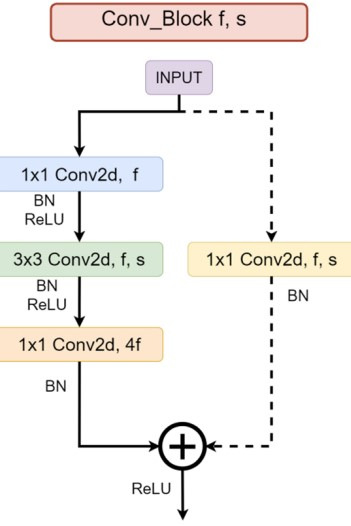

In [228]:
class Conv_Block(nn.Module):
    def __init__(self, in_channels, f, s):
        super(Conv_Block, self).__init__()
        """
        Conv_Block implementation
        
        Args:
            1. in_channels (int) : Number of channels in the input.
            2. f (int): Number of channels in the output.
            3. s (int): stride
        Returns the output of the conv block 
        """
        # Convolution layer 
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = f, kernel_size = 1)
        # Batch normalization in 2D 
        self.bn1 = nn.BatchNorm2d(f)
        # ReLU
        self.act1 = nn.ReLU()

        # Convolution layer 
        # Add a padding of 1 otherwise problems in the dimension sizes 
        self.conv2 = nn.Conv2d(in_channels = f, out_channels = f, kernel_size = 3, stride = s, padding = 1)
        # Batch normalization in 2D 
        self.bn2 = nn.BatchNorm2d(f)
        # ReLU
        self.act2 = nn.ReLU()

        # Convolution layer 
        self.conv3 = nn.Conv2d(in_channels = f, out_channels = f, kernel_size = 1) # Is output channels supposed to be 4f ? Doesn't match 
        # Batch normalization in 2D 
        self.bn3 = nn.BatchNorm2d(f)

        # Convolution layer 
        self.conv4 = nn.Conv2d(in_channels = in_channels, out_channels = f, kernel_size = 1, stride = s)
        # Batch normalization in 2D 
        self.bn4 = nn.BatchNorm2d(f)

        # ReLU 
        self.act = nn.ReLU()


    def forward(self, x):
        """
        Feed-forward data 'x' through the module.
                
        Args:
            1. x (torch.FloatTensor)
            .
        Returns:
            1. output (torch.FloatTensor)
        """

        output1 = self.act1(self.bn1(self.conv1(x)))
        output1 = self.act2(self.bn2(self.conv2(output1)))
        output1 = self.bn3(self.conv3(output1))

        output2 = self.bn4(self.conv4(x))

        output = output1 + output2
        output = self.act(output)

        return output

<a name="subparagraph22"></a>
###  <font color='sienna'> II.2 -Implementation of Identity Block

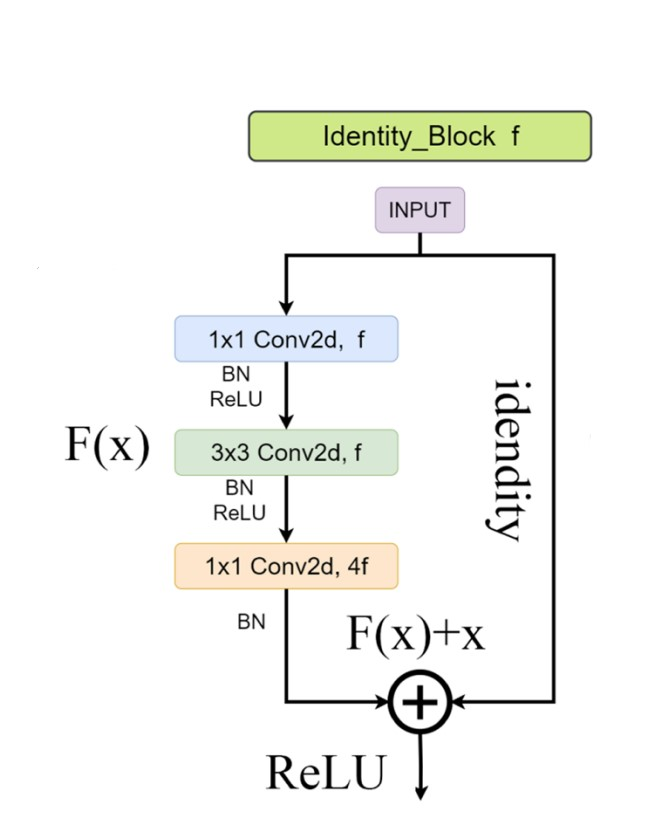

In [229]:
class Identity_Block(nn.Module):
    def __init__(self, in_channels, f):
        super(Identity_Block, self).__init__()
        """
        Identity_Block implementation
        
        Args:
            1. in_channels (int) : Number of channels in the input.
            2. f (int): Number of channels in the output.
        Returns the output of the con block 
        """
        # Convolution layer 
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = f, kernel_size = 1, padding = 'valid')
        # Batch normalization in 2D 
        self.bn1 = nn.BatchNorm2d(f)
        # ReLU
        self.act1 = nn.ReLU()

        # Convolution layer 
        self.conv2 = nn.Conv2d(in_channels = f, out_channels = f, kernel_size = 3, padding = 'same')
        # Batch normalization in 2D 
        self.bn2 = nn.BatchNorm2d(f)
        # ReLU
        self.act2 = nn.ReLU()

        # Convolution layer 
        self.conv3 = nn.Conv2d(in_channels = f, out_channels = f, kernel_size = 1, padding = 'valid')
        # Batch normalization in 2D 
        self.bn3 = nn.BatchNorm2d(f)

        # ReLU 
        self.act = nn.ReLU()


    def forward(self, x):
        """
        Feed-forward data 'x' through the module.
                
        Args:
            1. x (torch.FloatTensor)
            .
        Returns:
            1. output (torch.FloatTensor)
        """

        output = self.act1(self.bn1(self.conv1(x)))
        output = self.act2(self.bn2(self.conv2(output)))
        output = self.bn3(self.conv3(output))

        output = output + x 
        output = self.act(output)
        return output

<a name="subparagraph23"></a>
###  <font color='sienna'> II.3 -Implementation of the ResNet block

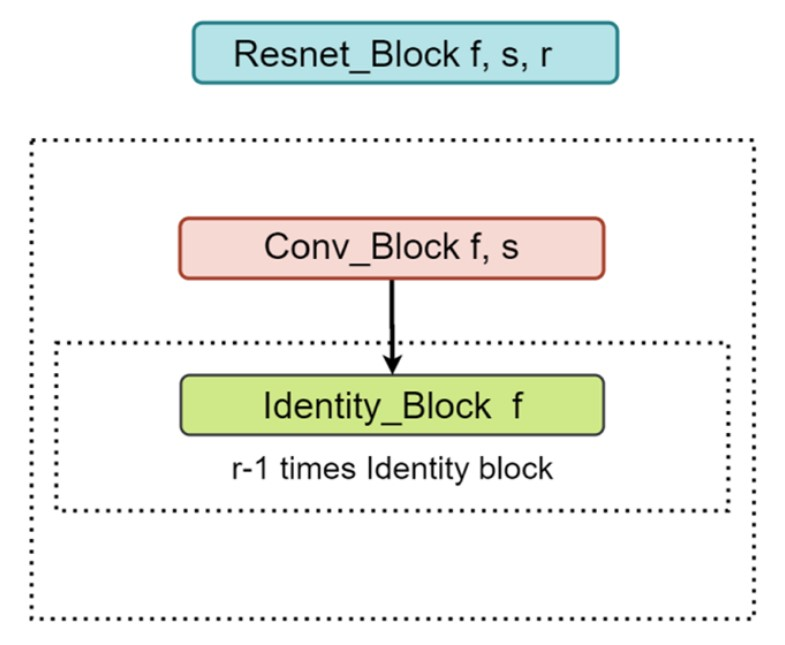

In [230]:
class ResNet_Block(nn.Module):
    def __init__(self,in_channels, f, s, r):
        super(ResNet_Block, self).__init__()
        """
        ResNet_Block implementation
        
        Args:
            1. in_channels (int) : Number of channels in the input.
            2. f (int): Number of channels in the output.
            3. s (int) : stride 
            4. r (int) : Run r-1 times the identity block after the conv block 

        Returns the output of the ResNet block 
        """

        # Conv_Block 
        self.conv_block = nn.Sequential(*[Conv_Block(in_channels, f, s)])
        # Identity_Block 
        self.id_block = nn.Sequential(*[Identity_Block(f, f) for _ in range(r-1)])
       

    def forward(self, x):
        """
        Feed-forward data 'x' through the module.
                
        Args:
            1. x (torch.FloatTensor)
            .
        Returns:
            1. output (torch.FloatTensor)
        """

        output = self.id_block(self.conv_block(x))
        
        return output

<a name="subparagraph24"></a>
###  <font color='sienna'> II.4 -Implementation of the network COV19ResNet

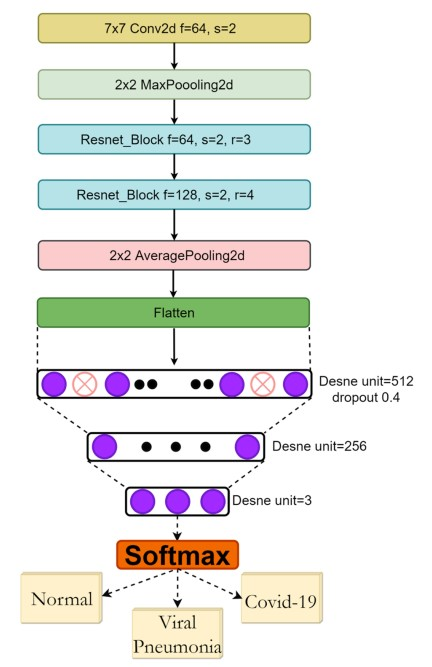

Here, we only output two neurons : Negative (to COVID 19) or Positive (to COVID 19). The detection of viral pneumonia isn't the focus of this project. 

In [231]:
class COV19_ResNet(nn.Module):
    def __init__(self):
        super(COV19_ResNet, self).__init__()
        """
        COV19_ResNet implementation
        
        Args:
            1. in_channels (int) : Number of channels in the input. (Should be 124x124x1)
        Returns the output of the con block 
        """
        # Convolution layer 
        self.res_conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 7, stride = 2)
        # MaxPooling layer 
        self.pool1 = nn.MaxPool2d(kernel_size = 2) 
        # First ResNet_Block 
        self.resNet1 = ResNet_Block(in_channels = 64, f=64, s=2, r=3)
        # Second ResNet_Block
        self.resNet2 = ResNet_Block(in_channels = 64, f=128, s=2, r=4)
        # 2x2 Average Pooling 2D 
        self.avg_pool = nn.AvgPool2d(kernel_size = 2)
        # Flatten 
        self.flat = nn.Flatten()
        # Dense unit = 512, dropout 0.4
        # Fully connected layer 
        self.fc1 = nn.Linear(6272, 512) 
        # Dropout 
        self.dropout = nn.Dropout2d(p =0.4)
        # ReLU
        self.act1 = nn.ReLU()
        # Fully connected layer 
        self.fc2 = nn.Linear(512, 256)
        # ReLU
        self.act2 = nn.ReLU()
        # Fully connected layer 
        self.fc3 = nn.Linear(256, 2) # The last layer only has two outputs because we want to identify positive or negative (and not viral pneumonia)
        # Softmax 
        self.softmax = nn.Softmax() 



        


    def forward(self, x):
        """
        Feed-forward data 'x' through the module.
                
        Args:
            1. x (torch.FloatTensor)
            .
        Returns:
            1. output (torch.FloatTensor)
        """
        output = self.res_conv1(x) 
        output = self.pool1(output)
        output = self.avg_pool(self.resNet2(self.resNet1(output)))
        output = self.act1(self.dropout(self.fc1(self.flat(output))))
        output = self.fc3(self.act2(self.fc2(output)))
        # output = self.softmax(output)
        
        return output

<a name="paragraph3"></a>
## <font color='burlywood'> III. Training the network

The code in this section was inspired by the code given in the first assignment of class CS491 that this project belongs to. 

<a name="subparagraph31"></a>
###  <font color='sienna'> III.1 - Settings

In [232]:
# Basic settings
device = 'cuda' if torch.cuda.is_available() and args.gpu else 'cpu'

result_dir = Path('C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/results')
result_dir.mkdir(parents=True, exist_ok=True)

global_step = 0
best_accuracy = 0.

In [233]:
result_dir

WindowsPath('C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/results')

In [234]:
def train_net(net, optimizer, scheduler, writer):
    global_step = 0
    best_accuracy = 0
    test_pred_fin = []
    test_truth_fin = []

    for epoch in range(args.epoch):
        # Here starts the train loop.
        net.train()
        for batch_idx, (x, y) in enumerate(train_dataloader):

            global_step += 1
            

            #  Send `x` and `y` to either cpu or gpu using `device` variable. 
            x = x.to(device=device)
            y = y.to(device=device)
            
            # Feed `x` into the network, get an output, and keep it in a variable called `logit`. 
            logit = net(x)
            print(logit)

            # Compute accuracy of this batch using `logit`, and keep it in a variable called 'accuracy'.
            accuracy = (logit.argmax(1) == y).float().mean()

            # Compute loss using `logit` and `y`, and keep it in a variable called `loss`.
            loss = nn.CrossEntropyLoss()(logit, y)

            # flush out the previously computed gradient.
            optimizer.zero_grad()

            # backward the computed loss. 
            loss.backward()

            # update the network weights. 
            optimizer.step()

            if global_step % args.log_iter == 0 and writer is not None:
                # Log loss and accuracy values using `writer`. Use `global_step` as a timestamp for the log. 
                writer.add_scalar('train_loss', loss, global_step)
                writer.add_scalar('train_accuracy', accuracy, global_step)

            if global_step % args.ckpt_iter == 0: 
                # Save network weights in the directory specified by `ckpt_dir` directory. 
                torch.save(net.state_dict(), f'{ckpt_dir}/{global_step}.pt')

        # Here starts the test loop.
        net.eval()
        with torch.no_grad():
            test_loss = 0.
            test_accuracy = 0.
            test_num_data = 0.
            # test_pred = pd.DataFrame(columns = ['Prediction', 'Ground_Truth'])
            test_pred = []
            test_truth = []
            for batch_idx, (x, y) in enumerate(test_dataloader):
                # Send `x` and `y` to either cpu or gpu using `device` variable..
                x = x.to(device=device)
                y = y.to(device=device)

                # Feed `x` into the network, get an output, and keep it in a variable called `logit`.
                logit = net(x)

                # Compute loss using `logit` and `y`, and keep it in a variable called `loss`.
                loss = nn.CrossEntropyLoss()(logit, y)
                
                # We want to save the predictions in a csv file to be able to compute other metrics (false negative percentage for ex)
                # d_temp = {'Prediction': logit, 'Ground_Truth': y}
                # df_temp = pd.DataFrame(data=d_temp)
                # test_pred = pd.concat([test_pred, df_temp], axis=1)
                test_pred.append(logit)
                test_truth.append(y)

                # Compute accuracy of this batch using `logit`, and keep it in a variable called 'accuracy'.
                accuracy = (logit.argmax(dim=1) == y).float().mean()
                # accuracy = (logit.argmax(dim=1) == y).mean()

                test_loss += loss.item()*x.shape[0]
                test_accuracy += accuracy.item()*x.shape[0]
                test_num_data += x.shape[0]

            test_loss /= test_num_data
            test_accuracy /= test_num_data

            if writer is not None: 
                # Log loss and accuracy values using `writer`. Use `global_step` as a timestamp for the log. 
                writer.add_scalar('test_loss', test_loss, global_step)
                writer.add_scalar('test_accuracy', test_accuracy, global_step)

                # Just for checking progress
                print(f'Test result of epoch {epoch}/{args.epoch} || loss : {test_loss:.3f} acc : {test_accuracy:.3f} ')

                writer.flush()

            # Whenever `test_accuracy` is greater than `best_accuracy`, save network weights with the filename 'best.pt' in the directory specified by `ckpt_dir`.
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                test_pred_fin = test_pred
                test_truth_fin = test_truth
                torch.save(net.state_dict(), f'{ckpt_dir}_best.pt')
    
        scheduler.step()
    return best_accuracy, test_pred_fin, test_truth_fins


In [235]:
# Function for weight initialization.
def weight_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.constant_(m.weight, 1)
        torch.nn.init.constant_(m.bias, 0)

In [236]:
# pip install tensorboard ## To run if this is the first time executing it from Jupyter notebook

In [237]:
# Setup tensorboard.
if args.tensorboard:
    from torch.utils.tensorboard import SummaryWriter 
    %load_ext tensorboard
    logs_base_dir = "./logs"
    import datetime, os
    os.makedirs(logs_base_dir, exist_ok=True)
    %tensorboard --logdir {logs_base_dir}
else:
    writer = None

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 26600), started 1 day, 1:22:53 ago. (Use '!kill 26600' to kill it.)

In [238]:
# Create directory name.
num_trial=0
parent_dir = result_dir / f'trial_{num_trial}'
while parent_dir.is_dir():
    num_trial = int(parent_dir.name.replace('trial_',''))
    parent_dir = result_dir / f'trial_{num_trial+1}'
print(f'Logs and ckpts will be saved in : {parent_dir}')



network = COV19_ResNet().to(device)
network.apply(weight_init)


Logs and ckpts will be saved in : C:\Users\Alexia85\Documents\KAIST\Cours\CS491\Project\results\trial_11


COV19_ResNet(
  (res_conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resNet1): ResNet_Block(
    (conv_block): Sequential(
      (0): Conv_Block(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU()
        (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv4): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
        (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
      )
    )
    (id_bl

<a name="subparagraph32"></a>
###  <font color='sienna'> III.2 - Training and Results

In [ ]:
 # Define optimizer
optimizer = optim.SGD(network.parameters(), lr=args.lr, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,80], gamma=0.5)
        
# Create directories for logs and ckechpoints.
ckpt_dir = parent_dir / args.name / args.ckpt_dir
ckpt_dir.mkdir(parents=True, exist_ok=True)
log_dir = parent_dir / args.name / args.log_dir
log_dir.mkdir(parents=True, exist_ok=True)

# Create tensorboard writer,
if args.tensorboard: 
    writer = SummaryWriter(log_dir)

# Call the train & test function.
t1 = time.time()
accuracy, test_pred, test_truth = train_net(network, optimizer, scheduler, writer)
t = time.time()-t1
print(f'Best test accuracy : {accuracy:.3f} took {t:.3f} secs')


# Print final best accuracies of the models.
for key in final_accs.keys():
    print(f'Best accuracy of {key} = {final_accs[key]:.2f}%')


C:\Users\Alexia85\anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


tensor([[ -3.1422,  -0.8611],
        [ -3.7231,  -1.0754],
        [ -0.1373,   0.4125],
        [  0.7978,   2.5951],
        [ -1.5017,  -2.7193],
        [ -2.2621,  -3.7158],
        [ -6.4692,   1.3633],
        [ -2.6509,   1.6864],
        [  0.4805,  -1.3680],
        [ -0.8207,  -5.5464],
        [ -1.3897,  -1.4645],
        [ -1.1325,  -0.4598],
        [  0.3369,  -0.3008],
        [ -0.5303,  -0.7744],
        [  1.7197,  -2.2515],
        [ -0.9469,  -2.6016],
        [ -2.0221,   0.0145],
        [ -1.4765,  -1.1999],
        [ -4.0562,  -3.2288],
        [ -1.3434,  -1.4706],
        [ -2.7666,  -0.2420],
        [ -5.1005,  -0.2854],
        [  1.5175,  -1.2780],
        [  0.6926,   1.5500],
        [  1.2511,   1.4175],
        [ -5.3482,  -1.1651],
        [ -0.5818,   0.1355],
        [ -4.1793,  -0.1466],
        [ -3.8811,   1.1889],
        [  0.4172,  -0.0838],
        [ -0.5770,   0.7477],
        [ -5.3814,  -1.4448],
        [ -0.5398,   0.7485],
        [ 

tensor([[ -9.8043,   3.2411],
        [ -6.7936,   3.1091],
        [ -5.5568,   3.2441],
        [ -3.7853,   1.9925],
        [ -8.2337,   6.1796],
        [ -4.4244,   5.8571],
        [ -7.1373,   2.7648],
        [ -5.7105,   4.7912],
        [ -3.9305,   3.0940],
        [ -8.5362,   5.7865],
        [-12.0519,   6.1008],
        [ -6.4477,   5.9436],
        [-10.1653,   9.0242],
        [ -7.6890,   3.5632],
        [-11.9486,   7.6531],
        [ -9.1925,   6.5494],
        [ -6.6965,   2.8293],
        [ -5.9063,   4.3930],
        [-11.1163,   1.6301],
        [ -6.6820,   5.7382],
        [ -7.3019,   2.6609],
        [ -8.6670,   7.3664],
        [ -7.2559,   6.2488],
        [ -6.8619,   3.2233],
        [ -5.6282,   3.1437],
        [ -9.1835,   5.0193],
        [ -5.8258,   2.8490],
        [ -8.0021,   5.8391],
        [-22.0909,  14.1864],
        [ -9.2054,   3.9995],
        [ -5.0002,   3.9099],
        [ -8.1561,   2.5640],
        [ -3.3898,   2.5605],
        [ 

tensor([[ 0.5807, -3.3120],
        [ 2.2364, -3.0129],
        [ 3.4667, -5.4953],
        [ 0.9151, -3.0679],
        [-0.6907, -3.3878],
        [ 1.3513, -0.2103],
        [ 7.2707, -5.7397],
        [ 0.5765, -1.8514],
        [ 4.1720, -1.7068],
        [-0.8949, -2.3830],
        [ 5.0989, -2.0001],
        [-0.0252, -3.3719],
        [ 0.9688, -1.6451],
        [ 1.4996, -3.2265],
        [ 2.5125, -4.1701],
        [ 0.7252, -4.5909],
        [ 2.5380, -5.9363],
        [ 4.4696, -2.2401],
        [-0.5574, -5.7174],
        [ 1.3395, -5.4861],
        [ 1.6484, -1.9665],
        [ 3.7168, -3.3347],
        [ 1.3784, -1.0759],
        [ 3.5870, -3.9972],
        [ 2.8349, -4.6780],
        [ 1.8697, -3.0435],
        [ 0.9356, -2.4930],
        [ 0.8842, -0.5265],
        [-0.2587, -1.7327],
        [ 2.2039, -3.0782],
        [ 1.5608, -0.1847],
        [-1.4194, -1.1957],
        [ 0.1121, -1.9280],
        [ 1.4090, -3.9651],
        [ 1.9307, -2.9199],
        [ 0.4882, -2

tensor([[-1.1245, -0.6734],
        [ 0.1215, -0.9216],
        [-1.4912,  0.4520],
        [-1.8786, -2.3834],
        [-0.9762, -2.3287],
        [-2.5035, -3.2383],
        [-2.9085, -1.6598],
        [-2.1087, -1.0880],
        [-0.3436, -1.5795],
        [-1.1908, -2.6016],
        [-3.4409, -2.3817],
        [-1.4259, -2.6374],
        [-0.9512, -1.0609],
        [-3.3773, -5.0485],
        [-3.1581, -2.0495],
        [-2.3861, -1.3738],
        [-2.5345,  0.1339],
        [-0.8234, -0.4999],
        [-0.0684,  4.8122],
        [-3.1444, -2.3193],
        [-1.6164, -0.3923],
        [-0.2431, -0.6142],
        [-2.8473, -1.5601],
        [-0.7092, -1.1593],
        [-0.8422, -0.3838],
        [-2.3079, -3.4094],
        [-2.8368, -1.5056],
        [-1.8254, -1.5573],
        [-1.4368, -0.8947],
        [-1.1641,  0.0885],
        [-2.5332, -2.0995],
        [-3.3530, -1.5231],
        [-2.9757, -1.8191],
        [-2.8451, -2.9098],
        [-2.2117, -4.2506],
        [-0.2836, -1

tensor([[ 0.9423, -0.8198],
        [-0.5183, -1.1357],
        [-2.4097, -4.5516],
        [-2.7040, -3.1456],
        [-0.3866, -2.5975],
        [-0.9712, -1.3069],
        [-1.9212, -3.7361],
        [-0.1578, -0.9632],
        [-1.1150, -2.7596],
        [-1.0329,  0.0406],
        [-0.1782, -1.3041],
        [ 0.0616, -3.6978],
        [ 0.1680, -1.9890],
        [-1.5431, -1.7008],
        [ 0.2467, -4.0282],
        [-0.3889, -4.3865],
        [-0.9876, -4.3629],
        [-0.5092, -1.3683],
        [-0.1816, -0.3355],
        [ 0.1487, -1.8424],
        [-0.3922, -6.1399],
        [ 0.1894, -4.1084],
        [ 0.5326, -0.8337],
        [-1.0371, -1.6762],
        [ 0.2948, -2.5288],
        [-0.4344, -1.8713],
        [-0.7020, -5.7999],
        [-3.4773, -3.7060],
        [-1.5052, -3.5073],
        [-0.2716, -1.5839],
        [-1.2712, -1.5663],
        [-1.6016, -1.6983],
        [-0.8003, -2.6103],
        [-2.0007, -5.3233],
        [-0.0196,  0.1893],
        [-2.0928, -3

tensor([[-3.4028e+00, -8.3615e-01],
        [-1.7814e+00, -1.7309e-01],
        [-2.3612e+00,  4.2347e-01],
        [-7.5536e+00, -2.2435e+00],
        [-2.8423e+00,  1.3459e+00],
        [-1.6802e+00, -1.3470e-01],
        [-4.0756e+00, -6.4042e-01],
        [-1.5792e+00, -2.1405e+00],
        [-4.4453e+00, -3.1261e+00],
        [-3.0080e+00,  6.7286e-01],
        [-1.0180e+00,  5.2234e-01],
        [-3.8362e+00, -9.7101e-01],
        [-1.3432e+00, -9.5185e-01],
        [-2.9046e+00, -3.1128e+00],
        [-2.4053e+00, -1.8670e+00],
        [-2.7359e+00, -9.3914e-01],
        [-4.9100e+00, -6.8755e-01],
        [-1.1041e+00, -2.0241e-01],
        [-3.6817e+00, -9.6233e-01],
        [-4.0097e+00, -1.1939e+00],
        [-1.2574e+00, -2.6372e-01],
        [-6.5895e-01, -8.2112e-01],
        [-3.9891e+00, -3.2787e-01],
        [-3.3210e+00,  1.9943e+00],
        [-2.1480e+00,  1.8307e+00],
        [-3.8897e+00, -1.0959e+00],
        [-2.6350e+00, -1.0168e+00],
        [-3.1252e+00, -8.018

tensor([[-1.5915e+00, -2.5748e+00],
        [-3.6857e-01, -1.7123e+00],
        [-1.7229e+00, -3.3001e+00],
        [ 2.9118e+00, -2.6073e+00],
        [-2.2571e+00, -5.1347e+00],
        [ 5.1469e-02, -2.5016e+00],
        [ 9.4490e-04, -1.4064e+00],
        [-1.0310e+00, -2.3968e+00],
        [ 5.9800e-01, -2.2389e+00],
        [-8.3041e-01, -2.7842e+00],
        [-2.2194e+00, -2.5400e-01],
        [ 3.1214e+00,  8.0541e-01],
        [-1.5151e+00, -1.8318e-01],
        [-1.3643e+00,  1.8924e+00],
        [-1.6299e+00, -3.5177e+00],
        [-1.4382e+00, -3.2734e-01],
        [-1.1954e+00, -7.0619e-01],
        [-1.9060e+00, -3.8049e+00],
        [-9.4575e-01, -5.1955e-01],
        [ 8.9804e-01, -1.0892e+00],
        [-3.1382e+00, -5.4175e+00],
        [ 9.6889e-02, -1.6323e+00],
        [-6.8473e-01, -3.1404e+00],
        [ 1.3716e+00, -3.2449e-01],
        [-2.8141e+00, -2.6605e+00],
        [-4.1533e-01, -1.2586e+00],
        [-1.6882e+00, -2.8547e+00],
        [-3.8010e-01, -1.566

tensor([[-0.7673, -0.2572],
        [-1.5219, -0.8509],
        [-3.9440, -3.8565],
        [-0.1227, -2.6619],
        [-0.7236, -1.4467],
        [-0.1411, -0.6889],
        [-1.9494, -1.1707],
        [-2.2130,  0.7343],
        [-0.1955, -4.5562],
        [-0.1541, -0.1175],
        [-1.5563, -1.1120],
        [-1.2539, -1.4028],
        [-2.1696, -2.7473],
        [-3.2931, -2.1191],
        [ 1.4894, -0.5629],
        [-0.4704, -2.4463],
        [ 0.1671, -3.6431],
        [ 0.6770, -1.6397],
        [-0.4150, -1.6217],
        [-1.4326, -0.0645],
        [-0.8021, -0.6509],
        [-0.8786, -0.8897],
        [-1.6195, -1.4882],
        [-2.3889, -3.5889],
        [-2.5393, -7.1751],
        [-1.3882, -2.0024],
        [-2.4271, -2.2342],
        [-0.2984, -0.2366],
        [ 0.9680, -1.7705],
        [-1.7212, -2.3946],
        [-0.8001, -0.9208],
        [ 0.4770,  0.7565],
        [-0.8271,  0.0835],
        [-1.7149, -1.0706],
        [ 2.3727, -2.0836],
        [ 0.8218, -2

tensor([[-1.4653e+00,  2.9156e-01],
        [-1.7483e+00, -1.6857e+00],
        [-3.2712e+00, -1.7052e+00],
        [-1.4866e+00,  5.3589e-02],
        [-2.0106e+00, -1.4883e-01],
        [-2.0147e+00, -9.2467e-01],
        [-3.4702e+00,  8.2584e-01],
        [-5.7838e-03, -1.5457e+00],
        [-3.5740e+00, -1.8225e-01],
        [-2.2900e+00, -3.8511e-01],
        [-2.3178e+00, -2.8429e-01],
        [-2.2996e+00,  7.7801e-01],
        [-7.4273e-01, -1.4606e+00],
        [-6.7763e-01, -1.1516e+00],
        [-3.8513e+00,  1.0790e+00],
        [-5.5560e-01, -1.9246e+00],
        [-2.9556e-01,  1.9704e+00],
        [-1.3836e+00, -3.1103e+00],
        [-1.2849e+00,  8.0800e-01],
        [-6.9160e-01,  5.0344e-01],
        [-3.6792e+00,  1.5107e+00],
        [-2.7294e+00, -1.0182e+00],
        [ 9.4756e-01,  1.3599e+00],
        [-2.0819e+00, -3.1063e+00],
        [-1.0118e+00,  7.7878e-01],
        [-2.0318e+00, -3.5828e+00],
        [-4.0305e-01, -1.9054e+00],
        [-2.1425e-01, -5.975

tensor([[-3.4565, -3.3600],
        [-3.3059, -0.1066],
        [-3.0737, -1.3207],
        [-2.3129, -1.3517],
        [-1.9550, -0.4168],
        [-3.8775,  0.1434],
        [-2.5097,  1.1425],
        [ 0.2595, -1.9179],
        [-1.5982,  1.0180],
        [-3.5899, -1.2382],
        [-2.8297,  2.3725],
        [-2.1908,  0.7484],
        [-1.2164,  1.0227],
        [-2.5465,  1.9078],
        [-2.7049, -3.0616],
        [-1.7645,  0.2822],
        [-1.7572, -0.1079],
        [-0.9194, -0.7912],
        [-0.2186, -2.5662],
        [-4.5883,  0.4188],
        [ 0.8301, -0.3888],
        [-4.9401,  2.4883],
        [-0.8201,  1.2414],
        [-0.2492, -1.8840],
        [ 1.2147,  0.0479],
        [-1.0848, -2.9714],
        [-1.2696, -0.8642],
        [ 0.5142, -1.8739],
        [-1.6280, -1.7921],
        [-1.4988,  0.7813],
        [ 0.1790, -0.5862],
        [-3.4527, -5.3599],
        [-1.0553, -0.3143],
        [-1.4838, -0.6473],
        [-2.5334, -0.5665],
        [-2.8945,  0

tensor([[ 0.1017,  0.0897],
        [-0.4327, -1.1605],
        [ 0.7355, -3.3619],
        [-0.1497,  0.1113],
        [-0.3074, -2.0972],
        [ 1.1791, -0.0619],
        [-1.0031, -1.0079],
        [ 2.2438, -3.9564],
        [ 0.4136, -3.1819],
        [-1.3685, -3.1840],
        [-1.0213,  0.1174],
        [-0.9559,  0.1097],
        [-1.7395, -0.9848],
        [ 0.6437, -2.3823],
        [-0.0982,  0.9637],
        [-0.6175, -0.8250],
        [ 2.1037, -2.0810],
        [-0.8107, -0.3985],
        [-3.3868, -0.6868],
        [-1.7196, -1.5544],
        [-2.5868,  0.8368],
        [-1.3878, -1.3945],
        [-1.4322, -2.1850],
        [-1.9784, -1.2878],
        [-2.9899, -1.3455],
        [ 3.9429,  1.8641],
        [ 1.2994, -1.5778],
        [-1.0597, -0.0652],
        [-2.0829, -1.8911],
        [ 2.4645, -2.2058],
        [ 1.7815, -2.1367],
        [-1.4360, -0.4900],
        [-1.6993, -1.2587],
        [-0.4456, -2.3880],
        [-2.7301, -1.7823],
        [-2.4935, -1

tensor([[ 8.8928e-01, -1.2582e+00],
        [-1.4550e+00, -1.8191e+00],
        [-3.3923e-01, -1.9873e+00],
        [-7.5098e-01, -1.9440e+00],
        [ 2.9963e+00, -1.3638e+00],
        [-8.2455e-01, -5.5778e-01],
        [-3.0243e+00, -1.8456e+00],
        [ 1.6398e-01, -2.6944e+00],
        [-1.0196e+00, -6.0665e-01],
        [ 8.6513e-01, -7.4224e-01],
        [-2.7720e+00,  8.7770e-01],
        [-1.3057e+00, -2.9735e-02],
        [-5.6606e-01, -4.8240e-03],
        [-6.1625e-01, -5.3767e-01],
        [-2.0523e+00, -8.1875e-01],
        [ 2.0950e+00, -9.7760e-01],
        [-8.8481e-01, -8.5569e-01],
        [ 2.4577e-01, -7.0034e-01],
        [ 2.0565e+00, -1.1243e+00],
        [-2.8154e+00, -8.4484e-02],
        [ 3.2138e-01, -4.8079e-01],
        [ 2.0452e-01, -1.0164e-02],
        [ 3.5623e-01, -9.7207e-01],
        [ 1.7480e+00, -1.4238e+00],
        [-2.6451e+00, -7.0605e-01],
        [ 4.3294e-01,  3.8494e-01],
        [-1.7968e-03, -8.5399e-01],
        [-1.5812e-02, -2.791

tensor([[-2.3168e-01, -8.5929e-01],
        [ 1.1062e+00,  1.0701e+00],
        [-4.5611e-01, -2.1523e+00],
        [-5.5824e-01, -1.1762e-01],
        [-2.7350e+00,  3.9910e-01],
        [ 1.5076e+00, -5.0890e-01],
        [-5.9156e+00,  2.3186e+00],
        [-1.5865e+00,  7.9224e-01],
        [ 8.0319e-02,  4.6637e-01],
        [-5.1283e-01, -1.1861e+00],
        [-2.4201e+00, -2.2614e+00],
        [-8.5947e-01, -5.8990e-01],
        [ 1.9074e-01, -6.2903e-02],
        [-1.4059e-01, -1.4665e+00],
        [-1.9239e+00,  2.2393e-01],
        [-1.2754e+00,  2.3452e+00],
        [-5.0372e-01,  1.2586e-01],
        [-1.3924e+00, -4.1638e-01],
        [-1.3898e+00,  2.2814e+00],
        [-1.6627e+00, -3.6127e+00],
        [ 4.1415e-01,  8.2694e-01],
        [-5.2845e+00,  3.4036e+00],
        [-1.3156e+00, -6.6834e-01],
        [-2.1477e+00,  5.1175e-01],
        [-4.2775e+00, -3.2040e-01],
        [-5.7661e-01, -8.2641e-01],
        [ 2.8633e-01, -3.9339e-01],
        [-3.0739e-01, -7.184

tensor([[-4.0448e-02, -7.3922e-02],
        [ 7.3098e-02,  1.6936e+00],
        [-1.8559e+00,  1.8045e+00],
        [-7.2784e-02, -6.7884e-01],
        [-3.7117e-01,  2.4497e-02],
        [ 4.1190e-01,  7.8666e-02],
        [ 1.6453e+00, -1.5528e+00],
        [-3.1634e+00, -1.5609e+00],
        [-7.0200e-01,  2.8140e-01],
        [ 2.1574e-01,  5.8340e-01],
        [-1.9740e+00, -6.0302e-01],
        [-1.3637e+00, -5.6984e-01],
        [ 1.1728e+00, -1.4064e+00],
        [-4.2714e-01,  4.8183e-01],
        [ 9.9198e-02, -8.2667e-01],
        [-2.1433e-02, -3.8058e-01],
        [ 3.9153e-01, -1.3273e+00],
        [ 5.3091e-01, -2.1432e-01],
        [-1.7117e-01,  1.4052e-02],
        [-4.9920e-01, -2.2656e+00],
        [-3.8288e+00,  5.9398e-01],
        [-3.6759e-01, -5.7072e-01],
        [-9.4320e-01, -4.8074e-01],
        [-3.9398e-01, -9.0405e-01],
        [ 6.5000e-01,  5.2741e-01],
        [-1.2794e+00, -6.9901e-01],
        [ 1.1109e+00, -6.8826e-02],
        [-1.6817e+00, -5.217

tensor([[-1.2436, -0.5971],
        [-0.2148, -1.4608],
        [-0.2810,  0.3342],
        [ 1.5097, -0.8705],
        [-2.2958, -0.3037],
        [-4.9152,  0.3238],
        [-1.0695, -1.1325],
        [ 0.3955, -0.1239],
        [ 0.2872, -2.8292],
        [-0.2820, -3.1034],
        [-1.1626, -0.4061],
        [-2.0677,  1.1520],
        [-1.9248, -0.5831],
        [ 3.3594,  2.4621],
        [-0.4179,  1.7300],
        [ 0.3592, -0.9896],
        [-0.3153, -0.3567],
        [ 0.5576, -0.8881],
        [-0.8024,  0.0498],
        [-1.1302, -0.7915],
        [-0.9842, -0.0468],
        [ 1.7923, -1.2984],
        [-0.4649,  1.5548],
        [-1.4245, -0.2965],
        [ 1.3658,  1.7026],
        [ 1.0495,  0.4173],
        [-1.8509,  0.8171],
        [-2.9442,  2.3958],
        [-0.7685, -1.1949],
        [-0.7435,  0.2314],
        [ 0.7308, -0.9055],
        [-1.1546,  0.1804],
        [-0.9596,  0.0704],
        [-2.3805, -1.2071],
        [ 0.0884,  0.1231],
        [ 0.6220,  1

tensor([[-7.4971e-01, -2.9943e-01],
        [ 3.5530e-01, -1.1440e+00],
        [ 1.3085e+00, -7.5854e-01],
        [-2.3116e+00, -3.7611e-01],
        [ 2.5810e+00, -1.9636e-01],
        [-1.4283e+00, -8.9764e-03],
        [ 6.3831e-01, -2.0140e-01],
        [ 1.6694e+00, -1.1210e+00],
        [-2.5242e+00, -1.5077e-01],
        [-3.8901e+00,  1.1479e+00],
        [ 1.8186e+00, -8.2018e-02],
        [-1.1184e+00, -6.6396e-01],
        [ 2.2555e-01, -1.5313e+00],
        [-5.5234e-01, -1.1544e+00],
        [ 1.8383e+00, -3.6661e+00],
        [-6.7993e-01, -1.2221e+00],
        [-2.8453e+00,  2.7547e-01],
        [-4.6160e+00,  1.7654e+00],
        [ 7.4709e-01, -5.7980e-01],
        [-2.0055e+00,  3.8188e-01],
        [-1.8965e+00,  1.3651e+00],
        [ 3.1961e+00, -3.1860e-01],
        [ 1.3305e+00, -9.0276e-01],
        [ 3.3957e+00, -8.9634e-01],
        [-3.7790e-01, -1.2310e+00],
        [-1.4610e+00, -1.2266e+00],
        [ 1.5737e+00,  5.9048e-01],
        [-1.2099e+00, -4.770

tensor([[ 5.9793e-01, -1.1859e+00],
        [-3.3477e+00,  2.9224e-01],
        [-8.5755e-01, -1.9806e-01],
        [-4.2680e-01,  3.0549e-01],
        [-1.4207e+00, -3.2622e-01],
        [-1.4825e+00, -9.6464e-01],
        [-3.6216e+00,  5.8073e-01],
        [-7.3861e-01, -3.4273e-01],
        [-2.5563e+00,  1.4516e+00],
        [ 3.7586e-01, -8.8160e-01],
        [-4.9568e-02, -7.6892e-02],
        [-2.9313e-01,  4.9636e-01],
        [ 2.2509e+00, -1.5387e+00],
        [ 1.2068e+00, -2.5510e+00],
        [-3.3819e+00, -1.5816e-01],
        [-9.9025e-01, -7.6203e-01],
        [-3.0679e-01, -9.1248e-01],
        [-3.0272e+00,  8.9634e-01],
        [-4.8106e-01, -9.6187e-01],
        [-3.2002e+00,  1.3335e+00],
        [-7.8918e-01, -1.0682e+00],
        [-4.1115e-01, -1.3470e+00],
        [ 1.1038e+00, -1.2811e-01],
        [-3.4562e+00, -6.7846e-01],
        [-2.0030e-01, -6.2377e-01],
        [ 9.7401e-01, -1.2459e+00],
        [ 1.0641e+00,  7.3590e-01],
        [ 4.9234e-03,  2.121

tensor([[-0.5022, -0.0388],
        [-2.8851,  1.4162],
        [-0.3616,  0.5001],
        [-0.2120, -1.7440],
        [-1.0287,  1.7149],
        [-1.3103,  0.8235],
        [ 0.4452, -1.3610],
        [-3.7485,  2.8101],
        [-0.2401,  0.9712],
        [ 0.8614,  0.5474],
        [-0.7619, -0.7005],
        [-0.0880, -2.0760],
        [ 0.9137,  0.9457],
        [-0.5508,  0.5184],
        [-0.8983,  0.2166],
        [-1.1360, -0.2257],
        [-2.6721,  1.5425],
        [-3.4707,  1.0694],
        [ 0.0973,  1.7029],
        [ 0.5303, -2.4945],
        [-3.9759,  2.4184],
        [ 0.1576,  0.4688],
        [-0.8595,  0.5434],
        [-2.9958,  0.0985],
        [-1.3154, -0.3681],
        [ 1.3351, -0.3448],
        [ 0.2199,  0.1089],
        [-0.6561,  0.1597],
        [ 2.8497, -0.8885],
        [-0.6161, -0.5512],
        [ 1.4447,  2.4475],
        [-2.7000,  1.5963],
        [-0.3253,  1.3897],
        [ 0.5541, -1.1502],
        [-5.5313,  2.1084],
        [-0.0810, -2

tensor([[ 2.3003, -0.9210],
        [-1.5421,  0.0660],
        [-1.9281,  1.4504],
        [ 0.5889,  1.5295],
        [ 0.4918,  0.6664],
        [-0.9692,  1.0362],
        [-0.8376, -0.7502],
        [ 0.4581,  0.5319],
        [-1.9667,  0.9379],
        [-0.8181,  0.5608],
        [-1.4038, -0.3186],
        [-2.7805,  0.0175],
        [-2.2161,  0.0266],
        [ 0.5765,  0.2193],
        [ 0.1267, -0.0455],
        [-1.9108, -0.8953],
        [-1.7830,  1.1110],
        [-1.7900,  2.9469],
        [-0.9339,  1.4701],
        [-0.2259,  0.0434],
        [-2.1638, -1.0866],
        [-3.2046,  1.2781],
        [ 1.1825, -0.2323],
        [ 0.5441,  0.7122],
        [ 1.5063, -0.7584],
        [-1.0926,  0.7476],
        [ 0.2871, -0.6820],
        [-0.2664,  0.5527],
        [-0.4245,  0.3051],
        [-1.0502, -1.4092],
        [-0.5090, -1.1593],
        [-2.6861,  0.2441],
        [-2.9856,  0.1118],
        [ 0.4928, -1.3392],
        [ 0.8173, -1.4633],
        [-0.7662, -1

tensor([[-2.2683e+00,  4.5499e-01],
        [-3.1365e+00, -1.2649e+00],
        [-7.3816e-01,  1.7557e+00],
        [ 2.9565e+00,  1.4932e-01],
        [ 6.4138e-01, -1.4615e+00],
        [ 5.7829e-01,  7.2502e-01],
        [-1.2041e+00,  5.5517e-01],
        [ 2.7139e+00, -1.4479e+00],
        [ 2.7606e+00, -3.8510e+00],
        [-3.3061e+00, -1.1944e-01],
        [ 4.0284e-01, -6.5881e-01],
        [ 1.1510e+00, -4.0748e+00],
        [-1.5993e+00,  2.8885e-01],
        [ 6.5966e-02, -5.5772e-01],
        [-9.4063e-01,  6.7274e-01],
        [ 1.4257e+00, -4.5991e-01],
        [ 7.0126e-01, -1.9233e+00],
        [-4.8659e+00,  1.6458e+00],
        [-1.0327e+00, -1.0028e+00],
        [ 1.4829e+00, -1.4921e+00],
        [ 5.3905e-01, -1.5110e+00],
        [-4.3242e-01,  3.9602e-01],
        [ 9.3478e-01,  1.7658e-02],
        [-3.1168e+00, -2.3349e-02],
        [ 2.8995e+00, -1.0940e+00],
        [-2.6405e+00,  1.3346e+00],
        [-3.0437e-01, -1.5010e+00],
        [-1.1255e+00, -8.516

tensor([[-3.4644e+00, -9.1681e-02],
        [ 6.4797e-02, -5.6903e-01],
        [ 9.5092e-01, -6.8192e-01],
        [ 7.9670e-02,  2.0328e-01],
        [-3.3719e+00,  2.2212e+00],
        [ 1.7353e+00, -8.5793e-01],
        [-3.5928e-01, -1.0223e+00],
        [-2.0574e+00,  7.8963e-01],
        [ 7.2571e-01,  1.6850e-01],
        [-5.3371e-01, -7.3165e-01],
        [-1.3545e+00, -4.6107e-01],
        [-9.0959e-01,  4.0773e-01],
        [-2.7336e-01, -7.5311e-03],
        [-2.5125e+00,  1.9181e+00],
        [ 2.3119e-01,  5.6806e-01],
        [ 4.4811e-01,  1.7796e+00],
        [-1.0279e-01, -1.7123e+00],
        [ 3.4580e-01,  1.1225e+00],
        [-3.1043e+00,  7.5029e-01],
        [-4.1781e+00,  8.3538e-01],
        [ 3.8637e-02,  3.7547e-01],
        [-7.4428e-01, -1.9865e-01],
        [ 3.1934e+00,  1.1675e-02],
        [ 7.7898e-03,  1.0759e+00],
        [-4.0657e+00,  8.0619e-01],
        [ 5.4731e-01,  1.5322e+00],
        [-1.0264e+00,  8.3399e-01],
        [-1.4812e+00,  2.706

tensor([[-0.1978, -0.5981],
        [-0.2062,  2.0673],
        [-0.2946,  0.9562],
        [ 0.6225, -0.2424],
        [-3.5873, -0.4583],
        [-3.1569,  1.2256],
        [ 0.3886,  0.9778],
        [ 0.1138, -1.5059],
        [-1.7220, -0.5628],
        [-0.1315,  0.4478],
        [ 1.1326, -1.3990],
        [-0.1963,  0.1550],
        [ 1.7144,  0.0101],
        [-1.5478,  3.2238],
        [-0.0151, -0.4229],
        [ 2.7312, -0.6312],
        [-4.0514,  0.0172],
        [-0.5232, -0.2483],
        [-3.4251,  1.5838],
        [ 0.0408,  2.1211],
        [ 0.7662, -1.2198],
        [ 0.5814, -1.8817],
        [ 0.1842, -3.8482],
        [ 1.3674,  0.8659],
        [-0.1513,  0.6479],
        [-2.9016, -0.0279],
        [ 1.5553, -1.1145],
        [ 1.1639,  1.4136],
        [-1.5880, -1.3664],
        [ 2.0610, -1.1355],
        [ 2.5576, -0.4992],
        [-1.3928,  0.2257],
        [-4.7801,  2.6070],
        [-5.8075,  0.1894],
        [ 0.1719, -0.1290],
        [ 0.9803,  0

tensor([[ 0.8936, -0.5070],
        [-0.9206,  0.6026],
        [ 0.7151, -1.4602],
        [-3.0696,  0.5483],
        [-0.9404, -0.6502],
        [-0.9604, -0.9290],
        [ 1.9547, -2.6756],
        [-0.5077, -0.3356],
        [ 2.1452, -1.4148],
        [ 0.1024, -0.5551],
        [ 0.0749, -0.2527],
        [ 2.4681, -0.4487],
        [ 0.1257,  0.1819],
        [-2.3789,  2.1310],
        [ 0.9848, -0.7207],
        [ 0.3182, -0.0370],
        [-0.2885, -0.1668],
        [ 0.7632,  0.6149],
        [-1.0072,  0.3697],
        [ 0.2329,  0.8773],
        [ 1.6374, -1.0988],
        [ 0.2627,  0.2788],
        [-0.7224, -3.1724],
        [-4.1857, -0.1899],
        [ 1.0359, -0.1480],
        [ 1.7277,  0.5928],
        [ 1.9930,  0.4137],
        [ 1.1249,  0.4397],
        [ 2.3991, -1.5462],
        [ 0.4641, -1.4074],
        [ 0.7821, -1.9847],
        [-5.9197, -0.0138],
        [-2.3985, -1.1888],
        [-3.9342,  0.1656],
        [-0.8075, -1.5110],
        [-3.8407,  3

tensor([[-7.4366e+00,  1.4957e+00],
        [ 9.8221e-01,  7.7369e-01],
        [-3.4794e+00,  1.3842e+00],
        [ 2.3794e-01, -3.9444e+00],
        [-1.4700e+00, -3.3782e-01],
        [-5.6931e-01, -1.8040e+00],
        [-7.9043e-01, -1.4069e+00],
        [-3.9038e+00,  7.2558e-02],
        [ 1.1959e+00, -1.2346e+00],
        [-7.5217e-02, -3.0523e-01],
        [ 9.0035e-01,  6.0428e-01],
        [ 7.8384e-01,  8.3016e-01],
        [ 9.3874e-01,  6.0032e-01],
        [-2.3980e+00, -4.0929e-01],
        [-1.5230e+00,  6.1789e-01],
        [-7.7636e-02, -1.3891e-02],
        [ 3.4815e+00,  2.6789e-01],
        [ 1.3838e-01, -2.5849e+00],
        [-1.1400e-01, -2.1978e+00],
        [-1.1457e+00,  7.8532e-01],
        [-8.3661e-01,  1.6553e+00],
        [ 1.0641e+00,  2.9254e-02],
        [ 3.2667e+00, -5.5083e-01],
        [-3.8271e+00,  6.7093e-01],
        [-2.6417e-02, -2.9453e-01],
        [-3.8559e+00,  2.6034e+00],
        [ 9.3982e-04,  7.7436e-01],
        [ 1.7614e+00, -1.127

tensor([[-1.0022e+00,  1.1011e+00],
        [ 5.5561e-01,  4.1658e-01],
        [-2.9724e-01, -8.5358e-02],
        [ 1.5822e+00,  2.6888e-01],
        [-3.2670e+00,  2.6885e+00],
        [-4.0172e+00,  1.2222e+00],
        [-6.9649e-01, -1.6514e+00],
        [ 4.0160e-01, -2.3638e-01],
        [-3.5756e-01,  8.9920e-01],
        [ 3.9353e-01,  3.9403e-01],
        [ 1.3890e-01, -6.6847e-01],
        [-2.3473e-01,  1.2475e+00],
        [ 3.5322e-01, -1.1179e+00],
        [-8.4862e-01, -3.6588e-01],
        [-6.1664e-01,  3.6171e-01],
        [-6.1441e+00,  3.0809e+00],
        [-6.4878e-01,  2.5439e-01],
        [ 1.3630e+00, -1.3034e+00],
        [-2.5422e+00,  7.7973e-02],
        [-4.0898e+00,  2.0870e+00],
        [-2.6777e+00,  1.0829e+00],
        [ 1.7964e+00,  7.8890e-01],
        [ 1.9605e+00,  3.5336e-01],
        [ 1.6098e-01,  5.5181e-01],
        [-1.0476e+01, -5.8468e-01],
        [ 3.4220e+00,  3.7743e-01],
        [-5.9359e+00,  2.1595e+00],
        [-1.1736e+00,  4.576

tensor([[-1.2376e+00, -1.3431e+00],
        [-1.4329e+00,  9.1052e-01],
        [ 1.0230e+00, -5.2957e-01],
        [-2.5306e+00, -1.0100e+00],
        [-6.7097e+00, -1.2800e+00],
        [ 8.8623e-01,  2.6946e-01],
        [ 1.8051e+00, -1.3072e+00],
        [ 1.3579e+00, -5.9107e-01],
        [ 3.2715e-01,  5.8473e-01],
        [-3.7958e-02, -8.8947e-02],
        [-2.7996e+00,  1.0601e+00],
        [ 5.9935e-02, -8.2317e-01],
        [-5.6904e-01, -8.2849e-01],
        [-5.4223e+00,  2.9357e+00],
        [ 4.7267e-01, -2.3196e+00],
        [-1.1095e+00,  6.0381e-01],
        [-7.9702e-01,  2.4900e-01],
        [-9.3898e-01,  2.2320e-01],
        [-2.6763e-01,  1.5349e+00],
        [-1.9567e+00, -2.7620e-01],
        [-1.3621e+00, -1.9231e+00],
        [-5.4068e-01,  5.9800e-01],
        [-4.3835e+00,  1.0406e+00],
        [ 1.6297e+00, -1.2139e+00],
        [-4.9128e+00,  2.1313e+00],
        [ 9.7952e-01, -1.3786e+00],
        [ 7.6273e-03, -1.6560e+00],
        [ 7.8886e-01, -3.155

tensor([[-6.2392e-02, -2.0199e+00],
        [-1.5563e+00, -7.3623e-01],
        [-1.1544e+00, -1.4184e+00],
        [-8.2332e-02,  4.6536e-01],
        [ 9.6570e-01, -8.5173e-01],
        [-9.9318e-01, -5.0083e-01],
        [-6.0837e+00,  1.4410e+00],
        [ 8.9196e-01, -2.5873e-01],
        [-5.7231e+00,  2.5203e+00],
        [-1.3383e+00,  2.9546e-01],
        [-2.5362e+00, -4.5115e-03],
        [-3.7581e+00,  4.1659e+00],
        [ 4.7358e-01,  4.6846e-02],
        [-2.8564e-01, -5.5605e-01],
        [ 2.0794e-02, -1.2734e+00],
        [-3.6259e+00,  1.1733e+00],
        [-1.7171e-01, -7.8901e-01],
        [-6.1476e+00,  2.8481e+00],
        [ 1.4337e+00, -2.4064e+00],
        [ 1.8314e-01, -1.6698e+00],
        [-4.3664e-01, -3.7510e+00],
        [-2.0794e+00,  8.0406e-01],
        [-7.3548e+00, -9.3386e-01],
        [ 6.0906e-02, -4.1629e+00],
        [-2.8139e+00,  4.8405e-01],
        [-2.0559e+00, -2.5146e-01],
        [ 1.7481e+00, -5.9905e-01],
        [-1.0953e+00,  7.038

tensor([[ 1.3974e+00, -2.0105e-01],
        [ 2.2710e+00,  1.1111e+00],
        [-5.0608e-01, -6.1066e-02],
        [-5.8585e-01, -4.3509e-01],
        [ 2.8668e+00, -2.2575e+00],
        [ 8.1002e-01, -2.3596e-01],
        [ 3.9134e-01, -4.1147e-01],
        [-2.1463e-01,  3.9408e-02],
        [-4.2695e+00,  3.8036e+00],
        [-6.4473e-01,  3.0432e-01],
        [-1.8733e+00, -1.1423e+00],
        [ 9.2584e-01,  3.9874e-01],
        [-3.8241e+00,  1.2674e+00],
        [-3.1578e-01,  4.4632e-01],
        [ 1.6278e+00, -2.2263e+00],
        [ 2.5046e-01, -5.4505e-01],
        [ 5.2519e-02, -5.5860e-01],
        [ 1.8531e+00, -2.6927e+00],
        [ 1.2922e+00, -1.7729e+00],
        [-1.9320e-01, -3.2076e-01],
        [ 8.8100e-01, -9.5948e-01],
        [-3.0141e+00,  2.2783e+00],
        [ 7.7718e-01, -3.3677e+00],
        [-2.9232e-01,  5.9790e-01],
        [ 1.7431e-02,  6.6408e-01],
        [ 2.6346e+00, -3.6208e-01],
        [-1.7998e-01,  2.6488e-01],
        [-5.5279e+00,  1.369

tensor([[-5.7152e-01, -8.9337e-01],
        [-3.3652e-01, -5.8621e-01],
        [-4.6119e+00,  1.4423e+00],
        [ 5.3089e-01, -6.3804e-01],
        [ 2.2114e+00, -8.5113e-01],
        [-3.9741e+00,  8.5125e-01],
        [-1.8939e-01,  1.1905e+00],
        [ 3.0450e+00,  3.0492e-02],
        [ 1.9534e+00, -2.1058e+00],
        [ 1.6559e-01,  1.0478e+00],
        [ 2.2137e+00, -1.4824e+00],
        [ 1.2828e+00, -7.4082e-01],
        [-1.0735e+00, -4.7759e-01],
        [ 4.8233e-01, -5.8527e-03],
        [ 4.1342e-01, -5.6101e-02],
        [ 3.6736e-02, -1.4600e+00],
        [ 9.3143e-01, -5.5139e-01],
        [ 8.0544e-01,  2.2748e-01],
        [-5.0492e-02,  4.4876e-01],
        [-4.8471e-01, -2.2299e+00],
        [ 2.7221e+00, -1.9377e+00],
        [-1.6370e-01, -7.4683e-02],
        [-5.5221e-01,  2.4412e-01],
        [-2.3630e+00,  6.1930e-01],
        [-3.8297e+00,  2.6800e+00],
        [-3.3045e-01,  8.3904e-02],
        [ 2.5656e+00, -1.6985e+00],
        [-7.7169e-01,  7.737

tensor([[-1.1894e+00,  7.6542e-01],
        [-5.4710e+00,  4.6425e+00],
        [-1.0664e+00, -9.5775e-01],
        [-5.0351e+00,  2.5099e+00],
        [-9.4464e-01, -1.1680e-01],
        [-8.0248e-02,  5.6930e-01],
        [ 1.2646e+00,  1.0032e+00],
        [-2.1550e-01, -6.7955e-02],
        [ 6.7240e-01, -2.1229e+00],
        [-5.6551e-01,  2.6993e-02],
        [-2.6039e-01, -2.4941e+00],
        [ 1.4464e-01,  7.8727e-01],
        [-1.0564e+01,  1.7243e+00],
        [-5.3492e+00, -1.3727e+00],
        [-1.1185e+00, -2.0178e-01],
        [-1.0591e+00,  9.6081e-02],
        [-1.2203e+00,  9.3196e-02],
        [-8.4159e-01,  4.7524e-01],
        [-4.2939e+00,  1.6482e+00],
        [ 1.4464e-01, -5.2710e-01],
        [-1.5483e+00,  1.9903e+00],
        [ 4.4165e-01,  1.5235e+00],
        [-5.9796e+00,  2.9485e+00],
        [-3.5777e-01,  5.3393e-01],
        [-3.7891e-01, -5.3443e-02],
        [-2.2560e+00,  6.2400e-02],
        [-8.2233e-01,  5.8240e-02],
        [-3.9677e+00,  1.076

tensor([[-1.4241,  1.9410],
        [-0.2560,  0.0857],
        [-1.5803,  1.4595],
        [-0.6329, -0.2092],
        [ 1.2543, -2.4696],
        [ 1.7491, -2.4810],
        [ 0.8950, -1.3020],
        [ 1.4440, -0.0735],
        [ 1.2077, -1.8868],
        [-0.0848, -0.3692],
        [ 0.8388, -1.0039],
        [-0.5859,  0.9597],
        [-1.5467,  0.5934],
        [ 0.2088, -0.4748],
        [-1.1479,  0.4193],
        [ 0.3241, -1.3632],
        [ 0.9463, -0.8430],
        [ 1.5923, -1.0290],
        [-0.8529,  0.6128],
        [ 2.1297,  0.0866],
        [ 1.1240, -1.4327],
        [ 2.0535, -1.8281],
        [-0.6996,  0.2082],
        [-2.0179,  1.7432],
        [ 0.5801, -0.4098],
        [ 0.9839,  2.6643],
        [-0.8538, -1.0800],
        [-0.0664, -0.5163],
        [-0.8823, -0.5102],
        [ 2.1693, -0.1431],
        [-0.4700, -1.3953],
        [-0.4055,  0.0347],
        [ 1.9808, -0.8024],
        [ 0.3375, -0.2260],
        [-5.6410,  2.6799],
        [-1.3825,  2

tensor([[ 0.2644, -0.6498],
        [ 0.5484, -4.0526],
        [-1.7007,  0.4255],
        [ 0.4999,  0.7699],
        [ 0.1878, -0.1408],
        [-3.7916,  0.4133],
        [ 1.8485, -2.2461],
        [ 1.0872, -0.8781],
        [-3.1074,  1.0710],
        [-5.4122,  1.5194],
        [-5.9293, -0.3065],
        [ 2.2707, -2.7539],
        [-1.6367,  1.7138],
        [ 1.3107, -0.2613],
        [-0.0281, -1.0422],
        [ 2.3303,  0.0807],
        [ 1.1392, -0.4084],
        [ 2.1181, -1.6449],
        [ 1.4136, -2.5848],
        [ 2.5928, -4.3086],
        [-1.5519,  0.4778],
        [ 2.5793, -2.1831],
        [ 3.1023,  1.8902],
        [ 3.0370, -0.7059],
        [ 0.0184,  1.3529],
        [-4.4985,  1.3454],
        [-1.6467,  3.6135],
        [ 2.4832,  1.0593],
        [-0.0905, -0.2107],
        [-5.2379,  2.3045],
        [-3.2822,  3.9504],
        [ 0.0945,  0.8770],
        [ 1.2782, -1.1925],
        [ 1.1247, -0.5954],
        [ 0.4037,  0.4359],
        [ 0.7172,  0

tensor([[-4.9205e+00,  3.3426e+00],
        [ 1.3596e+00, -6.8869e-01],
        [ 2.3522e+00, -2.0383e-01],
        [-3.6640e+00, -6.0023e-01],
        [-5.6951e-01,  4.9605e-01],
        [-4.1260e+00,  3.9664e+00],
        [-3.7460e+00,  2.2243e+00],
        [ 3.5687e-01, -5.6469e-01],
        [ 1.0087e-01,  3.0898e-01],
        [-1.8895e-01,  4.7815e-01],
        [ 4.7559e-01,  6.7403e-01],
        [ 2.9836e-02,  4.5128e-01],
        [ 3.9516e-01, -5.8166e-01],
        [-1.3901e+00,  2.8165e+00],
        [ 1.6240e+00,  1.0713e-02],
        [-1.9554e+00,  3.3011e+00],
        [ 1.8981e+00,  8.1293e-01],
        [-1.8793e+00, -4.7732e-03],
        [ 2.2053e+00, -1.8371e+00],
        [ 7.5496e-01, -3.3971e-01],
        [-5.5606e-01,  7.2085e-01],
        [-1.9990e-01,  4.4663e-01],
        [ 1.1009e+00,  1.7758e-01],
        [-4.7634e+00,  2.1761e+00],
        [ 4.9049e-01, -3.9785e-01],
        [-4.8727e+00,  2.5753e+00],
        [-6.3207e-01, -1.3623e-01],
        [ 9.8374e-01,  3.427

tensor([[-7.3879e-01,  6.2027e-01],
        [ 1.2816e+00,  7.8998e-01],
        [ 1.8239e+00, -4.1722e-01],
        [ 7.7885e-01, -4.8924e-01],
        [-4.2818e+00,  9.1643e-01],
        [ 1.9573e-01, -1.4263e-01],
        [ 7.3721e-01, -5.6111e-01],
        [-1.2615e+00,  1.1193e+00],
        [ 1.3008e+00, -1.8152e+00],
        [-1.9163e+00, -1.9764e-02],
        [ 7.0019e-01,  1.5762e-01],
        [ 5.0037e-01, -3.8742e-01],
        [-1.9006e+00,  1.2765e+00],
        [-3.4069e+00,  1.5546e+00],
        [ 1.0965e+00, -2.5650e-01],
        [-1.3169e+00,  5.2194e-01],
        [ 3.2045e-01, -3.1106e-01],
        [ 3.8637e-01, -2.4938e+00],
        [ 7.5387e-01,  1.0265e-01],
        [-5.5263e+00,  4.1504e+00],
        [-1.1121e+00, -2.6431e+00],
        [ 1.1409e+00, -8.1170e-01],
        [-9.0232e-01,  1.2876e+00],
        [ 3.9717e-01,  4.1468e-01],
        [ 1.3687e+00, -2.2285e-01],
        [ 1.8323e+00, -2.0611e+00],
        [ 2.1606e-02,  3.9711e-02],
        [-1.9707e+00,  8.091

tensor([[-1.3550, -0.0091],
        [-3.0787,  1.7134],
        [ 2.1746, -0.7124],
        [-4.4163,  3.6729],
        [-1.3756, -0.1207],
        [ 2.8205, -1.7155],
        [-3.9617,  1.3014],
        [ 0.2584, -1.6457],
        [ 2.0021, -1.6390],
        [ 1.1630, -0.0769],
        [ 1.0490, -1.5308],
        [ 0.0295,  0.6315],
        [-1.0103,  0.4941],
        [-0.5979,  0.2349],
        [-0.1021, -1.9858],
        [-0.4717,  1.4298],
        [-4.3152,  2.2257],
        [-4.3361,  2.3904],
        [-1.0199, -0.7062],
        [ 1.5733, -1.8725],
        [-1.0143, -0.4638],
        [-1.0854,  1.3181],
        [-0.2028, -1.0402],
        [-1.1254, -3.0468],
        [ 2.6472, -1.9705],
        [ 1.6230, -2.0105],
        [-8.3303,  2.4476],
        [-1.0361,  1.2207],
        [-0.3257,  0.0437],
        [-1.8081,  1.0161],
        [-5.2273,  2.2586],
        [-1.0607,  1.3586],
        [ 0.7910,  0.2337],
        [-0.4109, -0.6673],
        [-0.6505,  1.6395],
        [-0.2425, -0

tensor([[-2.0306e-01, -6.3665e-01],
        [-3.9884e+00,  1.4135e+00],
        [-7.3928e-01,  2.4485e-01],
        [ 2.6168e+00, -4.0963e+00],
        [ 4.1318e-01, -5.6258e-01],
        [ 2.2553e+00, -1.4442e+00],
        [-1.7817e+00,  6.2690e-01],
        [-2.6555e-01, -2.6728e+00],
        [ 1.4865e+00, -3.5352e+00],
        [ 2.4331e-01, -8.6202e-01],
        [-2.9161e+00,  1.9083e-01],
        [-8.7841e-02,  4.2700e-01],
        [-7.7028e-03, -1.7087e+00],
        [-1.1490e+00,  3.3802e-01],
        [ 6.1012e-01, -4.3625e-01],
        [ 1.6879e+00, -1.5642e+00],
        [-7.7619e-01,  2.9137e-01],
        [-3.4641e+00,  2.2727e+00],
        [ 1.4158e+00, -2.5119e-01],
        [-2.1299e+00,  5.4716e-01],
        [ 1.4850e+00, -1.3555e+00],
        [ 1.2367e+00, -1.4916e+00],
        [-9.0614e-01, -8.2007e-01],
        [ 1.4068e+00,  8.7561e-01],
        [ 2.2798e+00, -1.3906e+00],
        [-2.5671e+00,  3.1591e+00],
        [ 7.2753e-01,  1.6553e-01],
        [-6.8206e-01,  9.007

tensor([[ 9.1262e-01, -3.8290e-03],
        [-4.1763e+00,  1.9085e+00],
        [-1.8601e-01, -1.2265e+00],
        [-4.1481e-01,  9.2515e-03],
        [ 5.4867e-01, -1.5858e-01],
        [ 5.0716e-01, -3.0580e-01],
        [-4.5764e+00,  3.1353e+00],
        [ 2.0161e-01, -1.7992e+00],
        [-1.6681e+00,  2.3629e+00],
        [-1.1956e-01, -1.8750e+00],
        [-2.0118e+00,  8.2797e-01],
        [ 1.7442e+00, -3.6648e-01],
        [ 9.3936e-01, -2.1796e+00],
        [ 1.5653e+00, -2.0235e-01],
        [-3.2397e-01, -6.3952e-01],
        [ 1.2625e+00, -1.8610e+00],
        [-4.8223e+00,  1.7528e+00],
        [ 1.8402e+00, -3.1472e-02],
        [ 1.0203e+00, -1.6817e+00],
        [ 1.8835e+00, -4.1871e-01],
        [-6.3129e+00,  1.9198e+00],
        [-4.7426e+00,  1.7262e+00],
        [-2.2174e-01, -4.7216e-01],
        [ 2.4946e-01,  1.0430e+00],
        [-4.5082e+00,  1.4165e+00],
        [-4.9950e-01, -1.1074e+00],
        [-1.0305e+00, -6.5408e-01],
        [-6.3353e+00,  7.578

tensor([[-1.0047e+01,  4.3106e+00],
        [-1.8001e+00,  2.0423e+00],
        [-9.2349e-01, -6.7432e-01],
        [-5.4653e+00,  2.6817e+00],
        [-1.6911e+00, -5.5219e-01],
        [-1.6132e+00, -4.1689e-01],
        [-5.3053e-03, -1.9815e+00],
        [-2.0071e-01, -9.1915e-01],
        [-2.5975e+00,  1.6334e+00],
        [ 2.5165e-01, -1.4435e-01],
        [-4.5416e+00,  1.7228e+00],
        [ 1.2691e+00, -2.0974e+00],
        [ 1.0070e+00, -1.4893e+00],
        [-1.8774e+00,  1.1785e-01],
        [ 7.5740e-01, -2.9582e+00],
        [ 1.8668e+00,  3.4416e-01],
        [-1.2163e+00,  8.1036e-02],
        [ 2.6330e-02, -6.9654e-01],
        [ 2.8628e+00, -3.0744e-01],
        [-5.5050e+00,  1.6267e+00],
        [ 1.8723e+00, -1.8441e+00],
        [ 3.6719e-01, -9.0091e-01],
        [-5.2072e-01, -4.3972e-02],
        [-1.8355e+00,  1.3075e+00],
        [-3.3873e+00,  1.5434e+00],
        [-1.2301e+00,  3.2449e+00],
        [ 8.0920e-01, -4.8035e-01],
        [-6.9018e+00,  6.907

tensor([[-6.9261,  1.2198],
        [ 1.1107, -1.4129],
        [ 1.2776, -1.4624],
        [-4.9396,  5.2693],
        [-0.0891, -1.4462],
        [-2.2796,  0.3988],
        [ 0.2315, -1.5265],
        [-1.4398,  1.7381],
        [ 0.1608,  1.0137],
        [-0.6361, -1.3908],
        [-4.0691, -2.1432],
        [ 1.2386, -0.9713],
        [-2.0928,  0.4591],
        [ 0.6073, -1.9448],
        [ 1.2059, -1.2807],
        [-0.7057, -0.5096],
        [-2.8075,  1.6697],
        [ 0.6459, -0.6218],
        [-7.5526,  2.5913],
        [-0.3140, -2.6212],
        [-1.2837,  0.9818],
        [-1.1544,  0.4335],
        [ 1.4282, -1.4648],
        [-0.6683, -0.5460],
        [-2.0868, -0.7116],
        [-1.3732, -0.1616],
        [-5.9222,  3.2144],
        [-3.7825,  0.9601],
        [-2.3058,  1.0177],
        [ 0.2775, -0.7116],
        [-5.2542,  1.7556],
        [-9.6203,  2.4244],
        [-1.5903,  1.3252],
        [ 1.7729, -0.9162],
        [-0.2445, -1.7822],
        [ 1.3529, -0

tensor([[ 1.9703e-01, -2.3083e+00],
        [ 7.9321e-01, -2.9023e+00],
        [-3.6184e+00,  1.2098e+00],
        [-4.5530e+00,  2.0722e+00],
        [ 9.1817e-01, -3.1146e+00],
        [-5.3502e+00,  1.7679e+00],
        [ 1.8654e-03,  7.8114e-03],
        [ 1.5370e+00, -2.5998e+00],
        [ 8.4732e-01, -4.4376e+00],
        [ 8.3733e-01, -3.2821e+00],
        [ 1.6172e+00, -9.2273e-01],
        [ 8.3794e-01, -2.3008e+00],
        [-3.4237e+00,  1.3976e+00],
        [-6.1851e-01, -1.9986e+00],
        [-1.1149e+00,  7.3339e-02],
        [-7.0074e+00,  1.5584e+00],
        [ 5.2708e-02, -3.3746e+00],
        [-2.9653e-01, -2.5979e+00],
        [ 2.1332e+00, -8.6101e-01],
        [-1.7468e+00,  4.6891e-01],
        [-8.2701e-01,  2.9101e-01],
        [-6.4894e+00,  2.2744e+00],
        [ 8.5834e-02, -3.1243e+00],
        [-7.8714e+00,  5.9904e+00],
        [ 7.3621e-01, -1.0983e+00],
        [ 1.0101e+00, -1.2123e+00],
        [-4.2412e-01, -2.6579e-01],
        [-3.7281e+00,  1.435

tensor([[-5.8832e+00,  2.2873e+00],
        [-2.5004e-01, -2.3192e+00],
        [-2.4072e+00, -5.9683e-01],
        [-6.6143e+00,  8.8104e-01],
        [ 9.7047e-03, -1.1461e+00],
        [-5.5953e+00,  3.0819e+00],
        [-8.8838e-02, -2.2803e+00],
        [-5.7127e+00,  2.5910e+00],
        [-1.3519e+00,  1.6504e-01],
        [-1.2162e+00, -1.3673e+00],
        [ 2.4088e+00, -2.8649e+00],
        [ 1.0304e+00,  1.0749e-03],
        [-4.3891e+00,  2.1142e+00],
        [-3.5308e+00,  4.9117e-01],
        [ 2.5065e-01, -3.2270e-01],
        [ 1.5895e+00, -1.3698e+00],
        [ 2.6580e+00, -1.5155e+00],
        [ 1.1294e+00, -7.4491e-01],
        [-2.2910e+00,  2.1581e+00],
        [-2.7838e-01, -1.9848e+00],
        [-6.1826e+00,  3.3694e+00],
        [-8.7092e-02, -2.5933e+00],
        [-2.7201e+00,  2.1896e+00],
        [ 6.3403e-01, -9.6725e-01],
        [ 2.0029e-01, -7.5734e-01],
        [-1.0495e+00, -4.8962e-01],
        [ 1.4758e+00, -4.0229e+00],
        [ 4.4046e-01, -2.150

tensor([[ 1.9405e-01, -2.3287e+00],
        [-2.3733e+00,  4.5044e-01],
        [-1.4519e+00,  9.9235e-01],
        [-2.6112e+00,  1.2982e+00],
        [-1.2135e+00,  4.4660e-01],
        [-1.7505e-01, -1.1594e+00],
        [ 9.9043e-01, -8.8052e-01],
        [ 7.0962e-01, -3.9256e+00],
        [-3.7647e+00,  2.0745e+00],
        [ 2.5640e+00, -1.2109e+00],
        [-6.8911e+00,  4.8679e+00],
        [-2.4059e+00,  6.9645e-01],
        [ 1.8023e+00, -3.0437e+00],
        [-1.6904e+00,  1.9806e-01],
        [-5.0115e+00,  3.4493e+00],
        [ 3.7662e-01, -1.8428e+00],
        [-1.8501e+00,  1.3715e+00],
        [-1.8094e+00,  5.3866e-01],
        [-2.1604e+00, -1.0731e+00],
        [ 9.2557e-01, -1.5483e+00],
        [-5.2037e+00,  8.7308e-01],
        [-2.5653e+00,  3.2244e+00],
        [-4.4982e-01,  5.0711e-02],
        [-1.2464e+00, -2.0753e-01],
        [-5.1969e-01, -4.7543e-01],
        [-1.0452e+00, -1.2791e+00],
        [ 3.1306e-01, -1.1508e+00],
        [ 1.9164e-01, -4.118

tensor([[-4.1165e+00, -6.8356e-01],
        [-2.3509e-01, -2.6262e+00],
        [ 1.3114e+00, -1.0844e+00],
        [ 9.7161e-01,  5.3166e-01],
        [-7.9858e-01,  1.7121e-01],
        [-5.2135e+00,  2.2367e+00],
        [-6.9740e+00,  2.2177e+00],
        [ 2.2868e+00,  1.2765e-01],
        [ 2.7045e+00, -3.0760e+00],
        [-2.3407e+00,  1.0081e-01],
        [-1.3183e+00, -2.9199e+00],
        [-4.2137e+00,  2.1400e+00],
        [-7.0958e+00,  3.8188e+00],
        [ 8.3345e-01, -4.4049e-01],
        [-5.8347e+00,  4.1803e+00],
        [ 8.7461e-01, -1.4537e+00],
        [-1.8419e-01, -1.3353e+00],
        [ 2.7943e+00, -2.5574e+00],
        [-8.5225e-01, -4.5649e-01],
        [-1.0367e+00,  1.2420e+00],
        [-1.3496e+00,  8.7822e-01],
        [-1.9416e-01,  9.2807e-01],
        [ 1.5242e+00, -2.4398e+00],
        [-4.7195e+00,  3.2630e+00],
        [-6.6764e-01, -1.1775e+00],
        [ 1.6780e+00, -3.6277e+00],
        [-4.7345e+00,  1.2916e+00],
        [-1.5556e+00,  1.622

tensor([[ 3.6020e-02, -1.8356e+00],
        [-1.5563e+00, -6.3595e-02],
        [-1.0454e+00,  1.0177e+00],
        [ 2.2545e+00, -5.3792e-01],
        [ 1.2889e+00, -3.3455e+00],
        [-1.2402e-01,  5.9914e-01],
        [-7.5949e-01, -8.2579e-02],
        [ 1.9310e+00, -2.3699e+00],
        [-9.4166e+00,  3.0163e+00],
        [-4.8116e-01,  1.1682e+00],
        [ 2.8117e+00, -1.7680e+00],
        [-1.6125e+00,  1.0905e-01],
        [ 2.6971e+00, -1.0130e+00],
        [-9.9439e-01,  1.4749e+00],
        [-5.9212e+00,  2.2343e+00],
        [-4.3728e+00,  8.5916e-01],
        [-3.1430e-01, -4.7703e-01],
        [-2.5319e+00, -1.4071e-01],
        [-7.8278e-01, -8.1073e-02],
        [-5.1503e-01, -8.3293e-02],
        [ 2.1244e+00, -7.0141e-01],
        [-7.2210e-01,  9.4140e-01],
        [-3.1490e-01,  7.2605e-01],
        [-8.8173e-01, -1.0230e+00],
        [-5.7716e-01,  4.3806e-02],
        [-3.5625e+00,  3.1679e+00],
        [-1.2384e+00,  3.9663e-01],
        [-3.1741e+00,  2.665

tensor([[ -1.7360,   0.6784],
        [ -3.3233,   0.9703],
        [  1.6647,  -1.0486],
        [ -2.8622,  -1.4468],
        [ -0.1153,  -0.3323],
        [  2.6192,  -3.5999],
        [ -1.8681,  -0.0758],
        [ -1.1561,   0.1743],
        [  1.7618,  -0.8482],
        [  1.4821,  -3.8210],
        [ -0.0667,  -0.2143],
        [  1.3066,  -0.6085],
        [  1.0887,  -1.6190],
        [ -2.4697,   1.9077],
        [  2.8405,  -1.6156],
        [  2.7182,  -0.2358],
        [ -0.9858,   2.1581],
        [  0.9269,  -1.1188],
        [ -0.5300,  -1.2024],
        [ -4.0349,   3.7585],
        [ -1.0810,  -1.1496],
        [  1.7177,  -1.9896],
        [ -2.2206,   0.6757],
        [  1.0818,  -2.8796],
        [  1.3106,  -2.3748],
        [ -8.6019,   3.9663],
        [ -1.0531,  -0.0367],
        [ -0.6030,  -2.2159],
        [  0.2790,  -0.7234],
        [  2.7958,  -3.5892],
        [ -0.9170,   0.5653],
        [  1.6995,  -0.9065],
        [  2.6405,  -2.2237],
        [ 

tensor([[ 6.4859e-02, -9.1853e-01],
        [-3.0804e+00,  2.1615e+00],
        [ 2.6947e+00, -3.7960e-01],
        [-1.8464e+00,  1.5701e-01],
        [-8.8284e-01,  1.1622e+00],
        [-2.7452e+00,  2.6265e+00],
        [-4.4206e+00,  4.2320e-01],
        [-1.6529e+00,  1.9452e+00],
        [ 1.1052e+00, -1.5525e+00],
        [ 1.2074e+00, -1.0346e+00],
        [-1.1135e+00, -1.2723e+00],
        [ 5.3196e-01, -1.2749e+00],
        [ 1.1102e+00, -1.0887e+00],
        [-1.5530e+00,  1.6972e+00],
        [ 9.7238e-01,  2.4416e-01],
        [ 3.1666e+00, -1.7013e+00],
        [-4.0058e+00,  1.0786e+00],
        [ 1.8533e+00, -3.7660e+00],
        [-4.7531e+00,  2.7064e+00],
        [-2.5774e+00, -5.0056e-01],
        [ 8.6432e-01, -1.7893e+00],
        [-3.2756e+00,  1.6051e+00],
        [-4.8317e+00,  4.5479e+00],
        [ 4.2456e+00, -1.5937e+00],
        [-7.2746e-01, -1.3356e+00],
        [-8.9874e+00,  4.2881e+00],
        [-1.9929e-01,  2.0440e+00],
        [-3.3063e+00,  2.524

tensor([[-3.6157,  1.3258],
        [-1.9477,  2.1446],
        [-5.8211,  2.4765],
        [-1.5099,  1.2011],
        [ 0.7887, -2.0093],
        [-2.7954,  0.6596],
        [-3.4207,  2.0788],
        [-6.2161,  3.2285],
        [-5.3537,  3.9848],
        [ 3.8227, -1.6215],
        [ 0.5255, -0.3565],
        [-0.8176, -0.6831],
        [ 1.5725, -3.0945],
        [ 2.2819, -0.3834],
        [-2.5996, -0.9734],
        [ 0.2936, -0.8041],
        [-6.2183,  2.5165],
        [-1.2566,  2.4446],
        [-6.9488, -0.1440],
        [-6.4483,  4.7155],
        [-1.2839,  1.0578],
        [ 0.8440,  0.1185],
        [-5.1796,  3.9778],
        [-2.2875,  1.4921],
        [ 2.1796, -1.1089],
        [ 1.3947, -0.8829],
        [ 1.2336, -1.7424],
        [-1.5411, -0.9625],
        [-1.8029,  1.1933],
        [ 0.3113, -3.6607],
        [ 0.5047, -0.4505],
        [ 2.9905, -2.3873],
        [ 0.1759, -0.0889],
        [-0.7351,  0.1539],
        [ 2.6144, -2.1999],
        [ 1.4340, -1

tensor([[-5.5463e+00,  2.0064e+00],
        [-3.9803e+00,  2.2216e+00],
        [-7.3502e+00,  3.0426e+00],
        [ 2.0985e-03, -7.8586e-01],
        [ 5.5496e-01, -9.5316e-01],
        [ 4.7306e-01, -1.0855e+00],
        [-6.4420e-01, -7.1128e-01],
        [-5.3937e+00,  5.5162e-01],
        [ 3.0959e-01,  7.7943e-01],
        [-7.7673e-01,  4.2621e-01],
        [-1.3598e+00,  3.4648e-02],
        [ 3.2675e-01, -7.8436e-01],
        [ 3.0819e+00, -1.8233e+00],
        [ 1.9362e+00, -9.7817e-01],
        [ 8.1627e-01, -4.5150e-01],
        [ 1.5089e+00, -1.2329e+00],
        [-5.5317e+00,  2.3019e+00],
        [-1.6477e+00,  1.3044e+00],
        [-7.5704e-01, -2.2913e-01],
        [ 1.3965e+00,  4.6685e-01],
        [ 9.0678e-01, -1.8095e+00],
        [-4.8493e+00,  2.6524e+00],
        [ 1.7698e+00, -2.6174e-01],
        [-1.4249e+00,  1.3202e+00],
        [-1.0860e+00,  8.5793e-01],
        [-2.5101e+00,  6.0354e-01],
        [ 1.1895e+00,  8.2300e-01],
        [ 8.8070e-01, -4.833

tensor([[-4.7299e-01, -2.3138e-01],
        [-4.6805e+00,  4.0413e+00],
        [ 2.1392e+00, -2.9116e+00],
        [ 1.1347e+00, -4.4297e-01],
        [-3.1392e+00,  3.2583e+00],
        [ 3.5949e-01, -1.6269e+00],
        [-3.4023e+00,  2.6938e+00],
        [ 7.9095e-01, -2.6423e-01],
        [-1.8019e-01,  5.9458e-01],
        [ 1.3105e+00, -1.2580e-01],
        [-1.8397e+00,  1.1362e+00],
        [-3.1498e-01,  5.6321e-01],
        [ 1.1413e+00, -1.6315e+00],
        [-6.6766e-01, -2.0921e-01],
        [ 2.9861e-01, -1.2781e+00],
        [ 4.8917e-01, -2.4677e-01],
        [-9.1491e+00,  3.3614e+00],
        [ 8.3527e-01, -2.7414e-01],
        [-7.8382e-01,  2.5436e-01],
        [ 2.0529e+00, -1.4167e+00],
        [-2.4622e+00,  1.8871e-01],
        [ 2.9822e-01, -4.0994e-01],
        [-2.6186e+00,  1.2311e+00],
        [-4.2716e+00,  1.6096e+00],
        [-7.2465e+00,  3.2508e+00],
        [-6.2186e+00,  3.4674e+00],
        [-2.1503e+00,  3.1129e+00],
        [-1.7934e+00,  1.966

tensor([[ 7.9561e-01, -9.9566e-01],
        [-5.6689e+00,  2.3359e+00],
        [-1.3720e+00,  2.4870e-01],
        [ 4.3814e-01, -3.9013e-01],
        [ 9.5751e-01, -1.5224e+00],
        [-4.7223e+00,  1.3381e+00],
        [-4.2195e+00,  1.9883e+00],
        [ 1.0289e+00, -7.4324e-01],
        [ 1.3516e+00, -9.3664e-02],
        [-1.4443e+00,  8.0677e-01],
        [ 7.7713e-01, -1.8201e+00],
        [ 3.6741e-01,  4.2606e-01],
        [-1.2938e+00,  3.6389e-01],
        [-9.6140e+00,  3.8642e-01],
        [ 1.9486e+00, -1.3662e+00],
        [ 4.2568e+00, -1.6330e+00],
        [ 1.3420e+00,  7.4418e-03],
        [ 3.6618e-01, -1.0127e+00],
        [-2.1942e+00,  1.6363e-01],
        [ 1.9710e+00, -3.0611e+00],
        [ 1.8233e-01, -2.1170e-01],
        [-1.8745e+00,  6.0438e-01],
        [-4.0003e-01,  1.0176e-01],
        [-4.1650e+00,  1.8081e+00],
        [-8.8603e-01,  3.1755e-01],
        [-6.5124e+00,  2.3531e+00],
        [-2.2042e-01,  5.6634e-01],
        [ 3.3817e+00, -3.509

tensor([[-8.2942e-01,  1.4575e-01],
        [ 3.1243e+00, -2.2295e+00],
        [-1.2843e+00,  8.7862e-01],
        [-3.7344e+00,  3.4202e+00],
        [-5.9749e+00,  2.4372e+00],
        [-6.1180e-01, -2.0285e-01],
        [ 1.4788e+00, -9.9996e-01],
        [-2.4528e+00,  6.5760e-01],
        [ 2.7434e+00,  5.0267e-01],
        [ 5.1594e-01,  3.0481e+00],
        [-1.8275e+00, -1.1094e+00],
        [ 9.9099e-03, -9.3826e-01],
        [ 1.2329e+00, -2.2388e+00],
        [-1.6197e+00,  8.0933e-01],
        [-1.5788e+00,  4.2348e-01],
        [ 1.1005e+00, -1.6125e+00],
        [-5.3649e+00,  3.2901e+00],
        [-8.6263e+00,  3.7147e+00],
        [ 3.9278e-01, -1.4226e+00],
        [ 1.1143e+00, -1.2723e+00],
        [ 1.0660e+00, -1.2051e+00],
        [ 2.0394e+00, -4.0396e+00],
        [-4.5942e-01,  2.6705e-01],
        [-1.0171e+01,  1.9558e+00],
        [ 4.3266e-01, -7.3298e-01],
        [-7.3214e-01,  2.3429e-02],
        [ 1.2756e+00, -1.2901e+00],
        [ 2.1671e+00, -2.182

tensor([[-0.2569, -0.9031],
        [ 1.6013, -3.8336],
        [-1.4318, -1.5154],
        [-0.9449, -0.8312],
        [-1.0852,  0.3235],
        [-0.5758,  0.3411],
        [ 0.0548, -0.2639],
        [ 0.0673,  0.2923],
        [-0.2104,  0.0338],
        [-5.9931,  2.3293],
        [ 1.8272, -1.6113],
        [ 0.8009, -2.0833],
        [-0.2742, -0.1045],
        [ 0.4379, -2.2806],
        [-0.1343, -0.6966],
        [ 0.0707,  1.0268],
        [ 0.6436, -1.6758],
        [ 2.0055, -1.8180],
        [ 0.2570, -1.5211],
        [-1.6442,  2.2831],
        [-1.1965, -0.1707],
        [-0.9390, -1.1495],
        [-3.5971,  3.0197],
        [ 1.9752, -3.0446],
        [-4.1448,  2.1104],
        [ 1.3456, -1.7456],
        [ 1.1698, -0.5157],
        [ 0.3986, -0.9077],
        [-1.6236, -0.8648],
        [-0.6044, -0.2381],
        [ 1.6870, -1.4861],
        [ 0.2172,  0.3692],
        [ 0.4070, -0.1319],
        [-1.5849,  0.2068],
        [-3.7662, -0.2488],
        [-2.0940,  3

tensor([[ 0.0812, -1.7155],
        [ 3.5840, -2.0014],
        [ 0.4383, -0.1576],
        [-0.5123, -0.0318],
        [-0.3932,  0.5610],
        [-1.7667,  0.3743],
        [-4.0576,  2.5827],
        [ 2.1073, -0.0944],
        [-1.7349,  0.3194],
        [-2.5510,  2.4559],
        [ 1.4848, -0.7871],
        [ 0.8803, -1.7930],
        [ 0.0755, -0.2249],
        [-2.4115,  1.5721],
        [-2.2951,  1.8691],
        [-0.8164,  0.1264],
        [ 2.4684, -2.1995],
        [ 1.4457, -1.6090],
        [-3.1496,  2.2015],
        [-0.0178, -1.1378],
        [ 0.7241, -0.5861],
        [ 1.3327, -0.9803],
        [-0.5696,  0.1223],
        [-4.0425,  2.1635],
        [-4.0288,  3.3424],
        [-5.7866,  2.5223],
        [ 2.3675, -2.6532],
        [-4.6178,  1.4015],
        [ 0.7539, -0.9943],
        [-1.3667, -0.7163],
        [-0.7176,  1.0248],
        [-0.7610,  0.0696],
        [ 0.3537,  0.3231],
        [ 1.6337, -0.9369],
        [-2.2396,  0.4115],
        [ 0.3342, -1

tensor([[ -1.5469,  -0.3585],
        [ -0.2992,  -0.2964],
        [ -2.6989,   0.8139],
        [ -4.8079,   4.2576],
        [ -0.7152,  -2.0287],
        [  0.5358,  -0.3055],
        [ -3.1961,   1.6232],
        [ -5.9814,   2.4980],
        [ -1.7535,   0.8245],
        [  1.0728,  -0.7356],
        [ -3.8580,   5.2464],
        [ -0.8508,   0.0809],
        [  3.0290,  -1.1604],
        [  1.9352,  -0.5733],
        [ -0.4347,   0.6384],
        [ -3.9641,   3.2833],
        [  0.9917,  -1.8710],
        [ -1.7752,   1.6245],
        [ -2.8034,  -0.3852],
        [ -1.1712,   0.7607],
        [  1.5843,  -1.0552],
        [  0.9234,   0.2440],
        [  2.4861,  -1.0877],
        [ -0.5512,   1.0928],
        [ -3.0721,   3.5128],
        [ -0.3562,   0.0841],
        [ -0.5644,   0.5930],
        [  1.1746,  -1.7538],
        [ -2.5334,  -1.7391],
        [ -4.7724,   2.5096],
        [  0.0750,  -0.8044],
        [ -0.7738,   0.8825],
        [  0.5238,  -0.4535],
        [ 

tensor([[-1.0504e+00,  1.1303e+00],
        [-3.8788e-01,  7.5805e-01],
        [ 5.0708e-01, -6.7206e-01],
        [-1.0165e+00,  1.5159e+00],
        [ 4.3363e-01, -1.7123e+00],
        [-5.1053e+00,  4.8336e+00],
        [-1.2720e+00, -9.5610e-03],
        [-4.2052e-01, -7.1306e-03],
        [-2.2766e+00,  2.0177e+00],
        [ 1.3425e+00, -2.0718e+00],
        [ 7.3402e-01, -7.5121e-01],
        [-4.2392e+00,  2.1459e+00],
        [-6.0096e+00,  3.9982e+00],
        [-6.3220e+00,  2.0369e+00],
        [-8.1537e-01,  9.8040e-01],
        [-9.4296e-02,  1.3810e+00],
        [ 7.1669e-01, -1.6387e+00],
        [-1.0258e-01, -1.0918e+00],
        [-1.3531e+00,  1.2983e+00],
        [-5.4115e+00,  1.7529e+00],
        [ 5.8515e-01, -2.8700e-01],
        [ 1.3957e+00, -1.7897e-01],
        [-2.4585e-01, -6.7229e-01],
        [ 5.4365e-02, -7.4449e-01],
        [-7.0564e+00,  2.2708e+00],
        [ 1.3915e+00, -2.7376e+00],
        [ 1.3762e+00, -8.0072e-01],
        [-1.7678e+00,  1.198

tensor([[ 2.1079, -1.7244],
        [ 2.3974, -1.4038],
        [ 0.6190, -2.2475],
        [-4.2513,  2.1182],
        [-7.1368,  0.3398],
        [-1.4778,  1.1791],
        [ 0.5753, -1.2915],
        [ 0.8178, -1.8820],
        [ 0.7376, -3.4213],
        [ 1.2609, -0.6809],
        [ 1.4287, -1.2054],
        [-2.8275, -1.5150],
        [ 1.7492, -2.5397],
        [ 2.6200, -2.6864],
        [ 4.2413, -1.2104],
        [-1.0932,  0.0158],
        [-2.2764,  1.1191],
        [-5.0110, -0.4992],
        [ 0.4272,  1.2682],
        [ 2.3105, -3.0735],
        [-2.4111,  0.6597],
        [ 0.2919, -2.5432],
        [ 0.4628,  0.2006],
        [-1.1323,  0.0495],
        [ 0.6498, -1.2934],
        [ 1.0027, -0.4434],
        [ 0.8520, -1.8884],
        [ 1.5371, -2.1555],
        [-3.6131,  2.6303],
        [ 2.2600, -2.2896],
        [ 3.8157, -1.0987],
        [-3.2518,  0.5762],
        [ 0.1494,  0.1742],
        [-0.2743,  0.5060],
        [ 1.6275, -1.4751],
        [ 1.3014, -1

tensor([[-4.6122e-01,  1.7469e-01],
        [ 4.6858e-01, -1.6824e+00],
        [ 3.6654e+00, -2.8081e+00],
        [-1.7160e+00, -3.6567e-01],
        [ 2.2941e+00, -1.7484e+00],
        [-3.3475e+00,  1.6400e+00],
        [ 5.1124e-01, -5.7104e-01],
        [-1.1434e+00,  1.2362e+00],
        [-3.0113e-01,  6.5760e-02],
        [-4.0467e+00,  9.4760e-01],
        [-7.8801e-01,  7.4849e-01],
        [-7.8123e+00,  4.2923e+00],
        [-7.0361e+00,  1.1511e+00],
        [-1.1702e+00, -2.8270e-03],
        [-7.1059e+00,  3.1785e+00],
        [-4.1740e+00,  2.4243e+00],
        [ 4.9747e-01, -3.8293e-01],
        [ 2.7615e+00, -3.0933e+00],
        [ 3.2911e-01,  1.8430e-01],
        [ 9.9085e-01, -2.1540e-01],
        [-1.8238e+00,  1.1546e+00],
        [ 1.1086e+00, -3.5973e+00],
        [-3.7611e+00,  3.2122e-01],
        [ 3.0146e-01, -3.0856e+00],
        [-5.6976e-02, -3.6348e-01],
        [ 1.7033e-01, -1.3043e+00],
        [-5.1167e+00,  2.9386e+00],
        [ 1.5093e-01,  9.254

tensor([[-0.6363, -1.6299],
        [-1.1611,  2.4516],
        [-1.8386,  1.2193],
        [ 0.4469, -0.6606],
        [ 0.6291, -1.0648],
        [ 0.2317, -1.1950],
        [ 0.8194, -1.9015],
        [ 0.6084, -2.3024],
        [-1.8801,  2.1605],
        [-6.8957,  2.2140],
        [ 1.2424, -2.1724],
        [-7.1132,  3.9525],
        [-7.9550,  3.3267],
        [ 0.3102, -1.5375],
        [ 0.7206,  0.9038],
        [-1.2945, -1.2385],
        [-1.2489,  0.6474],
        [-0.7626,  0.5224],
        [-0.8550,  0.6833],
        [-3.2378,  1.7639],
        [-7.2331,  3.6904],
        [ 1.4644, -1.0040],
        [-6.5099,  5.1462],
        [ 0.2766, -0.2168],
        [ 1.3934, -1.9126],
        [ 0.2035, -3.4103],
        [-0.4216, -0.8652],
        [ 0.7439, -2.3411],
        [ 0.4253, -0.5469],
        [-2.2387,  0.8711],
        [-0.4534, -0.2111],
        [ 0.9346, -1.6045],
        [-0.4630, -0.0978],
        [-2.2070,  2.3991],
        [ 0.9385, -1.5039],
        [-0.1522,  0

tensor([[-4.5704e+00,  3.2866e+00],
        [ 8.5542e-01, -9.7741e-01],
        [ 2.1788e+00, -1.0854e+00],
        [-8.5210e+00,  5.0730e+00],
        [-2.1012e-01,  7.9381e-01],
        [-1.2871e+00, -1.4177e+00],
        [-1.2840e+00,  1.0639e+00],
        [-7.4416e+00,  2.5517e+00],
        [-2.5078e+00,  7.8457e-01],
        [ 2.1236e+00, -3.2586e+00],
        [ 1.8743e+00, -1.4644e+00],
        [-1.9428e+00, -7.9217e-01],
        [-4.4283e+00,  1.4054e+00],
        [ 1.1034e+00, -1.2905e+00],
        [-5.9476e-01,  1.2117e+00],
        [-6.5128e+00, -3.3303e-01],
        [-4.8508e+00,  3.0876e+00],
        [ 1.4242e+00, -2.1967e+00],
        [ 1.7012e+00, -3.6127e+00],
        [-1.7134e+00, -7.2570e-01],
        [ 1.2075e+00, -6.9799e-02],
        [ 3.0796e-01, -1.6689e+00],
        [-1.4913e-01, -1.1420e+00],
        [ 9.6211e-01, -3.3166e+00],
        [-2.4245e+00,  1.7712e+00],
        [-1.4260e+00,  1.6277e+00],
        [-4.5039e+00,  3.1398e+00],
        [-1.5109e+00,  1.845

tensor([[-8.2091e-01,  1.5981e+00],
        [ 7.4964e-01, -8.9399e-01],
        [-5.0840e+00,  1.7041e+00],
        [-1.5617e+00, -8.1099e-01],
        [ 2.9768e+00, -1.3424e+00],
        [-3.0904e-01,  4.2971e-02],
        [-7.3427e+00,  3.9006e+00],
        [-4.3545e+00,  1.2026e+00],
        [ 9.3888e-01, -1.5069e+00],
        [ 1.8473e+00, -8.8833e-01],
        [-2.8909e+00,  5.8878e-01],
        [ 3.7556e-01, -1.1759e+00],
        [-6.7799e-01, -1.1784e+00],
        [-1.6628e+00,  1.3399e-01],
        [ 1.6760e+00, -1.6632e+00],
        [ 1.8502e+00, -3.3176e+00],
        [-5.8149e+00,  2.4911e+00],
        [-6.2052e-01, -2.9688e-01],
        [-8.5072e-03, -1.4209e+00],
        [-3.5438e+00,  6.7397e-01],
        [-4.3562e+00,  3.2994e+00],
        [-1.1988e+00, -1.0220e+00],
        [-1.3515e+00, -1.6964e-01],
        [-8.3651e-01,  5.5253e-01],
        [-7.1274e+00,  3.3203e+00],
        [ 5.8796e-01, -1.0819e+00],
        [-7.1080e-01,  7.4977e-01],
        [ 6.3729e-01, -2.873

tensor([[-1.2382,  0.3938],
        [ 0.2938, -0.5496],
        [ 1.5577,  0.3874],
        [-0.3745, -1.3566],
        [-0.7506,  0.0156],
        [ 1.2149, -1.9603],
        [-1.8054,  0.6505],
        [ 4.1972, -2.2431],
        [-0.7180, -0.3624],
        [-6.3335, -0.3511],
        [-7.5007,  2.1902],
        [-5.4963,  2.8753],
        [-5.6791,  4.5445],
        [-1.7973,  0.5236],
        [-0.2187, -0.4210],
        [ 2.1067, -2.1887],
        [ 0.0462, -1.2587],
        [-7.5728,  2.5606],
        [ 0.6873, -0.6882],
        [ 1.0221, -1.0799],
        [ 1.0694, -1.7686],
        [-0.9070,  1.7687],
        [-2.5178,  0.6751],
        [-0.1592,  1.5978],
        [-1.1704,  0.2861],
        [ 1.1752, -0.7909],
        [ 2.6423, -1.8635],
        [ 1.4105,  0.0725],
        [-2.6612,  0.2362],
        [ 1.1078, -0.4656],
        [-0.9096,  1.2777],
        [-0.1498,  0.3318],
        [-0.4167, -0.9042],
        [ 2.7324, -1.2155],
        [-0.2528, -0.2863],
        [ 3.1261, -2

tensor([[-1.4160e-01, -2.0571e+00],
        [-2.1158e+00,  6.5905e-01],
        [-4.7443e+00,  4.1177e-01],
        [ 6.8206e-01, -2.5588e+00],
        [ 5.2198e-01, -1.0038e+00],
        [ 1.4010e+00, -7.1907e-01],
        [-8.4487e-02,  5.5574e-01],
        [-2.3370e+00,  5.5487e-01],
        [ 1.1327e+00, -1.3671e+00],
        [-3.3629e-02, -2.5649e-01],
        [-5.3525e+00,  1.3071e+00],
        [-1.8678e+00,  5.2729e-01],
        [ 2.8251e+00, -1.3071e+00],
        [-2.2259e-01,  1.1641e+00],
        [ 1.7829e+00, -8.9768e-01],
        [-2.6259e-02, -2.0491e+00],
        [-3.5416e-01,  1.5685e+00],
        [ 7.4019e-01, -1.9377e+00],
        [-9.1680e+00,  2.9688e+00],
        [ 1.0835e+00, -1.1052e+00],
        [-5.9514e+00,  3.3491e+00],
        [-8.4143e+00,  9.6743e-01],
        [ 2.5559e-01, -1.7478e+00],
        [ 5.3501e-01, -8.6205e-01],
        [ 5.5451e-01, -1.9070e+00],
        [ 6.9718e-01, -1.0424e+00],
        [-2.0825e-01, -9.8102e-01],
        [-2.3939e+00, -4.482

tensor([[-1.1924e+01,  1.6030e+00],
        [ 6.7025e-01, -2.2391e+00],
        [ 1.4198e+00, -2.1750e+00],
        [-1.0597e+00,  1.5867e-01],
        [-2.2218e+00,  8.1842e-01],
        [-1.9889e+00, -6.7883e-01],
        [-7.1116e+00,  2.6287e+00],
        [-2.5067e+00,  1.0431e+00],
        [ 7.5886e-01, -3.0110e+00],
        [ 6.7775e-01, -2.0256e+00],
        [-5.1183e-01, -6.4117e-01],
        [ 1.1135e+00, -1.9581e+00],
        [ 1.1010e+00, -2.6319e+00],
        [-8.4781e-01, -2.2484e+00],
        [ 1.3920e-01, -1.6999e+00],
        [-3.0309e+00,  1.2965e+00],
        [-5.7850e-01, -1.2547e+00],
        [-6.5566e+00,  4.3297e+00],
        [ 5.5815e-01,  7.0060e-02],
        [-5.2517e+00,  3.2468e+00],
        [-7.9885e-01, -3.1779e-01],
        [ 1.9849e+00, -6.4826e-01],
        [ 8.3735e-01, -9.5025e-01],
        [ 5.0866e-01, -2.0404e+00],
        [ 5.6207e-01, -8.2115e-02],
        [ 2.7005e-01, -1.9981e+00],
        [-5.4915e-01, -1.5555e+00],
        [ 1.8838e-01, -6.486

tensor([[-4.0367e+00,  3.3858e+00],
        [ 1.6602e+00, -1.8200e+00],
        [ 2.6008e+00, -6.6456e-01],
        [ 1.0103e+00, -1.0123e+00],
        [-7.6302e-01, -5.3149e-01],
        [ 1.0278e+00, -2.0848e+00],
        [-1.1054e+00,  5.8752e-01],
        [-2.2277e+00,  5.7298e-01],
        [ 1.4917e+00, -1.9721e+00],
        [-7.4882e-01, -9.8421e-01],
        [-5.7708e+00,  6.8023e-01],
        [-1.6603e+00, -5.1906e-01],
        [ 4.2326e-01, -2.9663e-01],
        [-3.7153e+00, -4.4430e-01],
        [-4.4883e-02, -9.9227e-01],
        [ 1.2100e+00, -1.1885e+00],
        [-4.7581e+00,  2.3337e+00],
        [-4.8455e+00,  4.5943e+00],
        [ 1.5727e+00, -2.0624e+00],
        [-1.8579e-01, -1.7748e+00],
        [-7.5285e+00,  1.1815e+00],
        [-4.7393e-01, -1.1664e+00],
        [ 1.7843e+00, -2.1750e+00],
        [-1.9570e+00,  8.0144e-01],
        [-6.5478e+00,  2.4729e+00],
        [ 1.9788e+00, -2.9071e-01],
        [ 2.5767e+00, -8.5221e-01],
        [-4.7167e+00,  2.262

tensor([[ -4.1048,   1.4928],
        [ -0.8388,  -0.5798],
        [  1.8701,  -0.0778],
        [ -0.5368,   0.1662],
        [ -5.3795,   2.6933],
        [ -1.3181,   1.1800],
        [  3.4331,  -1.6712],
        [ -3.3622,   4.0646],
        [  0.9439,  -1.8828],
        [  0.8824,  -1.7295],
        [ -0.8029,   0.5458],
        [ -3.1540,   0.8531],
        [ -0.1099,   2.3628],
        [ -1.0190,  -1.6041],
        [ -1.0686,   0.6159],
        [ -0.2628,  -1.2670],
        [ -0.8527,  -1.3286],
        [ -1.3236,  -1.1894],
        [  0.9607,  -1.1631],
        [ -1.1156,   1.6293],
        [ -1.2862,  -0.7723],
        [ -3.5228,   2.1451],
        [ -2.1147,   0.4279],
        [  1.2974,  -3.0673],
        [ -1.5434,   1.8906],
        [ -1.4982,   1.2887],
        [  3.8207,  -0.4095],
        [  0.5554,  -0.2660],
        [ -0.3776,  -1.6854],
        [ -3.2439,   1.2752],
        [ -0.8293,   0.7654],
        [ -1.3617,   0.7360],
        [  1.2586,  -2.0885],
        [ 

tensor([[-1.3087e-01,  9.3609e-01],
        [-1.3737e+00,  1.2513e+00],
        [-2.5061e+00,  1.5438e-01],
        [-1.0362e+00, -9.3806e-02],
        [ 1.2030e+00, -3.4606e+00],
        [-3.8015e+00,  5.1171e+00],
        [ 8.9453e-01, -1.4871e+00],
        [-3.3562e+00,  1.1614e+00],
        [ 1.4407e+00, -6.8568e-01],
        [-9.8840e-01,  1.3353e+00],
        [ 1.3393e+00, -2.5513e+00],
        [ 7.5459e-01, -1.0058e+00],
        [-1.8179e+00, -1.2841e-01],
        [ 9.9834e-01, -3.0733e+00],
        [ 2.1480e+00, -3.6250e+00],
        [ 1.3663e+00, -1.5009e+00],
        [ 1.8630e+00, -2.7860e+00],
        [-5.1601e-01, -5.9966e-01],
        [-7.0955e+00,  3.5868e+00],
        [ 1.4096e-01, -7.7337e-01],
        [ 3.5652e-03, -3.8837e-01],
        [ 1.9211e+00, -1.9167e+00],
        [ 9.6496e-01, -6.9214e-01],
        [-3.9630e-01, -6.4212e-01],
        [-6.3809e+00,  2.2903e+00],
        [-1.3737e+00, -7.1614e-02],
        [-1.9438e+00, -1.4497e-01],
        [-4.0497e+00,  1.000

tensor([[-4.6390e+00,  3.1737e+00],
        [ 3.2542e+00, -2.6040e+00],
        [-6.1355e+00,  3.1794e+00],
        [-7.9599e+00,  1.7658e+00],
        [ 1.9269e+00, -3.2222e-01],
        [ 1.0544e+00, -1.1054e+00],
        [-5.3923e+00,  4.0423e+00],
        [-4.9189e+00,  3.1282e+00],
        [ 5.7436e-01, -2.3964e+00],
        [ 1.8084e-01,  6.6130e-02],
        [-5.3179e-01,  5.6751e-02],
        [-5.8575e+00,  4.9138e+00],
        [-3.7457e+00,  1.0778e+00],
        [-1.1116e+00,  8.3323e-01],
        [-4.3648e-01,  2.2242e+00],
        [-3.6840e+00,  2.1460e+00],
        [ 2.6493e+00, -7.5459e-01],
        [ 1.6002e+00, -2.9541e+00],
        [-4.9982e+00,  2.3159e+00],
        [ 1.1240e+00, -1.7982e+00],
        [-2.5790e+00,  1.5704e+00],
        [-4.9963e+00,  1.8915e+00],
        [-8.4106e-03, -6.2219e-01],
        [-2.2012e+00,  1.4607e+00],
        [ 2.7138e+00,  4.3651e-01],
        [ 4.0604e+00,  6.4133e-01],
        [ 2.4210e+00, -1.7212e+00],
        [-1.5200e+00,  1.458

tensor([[ 1.6262e+00, -5.7625e-01],
        [ 3.3219e+00, -1.3343e+00],
        [ 6.2639e-01, -1.4185e+00],
        [-3.1980e+00,  2.2910e+00],
        [-3.3323e+00,  2.9179e+00],
        [ 1.6386e-01,  1.1062e+00],
        [-3.9410e+00,  2.3607e+00],
        [ 2.7089e+00, -2.0135e+00],
        [-1.6817e-01,  4.7294e-01],
        [-1.2465e+00,  1.8411e+00],
        [-2.5375e+00,  1.4887e+00],
        [ 7.2190e-01, -5.3321e-01],
        [ 1.2467e+00, -3.4492e+00],
        [-3.3950e+00,  1.9726e+00],
        [-3.8150e+00,  4.9425e+00],
        [-3.7087e+00,  1.6109e+00],
        [ 3.4069e+00, -2.0553e+00],
        [-2.2067e+00,  2.3531e+00],
        [-9.2862e-01,  1.0027e+00],
        [-2.7962e+00,  8.2189e-01],
        [ 5.2246e-01,  1.4149e+00],
        [ 9.5894e-01, -2.2573e-01],
        [-7.0894e-01,  3.8161e-02],
        [ 2.6797e+00, -1.7332e+00],
        [ 2.9443e+00,  4.2768e-01],
        [ 1.5840e+00, -4.4322e-01],
        [-8.3698e-01,  1.4862e+00],
        [-1.8404e+00,  4.856

tensor([[-1.1132e+00,  5.4355e-01],
        [-3.8915e+00,  1.4575e+00],
        [-4.9141e-01, -7.6367e-01],
        [ 3.6755e+00, -3.2216e+00],
        [-5.9940e+00,  2.7691e+00],
        [ 3.3585e+00, -2.0632e+00],
        [ 1.2639e+00, -1.9350e-01],
        [ 2.5984e+00, -1.2177e+00],
        [-4.7036e+00,  2.4456e+00],
        [-3.7979e-01,  2.1551e-01],
        [-1.4464e+00,  2.2562e+00],
        [ 6.2839e-01, -2.4277e+00],
        [-4.3369e+00,  2.3408e+00],
        [-7.3536e-01,  2.1410e+00],
        [-1.9684e+00,  1.5529e+00],
        [ 7.9047e-01, -1.9383e+00],
        [ 2.5391e+00, -1.3077e+00],
        [-4.7782e-01, -1.2039e+00],
        [ 5.7011e-01,  5.2379e-01],
        [-5.7125e-01, -3.1488e-02],
        [-2.5640e+00, -6.2433e-01],
        [-1.8419e+00,  4.4297e-01],
        [-3.2417e+00,  2.8310e+00],
        [ 8.2298e-01, -1.0640e+00],
        [-5.6475e+00,  4.1582e+00],
        [-4.1890e+00,  2.9893e+00],
        [ 4.3828e-01,  3.4406e-01],
        [ 1.1595e-01, -2.265

tensor([[ 0.2893, -0.8877],
        [ 3.7504, -0.8310],
        [-7.8745,  3.0361],
        [ 1.1093,  1.2012],
        [ 1.4795, -0.2391],
        [ 0.4465, -0.9846],
        [-1.7132,  1.3660],
        [ 1.0923, -1.3535],
        [-0.6981, -0.0166],
        [-4.0551,  3.0598],
        [ 2.8084,  0.6803],
        [ 1.1554, -0.9620],
        [ 1.4173,  1.6742],
        [ 2.5390, -0.0635],
        [-5.4974,  3.0973],
        [ 1.7636, -1.0373],
        [ 3.0090, -1.8354],
        [ 0.4664,  0.4952],
        [ 0.8984, -0.4775],
        [-3.4587,  2.2051],
        [ 2.6732, -0.9111],
        [-2.2479,  4.7096],
        [-0.8298,  2.2985],
        [ 0.9838, -0.5815],
        [ 1.6376, -0.0480],
        [-4.4233,  4.2503],
        [ 2.8452, -0.3864],
        [ 2.7271, -0.1806],
        [ 0.5220, -1.2031],
        [-7.4354,  6.7984],
        [-3.4290,  4.5332],
        [ 2.2290, -0.2606],
        [ 0.4625, -1.7781],
        [ 1.0456, -0.0927],
        [-0.3093, -0.5028],
        [-0.5178, -1

tensor([[ 1.4116, -0.7889],
        [-1.6354,  0.5759],
        [-0.8494,  0.9889],
        [ 1.1090, -1.1387],
        [ 1.3101, -1.6703],
        [ 2.3962, -1.7825],
        [ 1.1750,  0.9513],
        [ 2.3494, -1.5203],
        [ 3.8375, -1.3093],
        [-3.0989,  3.7903],
        [-1.0896, -1.1232],
        [ 2.5054,  0.6929],
        [ 0.7746, -1.8991],
        [ 1.9567, -1.9300],
        [ 1.1171, -0.4452],
        [-2.1981,  1.4120],
        [-1.1803,  0.5863],
        [ 1.4325,  0.5217],
        [ 1.2402, -0.4015],
        [ 0.7652,  1.4674],
        [ 1.9273, -0.7710],
        [-1.8413,  0.8427],
        [ 1.3646, -2.2644],
        [ 1.2095,  0.1408],
        [ 0.3878,  0.6484],
        [ 0.8028, -1.9442],
        [-1.2321,  0.7517],
        [ 0.1934, -0.6374],
        [ 4.2077, -0.7882],
        [-0.6029,  0.7069],
        [-1.1945,  0.2778],
        [-0.8188, -0.0452],
        [-5.7693,  2.5556],
        [ 1.3118, -0.4185],
        [ 0.1213, -0.8782],
        [ 4.1229, -1

tensor([[ 1.1108e+00, -5.2095e-01],
        [ 1.0466e+00, -8.2013e-01],
        [-1.3712e+00,  2.2364e-01],
        [-7.1568e+00,  1.5767e+00],
        [-1.4051e+00, -1.9300e-01],
        [-1.8193e-01, -1.6881e+00],
        [-2.5210e-01,  2.1974e+00],
        [-1.1233e+00,  5.0445e-01],
        [ 2.7717e+00, -7.0057e-01],
        [ 1.4294e+00, -4.1643e-01],
        [ 1.0748e+00, -9.0293e-01],
        [-6.2712e+00,  4.8575e+00],
        [-1.3630e+00,  4.1964e-01],
        [ 2.0909e+00, -5.0663e-01],
        [ 1.9570e+00, -1.1498e+00],
        [-5.8674e+00,  4.7121e+00],
        [ 1.7101e+00, -6.2692e-02],
        [ 2.7533e-01, -1.8507e+00],
        [ 5.3985e-01, -1.9479e+00],
        [-8.3410e+00,  5.1764e+00],
        [-1.6228e+00, -1.4373e-01],
        [ 1.2599e+00, -1.1318e+00],
        [-5.4407e+00,  2.2767e+00],
        [-6.1851e-01, -1.1759e-01],
        [-3.9315e+00,  1.9828e+00],
        [-3.9434e-01, -2.7688e+00],
        [ 1.0203e+00, -1.9527e+00],
        [ 3.0078e-01, -2.117

tensor([[  0.3604,  -0.9664],
        [ -7.1066,   3.9339],
        [  3.2472,  -0.9696],
        [  3.7014,  -1.4092],
        [  1.0996,  -2.8555],
        [ -2.4099,   0.1391],
        [ -1.4622,   1.0668],
        [  3.5716,  -4.3269],
        [ -1.1645,   1.5307],
        [ -3.6734,   0.8208],
        [  1.1900,  -1.5147],
        [ -8.7203,   4.8731],
        [  2.1826,  -0.7208],
        [  1.6944,  -3.1241],
        [  0.5198,  -2.6504],
        [ -0.4841,  -0.8970],
        [ -1.6572,  -0.4595],
        [ -0.7989,   0.9812],
        [ -1.2278,   0.8578],
        [ -3.3979,   1.8335],
        [ -1.7754,   0.7126],
        [ -2.1182,   1.8132],
        [  0.8863,  -2.5364],
        [ -6.8863,   2.4749],
        [ -6.7755,   3.4936],
        [  3.0435,  -0.9282],
        [  0.2270,  -2.3319],
        [ -0.6605,  -0.3003],
        [-10.7358,   3.2263],
        [ -0.0675,  -0.1910],
        [ -0.5911,   1.2626],
        [  2.0857,  -2.8583],
        [ -7.0353,   4.2700],
        [ 

tensor([[-9.1223,  2.3560],
        [-2.1194,  0.7251],
        [-2.7046,  0.1780],
        [ 2.0952, -0.6847],
        [ 1.9265, -4.4554],
        [ 0.4797, -0.0364],
        [-0.9495, -0.3085],
        [-0.4494, -1.1012],
        [-6.8010,  0.6848],
        [ 0.8004, -1.9549],
        [-2.9433, -0.0435],
        [ 2.5214, -2.2967],
        [ 1.5584, -3.5358],
        [-1.1324,  1.2964],
        [ 3.0869, -0.8862],
        [-1.0275, -0.4105],
        [ 1.4047, -0.1082],
        [-6.6356,  4.8632],
        [-0.3783, -0.5685],
        [ 2.1787, -1.1836],
        [ 2.8158, -3.2696],
        [ 2.5277, -3.1247],
        [-8.3983,  2.6571],
        [-7.0629,  5.3207],
        [ 1.5597, -4.0169],
        [ 1.5373, -2.8393],
        [-0.8612,  2.2950],
        [-2.7526,  1.9292],
        [-3.7537,  1.3368],
        [-0.5945, -1.4385],
        [-6.6168,  4.4149],
        [ 1.8153, -2.3647],
        [-7.3602,  3.6164],
        [ 1.0407, -1.4012],
        [-1.4064, -1.2390],
        [-5.5726,  3

tensor([[ -2.2764,   0.7698],
        [ -2.4070,   1.2835],
        [  1.1806,  -1.5521],
        [ -2.7704,   1.2221],
        [ -6.3309,   4.2445],
        [  0.1428,  -0.9852],
        [  1.0880,  -0.1772],
        [  0.7764,  -1.0371],
        [  1.2074,  -1.5256],
        [ -0.6325,   0.6101],
        [ -4.8491,   3.8530],
        [ -1.8182,   1.9942],
        [  0.8009,  -1.0291],
        [ -0.8240,   0.3648],
        [  2.0706,  -2.2396],
        [ -9.7963,   4.7709],
        [ -7.2107,   3.4178],
        [ -5.1170,   4.3048],
        [-10.3958,   4.0918],
        [ -6.4911,   3.1852],
        [  2.9471,  -2.1688],
        [ -1.7424,   0.6958],
        [ -7.0163,   3.5565],
        [  1.9624,  -0.9394],
        [ -8.7679,   2.6982],
        [ -4.9307,   2.4506],
        [  1.5954,  -0.4692],
        [ -4.9542,   4.4533],
        [-10.0656,   5.2294],
        [  1.4112,  -1.8649],
        [ -0.9101,  -0.2243],
        [ -2.1516,   0.4364],
        [  2.7281,  -2.5868],
        [ 

tensor([[ 1.5590e+00, -1.5071e+00],
        [-1.3421e+01,  5.5624e+00],
        [-6.5554e-01,  1.1088e+00],
        [-2.5106e+00,  6.2340e-01],
        [-4.5502e+00,  3.0660e+00],
        [-1.5141e+00,  1.0707e+00],
        [-6.0050e+00,  7.7893e-01],
        [-3.9943e+00,  6.0542e-01],
        [ 1.4130e-01,  2.9615e-01],
        [-6.0706e+00,  4.2247e+00],
        [-3.1280e+00,  2.7793e+00],
        [-1.5959e+00,  1.7816e+00],
        [-1.2100e+01,  5.8856e+00],
        [ 3.3606e-01, -1.7382e+00],
        [-9.4334e+00,  1.7766e+00],
        [-1.9468e+00,  6.8322e-01],
        [-7.0111e+00,  1.5406e+00],
        [-9.3468e+00,  3.1066e+00],
        [-8.5469e+00,  2.9409e+00],
        [-3.3740e+00,  1.0028e+00],
        [ 9.7077e-03, -5.6386e-01],
        [-2.6823e+00,  9.0678e-01],
        [ 7.2712e-01, -1.2725e+00],
        [-3.0857e+00, -8.4162e-02],
        [ 9.9442e-01, -2.1901e-01],
        [-6.6984e+00,  1.8588e+00],
        [-7.2345e-01, -4.9390e-01],
        [ 2.2666e+00, -1.343

tensor([[  2.7238,  -1.9932],
        [  2.2480,  -0.3255],
        [  0.0350,  -1.8192],
        [ -0.4764,  -0.3874],
        [ -1.2345,   0.3479],
        [ -6.1049,   3.6689],
        [ -7.0924,   3.4071],
        [ -0.6996,  -1.3138],
        [ -5.9766,   3.1578],
        [ -3.0604,   0.7595],
        [ -1.9228,   0.8387],
        [  0.7182,   0.6350],
        [ -0.2428,  -0.8770],
        [  1.7491,  -1.1194],
        [  1.1461,  -1.2540],
        [  0.8168,  -1.5701],
        [  2.9317,  -1.5873],
        [  2.2124,  -1.3148],
        [ -2.5412,   2.4685],
        [ -0.2043,   0.3180],
        [ -2.0415,   0.4452],
        [  0.7211,  -1.2968],
        [  0.0559,   0.2166],
        [ -0.8479,   0.2402],
        [  2.2813,  -2.7480],
        [ -1.0885,   1.6289],
        [  1.7642,  -1.3486],
        [-10.7310,   2.8670],
        [ -3.5769,   2.4075],
        [ -4.2185,   1.3146],
        [  0.2558,  -0.8903],
        [ -6.1584,   1.0545],
        [ -2.9292,   1.4398],
        [ 

tensor([[ 6.0698e-01, -1.7039e-01],
        [-7.3893e-01, -1.8350e-01],
        [ 6.6320e-01, -1.1694e+00],
        [ 1.1565e+00, -1.6459e+00],
        [-7.7382e+00,  3.5155e+00],
        [-6.0080e-01, -1.1465e+00],
        [-3.8478e+00,  4.9120e+00],
        [-2.7512e-04,  1.5283e+00],
        [ 3.0632e+00, -2.5094e+00],
        [ 3.4126e+00, -2.9603e+00],
        [ 6.2705e-01, -6.3760e-01],
        [ 3.1522e+00, -1.7198e+00],
        [ 2.1731e+00, -1.8288e+00],
        [ 2.3715e+00, -1.6901e+00],
        [-1.6323e+00,  3.2087e-01],
        [ 5.1871e-01,  2.2304e-02],
        [-4.2279e+00,  2.2453e+00],
        [ 7.1306e-02, -3.6135e+00],
        [-1.4461e+00, -1.5762e-01],
        [-1.5618e+00,  3.3188e-01],
        [-5.6247e+00,  2.3028e+00],
        [-5.9484e-01, -1.3592e+00],
        [ 2.3134e+00, -3.5931e+00],
        [-3.7902e-01, -9.0742e-01],
        [ 1.4023e+00, -1.5970e+00],
        [-2.5961e+00,  7.3443e-01],
        [ 4.7908e-01, -1.9617e-01],
        [ 2.7000e+00, -2.709

tensor([[-2.2651e+00,  7.7401e-01],
        [ 8.2630e-01, -3.4627e-01],
        [ 8.0735e-01, -8.5649e-01],
        [-8.8246e-01,  6.3604e-02],
        [-5.1917e+00,  3.7674e+00],
        [-6.4970e+00,  2.3458e+00],
        [ 9.2297e-01, -4.3285e-01],
        [ 1.8605e+00, -2.0542e+00],
        [ 1.4848e+00,  7.4333e-01],
        [ 1.8439e+00, -3.2881e+00],
        [-1.3736e+00,  3.1284e-01],
        [ 7.0473e-01, -9.8189e-01],
        [-5.0781e+00,  3.7250e+00],
        [ 3.0180e+00, -2.0379e+00],
        [-9.9780e-02,  3.9781e-01],
        [-2.3957e+00,  3.4953e-01],
        [-8.3658e-01,  1.4213e+00],
        [ 7.9976e-01, -1.6825e+00],
        [-7.8004e-01, -1.6916e-01],
        [ 1.1313e+00, -4.3903e-01],
        [ 1.2333e+00, -1.7664e+00],
        [ 2.2278e+00, -1.4674e+00],
        [ 2.3464e+00, -1.0513e+00],
        [-9.4829e-01,  1.3072e+00],
        [-4.1400e+00,  4.4842e+00],
        [ 1.6823e+00, -2.3014e+00],
        [-1.9339e-01,  1.9980e-01],
        [ 1.9074e+00, -1.855

tensor([[ 1.1993e+00, -1.8107e+00],
        [-1.7269e-01, -5.8063e-01],
        [-1.5524e+00,  9.5397e-01],
        [ 1.9348e+00, -1.6067e+00],
        [-1.9476e+00,  7.5635e-01],
        [ 2.3565e+00, -3.1762e+00],
        [-7.1258e-01, -1.6269e-02],
        [-2.8789e+00,  1.1848e+00],
        [ 8.9988e-01, -4.1393e-01],
        [ 1.1623e-01, -2.3198e+00],
        [-9.4742e-01, -4.0604e-02],
        [-8.7364e-01, -1.1279e-01],
        [ 1.4740e+00, -4.6910e-01],
        [-6.6687e+00,  3.6809e+00],
        [-1.2894e+00,  1.0827e+00],
        [ 1.6852e+00, -1.1650e+00],
        [-9.1270e+00,  3.9021e+00],
        [-2.0515e+00,  4.8549e-01],
        [ 2.1065e+00, -2.3842e+00],
        [-5.1628e-01,  1.4959e+00],
        [-7.8769e+00,  1.8228e+00],
        [ 1.6842e+00, -7.8625e-01],
        [ 7.9832e-01, -8.1861e-01],
        [ 2.7054e-01,  5.4745e-01],
        [-2.4647e-01,  1.0850e+00],
        [-2.7271e+00,  4.3788e-01],
        [-5.8342e+00,  3.4177e+00],
        [ 1.0249e+00, -1.759

tensor([[ 2.3515e+00, -6.5688e-01],
        [-3.3246e+00,  2.8227e+00],
        [ 7.5133e-01, -1.9356e+00],
        [-4.4749e-01,  8.7092e-01],
        [-1.3812e+00,  1.8538e+00],
        [ 2.5794e+00, -1.3329e+00],
        [-6.1942e+00,  4.4053e+00],
        [ 3.7437e+00, -2.5664e+00],
        [ 1.6678e+00, -1.3415e+00],
        [ 4.0723e-01, -2.2376e+00],
        [-7.9124e+00,  3.2673e+00],
        [-8.2657e+00,  3.7691e+00],
        [ 3.9857e-01, -1.3275e+00],
        [ 7.9230e-02,  3.5201e-03],
        [-1.3026e+00,  9.4826e-01],
        [ 3.8047e-01, -5.2233e-01],
        [-1.3289e+00, -1.5574e+00],
        [-4.9028e+00,  3.6371e+00],
        [-2.6468e-01, -1.0690e+00],
        [ 2.3120e+00, -4.1525e-01],
        [ 2.4033e+00, -1.8005e+00],
        [-5.9840e+00,  1.9281e+00],
        [-3.1648e+00,  3.2898e+00],
        [-6.9298e-01, -8.6178e-01],
        [ 3.4810e+00, -2.8748e+00],
        [ 2.4882e+00, -2.1957e+00],
        [ 8.7645e-01, -1.3727e+00],
        [-5.9239e+00,  4.803

tensor([[ 1.5925, -0.1490],
        [-1.5207,  1.2663],
        [ 1.3089,  0.0331],
        [ 0.3893, -0.9170],
        [-3.9067,  1.5155],
        [ 2.0507, -2.0857],
        [ 0.2185, -0.3995],
        [-1.6835,  0.6272],
        [-4.9129,  5.1138],
        [ 0.6528, -0.5988],
        [ 0.6151,  0.3943],
        [ 1.8156, -1.3119],
        [-7.2906,  3.8448],
        [ 0.8895, -1.0725],
        [-2.4083,  0.6655],
        [ 3.3080, -0.3266],
        [ 0.9058, -1.1494],
        [-1.1994,  0.6144],
        [-1.4206, -0.0575],
        [-2.5724,  0.5444],
        [ 2.0414,  0.2246],
        [ 4.0310, -2.3129],
        [ 1.0782, -0.7685],
        [ 2.2726, -0.8432],
        [-1.0594,  0.5004],
        [ 0.7355,  0.7057],
        [-0.6412,  1.2525],
        [-2.8920,  1.2695],
        [-7.3660,  2.4482],
        [ 2.7222, -1.2312],
        [-0.7294,  1.0936],
        [ 3.0816, -2.4087],
        [-3.2694,  1.3524],
        [ 1.8458, -3.9566],
        [ 0.1865, -1.0994],
        [-0.4773, -1

tensor([[  4.4536,  -3.1038],
        [  1.7554,  -1.1029],
        [ -1.9747,   0.5429],
        [ -2.8103,   2.3458],
        [ -6.0986,   4.8645],
        [ -0.4841,   1.5029],
        [ -6.1016,   4.1079],
        [ -6.2082,   3.2038],
        [ -2.0536,   1.9001],
        [ -1.8006,   1.2004],
        [ -1.0216,   1.1733],
        [ -0.8167,   0.6544],
        [  0.5929,  -1.3007],
        [ -5.2818,   4.0251],
        [  3.2109,  -1.7620],
        [  1.8457,  -0.8233],
        [  3.6363,  -0.3883],
        [ -6.7206,   2.1251],
        [  0.8031,  -2.4876],
        [  0.7317,  -1.5051],
        [  0.3451,  -2.7495],
        [ -0.7941,  -0.4252],
        [  3.7773,  -1.1363],
        [ -2.6764,   1.8223],
        [  4.0415,  -2.1387],
        [  1.5647,  -2.9688],
        [  4.0590,  -2.9432],
        [  1.2820,  -2.0489],
        [  0.3723,  -1.1109],
        [  2.0146,  -1.2022],
        [ -2.6119,   1.4546],
        [ -9.0381,   2.8798],
        [  1.4215,   0.0401],
        [ 

tensor([[-5.4775e+00,  4.6056e+00],
        [-4.1990e+00,  3.6948e+00],
        [ 2.7545e-01,  1.0760e-01],
        [-7.5519e+00,  2.4565e+00],
        [ 1.1440e+00, -4.8461e-01],
        [-5.4281e+00,  2.2889e+00],
        [-2.7127e-01, -8.2580e-01],
        [-1.0525e+00,  1.8066e+00],
        [ 1.7341e+00, -5.6985e-01],
        [ 1.6308e-01, -9.2536e-02],
        [-4.3029e+00,  2.5753e+00],
        [ 3.8512e+00, -1.7170e+00],
        [-4.7656e+00,  5.1942e+00],
        [-2.6632e+00,  6.9118e-01],
        [ 1.2287e+00, -4.1470e-01],
        [-1.0786e+00,  1.2842e+00],
        [ 1.3389e+00,  1.5036e+00],
        [ 1.4654e+00, -7.4570e-01],
        [-2.9621e+00,  2.6412e+00],
        [-7.0561e+00,  6.0506e+00],
        [ 5.4651e-01,  1.4430e-01],
        [ 2.5338e+00, -9.0467e-01],
        [-5.1706e+00,  4.0064e+00],
        [ 3.2645e+00, -1.6968e+00],
        [-1.2159e+00,  3.0034e+00],
        [ 2.5083e-01, -1.8305e+00],
        [ 1.5186e+00, -1.1790e+00],
        [ 1.7341e+00, -3.733

tensor([[  0.7291,  -0.1680],
        [ -7.4378,   4.6014],
        [  0.4493,  -1.4822],
        [ -7.0581,   2.3400],
        [ -6.5725,   2.0575],
        [ -3.7740,   5.0309],
        [  2.1665,  -1.2590],
        [ -2.5703,   1.6012],
        [ -5.3203,   4.1885],
        [ -7.9882,   4.8420],
        [  1.8627,  -1.1100],
        [  0.6132,  -0.6966],
        [ -9.2757,   2.5467],
        [  0.5197,  -1.1023],
        [ -3.5430,   3.2156],
        [  0.9435,  -1.9676],
        [ -3.2026,   2.3675],
        [ -1.2111,  -0.4491],
        [  2.3460,  -1.7030],
        [ -9.2117,   1.5802],
        [ -1.9768,  -0.3769],
        [ -0.6370,   0.3488],
        [  2.3364,  -2.1724],
        [  1.0820,  -1.3027],
        [  1.2714,  -2.8558],
        [ -2.1195,   2.2866],
        [  2.1968,  -0.9373],
        [-10.0437,   6.3589],
        [  0.0969,  -0.9977],
        [ -6.9507,   1.9172],
        [ -3.8900,   2.3912],
        [  0.0680,   2.3869],
        [  2.3854,  -0.8920],
        [ 

tensor([[ 1.6259e+00,  4.9520e-01],
        [-4.0634e+00,  2.9734e+00],
        [-1.6212e+00,  1.3224e+00],
        [-9.7912e+00,  2.9508e+00],
        [-2.1574e+00,  8.6253e-01],
        [-8.8727e+00,  4.6560e+00],
        [ 1.9151e-02, -1.2371e+00],
        [ 3.6619e+00, -1.4812e+00],
        [ 2.5971e+00, -6.0872e-01],
        [-2.0444e+00,  1.4096e-01],
        [ 1.1919e+00, -2.2049e+00],
        [-1.2335e+00,  1.6110e-01],
        [ 5.1430e-01, -2.4488e-01],
        [-3.0271e+00,  1.6290e+00],
        [-2.0593e+00,  1.4651e+00],
        [-5.9159e-01,  2.7659e-01],
        [-9.2639e-01,  4.1139e-01],
        [-2.2167e+00,  4.7290e-01],
        [-8.1320e-01, -4.5763e-01],
        [-8.0739e+00,  5.3513e+00],
        [-2.8686e+00,  1.0215e+00],
        [-6.1258e+00,  4.0660e+00],
        [ 3.8564e-01, -1.2035e+00],
        [ 1.0653e+00, -5.8196e-01],
        [-6.6427e+00,  5.5961e+00],
        [-2.1918e+00,  1.6527e+00],
        [-8.3883e+00,  3.3557e+00],
        [-2.1992e+00,  3.022

tensor([[-1.5179e+00,  2.8681e-01],
        [ 3.5114e+00, -2.2176e+00],
        [-6.2621e+00,  3.5718e+00],
        [-1.7103e+00, -8.0557e-01],
        [-5.1700e+00,  1.8835e+00],
        [-1.4669e+00,  1.5805e+00],
        [ 3.1963e+00, -2.8646e+00],
        [-6.4559e+00,  5.1560e+00],
        [-1.6656e+00,  1.0337e+00],
        [ 7.6923e-01, -1.5323e+00],
        [ 3.5678e+00, -2.3191e+00],
        [-9.3862e+00,  3.5281e+00],
        [-1.8544e+00,  1.7141e+00],
        [ 1.8247e+00, -1.4620e+00],
        [-8.1813e+00,  5.1174e+00],
        [ 1.2403e+00, -1.5444e+00],
        [ 1.3719e+00, -1.9439e+00],
        [ 2.1332e+00, -3.0265e+00],
        [ 1.3757e+00, -2.7031e+00],
        [-1.1010e+00,  1.1181e+00],
        [-2.0486e+00,  8.3455e-01],
        [ 2.1547e-01,  4.5531e-01],
        [ 1.3109e+00, -8.0581e-02],
        [ 4.2981e+00, -1.3351e+00],
        [ 1.1598e+00, -1.2284e+00],
        [-6.6899e+00,  2.1893e+00],
        [-7.8809e-01, -3.0048e-02],
        [-1.2037e+00, -1.067

tensor([[ 5.5091e-01, -1.2105e+00],
        [-4.5470e+00,  4.1360e+00],
        [ 2.5067e+00, -9.4981e-01],
        [ 2.3903e-01, -3.0687e-01],
        [ 2.8309e-02, -1.1637e+00],
        [ 2.3583e+00, -1.0750e+00],
        [ 1.1014e+00, -4.6381e-01],
        [-1.0085e+01,  7.2673e+00],
        [-6.1202e+00,  5.9188e+00],
        [-1.6949e+00,  2.2645e+00],
        [-3.8932e+00,  2.2115e+00],
        [-1.0363e+00, -2.4124e-01],
        [ 1.1022e+00, -3.7350e-01],
        [ 5.4618e-01, -1.5819e+00],
        [ 3.6736e-01, -3.9221e-01],
        [-5.7105e+00,  6.0924e+00],
        [ 5.0872e+00, -1.7947e+00],
        [-8.5541e+00,  4.9892e-01],
        [-1.0624e+00,  8.0103e-02],
        [ 5.9549e-01,  2.4021e-01],
        [-7.8989e+00,  5.4664e+00],
        [-2.2448e+00,  1.8777e+00],
        [-2.2132e+00,  6.6584e-01],
        [-2.0783e+00,  1.8864e+00],
        [-8.9908e-01,  8.4830e-01],
        [-7.5815e+00,  4.2198e+00],
        [ 2.5020e+00, -2.6553e+00],
        [-2.6396e+00,  6.713

tensor([[-7.1347e+00,  1.0035e+00],
        [-5.1719e-01,  5.1464e-01],
        [-5.4226e+00,  1.0884e+00],
        [ 8.1741e-01, -9.9601e-01],
        [-8.4987e-01,  3.4718e+00],
        [-1.5256e+00,  1.6668e+00],
        [ 9.3958e-01, -4.4503e+00],
        [-2.5358e+00,  2.3842e-01],
        [-9.0441e-01,  2.2204e-01],
        [-9.0989e+00,  2.7531e+00],
        [-1.3596e+00,  8.7076e-01],
        [-9.8574e-01,  3.2301e-01],
        [-5.6764e+00,  3.6572e+00],
        [ 1.1155e+00, -9.0119e-01],
        [ 3.0778e+00, -2.1225e+00],
        [-7.2771e+00,  2.7180e+00],
        [ 1.6903e+00,  8.5539e-02],
        [-1.8802e+00,  2.9643e-01],
        [-7.1379e+00,  4.2075e+00],
        [-5.0130e+00,  1.7144e+00],
        [-1.3172e+00, -4.9143e-01],
        [-6.1039e-01, -1.3911e-01],
        [-3.9647e+00,  2.7793e+00],
        [-7.5538e-01,  1.4453e+00],
        [ 1.7718e+00, -9.1196e-01],
        [-8.5841e-02, -6.6729e-01],
        [ 4.6575e-01,  9.7650e-02],
        [-3.7930e-01,  7.234

tensor([[-6.4073,  4.6089],
        [-1.6388,  1.8768],
        [-5.9903,  1.9543],
        [-2.5793, -0.3744],
        [-0.0339,  0.5270],
        [-3.3031,  2.1307],
        [-0.9245, -0.9067],
        [ 0.6029,  0.0360],
        [-1.2421,  0.2529],
        [ 1.7510, -0.2600],
        [-2.4422,  1.5344],
        [ 0.1845, -1.4350],
        [-4.4117,  2.3090],
        [ 0.7487,  0.3984],
        [ 0.7215, -0.4508],
        [ 0.1105, -0.9781],
        [-1.3540, -1.2207],
        [ 0.3734, -0.7596],
        [ 1.1778, -0.6805],
        [ 2.5150, -2.5077],
        [-4.4287,  3.2730],
        [-1.7353,  1.4203],
        [-5.8399,  2.8274],
        [-2.1210,  0.7099],
        [ 1.0168, -1.2641],
        [-4.8677,  0.9429],
        [ 1.7718, -1.2340],
        [ 1.6359, -1.7521],
        [ 0.7034,  0.8567],
        [ 0.6708, -0.0387],
        [-4.2178,  5.3986],
        [-6.5062,  4.5474],
        [-0.6669,  0.3027],
        [ 1.4795,  0.3525],
        [ 0.9058, -1.4630],
        [ 0.9000, -2

tensor([[ -4.8348,   1.9656],
        [  1.9965,  -1.8730],
        [ -1.0032,  -0.2924],
        [  0.6896,  -1.8156],
        [  0.9322,  -0.1982],
        [ -2.4664,   0.7000],
        [ -0.0578,   0.1661],
        [ -6.4219,   1.2750],
        [  4.1590,  -2.1682],
        [ -0.6381,   0.0766],
        [ -5.1556,   0.9245],
        [  1.1612,  -1.2503],
        [ -3.0007,   2.2526],
        [ -5.7226,   4.1245],
        [ -0.8148,  -0.4763],
        [  1.9950,  -2.7574],
        [ -1.7118,   0.9860],
        [  2.2803,  -0.7894],
        [  0.6595,  -3.3784],
        [ -3.7244,   1.8388],
        [  0.7979,   0.0947],
        [ -0.0583,  -0.2829],
        [ -1.2488,   0.8693],
        [ -4.3543,   1.3203],
        [ -1.3608,   1.0283],
        [  1.1724,  -0.7093],
        [  0.6157,  -4.2337],
        [  3.7280,  -1.2120],
        [ -6.2670,   2.8649],
        [  1.5608,  -1.4115],
        [  2.4125,  -1.3772],
        [ -5.7426,   1.3150],
        [ -0.6795,   0.3211],
        [ 

tensor([[-4.5579,  2.7142],
        [ 1.0259, -0.3677],
        [-3.5595,  1.6525],
        [-2.4657, -0.5347],
        [-4.6804,  3.9670],
        [ 1.0399, -0.6191],
        [ 0.8230, -1.1558],
        [ 0.2882, -0.9143],
        [-1.8044, -0.6815],
        [-5.9504,  2.4902],
        [ 2.0151, -0.1613],
        [-7.0487,  5.8967],
        [ 2.5650, -2.5350],
        [-2.5460,  0.8402],
        [ 1.2777, -0.0749],
        [-4.2412,  1.0909],
        [-7.5346,  5.7030],
        [ 0.8475, -1.1203],
        [-0.3371,  0.1435],
        [-5.4920,  2.1194],
        [ 0.8726, -0.5735],
        [-6.8994,  3.0268],
        [ 2.7147, -1.0995],
        [ 0.8142, -1.0544],
        [ 2.8042, -1.5170],
        [-1.1934,  0.9952],
        [ 0.3435, -0.6460],
        [ 2.4441, -1.5800],
        [ 3.8046, -5.2556],
        [-7.0612, -1.0410],
        [ 0.5552, -0.7365],
        [ 0.4073, -0.5240],
        [ 2.9405, -2.2285],
        [-2.5696,  1.1419],
        [ 0.3326, -0.9774],
        [ 3.0015, -1

tensor([[-1.3368,  1.2884],
        [-1.7191, -0.1541],
        [ 1.4373, -1.0293],
        [ 2.2855, -2.8365],
        [-4.5643,  3.0136],
        [-0.5434, -0.8272],
        [-1.3789, -0.5067],
        [-1.8601,  0.0708],
        [-0.2495,  0.6587],
        [-0.7360,  1.0942],
        [-4.3882,  0.5151],
        [-0.1133, -0.2499],
        [ 3.1657, -3.4263],
        [-2.1241,  0.4749],
        [ 0.9450,  1.0062],
        [ 0.7700, -0.6080],
        [-1.6925, -0.4469],
        [-3.7120,  2.4284],
        [-5.8722,  3.5669],
        [ 0.9779, -1.4223],
        [-2.3264,  1.0286],
        [-2.7089,  1.2296],
        [-5.0209,  1.3973],
        [-2.4834,  1.0211],
        [-7.0529, -0.0842],
        [-4.6994,  3.5378],
        [-1.0283, -0.2712],
        [-2.1231,  0.9460],
        [ 1.6542, -0.8125],
        [-1.4090,  0.1666],
        [ 1.4640, -0.5417],
        [-2.0389,  1.1880],
        [ 1.3489, -2.2443],
        [-2.0184, -0.3231],
        [-8.3171,  1.5123],
        [ 1.2559, -1

tensor([[ -0.7002,   0.4091],
        [  1.0192,  -0.5556],
        [  1.7718,   0.0807],
        [ -0.8691,  -0.0169],
        [ -0.5025,   0.9150],
        [ -1.0953,   1.5322],
        [  0.4041,  -1.4566],
        [  0.7187,  -0.9324],
        [  0.8245,  -1.6592],
        [  0.5884,  -1.0814],
        [ -6.9188,   2.1792],
        [ -6.5161,   1.0035],
        [  1.1376,  -2.2503],
        [  2.6432,  -0.6685],
        [  1.9216,  -2.5988],
        [ -6.1633,   4.4403],
        [  0.7990,  -1.2281],
        [ -4.2194,   2.0547],
        [  0.4799,  -0.4922],
        [ -2.7206,   2.1069],
        [  0.4864,  -0.8990],
        [ -6.6515,   0.6073],
        [ -3.6592,   3.5442],
        [ -0.3912,   1.0165],
        [ -3.0904,   1.3386],
        [  0.8710,  -0.4531],
        [  1.8475,   0.4110],
        [ -3.6933,   1.6282],
        [ -7.7575,   2.9757],
        [ -7.8790,   0.5612],
        [ -3.7965,   0.6363],
        [  2.6959,  -1.4189],
        [ -1.7222,   1.0847],
        [ 

tensor([[ -6.8649,   3.1611],
        [ -9.4587,   2.8642],
        [  3.6170,   0.1377],
        [ -3.4047,   1.1771],
        [  2.4921,  -1.7990],
        [  3.8473,  -2.2566],
        [ -0.3404,   0.2195],
        [ -7.1995,   0.0516],
        [ -3.1464,   0.9531],
        [ -0.0990,  -0.4833],
        [ -1.5649,   0.4178],
        [ -0.5061,  -0.3796],
        [  0.6596,  -0.7723],
        [  1.8030,  -1.7233],
        [ -0.0548,  -0.0947],
        [ -3.6316,   0.8120],
        [ -4.7814,   3.3424],
        [  0.8435,  -0.9008],
        [ -0.0553,   0.1804],
        [ -0.7665,  -0.3950],
        [  2.7583,  -1.1262],
        [ -0.7653,   2.8262],
        [  3.3791,  -2.2767],
        [  0.7106,  -1.1228],
        [ -1.5692,   0.3167],
        [ -1.1305,  -0.8257],
        [ -0.8026,  -0.0262],
        [ -0.3793,   1.1587],
        [ -0.5692,  -0.6966],
        [ -0.8015,  -0.6324],
        [ -0.6048,  -0.6570],
        [  0.7211,  -2.2952],
        [ -5.3175,  -0.5164],
        [ 

tensor([[-2.4566e+00,  4.2434e-01],
        [-6.3519e-01,  1.6056e-01],
        [-3.9079e+00,  2.3157e+00],
        [-1.4238e-01, -9.1519e-01],
        [ 3.5210e-01, -9.7501e-02],
        [-5.7226e+00,  4.3539e+00],
        [-8.2597e+00,  3.7993e-03],
        [-7.4758e-01,  7.3171e-01],
        [-6.2162e-01, -2.6667e-01],
        [ 1.8260e+00, -1.4481e+00],
        [-3.8650e+00,  1.0033e+00],
        [-9.1862e-01, -1.3398e+00],
        [-1.5173e+00,  1.4766e+00],
        [ 3.7321e+00, -2.0193e+00],
        [-2.0843e+00,  1.1549e+00],
        [-1.2188e+00,  3.6382e-01],
        [ 1.5851e+00, -1.4290e+00],
        [ 1.5458e+00, -2.8014e+00],
        [ 1.0483e+00, -5.9003e-01],
        [ 1.4255e+00, -7.7824e-01],
        [ 4.1945e+00, -3.4619e+00],
        [-1.2769e-01, -5.8697e-01],
        [-1.7103e+00,  2.0197e+00],
        [-3.9764e+00,  2.3460e+00],
        [ 4.6852e-01,  3.9547e-02],
        [ 3.0559e+00, -4.4735e+00],
        [ 2.0484e+00, -2.2519e+00],
        [ 3.2402e+00, -1.982

tensor([[-2.1542, -0.2680],
        [ 0.8426, -0.7437],
        [-9.0483,  3.3225],
        [ 1.1806,  0.0349],
        [ 0.6135, -0.4469],
        [ 0.4858, -1.2689],
        [-2.7938,  1.6622],
        [ 0.6644, -0.3153],
        [-1.9706, -0.6441],
        [-2.1501,  2.9546],
        [ 1.7467, -3.8575],
        [-2.1523,  0.7388],
        [-6.2129,  2.2867],
        [ 0.1661, -0.1713],
        [ 1.7083, -1.1924],
        [-3.1032,  2.0803],
        [ 2.4879, -1.3338],
        [ 1.3914, -0.8930],
        [ 0.9332, -0.1435],
        [ 2.0390, -2.1019],
        [ 1.5181,  0.0116],
        [ 1.5715, -1.2673],
        [ 1.0618, -0.8440],
        [-5.6962,  1.6723],
        [-4.6884,  1.7169],
        [-3.8255,  2.1572],
        [ 0.7168, -1.4389],
        [ 1.6734, -0.3641],
        [ 3.1109, -2.2745],
        [ 4.0698, -3.5916],
        [ 3.3079, -3.6848],
        [ 0.6391, -1.5874],
        [-1.5126,  2.1017],
        [ 0.6896, -0.3495],
        [-2.7325,  0.6230],
        [-5.9130, -0

tensor([[ 1.1402e+00, -7.6926e-01],
        [-4.2574e+00,  2.3132e+00],
        [-4.2422e+00,  2.8181e+00],
        [ 2.7534e-01, -2.0778e+00],
        [-2.3176e+00,  5.2492e-01],
        [-7.4275e-01,  3.3033e-01],
        [-5.2604e+00,  2.2364e+00],
        [-1.5129e+00,  8.5006e-01],
        [ 1.7210e+00, -2.7377e+00],
        [-6.9875e+00,  4.7192e+00],
        [-3.9347e-01,  2.0885e-01],
        [ 2.9551e+00, -2.4647e+00],
        [ 4.4731e-01, -7.9887e-01],
        [-3.2349e+00,  1.2016e+00],
        [-1.4471e+01,  3.5689e+00],
        [-2.9125e+00,  1.4219e+00],
        [ 2.1475e+00, -2.9706e+00],
        [ 4.5375e+00, -1.5099e+00],
        [-6.0408e+00, -8.8217e-02],
        [ 2.5200e+00, -2.6766e+00],
        [ 6.9327e-01, -1.4418e+00],
        [-1.5073e+00,  1.1603e+00],
        [-4.2653e+00,  7.0954e-01],
        [-5.8054e+00,  2.4769e+00],
        [-6.6316e+00,  1.9384e+00],
        [-5.8991e+00,  7.2217e-01],
        [ 2.8815e+00, -2.6335e+00],
        [-3.7273e-01, -8.216

tensor([[ 8.0053e-01, -1.4892e+00],
        [-2.1622e+00,  1.3696e+00],
        [ 1.9641e+00, -1.9780e+00],
        [ 2.0167e-01, -1.3658e-01],
        [-1.7592e+00,  2.7506e+00],
        [-3.4893e+00,  1.8534e+00],
        [-9.0518e-01, -9.0839e-01],
        [ 3.6101e+00, -2.8772e+00],
        [-4.1275e+00,  2.7807e+00],
        [-1.1638e+01,  3.9507e+00],
        [-1.0688e+00,  7.2489e-03],
        [ 4.1679e+00, -3.0701e+00],
        [-3.2680e+00,  7.3900e-01],
        [-9.4620e-01,  1.3036e+00],
        [-4.2310e+00,  3.8843e+00],
        [-3.0105e+00,  2.2182e+00],
        [ 3.4008e+00, -8.7806e-01],
        [-6.1714e+00,  2.9163e+00],
        [-5.7285e+00,  4.8123e+00],
        [-1.7949e+00,  2.6428e-01],
        [-1.6333e+00,  5.7056e-01],
        [-1.4968e+00,  1.0618e+00],
        [ 6.2369e-01,  1.2244e-01],
        [-4.7849e+00,  2.9638e+00],
        [-3.1183e+00,  1.3701e+00],
        [-9.7462e-01, -3.2479e-01],
        [-1.9551e+00,  1.1191e+00],
        [ 3.4641e+00, -4.335

tensor([[  1.4093,  -0.1134],
        [  1.6708,  -0.5979],
        [ -2.6004,  -0.0118],
        [ -3.0493,   9.8441],
        [ -3.0045,   1.0083],
        [ -5.7328,   1.5023],
        [  3.7486,  -3.5293],
        [  0.1847,  -0.0178],
        [  0.8700,  -0.9277],
        [  3.2158,  -3.3434],
        [ -7.5215,   2.4654],
        [  1.9941,  -1.9098],
        [  0.2286,  -1.2322],
        [ -1.1138,   0.6998],
        [  4.5131,  -1.4547],
        [ -4.7243,   2.8663],
        [  0.8824,  -1.1073],
        [  3.0458,  -2.0661],
        [  1.8060,  -2.5716],
        [  0.4392,  -0.8163],
        [ -5.0576,   0.2333],
        [  2.6140,  -1.4277],
        [  0.5951,  -3.0486],
        [  1.5660,  -1.0696],
        [  5.5895,  -1.5018],
        [ -0.2512,  -0.6444],
        [ -0.7583,  -0.8439],
        [ -1.8353,   0.3835],
        [ -8.3225,   2.4369],
        [  0.0525,  -2.5711],
        [ -0.9592,   0.1803],
        [ -2.5852,   0.6949],
        [  1.0895,  -0.0517],
        [ 

tensor([[  0.9194,  -2.7656],
        [  2.4221,  -0.2194],
        [ -8.8547,   2.2889],
        [ -1.3206,   1.0530],
        [ -1.1512,   1.2358],
        [  2.5662,  -2.6003],
        [  2.7790,  -2.9016],
        [ -1.2131,   1.1231],
        [  0.6175,  -1.6109],
        [  2.3076,  -1.2176],
        [  0.1229,  -1.0230],
        [  2.7628,  -0.9114],
        [ -3.4548,  -0.5185],
        [  3.9552,  -0.8480],
        [ -5.7161,   0.0799],
        [ -3.9825,   3.7039],
        [  1.0861,  -0.8525],
        [ -5.4050,   3.8497],
        [ -3.2416,   0.8260],
        [ -0.8690,  -0.7837],
        [ -3.2021,   0.8472],
        [ -4.7822,   2.3808],
        [ -0.9830,   0.9726],
        [ -8.4713,   2.6085],
        [ -0.4114,  -0.8454],
        [  1.6769,   0.1540],
        [ -2.1349,   0.6547],
        [ -8.7990,   4.3230],
        [ -5.3009,   2.1887],
        [ -0.4786,  -1.0960],
        [  0.3040,  -2.2510],
        [ -0.2005,  -1.1680],
        [ -5.5309,   3.8240],
        [-

tensor([[ 1.9934e+00, -1.4205e+00],
        [ 1.4918e+00, -1.2502e+00],
        [ 1.0605e+00, -6.6958e-01],
        [ 2.7595e+00, -1.4167e-01],
        [ 3.9250e+00, -4.8800e-01],
        [-7.7628e-01, -1.4047e+00],
        [-5.9760e+00,  2.8217e+00],
        [-3.0861e+00,  2.5649e+00],
        [ 3.0854e+00, -3.6673e-01],
        [-7.0682e-01, -4.0447e-02],
        [ 1.6206e+00, -4.3963e-01],
        [ 1.4629e+00, -2.4262e+00],
        [-8.3278e-01,  3.6133e-01],
        [ 5.4125e-01, -2.1159e+00],
        [-6.1442e+00,  3.1571e+00],
        [ 3.1667e+00, -1.3267e+00],
        [ 4.9865e+00, -3.2634e-02],
        [-1.3357e+00, -8.8413e-02],
        [ 1.2885e+00, -2.4550e+00],
        [ 1.1264e-01,  2.5932e-01],
        [ 2.2158e+00, -2.3884e+00],
        [ 2.5666e-02, -5.2926e-01],
        [ 1.2473e-01, -5.1544e-01],
        [ 9.0650e-01, -2.3836e+00],
        [-4.8190e-01,  2.1216e-02],
        [-3.1106e+00,  1.5333e+00],
        [-4.5883e+00,  2.4272e+00],
        [ 3.1569e+00, -2.524

tensor([[ 1.4931e+00, -1.6402e+00],
        [-5.2205e+00,  3.1888e+00],
        [-2.5860e+00,  2.0057e+00],
        [ 6.5257e-01, -9.6345e-01],
        [-1.4987e+00,  5.6969e-02],
        [ 3.2777e+00, -1.7402e+00],
        [-1.8590e+00,  5.5916e-01],
        [-1.3424e+00, -1.2035e+00],
        [-4.0879e+00, -5.2055e-01],
        [-8.3392e+00,  3.3421e+00],
        [-2.7486e+00,  6.3868e-01],
        [ 2.2775e+00, -7.7290e-01],
        [-1.0225e+01,  4.0364e+00],
        [-7.4095e+00,  3.8859e+00],
        [-6.7142e-01,  5.0587e-01],
        [ 2.7443e-02, -1.7387e+00],
        [ 2.0137e+00, -1.5497e+00],
        [ 4.4410e-01, -1.1377e+00],
        [-6.5865e+00,  2.6289e+00],
        [ 1.1489e+00, -1.9436e+00],
        [ 1.3597e+00, -4.3974e-01],
        [-7.8827e+00,  5.2633e+00],
        [-5.6313e+00,  3.5012e+00],
        [ 1.7589e+00, -4.5142e+00],
        [-2.4801e+00,  1.2614e+00],
        [ 5.2796e+00, -2.4696e+00],
        [ 2.9597e+00, -2.5646e+00],
        [ 1.3911e+00, -2.099

tensor([[ -0.9793,  -0.8533],
        [ -0.8105,  -1.3411],
        [ -2.8992,   0.6241],
        [ -0.2382,   0.6850],
        [ -0.0337,  -1.4566],
        [  1.3165,  -2.1095],
        [ -6.2285,   1.9894],
        [ -2.6298,   0.2440],
        [ -7.9375,   4.1812],
        [  0.3357,  -0.5564],
        [ -2.1433,   1.4362],
        [  0.5506,  -1.9557],
        [  3.0707,  -1.2510],
        [  0.1557,  -1.9550],
        [ -6.3012,   2.7334],
        [  1.1480,  -2.0386],
        [ -1.3797,   0.0447],
        [ -2.0489,  -0.5140],
        [ -5.6433,   2.9275],
        [ -2.6223,   0.6151],
        [  2.0398,  -2.5425],
        [ -0.3870,  -0.5519],
        [ -0.8725,   0.2388],
        [ -1.5584,  -0.1134],
        [ -2.8295,   0.3827],
        [  0.0489,   0.4649],
        [-10.3032,   5.2271],
        [  2.7460,  -1.3983],
        [ -7.1460,   3.2166],
        [ -2.2960,  -0.9976],
        [ -3.0837,  -0.2163],
        [  1.9309,   0.5800],
        [  2.6030,  -1.1272],
        [ 

tensor([[ 2.9445, -2.4659],
        [ 2.0181, -1.4359],
        [ 1.1994, -0.1076],
        [-6.8063,  2.7661],
        [-5.7343,  0.2966],
        [-2.0616,  0.8180],
        [-3.8716,  0.3888],
        [-3.0729,  1.8955],
        [ 2.4045, -2.1448],
        [-2.1005, -0.9215],
        [-0.1373,  0.1592],
        [-0.0840, -0.1671],
        [ 1.8433, -1.2072],
        [ 1.7127, -1.8934],
        [-6.0494,  4.2739],
        [-4.7136,  2.0756],
        [-2.5742,  0.9535],
        [-5.9462,  2.7986],
        [-1.4955,  0.6145],
        [ 3.4540, -3.0413],
        [ 0.0513, -1.7545],
        [ 0.6686, -0.5683],
        [-6.2919,  1.5320],
        [-0.4648, -1.8486],
        [-3.0716,  2.7369],
        [ 1.8723, -1.5972],
        [ 0.6997, -0.1473],
        [ 2.7208, -0.7810],
        [-0.3258, -0.1993],
        [ 1.0967, -1.3386],
        [ 1.7999, -1.1382],
        [-2.3807,  0.8270],
        [-3.1784,  0.5228],
        [-0.6960, -2.7885],
        [ 0.4897,  1.0271],
        [-3.5748,  1

tensor([[ -6.3458,   3.8940],
        [  1.4405,  -2.1837],
        [ -7.2138,   0.9860],
        [  2.1498,  -1.2715],
        [  1.1864,  -1.2674],
        [  0.3076,  -4.2407],
        [  0.9946,  -1.4924],
        [ -4.4003,  -0.3744],
        [ -0.7301,  -0.3514],
        [  0.3350,  -1.5038],
        [  1.6676,  -2.5091],
        [ -4.9812,   0.4746],
        [ -2.5301,   0.9446],
        [ -0.7196,   1.1108],
        [ -7.8852,   5.9864],
        [ -4.4105,   2.2057],
        [ -0.2395,  -1.2042],
        [ -7.9075,   1.9019],
        [ -2.7072,   1.8016],
        [  2.9399,  -2.9423],
        [ -5.7074,   1.3090],
        [ -7.0244,   1.9971],
        [ -6.2749,   3.0902],
        [  3.5011,  -3.1105],
        [  1.0457,  -0.7719],
        [ -2.7607,   0.8258],
        [ -1.7319,   0.9514],
        [ -2.2425,  -0.2407],
        [  0.9793,  -2.5524],
        [  1.7729,  -0.1913],
        [  1.1945,  -1.0400],
        [ -3.6061,   0.3272],
        [  3.0423,  -0.0512],
        [ 

tensor([[ -4.9409,   1.9874],
        [  0.8655,  -0.5059],
        [ -0.7223,  -0.3918],
        [  0.5976,  -1.6348],
        [ -2.4402,   0.4413],
        [ -0.8477,  -0.4408],
        [ -5.1650,   0.9432],
        [ -1.5391,   1.8995],
        [ -2.0762,   0.4783],
        [ -1.6497,   2.9065],
        [  0.4476,  -1.3279],
        [ -7.3101,   3.3137],
        [ -9.7468,   0.8331],
        [ -6.1247,   2.0045],
        [  2.2261,  -1.2702],
        [  0.0468,  -1.0915],
        [  2.7842,  -1.9296],
        [  0.1343,  -0.3533],
        [  1.4915,  -1.1669],
        [  3.4449,  -2.1853],
        [ -4.5923,   2.1132],
        [  2.0141,  -1.9566],
        [  1.3913,  -1.9146],
        [  0.2869,   0.3623],
        [  0.7281,  -1.3929],
        [ -0.9920,   1.3994],
        [ -1.2907,  -0.1431],
        [  1.8266,  -4.0716],
        [ -3.1880,   0.4699],
        [  1.5181,  -1.5003],
        [  2.1617,  -1.0182],
        [ -1.7499,   0.9030],
        [ -1.7943,   1.5208],
        [ 

tensor([[ 3.7010e+00, -4.8809e+00],
        [-2.5278e-01, -1.5764e+00],
        [ 5.6662e-01, -1.1152e+00],
        [ 2.3366e+00, -1.3750e+00],
        [-6.9504e+00,  9.6513e-01],
        [-2.9484e+00, -6.3625e-01],
        [ 3.5738e+00, -1.9569e+00],
        [ 3.8135e+00, -2.7768e+00],
        [-1.4345e+00,  1.4104e+00],
        [-6.2418e-01,  6.5718e-01],
        [ 1.7195e+00, -2.9909e+00],
        [-9.6136e-01,  2.2404e-02],
        [-4.8910e+00,  1.5296e+00],
        [-5.6154e+00,  1.3795e+00],
        [ 3.7029e+00, -1.9888e+00],
        [-7.5492e+00,  1.4865e+00],
        [ 1.5381e+00, -7.8787e-01],
        [ 2.6466e+00, -2.1520e+00],
        [ 4.2877e+00, -4.4269e+00],
        [-1.5762e+00, -9.8259e-03],
        [-3.4918e+00,  1.8498e+00],
        [-4.1102e+00,  1.3455e+00],
        [-4.4315e-01,  2.8598e-01],
        [-5.6508e+00,  5.2170e+00],
        [ 3.2617e+00, -2.4386e+00],
        [-4.1186e+00,  1.1828e+00],
        [-3.8956e+00,  1.1427e+00],
        [-7.1859e+00,  2.446

tensor([[-6.2912e+00,  3.5530e+00],
        [-2.8295e+00,  5.6261e-01],
        [ 3.1419e+00, -1.2499e+00],
        [-2.3965e+00,  6.9172e-01],
        [ 1.8468e+00, -9.9327e-01],
        [-6.8798e+00,  2.5499e+00],
        [-2.0467e+00,  8.5905e-01],
        [-8.2431e-01,  1.2226e+00],
        [ 2.2069e+00, -2.4210e+00],
        [-1.6992e+00,  7.5675e-01],
        [ 6.8488e-01, -1.8797e+00],
        [ 9.5414e-01, -6.9937e-01],
        [-2.7564e+00,  3.5738e+00],
        [ 1.2776e+00, -2.5937e+00],
        [-7.0968e+00,  4.3781e+00],
        [ 1.5406e+00, -3.5868e+00],
        [-4.2544e-01, -6.5565e-01],
        [ 7.8232e-02,  1.0054e-01],
        [-8.2213e+00,  1.4342e+00],
        [ 1.9411e+00, -1.5584e+00],
        [ 3.2506e-01, -1.4017e+00],
        [-1.1356e-01,  6.2044e-01],
        [ 3.3458e-02, -1.7786e+00],
        [-1.0878e+01,  3.7489e+00],
        [ 3.1804e+00, -3.0388e+00],
        [ 8.2659e-01, -1.0881e+00],
        [ 2.8761e+00, -7.5404e-01],
        [ 8.8432e-01, -2.506

tensor([[ 1.8781e+00, -2.1381e-01],
        [ 1.8177e+00, -2.3683e+00],
        [-6.4100e+00,  4.3100e+00],
        [-3.5217e+00,  4.2288e-01],
        [ 5.3172e+00, -4.3139e+00],
        [ 1.5538e+00, -2.2698e+00],
        [-4.0819e+00,  4.9598e+00],
        [ 1.6965e+00, -8.1746e-01],
        [-6.1818e+00,  1.6336e+00],
        [-4.3964e+00,  2.9963e+00],
        [-1.2910e+01,  7.4944e-01],
        [ 9.3006e-01, -1.5950e+00],
        [-2.2022e+00,  1.0271e+00],
        [ 1.4820e+00, -1.8683e+00],
        [-3.6145e+00,  2.4794e+00],
        [ 1.0157e+00, -1.5270e+00],
        [-6.9754e-01,  1.2473e+00],
        [ 9.9143e-01, -7.9927e-01],
        [ 8.0290e-01, -4.8176e-01],
        [-5.3502e-01,  6.6021e-01],
        [ 3.6645e-01,  2.5147e-01],
        [ 1.9149e+00, -1.5148e+00],
        [-4.3939e+00,  4.9405e+00],
        [-5.5726e+00,  3.1122e+00],
        [-5.0924e+00,  9.9680e-01],
        [ 1.1322e+00, -2.7381e+00],
        [-7.8182e-01,  1.8139e-02],
        [ 5.5382e-01, -1.459

tensor([[  0.7622,  -0.0920],
        [ -2.3380,   1.9007],
        [  1.1968,  -1.7507],
        [  1.2944,  -1.0767],
        [ -2.6722,  -0.3913],
        [ -7.4847,   4.0691],
        [  0.3105,  -1.5144],
        [  2.9404,  -1.8180],
        [  0.5894,  -1.6777],
        [  2.1837,  -0.3675],
        [ -0.7292,  -0.8710],
        [ -1.7842,   0.4166],
        [ -1.6594,   2.0916],
        [  1.2788,  -1.0858],
        [  1.0900,  -2.5405],
        [ -0.0833,  -1.4264],
        [ -1.7781,   4.5266],
        [  0.3497,  -0.2596],
        [ -3.4791,   1.8732],
        [ -0.0866,  -1.7584],
        [ -6.2421,   1.9452],
        [ -4.6210,   2.7893],
        [ -1.4573,   0.8779],
        [ -2.0216,   1.4811],
        [ -1.1121,   0.5139],
        [ -0.2720,  -1.4226],
        [  0.6479,  -1.7881],
        [ -0.8844,   0.4008],
        [  2.3858,  -0.1903],
        [ -4.8507,   2.9067],
        [  2.8124,  -2.3721],
        [ -4.4120,   1.6992],
        [ -3.3075,   0.3140],
        [ 

tensor([[ -2.7707,   1.1884],
        [  1.2906,  -0.9574],
        [ -6.1827,   5.3763],
        [ -2.2449,   0.6862],
        [ -1.6124,  -0.0599],
        [  1.6776,   0.2019],
        [  0.7459,  -0.7106],
        [ -7.8742,   3.0424],
        [ -3.4776,   0.1325],
        [ -2.8515,   0.7312],
        [  1.0629,  -3.2778],
        [ -2.1166,   2.6801],
        [ -2.2471,   1.3323],
        [  2.0093,  -2.1158],
        [ -6.0048,   2.1570],
        [ -0.2163,  -0.5735],
        [  3.3607,  -2.0635],
        [-10.3799,   5.2132],
        [  1.1226,  -1.2667],
        [ -3.1361,   1.2302],
        [  0.9449,  -1.3158],
        [ -3.2003,   1.7018],
        [  1.9852,  -1.9342],
        [  0.1908,   0.2950],
        [ -7.9017,   3.9314],
        [ -1.2103,   2.1963],
        [ -0.8443,   0.0676],
        [ -5.1456,   1.6671],
        [  0.7229,  -2.1216],
        [-11.9636,   3.5447],
        [  0.3135,  -1.2093],
        [  0.3758,  -0.7356],
        [ -2.6629,   1.7028],
        [ 

tensor([[-2.2227e+00,  2.3521e+00],
        [ 1.9632e+00, -3.3818e+00],
        [ 1.4905e+00, -5.0054e-01],
        [ 1.0736e+00, -1.5359e+00],
        [ 2.0592e+00, -1.9862e+00],
        [-6.8699e-01,  9.4495e-01],
        [ 2.3884e+00, -8.4238e-01],
        [ 3.9653e+00, -4.5816e+00],
        [ 2.8771e+00, -3.4764e+00],
        [ 3.2738e-01, -1.0637e+00],
        [ 2.3334e+00, -2.8499e+00],
        [ 1.1356e+00, -1.0943e+00],
        [-7.9727e+00,  5.9157e+00],
        [ 1.3943e+00, -1.4026e+00],
        [ 3.4767e-01,  6.0884e-01],
        [ 5.2063e-01, -5.4140e-01],
        [ 9.9841e-01, -1.3960e+00],
        [-4.4775e-01,  1.0080e+00],
        [-7.9271e+00,  3.0633e+00],
        [ 1.3718e+00,  6.5929e-02],
        [-1.9314e+00,  7.8347e-01],
        [-8.1123e+00,  1.6797e+00],
        [ 6.3738e-01, -9.7043e-01],
        [-8.1641e-01,  1.8578e+00],
        [-6.6022e+00,  3.0454e+00],
        [ 1.7898e-01,  7.3932e-03],
        [-5.7400e+00,  8.7536e-02],
        [ 2.5054e+00, -1.381

tensor([[ 1.2521e+00, -9.1409e-01],
        [-3.4119e+00,  6.5090e-01],
        [ 3.1922e+00, -3.7734e+00],
        [-2.8705e+00,  3.0437e+00],
        [ 2.9309e+00, -3.8252e+00],
        [ 2.3817e+00, -7.7948e-01],
        [-9.1590e-01,  5.0718e-01],
        [ 2.9858e+00, -2.6754e+00],
        [ 2.6706e+00, -5.5268e+00],
        [ 1.4130e+00, -7.8331e-01],
        [-9.5934e+00,  5.1463e+00],
        [-1.1064e+00,  1.2178e+00],
        [ 2.2823e+00, -2.6782e+00],
        [ 1.9193e+00, -3.2838e+00],
        [-5.3493e-01, -1.0028e+00],
        [-6.1044e+00,  2.6672e+00],
        [ 2.2661e-01, -1.0939e+00],
        [-5.7399e+00,  1.9244e+00],
        [-8.4545e+00,  2.0095e+00],
        [ 2.6049e+00, -1.4123e+00],
        [-5.3715e+00,  2.1446e+00],
        [ 2.3533e-01,  3.4731e-03],
        [-1.1083e+00, -6.8333e-02],
        [ 6.7817e-01, -4.0720e+00],
        [-3.4277e+00,  2.4060e-01],
        [-6.7100e+00,  2.3035e+00],
        [ 2.8167e+00, -2.9717e+00],
        [-6.3092e+00,  3.371

tensor([[ -0.7182,   0.5815],
        [ -0.8930,  -0.2266],
        [ -0.3038,   0.3679],
        [ -2.1685,   0.1197],
        [-10.3658,   4.8509],
        [  0.3901,  -1.5962],
        [ -2.3799,   0.3218],
        [ -6.9949,   5.3070],
        [  1.8011,  -0.3503],
        [ -5.0420,   3.2720],
        [  0.2077,  -1.5037],
        [ -2.4600,   1.3165],
        [  2.6043,  -1.8598],
        [ -2.7805,   0.2504],
        [ -2.1263,   0.5545],
        [ -0.1241,   0.6409],
        [ -2.1837,  -0.2667],
        [  2.6355,  -2.7344],
        [  1.2616,  -0.9343],
        [  1.4104,  -3.0660],
        [ -0.1891,   0.0735],
        [ -0.1477,  -1.2056],
        [ -1.2610,  -0.1673],
        [  1.5932,  -1.5938],
        [ -0.2703,   0.7342],
        [  2.1652,  -2.8474],
        [ -0.8519,   1.6832],
        [  0.4457,  -1.6891],
        [ -9.2935,   2.4212],
        [ -3.1442,   4.0621],
        [  0.2715,  -1.1118],
        [ -0.9817,   0.9136],
        [  3.4523,  -1.5287],
        [ 

tensor([[  2.0559,  -1.1788],
        [ -0.7383,  -0.9725],
        [  0.6844,  -1.7930],
        [  2.4479,  -0.9508],
        [  1.8504,  -1.5513],
        [  3.0975,  -2.3961],
        [  0.2394,  -1.9044],
        [  0.6278,  -0.6978],
        [ -8.5628,   3.7030],
        [ -0.8600,  -0.1724],
        [  2.8767,  -4.2583],
        [ -6.8234,   2.2697],
        [ -1.8988,   1.4754],
        [ -8.6142,   3.5495],
        [ -2.4804,   2.1826],
        [ -9.9664,   3.6723],
        [  3.7671,  -2.4459],
        [ -9.7316,   7.1142],
        [  1.3821,  -2.2610],
        [ -1.2470,   1.0029],
        [ -1.7770,  -0.3582],
        [ -3.3196,   1.9568],
        [ -4.2134,   1.0191],
        [ -5.3461,   2.2832],
        [  0.8945,  -1.4298],
        [ -0.3212,   0.8507],
        [ -1.2997,   0.5124],
        [ -0.6449,   0.9867],
        [ -1.8148,   0.4361],
        [  0.4285,  -1.6219],
        [ -8.3130,   6.1451],
        [ -0.0150,  -0.4153],
        [ -3.0048,   2.1742],
        [ 

tensor([[  0.9923,  -1.5838],
        [  3.4124,  -3.6413],
        [  1.0719,  -1.4846],
        [ -0.1423,  -1.4329],
        [ -2.1478,   1.2353],
        [ -4.8210,   3.0975],
        [  0.9135,  -1.0536],
        [ -0.6065,   0.0307],
        [ -9.0775,   5.5913],
        [  0.9118,  -1.8244],
        [  1.2505,  -2.5306],
        [  2.5211,  -2.5343],
        [  1.8866,  -4.1927],
        [  0.7844,  -1.2825],
        [ -7.6194,   5.4273],
        [  1.2945,  -2.4329],
        [  0.9025,  -2.5662],
        [ -8.5639,   2.8585],
        [ -1.6480,  -0.3929],
        [  2.3740,  -1.5873],
        [  0.2695,  -1.2500],
        [  0.3363,  -1.0372],
        [  1.4028,  -0.7008],
        [ -3.9373,   0.7476],
        [ -1.8298,   0.4285],
        [ -1.4719,   1.8396],
        [  0.8512,  -1.4383],
        [ -6.0934,   2.0686],
        [ -0.3534,  -0.6319],
        [  0.9487,  -2.1787],
        [ -1.2949,  -0.8857],
        [  1.2610,  -2.6612],
        [  3.7078,  -4.8277],
        [ 

tensor([[ -1.4784,   0.4364],
        [  1.3224,  -3.0484],
        [-10.2461,   4.2994],
        [ -1.5935,  -0.4812],
        [  1.0257,  -2.6339],
        [  1.3930,  -6.1294],
        [  1.1775,  -0.5418],
        [  0.6292,  -1.3352],
        [  0.7435,  -1.9684],
        [ -1.4789,   0.4167],
        [  1.4704,  -1.0773],
        [ -5.8823,   1.4989],
        [  1.5214,  -2.6839],
        [  4.1896,  -3.0724],
        [ -7.3754,   2.7772],
        [  0.3703,  -0.2237],
        [  1.3728,  -3.0157],
        [  4.2555,  -6.2982],
        [  0.1591,   0.3212],
        [  0.8100,  -2.3461],
        [ -7.7030,   5.5289],
        [ -0.1293,   1.9059],
        [  0.4367,  -1.0869],
        [  0.2889,   0.6108],
        [  0.9867,  -0.8044],
        [ -1.4603,   0.1034],
        [  0.2913,  -0.8108],
        [ -7.7947,   3.0059],
        [ -3.6762,   1.9804],
        [ -3.2530,   3.6426],
        [  3.8068,  -3.0044],
        [ -1.3749,   1.1514],
        [ -0.6173,  -0.2318],
        [ 

tensor([[ 6.8284e-01, -1.4362e+00],
        [-4.5617e-01,  4.9978e-01],
        [-2.3344e+00,  1.9301e+00],
        [-6.1634e+00,  5.2458e+00],
        [ 1.3730e+00, -3.7087e+00],
        [ 5.5351e-01, -8.9162e-01],
        [-6.6318e+00,  2.5921e+00],
        [ 2.1656e+00, -5.5749e-01],
        [ 1.4165e+00, -7.7657e-01],
        [ 5.7031e+00, -3.4435e+00],
        [-9.8905e+00,  1.5374e+00],
        [-7.2479e+00,  3.7485e+00],
        [ 2.1962e+00, -2.3309e+00],
        [-3.3531e+00,  1.7678e+00],
        [-2.5548e-01, -6.6277e-01],
        [-4.8151e-01, -1.0194e+00],
        [-5.2513e+00,  2.9472e+00],
        [-3.4744e+00,  3.6857e+00],
        [ 2.3349e+00, -2.6295e+00],
        [-1.1625e+00,  9.0551e-01],
        [-8.7848e-01,  2.0159e-01],
        [-6.8695e+00,  6.4983e+00],
        [-2.6928e+00,  1.0476e+00],
        [-2.2889e+00,  9.1042e-01],
        [-5.3691e-01,  4.3337e-01],
        [ 2.5431e+00, -4.8826e+00],
        [-3.5297e+00,  1.2268e+00],
        [ 2.1296e+00, -5.523

tensor([[  0.9404,  -1.2107],
        [  0.1108,  -0.2444],
        [  0.6967,  -1.4608],
        [-11.7215,   5.0455],
        [ -1.0829,  -0.5856],
        [  2.1770,  -3.3269],
        [  1.8726,  -2.0731],
        [  3.0349,  -3.2175],
        [-12.0856,   2.6555],
        [  3.9131,  -2.6228],
        [  0.3535,  -1.5119],
        [ -2.8624,   1.6054],
        [  1.9385,  -1.1517],
        [-10.2459,   7.6837],
        [ -0.2061,  -0.5587],
        [ -1.2997,   0.5341],
        [ -1.4373,   0.3252],
        [ -8.7110,   2.2954],
        [ -1.7160,  -0.3813],
        [ -8.0778,   2.5195],
        [ -2.2348,   1.1291],
        [-12.7729,   2.4462],
        [  3.2757,  -4.5973],
        [ -5.8021,   3.8865],
        [ -3.6933,   1.6726],
        [ -1.1560,  -0.3663],
        [  0.3091,   0.2972],
        [ -3.9160,   0.7133],
        [ -4.1860,   3.0127],
        [ -8.2280,   5.5015],
        [ -2.9328,   3.1227],
        [ -1.1870,   0.5875],
        [  2.9603,  -4.2452],
        [ 

tensor([[-9.5171e+00,  3.2252e+00],
        [-8.0615e-02, -1.5517e-02],
        [-3.3610e-01, -4.8401e-01],
        [-3.5194e+00,  1.3702e+00],
        [ 3.3934e-02,  5.4867e-01],
        [ 8.1224e-01, -2.0098e+00],
        [ 4.7292e-01, -5.2503e-01],
        [-8.6100e+00,  3.5784e+00],
        [-2.8840e-01, -4.4530e-01],
        [ 1.1939e+00, -9.7778e-01],
        [ 9.6215e-01, -2.0829e+00],
        [-6.0182e-02, -1.2380e+00],
        [-3.1773e+00,  3.3953e+00],
        [-1.0890e+01,  4.5749e+00],
        [-1.5258e+00,  2.6076e-01],
        [-4.6529e+00,  1.4761e+00],
        [ 4.7595e-02, -7.3749e-01],
        [ 1.9395e+00, -2.3372e+00],
        [-5.6086e+00,  2.0123e+00],
        [ 2.4900e+00, -1.3579e+00],
        [ 2.0735e+00, -1.5523e+00],
        [-2.9362e+00,  3.3636e-01],
        [ 3.1818e+00, -5.7201e+00],
        [-4.4561e+00,  2.0861e+00],
        [-4.4062e+00,  1.3106e+00],
        [-6.6923e-01,  1.0501e+00],
        [ 2.2119e+00, -2.1134e+00],
        [ 2.3712e+00, -2.055

tensor([[-5.5818e-01, -4.1260e-01],
        [-3.4348e+00, -1.0909e-02],
        [ 4.0086e-01, -2.1094e+00],
        [ 5.9852e+00, -4.9789e+00],
        [-1.0068e+01,  4.1542e+00],
        [-8.4535e+00,  2.6641e+00],
        [ 1.7390e+00, -1.5327e+00],
        [ 4.6756e-01, -1.3724e+00],
        [ 5.6188e-01, -2.0446e+00],
        [-6.1368e-01, -7.1171e-01],
        [ 3.5797e+00, -4.7323e+00],
        [-1.8085e+00,  5.3690e-01],
        [-2.2239e+00,  1.6256e+00],
        [ 3.3534e+00, -4.9750e+00],
        [-5.4933e+00,  1.4122e+00],
        [ 1.6807e+00, -4.1656e+00],
        [ 8.7604e-01, -1.3371e+00],
        [ 2.8320e+00, -3.9071e+00],
        [-1.0513e+01,  3.6893e-01],
        [ 2.3691e-01, -9.6514e-01],
        [ 1.2102e+00, -6.1103e+00],
        [-1.4158e+00,  8.9195e-01],
        [ 4.3111e-01, -1.2519e+00],
        [ 8.6644e-01, -8.9175e-01],
        [ 1.8209e+00, -3.6247e+00],
        [ 1.4035e+00, -1.7703e+00],
        [-1.0279e+01,  3.4303e+00],
        [ 3.2915e+00, -3.692

tensor([[ 5.7228e-01, -1.3765e+00],
        [ 1.0095e+00, -2.3549e+00],
        [ 3.6860e-01, -1.2883e+00],
        [ 3.5741e-01, -1.5398e+00],
        [-2.4937e+00,  2.0361e+00],
        [ 1.4520e+00, -1.7330e+00],
        [ 2.1184e+00, -2.4844e+00],
        [-9.3716e+00,  2.4807e+00],
        [ 1.5594e+00, -2.6500e+00],
        [-6.3810e+00,  3.2883e+00],
        [-3.3070e+00,  2.3202e+00],
        [ 5.3741e-01,  3.3573e-01],
        [-4.6849e-02,  9.5195e-01],
        [ 2.2388e+00, -2.9456e+00],
        [ 2.2020e+00, -3.1128e+00],
        [-3.4820e+00,  7.5100e-01],
        [-7.3971e+00,  1.0587e+00],
        [ 1.1067e+00, -2.0822e+00],
        [ 1.4360e+00, -2.5947e+00],
        [ 2.1545e+00, -2.1181e+00],
        [ 1.0373e+00, -1.7956e+00],
        [-2.1354e+00,  1.1102e-01],
        [ 2.6932e+00, -4.2721e+00],
        [ 1.1104e+00, -8.0186e-01],
        [-2.2636e+00,  5.8236e-01],
        [ 3.6705e-01, -1.9746e+00],
        [ 1.3397e+00, -5.1521e+00],
        [-2.6115e-01,  8.497

tensor([[-1.1509,  0.4898],
        [-3.1861,  1.5118],
        [-3.7669, -0.2745],
        [-1.7379, -0.4780],
        [-1.8267, -0.2998],
        [ 1.4159, -0.9315],
        [ 1.6222, -1.7166],
        [-0.4505,  0.2177],
        [-1.4712, -0.0509],
        [ 0.5628, -1.2863],
        [ 2.2488, -2.4136],
        [-3.1108,  1.4693],
        [-1.9961,  0.1400],
        [-2.2109,  1.0008],
        [ 1.6690, -3.7837],
        [-0.1985,  0.5185],
        [-1.2306, -0.0831],
        [-7.5698,  2.5866],
        [-8.4391,  5.3951],
        [-1.2746, -0.2233],
        [ 0.0088, -1.9464],
        [-5.5310,  3.1996],
        [-0.8321,  0.4265],
        [ 2.4090, -2.8112],
        [ 0.0824, -1.2495],
        [-6.0268,  3.2027],
        [ 3.4291, -3.6470],
        [-7.0166,  2.9742],
        [-4.1197, -0.1028],
        [-3.2022,  0.6373],
        [-5.0482,  3.6118],
        [ 2.3692, -2.2636],
        [ 0.8212, -0.0572],
        [-2.0664,  0.7403],
        [-2.2016,  1.0134],
        [ 0.9006, -1

tensor([[-7.0433e+00,  2.6339e+00],
        [-3.2150e+00,  1.6302e+00],
        [-1.3242e+00, -2.8609e-01],
        [ 2.2656e-01, -6.5858e-02],
        [-4.7141e+00,  1.3432e+00],
        [-2.9609e-01, -2.9696e-01],
        [ 2.5928e+00, -5.5020e+00],
        [-6.3730e+00,  2.0339e+00],
        [ 3.2158e-01, -1.4269e+00],
        [-9.2699e+00,  2.9401e+00],
        [ 5.3047e-01, -1.2658e+00],
        [-3.0715e+00, -3.1246e-01],
        [-3.9190e+00,  4.1933e+00],
        [ 2.8956e+00, -4.3958e+00],
        [-8.4882e-01, -7.7866e-01],
        [ 3.0730e+00, -3.4507e+00],
        [ 3.9313e+00, -4.0567e+00],
        [-2.2449e+00,  1.0298e+00],
        [-2.5957e-01, -6.5542e-01],
        [ 3.0085e+00, -3.4460e+00],
        [-7.3946e+00,  1.0694e+00],
        [ 7.0003e-02,  4.9992e-01],
        [-2.7211e+00,  6.6057e-01],
        [ 3.3645e+00, -3.6686e+00],
        [-2.1903e+00,  2.7026e+00],
        [-1.7763e+00,  8.4834e-01],
        [ 1.3193e+00, -9.9613e-01],
        [-2.1038e+00, -9.187

tensor([[-1.0701,  0.1510],
        [-0.8976, -1.0175],
        [-2.7735,  2.2359],
        [ 1.7362, -5.3629],
        [-1.5944,  0.9814],
        [-1.8952,  1.3517],
        [ 0.1428, -0.1710],
        [-7.6360,  3.9405],
        [-1.3989,  0.6711],
        [-0.4162,  3.2929],
        [-2.9514,  0.8778],
        [ 2.3123, -2.9953],
        [-0.8946, -0.4921],
        [ 0.7400, -2.6543],
        [-1.8737, -0.4653],
        [ 1.5836, -3.2654],
        [-4.1633,  1.8871],
        [ 1.2690, -3.1883],
        [-0.7592, -0.4660],
        [ 0.8377,  0.0173],
        [-0.5678, -3.0824],
        [-4.9717,  0.5786],
        [-1.8817,  1.2110],
        [ 0.2631, -1.4872],
        [-1.0613,  0.2257],
        [-8.7333,  2.4289],
        [-2.9587,  1.2862],
        [ 2.1480, -5.3908],
        [-0.9869,  0.4487],
        [-1.5154,  1.7011],
        [ 1.0952, -1.8352],
        [ 1.9565, -2.2559],
        [ 0.9322, -0.3047],
        [ 3.0661, -4.0841],
        [ 1.4195, -5.7621],
        [-1.4411,  1

tensor([[ 3.7981e-02, -6.4886e-01],
        [-1.7305e+00,  6.7767e-01],
        [ 6.3541e-01, -3.2400e+00],
        [ 4.1301e-01, -1.5098e+00],
        [-7.0625e-02, -1.2044e+00],
        [-7.1496e+00,  2.5925e+00],
        [ 8.5077e-01, -1.8642e+00],
        [ 1.1765e+00, -2.0543e+00],
        [-2.9622e+00,  1.8992e+00],
        [ 4.8646e-01, -1.3646e+00],
        [ 5.3814e-02, -3.7469e-01],
        [ 8.9901e-01, -2.2725e+00],
        [-4.2889e+00,  1.2057e+00],
        [-6.7809e-01, -1.1078e-02],
        [-1.1759e+01,  5.2695e+00],
        [ 6.1694e-01, -5.8103e-01],
        [-8.3467e-02, -1.3520e+00],
        [-6.7997e+00,  3.9597e+00],
        [ 1.7475e+00, -4.2063e+00],
        [-1.4927e+00,  2.1087e+00],
        [ 3.5796e+00, -1.3408e+00],
        [-2.7343e+00,  1.1742e+00],
        [-1.9166e+00,  3.9637e-01],
        [-1.8342e+00,  7.5184e-01],
        [ 3.2373e-01, -5.1887e-01],
        [ 1.2425e+00, -2.6409e+00],
        [-6.9063e+00,  1.5786e+00],
        [-3.0964e+00,  1.325

tensor([[-1.8875e+00,  1.2018e+00],
        [-1.1168e+00,  7.7174e-01],
        [ 1.9901e+00, -2.4437e+00],
        [ 1.6052e+00, -2.1441e+00],
        [-3.9449e+00,  4.4556e-01],
        [-3.1548e+00,  4.1636e-01],
        [ 3.4777e+00, -4.1802e+00],
        [-8.5752e+00,  4.2304e+00],
        [ 1.1769e+00, -1.6882e+00],
        [-7.2667e+00,  2.6534e+00],
        [ 1.4802e+00, -2.5842e+00],
        [-3.8663e+00,  1.5395e-01],
        [ 4.7667e-01, -2.3373e+00],
        [-5.4405e-02, -8.7992e-01],
        [-7.2423e+00,  3.7502e+00],
        [-3.5957e+00,  8.7066e-01],
        [ 3.1132e-01, -9.2893e-01],
        [ 1.4759e+00, -5.5273e+00],
        [ 2.3465e+00, -2.9280e+00],
        [-5.6994e+00,  2.2552e+00],
        [ 9.4352e-02, -1.8121e+00],
        [-5.1565e+00,  4.4790e+00],
        [ 2.3052e+00, -4.0049e+00],
        [-3.1499e+00,  1.2384e+00],
        [-1.0928e+00,  1.1383e+00],
        [-2.8395e+00,  2.4203e+00],
        [ 3.2294e-02, -4.7677e-01],
        [-1.3349e+00,  5.045

tensor([[ 2.3600e+00, -4.3432e+00],
        [-1.3493e+00, -2.1068e+00],
        [-8.8493e+00,  2.1419e+00],
        [ 1.0834e+00, -3.9520e+00],
        [ 2.5330e+00, -3.1533e+00],
        [ 5.5970e-01, -8.9061e-01],
        [ 1.7569e+00, -3.5607e+00],
        [-1.1224e+00,  2.6666e-01],
        [ 1.2405e+00, -3.7363e+00],
        [-4.0961e-01, -1.4246e-01],
        [-5.4376e-01, -2.2368e+00],
        [-6.1525e-01,  3.0950e-02],
        [ 3.2328e+00, -2.2440e+00],
        [ 2.7809e-01, -7.7432e-01],
        [ 8.5151e-01, -1.1793e+00],
        [ 1.9632e+00, -3.8127e+00],
        [-8.5373e-01,  7.5094e-01],
        [-1.4503e-03, -4.1560e-01],
        [-1.6188e+00, -1.8707e+00],
        [-6.0723e+00,  6.0022e-01],
        [ 9.1949e-01, -1.6333e+00],
        [ 2.0063e+00, -1.8205e+00],
        [ 2.1531e-01, -1.3393e+00],
        [ 1.2341e-01, -8.1889e-01],
        [-1.6847e+00,  1.9973e-01],
        [ 5.9736e-01, -1.6804e+00],
        [-7.3108e+00,  3.2347e+00],
        [-7.2460e-01,  1.975

tensor([[ 1.1142e+00, -3.0196e+00],
        [ 4.1098e-01, -1.5697e+00],
        [ 1.1898e+00, -1.7093e+00],
        [ 3.5840e+00, -3.4989e+00],
        [-7.0458e+00,  3.4661e+00],
        [-5.3379e+00,  5.4487e+00],
        [ 1.3201e+00, -3.3177e+00],
        [-6.1271e-01,  2.2410e-01],
        [ 6.9214e-01, -2.5919e+00],
        [-1.6510e+00,  4.5765e-01],
        [-3.0449e+00,  2.4820e+00],
        [ 1.5616e+00, -2.2413e+00],
        [-1.0702e+00,  8.4128e-01],
        [-4.2323e+00,  4.3639e+00],
        [ 9.1292e-01, -2.8192e+00],
        [-7.9837e+00,  1.0713e+00],
        [-6.6734e+00,  3.3142e+00],
        [-4.5165e+00,  2.4124e+00],
        [-3.0388e+00,  7.1713e-01],
        [-1.3049e+00,  2.9859e-01],
        [-1.2151e+00,  3.2233e-01],
        [ 7.0664e-01, -2.5598e+00],
        [-3.1069e+00,  1.1598e+00],
        [-3.6030e+00,  4.2663e+00],
        [ 1.1207e+00, -2.8631e+00],
        [ 9.0991e-01, -2.8103e-01],
        [-9.2583e+00,  3.1686e+00],
        [-3.0556e+00,  1.214

tensor([[-0.5094, -0.5358],
        [-0.3199, -0.7320],
        [-0.0820, -0.4630],
        [-0.0942,  0.2354],
        [-2.3354,  1.2530],
        [-7.7877,  3.0360],
        [ 0.0294, -1.7148],
        [-1.2173,  0.4022],
        [-0.5147, -0.6486],
        [-0.3530, -0.8226],
        [ 2.5616, -0.0138],
        [-3.1373,  0.6503],
        [ 1.3261, -2.2906],
        [-1.8328,  2.6680],
        [-3.8188,  0.3685],
        [-4.1946,  1.8014],
        [-7.2585,  3.9229],
        [-2.0110,  1.0337],
        [-0.5475, -0.0819],
        [ 1.2418, -2.5384],
        [-0.4470,  0.2399],
        [ 0.2161, -1.5364],
        [-1.3403,  2.2314],
        [-0.6801, -0.8028],
        [-0.7137,  0.1588],
        [-0.1832, -0.3976],
        [-5.1395,  2.2581],
        [-4.3932,  1.7622],
        [-0.0317, -2.5246],
        [-0.5004, -2.2064],
        [-7.1470,  4.0949],
        [-7.2728,  2.9775],
        [-0.5146,  1.3720],
        [ 2.9899, -4.0845],
        [-1.8477, -0.9406],
        [-0.7096,  0

tensor([[-6.0654,  1.9348],
        [ 2.1366, -2.6476],
        [ 2.5013, -2.8169],
        [-4.9157,  3.7105],
        [-1.3495,  1.2452],
        [ 2.0589, -3.7932],
        [ 1.0524, -1.9053],
        [-0.9501,  0.0759],
        [-2.5327,  2.7123],
        [-3.6803,  2.0883],
        [-0.4649,  0.8468],
        [-2.1441,  3.5425],
        [-1.4241,  2.3594],
        [-0.4825, -1.2932],
        [-8.2750,  3.4601],
        [-0.9043,  2.1734],
        [ 1.1056, -2.2127],
        [-2.7865,  1.7476],
        [ 2.1021, -3.5511],
        [-5.4077,  2.9891],
        [-3.1916,  0.3834],
        [-6.5875,  1.8255],
        [ 0.3202, -1.3785],
        [-5.8713,  4.7398],
        [ 0.4309, -1.5239],
        [-1.9167, -3.1322],
        [ 0.0274, -0.8456],
        [-3.8404,  1.6344],
        [ 0.3298, -1.5440],
        [ 0.1552, -0.3932],
        [-2.5650,  1.4358],
        [ 0.3308, -1.4249],
        [-2.7059,  2.1294],
        [-3.6177,  2.3861],
        [-6.6081,  6.1829],
        [-4.5884,  1

tensor([[-9.8720e-01,  1.0556e+00],
        [-8.6169e+00,  2.8324e+00],
        [-4.0057e+00,  2.8683e+00],
        [-4.5120e+00,  3.1899e+00],
        [-1.0656e+00,  7.8070e-01],
        [ 1.4461e+00, -1.9761e+00],
        [-7.5717e-01, -1.2139e+00],
        [ 3.0579e-01, -2.2653e+00],
        [-1.8270e+00,  6.0959e-01],
        [ 5.3386e-01, -3.4497e-01],
        [ 2.4057e+00, -1.9574e+00],
        [ 3.1883e+00, -4.8259e+00],
        [ 1.7337e+00, -3.3735e+00],
        [ 1.2121e+00, -4.3657e+00],
        [-4.0245e+00,  1.6170e+00],
        [-3.1338e+00,  1.0685e+00],
        [-8.9806e+00,  4.2204e+00],
        [-6.5743e-01, -3.0466e-01],
        [-4.1751e+00,  1.6057e+00],
        [-7.1270e+00,  3.3389e+00],
        [ 5.4596e-01, -1.2101e+00],
        [ 1.0230e+00, -1.2100e+00],
        [ 1.4993e+00, -3.3002e+00],
        [-1.1470e-01, -2.9724e-01],
        [-5.0686e+00,  4.3995e+00],
        [ 6.0291e-01, -2.5506e+00],
        [-1.0587e+00,  1.2174e+00],
        [ 2.9897e+00, -5.197

tensor([[-1.4538e+00,  4.1436e-01],
        [ 9.0280e-01, -4.2227e+00],
        [-2.4163e-01, -1.1294e+00],
        [-3.1288e+00,  1.6533e+00],
        [-1.1924e+00, -1.7890e+00],
        [-1.1814e+00,  1.2770e+00],
        [ 2.6514e+00, -3.9781e+00],
        [-6.7550e+00,  2.2803e+00],
        [ 1.0707e+00, -2.4375e+00],
        [ 2.4596e+00, -1.8329e+00],
        [-1.1504e+00,  9.2828e-01],
        [-2.7301e-01, -8.8403e-01],
        [ 1.6182e+00, -1.3364e+00],
        [-2.9134e+00,  1.8715e+00],
        [-7.5699e-01,  7.0463e-01],
        [-4.6983e+00,  1.3119e+00],
        [ 1.2625e+00, -3.5624e+00],
        [-2.2692e+00,  2.0693e+00],
        [-2.5498e+00,  1.4059e+00],
        [-6.5130e+00,  2.2167e+00],
        [-6.2387e+00,  3.2380e+00],
        [ 3.4626e+00, -2.3210e+00],
        [-3.7766e+00,  2.5914e+00],
        [ 2.3639e-01, -2.0189e+00],
        [-3.3396e-01,  8.6672e-01],
        [ 3.4050e-01, -1.1274e+00],
        [ 6.5699e-01, -1.0159e+00],
        [ 1.9738e-01, -1.075

tensor([[ -2.0627,   3.6874],
        [  4.1895,  -2.9917],
        [  2.1947,  -2.9987],
        [  1.6658,  -2.0069],
        [  0.6111,   0.0149],
        [ -1.8179,   2.5949],
        [ -2.1671,   0.7680],
        [ -8.8155,   3.1134],
        [  0.5958,  -1.6592],
        [ -2.1847,   1.5891],
        [ -4.2949,   1.2863],
        [-10.2325,   2.8248],
        [ -5.8594,   4.5368],
        [  0.0687,  -0.6819],
        [ -2.4035,  -0.0284],
        [ -3.5535,   0.9868],
        [ -7.8898,   2.7994],
        [ -3.8030,   3.3705],
        [  0.8215,  -1.3655],
        [ -0.8500,   0.6578],
        [  2.8258,  -5.1673],
        [  0.1111,  -1.2177],
        [  1.2507,  -1.3682],
        [  2.7191,  -1.9856],
        [  0.9504,  -2.9003],
        [ -2.1150,   3.1538],
        [ -7.7691,   2.2980],
        [ -5.8609,   2.3585],
        [ -5.5736,   3.1355],
        [ -2.0928,   0.6957],
        [ -0.7323,   1.1298],
        [  0.5498,  -2.2820],
        [  1.1362,  -2.3917],
        [ 

tensor([[-5.9011e+00,  7.3139e+00],
        [-5.3062e-01,  2.6984e-01],
        [-2.1008e-04, -2.1665e+00],
        [-3.1675e+00,  1.2205e+00],
        [-7.9841e+00,  5.1082e+00],
        [-3.4291e+00,  2.9519e+00],
        [ 3.7058e+00, -4.3102e+00],
        [-5.1398e+00,  2.9458e+00],
        [-7.6674e-01, -8.4475e-01],
        [-3.5841e-01, -9.3374e-01],
        [-8.2612e+00,  4.7138e+00],
        [ 2.3103e+00, -3.0709e+00],
        [-1.7093e+00,  4.9894e-01],
        [ 1.2793e+00, -9.0491e-01],
        [-5.0977e+00,  1.3949e+00],
        [-2.0750e+00,  1.5695e+00],
        [ 2.0988e+00, -2.6629e+00],
        [-6.7003e+00,  5.7846e+00],
        [-1.0031e+01,  3.5531e+00],
        [-3.5890e+00,  1.9477e+00],
        [-2.0686e+00,  4.3023e-01],
        [-7.3275e-01,  2.0254e-01],
        [-1.1214e+00,  1.9732e-01],
        [-3.7779e+00,  9.6803e-01],
        [ 1.2505e+00, -1.3958e+00],
        [ 1.1750e+00, -1.1494e+00],
        [-1.1584e+00,  1.3649e+00],
        [ 1.7947e+00, -2.720

tensor([[ 2.5346e+00, -3.0930e+00],
        [ 4.0798e-01, -9.5581e-01],
        [ 4.2645e+00, -2.6286e+00],
        [-1.4609e+00,  9.0265e-01],
        [-7.1039e-01, -1.4300e+00],
        [-8.9254e+00,  1.8372e+00],
        [-2.6503e+00,  2.8929e+00],
        [ 1.0713e+00, -3.1510e+00],
        [-5.7665e+00,  1.1048e+00],
        [ 3.7236e+00, -2.9113e+00],
        [-1.7387e+00,  7.5554e-01],
        [-3.4595e+00,  2.0365e+00],
        [ 1.6956e+00, -2.8328e+00],
        [ 1.0588e+00, -8.4627e-01],
        [ 1.3199e+00, -2.4153e+00],
        [-1.9950e+00,  2.0545e+00],
        [-8.9394e+00,  4.1784e+00],
        [-1.1918e+00, -1.6488e-01],
        [-5.6677e+00,  4.3843e+00],
        [ 2.1254e+00, -1.2375e+00],
        [ 7.9509e-01, -1.2388e+00],
        [ 8.5240e-01, -1.3984e+00],
        [-1.2749e+00, -1.9375e+00],
        [-8.3308e+00,  1.8282e+00],
        [ 1.3637e+00, -2.5131e+00],
        [ 1.6653e+00, -2.4463e+00],
        [-3.2013e+00,  4.0825e-01],
        [ 1.9766e+00, -1.584

tensor([[ -2.3408,  -0.2330],
        [ -1.9953,   3.7198],
        [ -7.2961,   3.8945],
        [  4.1909,  -2.5878],
        [ -2.7761,   0.7784],
        [  2.0587,  -2.7347],
        [ -1.3185,   0.4871],
        [ -9.1222,   2.8664],
        [  1.3342,  -2.1996],
        [ -4.8247,   6.3804],
        [ -3.0623,   0.6348],
        [  1.8345,  -0.8830],
        [ -6.2422,   2.8648],
        [-12.9882,   2.5963],
        [ -2.5170,   1.5232],
        [ -4.5347,   4.0590],
        [  3.5821,  -3.2067],
        [  0.1191,  -1.1499],
        [ -2.0872,   0.7499],
        [  0.1879,  -0.2935],
        [ -0.0291,  -1.5333],
        [  2.5672,  -1.3668],
        [  2.3734,  -4.8701],
        [ -1.1674,   1.4386],
        [ -4.2722,   3.2032],
        [ -3.2988,   4.0664],
        [-10.2254,   2.1079],
        [  0.5113,  -1.8711],
        [ -1.6639,   0.4856],
        [ -6.7910,   3.4805],
        [ -4.6198,   3.6415],
        [ -0.6673,  -1.7489],
        [ -1.7318,  -0.1170],
        [ 

tensor([[-1.1543e+00,  7.9977e-01],
        [ 1.9066e+00, -1.5582e+00],
        [-2.3312e+00,  1.3832e+00],
        [-2.5154e+00,  6.8606e-01],
        [ 1.2112e+00, -2.2604e+00],
        [-9.5140e+00,  2.3269e+00],
        [-3.9114e+00,  8.4987e-01],
        [-8.8383e+00,  3.3781e+00],
        [-1.7706e+00,  1.3329e+00],
        [ 3.3935e-02, -8.1694e-01],
        [ 1.1132e+00, -1.0666e+00],
        [ 2.0803e+00, -5.3039e+00],
        [ 2.2700e+00, -1.5285e+00],
        [ 1.7203e-01, -3.5400e+00],
        [-1.5372e+00,  2.1513e+00],
        [ 4.1162e-01, -1.5012e+00],
        [-1.7855e+00,  9.0857e-01],
        [ 1.4733e+00, -1.8209e+00],
        [ 3.0205e+00, -2.2465e+00],
        [ 1.8383e+00, -3.5069e+00],
        [-3.1629e+00,  6.5593e-01],
        [-9.3629e+00,  4.3094e+00],
        [-6.3709e+00,  3.8204e+00],
        [-1.8487e+00,  8.7031e-01],
        [ 1.2794e+00, -1.6878e+00],
        [-3.3830e-01, -1.3761e+00],
        [-6.0567e+00,  3.3926e+00],
        [-8.5349e-01, -1.342

tensor([[ 2.6917e+00, -2.5975e+00],
        [ 5.3949e-01, -2.1919e-02],
        [-9.4750e+00,  1.9703e+00],
        [ 8.1979e-01, -1.6624e+00],
        [ 1.2091e+00, -1.1310e+00],
        [ 2.0934e+00, -3.0475e+00],
        [ 5.3623e-01, -2.3011e+00],
        [ 2.8571e-01, -5.4515e-01],
        [-7.3044e-01, -1.4843e+00],
        [-1.2472e+00,  1.5499e+00],
        [-6.2335e-01, -1.8201e+00],
        [-2.0862e+00,  4.2600e-01],
        [-6.7138e-01, -3.8781e-01],
        [ 3.1687e+00, -2.9069e+00],
        [ 6.9329e-01, -3.3203e+00],
        [-1.1463e+01,  2.0783e+00],
        [ 1.5133e+00, -2.0105e+00],
        [-1.0609e+01,  4.4096e+00],
        [-1.0914e+01,  6.1289e+00],
        [-1.3570e-01, -7.0163e-01],
        [ 1.0377e+00, -1.2734e+00],
        [-3.7084e-01, -1.7671e+00],
        [-5.4017e+00,  2.2108e+00],
        [ 3.1059e-01, -2.8876e+00],
        [ 7.6990e-01, -1.9864e+00],
        [-3.5199e+00,  3.1415e+00],
        [-7.5512e+00,  3.8810e+00],
        [ 2.4313e+00, -3.716

tensor([[ 2.1969e+00, -2.8004e+00],
        [-8.1571e+00,  2.8177e+00],
        [-3.4275e+00,  2.6126e+00],
        [-6.3023e+00,  3.7660e+00],
        [-1.9647e-01, -4.3825e+00],
        [ 2.8744e+00, -8.1494e-01],
        [ 9.4886e-01, -1.8506e+00],
        [-3.5027e-01, -4.4228e-02],
        [-6.5149e+00,  3.5418e+00],
        [-3.7952e-01, -1.1626e+00],
        [-8.6927e+00,  3.6241e+00],
        [-2.8405e+00,  3.3964e+00],
        [ 2.1688e+00, -2.1296e+00],
        [ 2.7669e-01, -2.0259e+00],
        [ 1.9549e+00, -3.5730e+00],
        [-8.8635e+00,  3.6286e+00],
        [ 1.7629e+00, -2.2895e+00],
        [-1.7744e+00,  1.0762e+00],
        [ 4.1014e+00, -4.6821e+00],
        [-2.2920e+00, -2.5433e-01],
        [-6.5476e+00,  4.4341e+00],
        [ 6.2396e-01, -1.6618e+00],
        [ 1.6954e+00, -3.2026e+00],
        [ 1.2038e+00, -1.7531e+00],
        [-1.7235e+00,  8.4083e-01],
        [-8.2673e+00,  5.3132e+00],
        [-8.8429e-01, -1.0474e+00],
        [-1.0102e+01,  2.621

tensor([[  1.1854,  -1.6693],
        [  0.1049,  -0.2793],
        [  0.5573,  -3.3835],
        [ -1.6952,  -0.3400],
        [ -2.1048,  -2.5309],
        [  1.2625,  -1.6623],
        [  1.9807,  -1.7578],
        [  2.2869,  -2.9805],
        [  3.6051,  -2.5351],
        [  3.2184,  -0.3870],
        [  2.6697,  -3.5100],
        [  2.5460,  -3.3990],
        [ -3.0091,   1.9149],
        [  0.4083,  -3.2683],
        [  0.3486,  -1.5818],
        [  1.4534,  -1.6550],
        [  1.6323,  -1.6464],
        [  3.3325,  -3.7265],
        [ -2.5625,   1.3423],
        [  0.3786,  -2.5525],
        [  1.3557,  -0.7120],
        [ -0.9977,  -0.1826],
        [ -3.3302,   0.4766],
        [ -6.6374,   2.2835],
        [ -7.0823,   2.3294],
        [  1.8812,  -1.8372],
        [ -4.1912,   1.4314],
        [  3.3865,  -3.9161],
        [ -5.7101,   1.8245],
        [ -5.5193,   0.1927],
        [  0.2585,  -0.6224],
        [  0.3873,  -0.5445],
        [ -0.1433,  -0.5478],
        [ 

tensor([[ 2.0488e+00, -2.6295e+00],
        [ 1.8553e+00, -2.7170e+00],
        [-6.8473e+00,  9.3615e+00],
        [-1.8347e+00, -3.9302e-01],
        [ 8.7655e-01, -2.6182e+00],
        [-5.5264e+00,  1.7918e+00],
        [-1.3344e+00,  8.0076e-01],
        [-3.0582e+00,  5.2728e-01],
        [ 1.8643e-01,  2.0032e-01],
        [-7.2185e+00,  2.3841e+00],
        [ 3.4508e+00, -4.4302e+00],
        [ 1.8914e+00, -3.0251e+00],
        [-9.5991e+00,  5.7351e+00],
        [-4.7792e+00,  3.4376e+00],
        [-5.7357e+00,  4.2420e+00],
        [ 2.1609e+00, -3.6678e+00],
        [-2.4684e+00,  1.0438e+00],
        [-8.6968e-02, -1.1473e+00],
        [-4.5260e+00,  4.2752e+00],
        [ 1.9578e+00, -2.4814e+00],
        [ 2.3901e+00, -4.3317e+00],
        [ 1.5837e+00, -7.7206e-01],
        [ 2.5874e+00, -2.1020e+00],
        [-1.0989e+00,  7.9420e-01],
        [-1.4229e+00, -2.1829e+00],
        [-7.0284e+00,  5.3935e+00],
        [ 2.5218e+00, -2.6841e+00],
        [-7.6385e+00,  2.720

tensor([[ 2.8252e+00, -4.7074e+00],
        [ 1.8104e+00, -4.6927e+00],
        [-4.0755e+00,  1.9263e+00],
        [ 1.7996e+00, -3.4770e+00],
        [ 1.4053e-01, -1.1891e-01],
        [ 1.5085e+00, -2.0903e+00],
        [ 1.5849e+00, -3.5712e+00],
        [-3.2101e+00,  1.1325e+00],
        [-2.7960e+00,  1.9783e-01],
        [ 2.4511e+00, -2.5547e+00],
        [ 6.1617e-01, -3.2576e+00],
        [-8.4442e+00,  3.4453e+00],
        [-7.1905e+00,  4.0057e+00],
        [-2.1811e+00,  1.6547e+00],
        [ 2.2968e+00, -2.1313e+00],
        [-2.8258e+00,  2.6102e+00],
        [-3.6323e+00,  3.5233e-01],
        [-3.2043e+00,  1.7337e+00],
        [ 1.8519e+00, -3.8183e+00],
        [ 1.8247e+00, -1.6028e+00],
        [ 1.2674e+00, -2.1029e+00],
        [ 3.7725e+00, -2.6617e+00],
        [-4.1640e+00,  3.5956e+00],
        [ 4.1524e-01, -3.9543e+00],
        [-7.3889e-01,  9.8687e-01],
        [-9.2696e-01,  1.0111e+00],
        [-4.0263e-01, -2.2322e+00],
        [-4.6953e+00,  8.019

tensor([[-2.6561e+00,  2.1637e+00],
        [-8.6300e+00,  4.4619e+00],
        [ 3.9259e+00, -3.3357e+00],
        [ 2.0469e+00, -4.2707e+00],
        [-1.9213e+00,  9.2472e-01],
        [-7.3226e-01,  1.2401e+00],
        [ 2.3800e+00, -6.5251e-01],
        [-1.1571e+00, -3.7860e-01],
        [ 3.0843e+00, -5.0998e+00],
        [-2.4418e+00, -1.9286e-01],
        [-3.3402e+00,  2.7065e+00],
        [-6.2427e-01, -4.3399e-01],
        [-1.2346e+01,  4.6556e+00],
        [-6.5860e+00,  2.9906e+00],
        [-9.5810e-01, -8.9161e-01],
        [-5.6505e+00,  2.2875e+00],
        [-2.5080e+00,  1.3623e+00],
        [ 1.2819e+00, -2.7835e+00],
        [ 1.5564e+00, -1.9619e+00],
        [-5.6036e-01, -4.6083e-01],
        [-6.7436e+00,  4.0901e+00],
        [ 4.0955e-01, -2.2049e+00],
        [ 9.4451e-01, -3.2659e+00],
        [ 2.6883e-01, -1.9205e+00],
        [ 7.6166e-01, -2.1022e+00],
        [-3.7318e+00,  2.5674e+00],
        [-1.6078e+00,  6.1427e-03],
        [-6.8988e+00,  2.800

tensor([[ -2.7333,   0.3934],
        [  0.2307,  -1.4677],
        [ -8.2365,   5.2733],
        [  1.0974,  -2.9346],
        [  1.0487,  -1.8483],
        [ -0.3150,  -1.4863],
        [  2.5305,  -3.5653],
        [  0.7907,  -1.2845],
        [ -0.9942,  -0.3066],
        [  0.9905,  -5.1248],
        [  3.2863,  -3.5028],
        [ -0.9957,  -1.2476],
        [ -7.6922,   3.5420],
        [  0.1945,  -1.3953],
        [ -7.5737,   3.6777],
        [  1.1746,  -2.1474],
        [ -1.1322,  -0.7198],
        [  2.4932,  -3.4991],
        [ -6.4664,   3.6563],
        [ -6.8747,   3.1113],
        [ -2.6952,   2.7856],
        [  2.2449,  -3.3587],
        [ -1.4796,  -0.8197],
        [ -1.4435,   1.2323],
        [ -0.3352,  -2.2646],
        [ -2.9804,   1.4474],
        [ -3.0466,  -1.0364],
        [ -2.5381,   0.3402],
        [  1.2021,  -3.0984],
        [ -0.9108,   0.4978],
        [ -4.8534,   1.5858],
        [ -5.2689,   2.9177],
        [  0.1230,  -1.6703],
        [ 

tensor([[  2.8734,  -3.8036],
        [  0.0265,  -1.7043],
        [ -6.9672,   3.9421],
        [  1.7443,  -3.9775],
        [ -4.1375,   3.9468],
        [  0.5793,  -1.0318],
        [ -5.0801,   2.5232],
        [  1.7843,  -3.2221],
        [  1.2662,  -1.8356],
        [ -1.4305,   0.4238],
        [  1.0416,  -1.3198],
        [  2.0281,  -3.9245],
        [  0.5402,  -2.9890],
        [  0.9775,  -3.1325],
        [ -8.9541,  -0.5698],
        [ -7.0709,   2.8748],
        [ -8.8667,   3.6518],
        [ -6.3427,   3.2980],
        [ -0.2204,   0.0414],
        [  0.9705,  -1.4011],
        [ -1.4186,   0.4156],
        [  3.1777,  -3.5960],
        [ -4.4234,   3.4877],
        [  1.5872,  -4.7170],
        [ -0.3332,   0.2845],
        [ -2.0172,   1.6822],
        [ -7.2378,   2.8825],
        [ -3.4990,   1.1299],
        [  0.6671,  -1.8755],
        [  0.1536,  -2.0304],
        [ -3.5698,   2.2777],
        [  3.4926,  -0.6517],
        [  0.7643,  -1.4455],
        [ 

tensor([[-2.7783e+00,  1.6999e+00],
        [ 2.0851e+00, -3.0828e-01],
        [ 1.2183e+00, -2.3092e+00],
        [ 1.3905e-01, -9.8625e-01],
        [-9.5412e+00,  3.8704e+00],
        [ 2.2884e+00, -1.6693e+00],
        [-2.6072e+00, -1.6204e+00],
        [-3.8992e-01, -1.8377e+00],
        [-9.4651e+00,  3.8654e+00],
        [ 7.7430e-01, -4.2495e+00],
        [ 1.7125e+00, -3.7555e+00],
        [-1.0459e+01,  1.4690e+00],
        [-7.8064e+00,  3.8288e+00],
        [-5.6751e+00,  3.5414e+00],
        [ 1.3648e+00, -2.0325e+00],
        [-8.1130e+00,  3.5871e+00],
        [ 9.9314e-01, -7.3915e-01],
        [ 6.8860e-01, -2.3436e+00],
        [-4.8943e+00,  1.5302e+00],
        [ 1.6502e+00, -1.0707e+00],
        [-1.6592e+00, -8.1302e-03],
        [ 2.9891e-01, -1.9103e+00],
        [ 1.8047e+00, -2.4168e+00],
        [ 1.4738e-01, -1.5602e+00],
        [-3.4214e+00,  4.4848e-01],
        [ 2.7716e+00, -2.4724e+00],
        [-1.0737e+01,  2.4824e+00],
        [ 2.5730e+00, -2.028

tensor([[ -1.2761,   0.7470],
        [ -3.1268,   0.9250],
        [ -6.1320,   4.9344],
        [  4.4344,  -3.5659],
        [ -9.1412,   3.7150],
        [ -3.5855,   1.7742],
        [  0.2211,  -0.6991],
        [  0.5416,  -1.6174],
        [ -0.4603,  -0.5261],
        [ -1.7031,   1.4765],
        [ -3.0403,   0.7126],
        [  2.4189,  -1.9125],
        [  0.4344,  -1.9161],
        [  1.6597,  -3.9310],
        [ -2.9477,   1.2184],
        [ -6.4611,   3.6715],
        [ -1.6935,   1.2304],
        [ -4.4928,   1.5850],
        [ -0.0755,  -0.7735],
        [  2.3099,  -2.8246],
        [ -2.3446,   1.7230],
        [ -8.5517,   3.5918],
        [  1.7820,  -2.7488],
        [ -0.1613,  -0.7179],
        [ -9.7289,   6.9772],
        [ -3.1778,   2.1856],
        [  0.5103,  -1.0787],
        [  0.0275,   1.1666],
        [ -0.5843,  -1.5376],
        [  0.2817,   0.0520],
        [ -7.3138,   1.6052],
        [-12.9763,   4.6696],
        [  1.3536,  -2.4202],
        [ 

tensor([[ -0.7336,   0.5384],
        [ -4.6583,   3.9022],
        [ -1.2357,  -0.6942],
        [ -1.4557,   1.4671],
        [ -1.7431,   1.1993],
        [  2.6403,   0.2256],
        [ -3.6963,   1.7695],
        [ -2.8372,   1.5515],
        [ -1.8270,   0.0938],
        [ -8.1347,   5.3708],
        [  0.0524,  -0.3995],
        [ -1.6250,   1.4201],
        [  1.7625,  -1.4095],
        [  2.6864,  -1.6277],
        [ -0.8506,  -0.6513],
        [  2.0949,  -2.6716],
        [ -8.8947,   5.7495],
        [  1.5522,  -2.3445],
        [  1.7489,  -3.2951],
        [  0.2217,  -2.0781],
        [ -2.4288,   0.6017],
        [ -0.0887,  -1.4654],
        [ -3.3489,   1.9041],
        [-13.5667,   6.0049],
        [  1.1954,  -4.1776],
        [ -2.3673,   0.5482],
        [-11.3171,   4.4872],
        [ -8.9780,   5.3285],
        [ -2.6912,  -0.6426],
        [  2.3573,  -3.2919],
        [ -0.9727,  -1.3675],
        [ -1.2669,   0.0210],
        [ -2.3660,   1.6377],
        [ 

tensor([[ -1.7357,   1.6161],
        [  0.7935,  -1.5635],
        [ -0.8618,   0.9574],
        [ -9.4120,   5.0251],
        [ -1.0403,   1.0079],
        [  0.3790,   0.3128],
        [ -0.4544,  -0.5450],
        [ -1.6431,   1.7959],
        [ -2.2001,   1.0624],
        [ -3.5882,   1.4110],
        [ -0.2583,   0.9992],
        [ -1.1698,  -0.1268],
        [  1.2898,  -4.0885],
        [ -2.3802,   1.5989],
        [  4.2721,  -1.3842],
        [  0.1194,  -1.6194],
        [  1.0581,  -0.4226],
        [ -0.4616,  -0.1030],
        [  1.9128,  -0.7938],
        [  2.4256,  -0.9167],
        [  1.9806,  -2.2433],
        [  2.2414,  -0.1452],
        [-10.1687,   2.9987],
        [  3.9028,  -2.0017],
        [  1.1397,  -0.5507],
        [ -3.3847,   1.2840],
        [ -3.6486,   2.1497],
        [ -8.1111,   6.0525],
        [ -7.1024,   4.6863],
        [  2.1999,  -1.9881],
        [  1.7024,  -3.5921],
        [ -2.0034,   0.7341],
        [ -8.2059,   4.5753],
        [ 

tensor([[  0.7778,   0.0689],
        [ -4.8027,   2.9361],
        [ -7.8971,   4.2399],
        [  3.1487,  -4.5153],
        [  3.2013,  -3.3338],
        [ -2.0744,   0.7290],
        [ -2.7392,   0.3184],
        [ -3.7526,   2.1219],
        [  1.9642,  -3.5296],
        [ -8.9392,   4.4827],
        [  2.6537,  -0.0454],
        [ -0.9857,  -0.3259],
        [ -5.3838,   2.7066],
        [ -1.5409,   1.7147],
        [ -9.0438,   4.9115],
        [ -3.1914,   1.1529],
        [  0.4857,  -0.6889],
        [  2.6476,  -2.8360],
        [  0.6723,  -0.3451],
        [ -2.2501,   1.7398],
        [-11.6735,   4.2342],
        [  2.4864,  -3.3167],
        [ -2.0609,   1.4123],
        [  1.4319,  -1.6563],
        [ -1.1287,   0.9377],
        [ -6.1730,   2.2115],
        [  1.7931,  -2.4343],
        [ -0.9021,  -0.4164],
        [ -6.4590,   1.0154],
        [ -1.4489,   0.8980],
        [  1.5100,  -0.0138],
        [ -4.6365,   4.6527],
        [ -0.9507,   1.9804],
        [ 

tensor([[ 4.2716e+00, -4.5356e+00],
        [-1.4684e+00,  5.8227e-01],
        [ 3.2762e+00, -3.4078e+00],
        [-3.1733e+00,  6.5062e-01],
        [ 3.3985e+00, -5.0283e+00],
        [ 1.2225e+00, -3.1305e-01],
        [-5.4347e+00,  3.8966e+00],
        [-4.8872e+00,  2.0381e+00],
        [ 1.5067e+00, -2.4291e+00],
        [-1.4599e+01,  5.7554e+00],
        [ 3.1744e+00, -2.9797e+00],
        [ 2.5370e+00, -1.9509e+00],
        [ 5.1201e+00, -3.2752e+00],
        [-2.0516e+00,  4.6406e+00],
        [ 3.8985e+00, -3.7376e+00],
        [-3.4193e+00,  1.8943e+00],
        [-5.4923e+00,  2.6406e+00],
        [ 4.1627e+00, -2.6973e+00],
        [ 7.1081e-01, -1.9918e+00],
        [ 1.7689e+00, -1.8605e+00],
        [ 1.1392e+00, -2.3775e+00],
        [-3.5964e-01, -2.3641e-01],
        [-4.1197e+00,  2.4489e+00],
        [ 3.1823e+00, -1.3083e+00],
        [ 8.2160e-01, -3.6745e-01],
        [-6.2427e+00,  2.6510e+00],
        [ 1.4034e+00,  2.8820e-02],
        [-2.9806e+00,  2.488

tensor([[-1.5551e-01, -2.3453e+00],
        [-2.0155e+00,  1.4165e+00],
        [ 1.4119e+00, -1.8663e+00],
        [-5.5196e+00,  3.6967e+00],
        [ 2.2717e+00, -1.1345e+00],
        [ 2.7694e+00, -1.8495e+00],
        [-5.2317e-01,  9.6882e-01],
        [-1.0419e+01,  2.5399e+00],
        [-4.3445e+00,  1.5019e+00],
        [ 1.0610e+00, -1.6036e+00],
        [ 3.6372e+00, -4.5622e+00],
        [ 3.8417e+00, -2.3613e+00],
        [ 2.9065e+00, -5.2423e+00],
        [-2.1826e+00,  8.6367e-01],
        [ 9.4787e-01, -1.5630e+00],
        [-7.3699e-01,  3.6440e-01],
        [-6.1535e-01,  7.5081e-01],
        [-1.2470e+00,  1.8058e+00],
        [ 2.8572e+00, -3.1385e+00],
        [-1.3291e+01,  3.5168e+00],
        [-5.9010e+00,  3.2180e+00],
        [ 2.3838e+00, -3.5088e+00],
        [ 1.1231e+00, -1.9116e+00],
        [-1.5052e+00,  1.8043e+00],
        [ 3.4082e+00, -2.3450e+00],
        [ 6.5079e-01, -1.0341e+00],
        [-1.0082e-01,  1.0379e+00],
        [-2.9205e+00,  2.452

tensor([[ 5.0925e-01, -4.4907e-01],
        [-2.2066e+00,  2.6023e+00],
        [ 5.6244e+00, -4.8467e+00],
        [-7.6933e+00,  5.2940e+00],
        [ 3.7948e+00, -2.4167e+00],
        [-7.3827e+00,  5.2214e+00],
        [-4.1474e+00,  2.6870e+00],
        [ 1.1241e+00, -1.8482e+00],
        [-5.9931e+00,  2.9328e+00],
        [-5.0351e+00,  4.5021e+00],
        [ 1.7295e+00, -1.9440e+00],
        [-8.3138e+00,  3.6341e+00],
        [ 1.8956e+00, -6.7224e-01],
        [ 3.5020e+00, -1.8424e+00],
        [-1.0099e+01,  4.2853e+00],
        [ 5.3830e+00, -5.7534e+00],
        [-3.2092e+00,  2.1558e+00],
        [ 3.0571e+00, -3.9879e-01],
        [-9.7966e+00,  2.9526e+00],
        [ 3.4388e+00, -2.2919e+00],
        [-5.4954e+00,  2.1800e+00],
        [ 4.3329e+00, -3.5643e+00],
        [ 1.2559e+00, -9.8716e-01],
        [ 2.8252e+00, -3.1194e+00],
        [-1.0762e-01, -7.8022e-01],
        [-1.4070e+00,  7.6148e-01],
        [ 1.4303e+00, -1.4903e+00],
        [ 1.4753e+00, -2.115

tensor([[ -1.7502,   1.1640],
        [ -5.6794,   1.5852],
        [  2.6645,  -3.0533],
        [ -5.8261,   1.4615],
        [  0.6315,  -0.9735],
        [ -0.4391,  -0.0856],
        [ -2.4763,   0.1726],
        [  0.1754,   0.5262],
        [  5.5315,  -4.3835],
        [  1.3458,  -1.4603],
        [  4.1463,  -2.1846],
        [ -4.9591,   1.2887],
        [ -6.0362,   3.6485],
        [ -4.0041,   0.3751],
        [  2.4548,  -1.2809],
        [  0.8086,  -2.7830],
        [  3.2867,  -4.1309],
        [ -2.5978,   0.8310],
        [  1.4151,  -1.9362],
        [ -7.7121,   3.1604],
        [ -4.4434,   3.0044],
        [ -1.1348,   1.0930],
        [ -5.5819,   2.9388],
        [ -6.4925,   1.7937],
        [ -4.8527,   2.4486],
        [  3.0925,  -3.2547],
        [  1.5519,  -4.0886],
        [ -7.5192,   5.3376],
        [  4.3307,  -2.7672],
        [  1.5724,  -1.6800],
        [  7.2700,  -4.6729],
        [  4.9762,  -0.2022],
        [ -3.5619,   0.7238],
        [ 

tensor([[  1.2260,  -1.6640],
        [ -0.7498,  -1.6706],
        [  4.6403,  -3.5848],
        [ -6.8561,   2.7018],
        [ -1.2275,   0.5206],
        [  1.5360,  -0.9934],
        [  2.0521,  -1.0210],
        [  0.3416,  -0.4207],
        [  3.6851,  -3.7368],
        [  0.2448,  -1.0553],
        [  0.8404,  -1.2534],
        [ -2.2391,   2.7861],
        [ -8.4671,   2.6709],
        [  3.3667,  -1.6579],
        [  3.4247,  -5.3149],
        [  0.8795,  -0.5435],
        [ -6.0429,   2.6040],
        [  0.4257,  -1.2397],
        [  5.5102,  -1.5723],
        [ -2.2727,   1.8811],
        [  1.8658,  -0.3263],
        [ -1.4480,   1.7061],
        [  0.3340,  -0.6796],
        [ -4.7167,   2.7559],
        [  2.2244,  -2.4729],
        [ -6.3216,   2.6589],
        [  1.5667,  -2.0272],
        [  2.9203,  -4.0637],
        [ -3.7458,   1.5095],
        [  2.4199,  -2.4703],
        [ -6.4689,   3.2706],
        [ -5.9770,   1.1823],
        [  2.2362,  -3.3543],
        [ 

tensor([[-4.9308e+00,  1.7281e+00],
        [-3.2209e+00,  1.8930e+00],
        [ 1.0209e+00, -2.4803e+00],
        [ 8.4329e-01, -6.0004e-01],
        [ 4.8499e-01, -9.9921e-01],
        [-8.1357e+00,  3.6946e+00],
        [-5.0241e-02, -1.2564e+00],
        [ 2.7713e+00, -1.0787e+00],
        [-3.9066e+00,  9.8462e-01],
        [-5.6666e+00,  5.4235e+00],
        [-5.0722e+00,  3.4964e+00],
        [ 3.5890e+00, -2.9545e+00],
        [-4.5444e+00,  2.4724e+00],
        [-1.0269e+01,  4.3336e+00],
        [-2.2318e+00,  1.0636e+00],
        [-6.6839e+00,  1.7209e+00],
        [-8.7463e+00,  4.8058e+00],
        [ 7.7693e-02, -2.1275e+00],
        [ 2.3119e+00, -3.4441e+00],
        [-4.3548e+00,  1.6358e+00],
        [-3.2273e+00,  2.2396e+00],
        [ 1.8560e+00, -2.7152e+00],
        [ 1.3595e+00, -6.1180e-01],
        [ 3.3299e-01, -1.0450e+00],
        [-2.7347e-03, -2.1426e+00],
        [ 1.8146e+00, -2.0965e+00],
        [ 1.4232e+00, -1.1215e+00],
        [-8.2582e+00,  4.827

tensor([[  0.9615,  -0.5233],
        [  2.3384,  -1.9807],
        [  3.0618,  -1.7875],
        [ -6.3901,   4.0721],
        [  3.5409,  -1.7302],
        [ -9.5541,   4.0187],
        [  0.5733,  -0.8783],
        [  2.1863,  -2.7020],
        [  3.1807,  -1.5750],
        [ -2.4521,   1.9886],
        [ -6.0841,   5.7493],
        [ -1.2983,   0.8138],
        [  0.2645,  -0.1957],
        [  2.8381,  -2.3674],
        [ -8.8110,   2.6342],
        [ -2.2279,   1.2684],
        [-11.6275,   3.3321],
        [  1.0508,  -1.6496],
        [ -1.3941,   0.9766],
        [  2.1379,  -1.7057],
        [  1.2863,  -0.6422],
        [  0.9169,  -1.1492],
        [ -0.3970,  -1.5957],
        [  1.0018,  -0.8795],
        [ -3.2946,   2.1111],
        [  1.7929,  -1.9644],
        [  0.3331,  -1.7062],
        [  2.5469,  -1.8190],
        [ -1.7495,   1.1922],
        [ -4.4497,   2.5444],
        [  1.2539,  -0.4824],
        [ -3.8012,   4.1764],
        [ -0.3732,  -0.1064],
        [ 

tensor([[ -0.6207,  -0.1598],
        [  1.8508,  -2.7216],
        [  2.3277,  -2.4568],
        [  1.4487,  -0.8579],
        [  3.0520,  -0.9529],
        [ -3.6096,   1.2733],
        [ -7.4071,   4.8346],
        [ -0.5492,   0.7340],
        [ -5.6410,   3.9153],
        [ -0.5868,   1.2035],
        [  2.4704,  -1.9286],
        [  0.9272,  -0.8718],
        [  1.1445,  -3.9342],
        [  2.0631,  -0.6027],
        [  1.4365,  -0.6645],
        [-11.8373,   3.7089],
        [  1.2940,  -1.6390],
        [  1.9065,  -4.2437],
        [ -8.2583,   4.5634],
        [ -5.3783,   1.7667],
        [ -2.3844,   2.1134],
        [ -1.9282,   0.3882],
        [ -0.0421,  -1.5826],
        [  0.6416,  -0.7016],
        [ -1.8719,   1.6219],
        [  2.0296,  -2.7622],
        [ -5.3105,   2.2394],
        [  0.1947,  -1.3871],
        [-12.2129,   3.7182],
        [ -2.3628,   0.3931],
        [  0.4504,   0.2310],
        [  2.0105,  -1.5226],
        [ -7.0269,   3.4179],
        [ 

tensor([[-2.8061,  3.0839],
        [-1.6098,  0.4324],
        [ 0.6318, -0.8297],
        [-1.8335,  1.1333],
        [-2.1105,  2.9408],
        [-0.1048, -0.6711],
        [-6.4977,  4.7366],
        [-6.2201,  2.1657],
        [-2.3772,  1.2211],
        [-3.5057,  1.6374],
        [ 0.7416, -1.5011],
        [-6.8730,  2.9351],
        [-7.5297,  4.6212],
        [ 1.5810, -2.3586],
        [ 1.4488, -2.5326],
        [ 1.8446, -1.4838],
        [-2.0109, -0.1774],
        [-8.0229,  2.3503],
        [-3.8419,  0.7698],
        [-3.0752,  1.3497],
        [ 1.3074, -2.0869],
        [-3.1134,  0.7188],
        [-1.8476,  1.2742],
        [-3.2854,  1.5954],
        [-6.5353,  3.1419],
        [ 1.4194, -2.0096],
        [ 1.6642, -1.8009],
        [-1.0555,  1.3738],
        [-3.4918,  1.1969],
        [ 3.4979, -1.9049],
        [-2.8333,  1.2547],
        [-6.5763,  1.9359],
        [-0.7430,  0.1431],
        [-2.8434,  2.4524],
        [ 1.6183, -1.7410],
        [ 0.5939, -0

tensor([[ 1.7483e+00, -2.9339e+00],
        [ 1.5467e+00, -2.2966e+00],
        [-4.2345e+00,  3.2632e+00],
        [-6.7417e+00,  4.7866e+00],
        [-2.2186e+00,  3.1187e+00],
        [ 1.4930e+00, -1.3343e+00],
        [ 1.6236e+00, -1.9547e+00],
        [-2.6773e+00,  3.8714e+00],
        [-6.9545e+00,  3.2330e+00],
        [ 2.5985e+00, -3.8733e+00],
        [-5.9179e+00,  2.5960e+00],
        [-2.7107e+00,  3.6470e+00],
        [-6.4069e+00,  3.3344e+00],
        [ 2.1020e+00, -3.7202e-01],
        [-2.3273e+00,  1.2704e+00],
        [-9.7579e+00,  4.7632e+00],
        [-2.9078e+00,  2.2476e+00],
        [ 5.1262e-01, -5.7102e-01],
        [-1.4223e+00,  3.5687e+00],
        [-7.6571e+00,  3.6502e+00],
        [-6.3522e-01,  9.6309e-01],
        [-4.0938e+00,  1.9973e+00],
        [-3.2138e+00,  1.9432e+00],
        [ 2.9665e+00, -2.3744e+00],
        [ 3.8197e-01, -1.2289e+00],
        [ 4.6669e-01, -2.1290e+00],
        [ 2.5396e+00, -7.2130e-01],
        [-8.8943e+00,  4.637

tensor([[  2.6851,  -0.1876],
        [ -2.7116,   1.9501],
        [  1.9485,  -2.0806],
        [ -1.8505,   1.9065],
        [ -0.1414,   0.1951],
        [  3.5488,  -4.7747],
        [  2.5014,  -1.9932],
        [ -3.1254,   3.1918],
        [  0.4944,  -1.6379],
        [ -1.0588,   1.1397],
        [  1.6451,  -2.8179],
        [  0.5879,   0.3450],
        [ -8.6384,   5.8535],
        [ -1.6306,   0.4061],
        [ -5.8030,   1.1594],
        [ -4.7385,   2.7817],
        [  1.7869,  -1.1934],
        [ -0.7204,   0.3648],
        [ -4.3645,   3.8834],
        [ -9.9311,   4.3612],
        [  1.3034,  -2.5720],
        [ -0.8200,   0.8061],
        [ -3.6436,   3.4518],
        [  1.6565,  -1.1147],
        [ -1.4716,   1.4032],
        [ -5.7632,   0.7892],
        [  2.6397,  -0.3395],
        [  0.0694,   0.0796],
        [-10.9292,   4.0316],
        [ -1.3463,  -0.7118],
        [ -0.3878,   0.4838],
        [  0.6478,  -1.2850],
        [ -2.0432,   1.4700],
        [ 

tensor([[-1.7129e+00,  1.0738e+00],
        [ 4.1566e-01, -1.7285e+00],
        [-3.7375e+00,  3.6736e-01],
        [-2.2422e+00,  8.8892e-01],
        [-2.6470e+00,  2.8166e+00],
        [ 4.5650e+00, -2.8666e+00],
        [ 2.1402e+00, -3.1981e+00],
        [-1.0640e+00, -3.5738e-03],
        [-8.5375e+00,  2.5479e+00],
        [-5.7354e-01,  1.1003e+00],
        [-2.1549e+00,  1.1084e+00],
        [-1.7111e+00, -1.2826e-01],
        [ 2.0390e+00, -3.4246e+00],
        [-4.0919e+00,  1.5665e+00],
        [-3.7805e+00,  1.5487e+00],
        [ 2.4904e+00, -2.3949e+00],
        [ 4.2956e+00, -2.0049e+00],
        [-6.2277e+00,  2.7951e+00],
        [ 4.3743e+00, -3.2485e+00],
        [ 1.1594e+00, -7.8793e-01],
        [ 1.3434e+00, -2.3997e+00],
        [ 2.4699e+00, -2.4110e+00],
        [-1.2644e+01,  4.9903e+00],
        [-3.8860e+00,  4.8444e+00],
        [ 2.6308e-01,  4.0510e-01],
        [ 2.6324e+00, -3.6439e+00],
        [-1.8485e+00,  2.0209e+00],
        [-8.2104e+00,  3.476

tensor([[ -7.0554,   6.1902],
        [  1.1608,  -1.6874],
        [  2.8312,  -1.7905],
        [  1.7238,  -2.0374],
        [  2.0795,  -2.2758],
        [  5.6210,   0.0905],
        [ -3.1316,   0.0916],
        [  3.6192,  -2.5263],
        [  1.2751,  -2.6546],
        [ -5.0839,   4.4278],
        [  0.2860,  -0.2766],
        [ -0.1854,   0.3661],
        [ -3.8886,   5.2579],
        [ -1.8511,   0.6508],
        [  1.4240,  -0.9033],
        [ -3.6167,  -0.1947],
        [ -2.0595,   1.0897],
        [  1.2715,  -1.5251],
        [ -2.4936,   1.1215],
        [ -2.6470,   0.7309],
        [ -5.6277,   4.0027],
        [ -0.7488,   0.6782],
        [ -6.5098,   0.6879],
        [  4.7353,  -3.4619],
        [ -7.5652,   4.4671],
        [  2.3501,  -0.6476],
        [  1.0754,  -1.2715],
        [  2.4373,  -2.0069],
        [ -2.2550,  -0.8764],
        [ -3.1288,   1.0554],
        [ -0.3567,   0.4234],
        [ -1.9651,  -0.0617],
        [  0.1887,   0.5303],
        [ 

tensor([[ -4.1121,   1.3597],
        [  2.1020,  -1.6055],
        [ -0.6798,  -2.6001],
        [ -0.9448,   1.9670],
        [ -4.9862,   1.2647],
        [ -0.8323,   1.4184],
        [ -4.7838,   1.1124],
        [  1.3762,  -0.5629],
        [ -8.1820,   2.4314],
        [ -5.1303,   3.2582],
        [ -8.7370,   2.1958],
        [  1.7278,  -1.3559],
        [ -6.4085,   2.1450],
        [  0.8596,  -2.1373],
        [  3.8907,  -1.2641],
        [ -1.1744,  -1.9838],
        [  2.5625,  -1.0445],
        [ -0.4552,  -0.0659],
        [ -1.5023,   0.0106],
        [ -7.3986,   2.2220],
        [ -4.3247,   2.9411],
        [ -2.4584,   2.6767],
        [ -1.7094,  -0.0305],
        [ -7.6338,   3.9350],
        [  0.6321,  -0.3700],
        [  3.4617,  -3.8638],
        [ -0.5151,   0.7316],
        [ -1.1251,  -0.6849],
        [ -0.9788,   1.7116],
        [ -2.5895,  -0.0990],
        [ -1.7200,   1.5745],
        [ -2.2305,   2.4810],
        [ -0.0632,  -0.1662],
        [ 

tensor([[-5.4665e+00,  4.0441e+00],
        [-4.5504e-01,  1.2335e+00],
        [ 1.1307e+00, -8.1178e-01],
        [ 1.3035e-01, -7.4860e-02],
        [ 2.7589e+00, -6.8108e-01],
        [-4.2708e+00,  1.6659e+00],
        [ 9.8497e-01, -1.8792e+00],
        [-6.6718e+00,  2.4389e+00],
        [-9.7159e+00,  3.3672e+00],
        [-8.7626e+00,  4.0950e+00],
        [-5.2359e+00,  5.6278e+00],
        [-3.4048e+00,  1.0691e+00],
        [-2.8625e+00,  1.7735e+00],
        [-6.7008e+00,  3.1313e+00],
        [ 3.4860e-02, -2.4941e+00],
        [ 3.8829e-01,  4.3555e-01],
        [-2.5969e+00,  1.1970e+00],
        [ 2.2731e-01,  1.1607e-01],
        [ 2.5936e+00, -1.1458e+00],
        [ 1.8345e+00, -4.8130e-01],
        [-5.2937e+00,  6.5288e-01],
        [-4.4878e+00,  2.6411e+00],
        [-2.4581e+00,  1.6116e+00],
        [-1.0035e+00,  1.5082e-01],
        [-7.4402e+00,  2.0331e+00],
        [-3.9867e+00,  1.8230e+00],
        [-6.4688e+00,  2.6070e+00],
        [-3.9987e+00,  3.456

tensor([[ -1.7509,   2.3898],
        [  3.3270,  -2.6011],
        [  0.5064,   0.4003],
        [ -1.4053,   1.0993],
        [ -0.5487,   0.7498],
        [  3.7839,  -5.5887],
        [ -0.0678,  -0.3007],
        [  4.1444,  -4.8875],
        [  2.9692,  -3.5612],
        [ -1.5164,   0.6145],
        [  2.4433,  -4.1141],
        [ -3.2553,   3.0599],
        [  0.4175,  -0.5836],
        [ -9.5533,   3.0256],
        [ -6.3977,  -0.0130],
        [  0.2323,  -0.2196],
        [  0.8323,  -2.4774],
        [ -1.6027,   0.4314],
        [ -0.4787,   0.3901],
        [  0.7143,  -0.3413],
        [ -6.4161,   2.6924],
        [  1.0584,  -0.2358],
        [ -0.5326,  -1.9874],
        [ -2.5698,   2.6723],
        [  0.6399,  -0.9854],
        [  1.6562,   0.1035],
        [ -4.5299,   3.0637],
        [ -1.0045,   0.8915],
        [  3.5734,  -2.1797],
        [ -7.8226,   3.1691],
        [ -3.3941,   1.9068],
        [ -3.4837,   2.1348],
        [ -2.1986,   0.5233],
        [ 

tensor([[ 1.3597e+00, -2.5101e+00],
        [ 1.7698e+00, -3.0406e+00],
        [ 2.2988e+00, -2.8049e+00],
        [-9.0742e+00,  2.2595e+00],
        [ 3.4794e-01, -2.7810e+00],
        [ 4.3979e-01, -9.7290e-01],
        [ 4.9148e+00, -2.1177e+00],
        [-1.7667e+00, -1.5619e-01],
        [ 9.8248e-01, -1.7216e+00],
        [-1.2155e-02, -3.8384e-01],
        [-7.4888e+00,  4.0062e+00],
        [-8.0871e+00,  2.3909e+00],
        [ 9.1927e-01, -2.2256e-01],
        [ 3.6284e+00, -3.2388e+00],
        [-1.9557e+00, -5.6297e-01],
        [ 2.0804e+00, -8.5106e-01],
        [ 1.9891e+00, -1.7796e+00],
        [-2.8411e-01, -1.3514e-01],
        [-1.8093e+00,  7.2888e-01],
        [ 1.6083e+00, -2.1046e+00],
        [-2.2624e+00, -8.9889e-01],
        [ 1.4481e+00, -1.0476e+00],
        [ 1.1744e+00, -7.5396e-01],
        [-3.9576e+00,  1.6144e+00],
        [-7.9484e-01, -7.2883e-01],
        [-3.4910e+00,  1.7407e+00],
        [-9.0513e+00, -8.7699e-02],
        [-1.2166e+00,  4.921

tensor([[  1.9550,  -2.9556],
        [ -3.4422,   1.8600],
        [ -6.0511,   1.7736],
        [ -7.2555,   1.9285],
        [ -2.1860,   1.1030],
        [ -0.1398,  -0.9384],
        [ -0.7234,   1.1825],
        [  1.0439,  -1.9028],
        [ -2.4765,   0.0402],
        [ -2.2528,   2.1992],
        [  2.1397,  -0.5112],
        [  0.5364,  -0.9462],
        [ -1.8147,   1.9101],
        [ -4.1249,   2.0639],
        [  1.0135,  -0.2672],
        [ -0.1053,  -0.0949],
        [ -0.5686,  -0.3309],
        [  1.1908,  -0.6363],
        [ -4.8587,   1.5647],
        [ -6.4314,   5.0718],
        [ -2.1277,   1.3971],
        [  2.9441,  -1.9935],
        [ -1.7910,   0.5433],
        [ -6.6158,   5.1019],
        [ -1.0610,  -0.3093],
        [  1.2966,  -1.7248],
        [  1.3334,  -2.2140],
        [  2.4441,  -3.2792],
        [  2.3991,  -1.8471],
        [ -1.9833,   2.1728],
        [-10.8694,   5.5191],
        [ -5.7899,   4.4120],
        [  1.8598,  -0.8139],
        [ 

tensor([[-1.3460e+01,  1.4910e+00],
        [-4.0683e+00,  2.9139e+00],
        [-3.2333e+00,  3.1842e+00],
        [-8.3222e+00,  1.6936e+00],
        [-2.8638e+00,  1.3504e+00],
        [-6.6964e+00,  3.5569e+00],
        [-3.3075e+00,  1.5794e+00],
        [-1.2921e+01,  5.9797e+00],
        [ 3.2655e-01, -1.6180e+00],
        [ 7.5382e-01, -1.6053e+00],
        [ 4.7767e+00, -2.5870e+00],
        [-2.7983e+00,  2.4620e-01],
        [-2.2722e+00,  1.2359e+00],
        [-5.5540e+00,  1.8501e+00],
        [-1.0095e+01,  5.0704e-01],
        [ 1.3402e-01, -6.4250e-01],
        [-6.4214e-01,  4.5581e-01],
        [ 1.1318e+00, -2.3031e+00],
        [ 1.1203e+00, -1.6223e+00],
        [-1.0869e+01,  5.0678e+00],
        [-8.7214e+00,  2.1959e+00],
        [ 2.2730e+00, -4.9170e-01],
        [-2.5730e-03, -2.4408e-01],
        [-6.5404e+00,  4.3527e+00],
        [-5.4656e+00,  3.2970e+00],
        [ 8.5820e-02, -1.3156e+00],
        [ 1.0468e+00, -4.1492e-01],
        [ 1.9126e+00, -2.442

tensor([[ 3.7751e+00, -2.4247e+00],
        [-2.1578e+00,  2.1534e+00],
        [ 1.1622e+00, -1.2823e+00],
        [-3.4595e+00,  1.4566e+00],
        [-6.7025e+00,  2.3027e+00],
        [-1.9711e-01, -7.5752e-01],
        [-4.3874e-01, -1.6611e-01],
        [-1.8022e+00,  1.0990e+00],
        [ 2.6394e+00, -1.7286e+00],
        [ 2.0363e+00, -1.1208e+00],
        [-3.6633e+00,  4.4213e+00],
        [-9.9574e+00,  1.3807e+00],
        [ 1.7923e-01, -8.9480e-01],
        [ 1.8331e+00, -1.3276e+00],
        [ 3.9611e-01, -4.6941e-01],
        [-2.6057e+00,  1.0937e+00],
        [-1.1167e+00,  2.7818e-01],
        [-7.9725e+00,  2.5721e+00],
        [-6.7122e+00,  8.0217e-01],
        [ 7.4870e-01, -8.2027e-01],
        [ 2.3749e+00, -1.7643e+00],
        [-1.3619e+00, -5.7931e-03],
        [-2.2958e+00,  2.5101e+00],
        [-4.5864e+00,  1.3412e+00],
        [-9.2330e+00,  3.8512e+00],
        [-5.3244e+00,  4.5910e+00],
        [-3.5865e+00,  1.7125e+00],
        [ 9.6538e-01, -3.295

tensor([[ 3.4772e+00, -2.4326e+00],
        [-6.7432e-01,  4.8957e-01],
        [-2.5108e-01, -1.4188e+00],
        [-7.6534e+00,  2.2182e+00],
        [-4.6650e+00,  9.7786e-01],
        [-1.4209e+00,  6.9823e-02],
        [-8.5068e+00,  9.7105e-02],
        [-9.8286e-01,  8.4070e-01],
        [ 6.9593e-01, -2.5163e+00],
        [ 2.9737e+00, -2.3926e+00],
        [ 8.7482e-01, -1.6675e+00],
        [ 9.3695e-01, -1.0944e+00],
        [-8.6700e+00,  1.4190e+00],
        [-1.2358e+00,  5.1442e-01],
        [-4.4797e+00,  1.1531e+00],
        [-3.1927e+00,  3.3733e-01],
        [-7.0993e+00, -1.8419e+00],
        [ 1.6460e-01, -7.5361e-02],
        [ 1.2196e+00, -4.0297e+00],
        [ 1.6233e+00, -2.2434e+00],
        [-6.9411e-01,  2.2779e+00],
        [ 3.0446e+00, -1.6271e+00],
        [-4.7834e+00,  1.2751e+00],
        [ 3.0388e+00, -2.7810e+00],
        [ 1.3240e+00, -1.6985e+00],
        [ 1.7087e+00, -2.6714e-01],
        [-1.4939e+00,  1.5791e+00],
        [-8.3245e-01, -5.794

tensor([[ 1.4665e+00, -2.5173e+00],
        [ 2.1419e+00, -2.1701e+00],
        [-2.5462e+00,  9.4055e-01],
        [ 3.0238e-01, -1.3389e+00],
        [-2.3363e+00,  1.2662e+00],
        [-2.5728e-01, -4.1662e-01],
        [-6.1290e+00,  5.6156e-02],
        [-1.7934e+00,  8.1435e-01],
        [ 2.0323e+00, -1.0498e+00],
        [-8.6142e+00,  1.6529e+00],
        [-1.8275e+00,  2.3619e-01],
        [-7.5115e+00,  3.0508e+00],
        [-5.3565e+00,  3.4033e+00],
        [-7.6049e+00,  5.8929e+00],
        [-5.6525e+00,  2.0054e+00],
        [-9.1681e+00,  4.6217e+00],
        [ 1.7923e+00, -2.7243e+00],
        [ 1.3234e+00, -8.7389e-01],
        [ 4.5239e-01, -1.2483e+00],
        [-6.4347e+00,  2.3453e+00],
        [ 3.7554e+00, -2.4440e+00],
        [ 1.1247e+00, -1.3423e+00],
        [-8.1276e-01,  1.0365e+00],
        [-1.5196e+00, -1.4256e-01],
        [ 3.7197e+00, -4.9017e+00],
        [-4.0290e+00, -4.1757e-01],
        [ 1.8556e+00, -8.1029e-01],
        [-1.4085e+00,  3.045

tensor([[  0.2650,  -0.0270],
        [ -1.5026,   0.7706],
        [ -8.2817,   3.3673],
        [ -2.1916,   1.8397],
        [  2.6647,  -3.0846],
        [  1.6402,  -2.5509],
        [  0.6241,  -2.3251],
        [  3.6506,  -3.0268],
        [  1.2639,  -0.5440],
        [  0.7831,  -1.9437],
        [  1.2882,  -1.1002],
        [  1.0369,  -1.8831],
        [ -1.6913,   0.3945],
        [  0.3884,  -1.5403],
        [  3.4149,  -1.2565],
        [ -9.0795,   0.7240],
        [ -3.0893,   1.7515],
        [ -6.8384,   3.2700],
        [ -5.1338,   3.2706],
        [ -2.1102,   1.8745],
        [  0.4263,  -0.6376],
        [ -1.2977,   1.8444],
        [ -6.5647,   3.2092],
        [  1.6023,  -2.3710],
        [  0.6233,  -3.8129],
        [  1.1780,  -0.9118],
        [ -9.2524,   6.2595],
        [ -6.6753,   5.8421],
        [ -1.9925,   1.5444],
        [ -1.8027,   0.8559],
        [ -2.2576,   0.2415],
        [ -1.6516,   0.7625],
        [  3.0513,  -3.1691],
        [ 

tensor([[ 1.2287e+00, -1.5266e+00],
        [-2.0917e+00,  2.0223e+00],
        [-5.1640e+00,  2.9957e+00],
        [-6.2324e+00,  2.0685e+00],
        [ 2.5933e+00, -2.9630e+00],
        [ 1.1690e-01, -3.2508e+00],
        [-7.7649e+00,  2.2133e+00],
        [ 2.1846e+00, -3.4321e+00],
        [-2.3749e+00,  5.9522e-01],
        [ 3.5975e+00, -3.3166e+00],
        [ 9.4230e-01, -1.9181e+00],
        [-7.2115e+00,  3.5501e+00],
        [-8.9509e+00,  2.7963e+00],
        [ 2.1964e+00, -4.1149e+00],
        [-1.4889e+00,  1.0588e+00],
        [ 1.8281e+00, -1.8725e+00],
        [-3.1596e+00,  7.4508e-01],
        [ 1.2140e+00, -3.9364e+00],
        [-1.3677e+00,  6.2554e-01],
        [-1.1911e+00,  2.0714e+00],
        [-2.7133e+00,  1.1484e+00],
        [ 2.1736e+00, -2.1190e+00],
        [-1.7951e+00,  1.4037e+00],
        [-1.7917e+00,  2.2037e+00],
        [-5.3792e+00, -3.2243e-01],
        [-4.6259e-01,  1.7854e-01],
        [-8.1057e+00,  4.0556e+00],
        [ 3.1796e+00, -2.499

tensor([[ -6.0214,   5.6572],
        [  0.1722,  -0.2891],
        [ -6.2688,   4.6919],
        [  0.3876,  -0.0396],
        [ -4.4878,   2.0564],
        [  0.4623,  -1.5184],
        [ -4.0331,   1.0661],
        [  1.4577,  -1.2168],
        [ -6.6647,   2.7167],
        [-11.0444,   5.4971],
        [ -5.6424,   3.4896],
        [ -5.9095,   4.6138],
        [ -0.6402,   0.2979],
        [ -1.7551,   0.8329],
        [ -0.6335,  -0.4593],
        [ -0.2667,  -0.7375],
        [  0.6649,  -1.7183],
        [  1.8308,  -0.5637],
        [  0.6176,  -1.6595],
        [ -5.3771,   3.4718],
        [  1.0749,  -1.5793],
        [  7.4168,  -4.3333],
        [  0.4872,  -0.9164],
        [ -0.9885,  -0.2801],
        [  0.9149,  -1.5143],
        [ -3.2665,   2.4679],
        [ -4.0766,   1.2564],
        [-10.3393,   3.0475],
        [  3.3646,  -4.0190],
        [  1.2763,  -6.7462],
        [ -3.2803,   1.6949],
        [ -7.0584,   4.0588],
        [ -2.6911,   0.9726],
        [ 

tensor([[ 4.1463e+00, -2.8531e+00],
        [ 6.1158e-01, -2.0746e+00],
        [-1.6929e+00,  2.4542e+00],
        [-3.6863e+00,  1.5617e+00],
        [-2.7385e+00,  8.4247e-01],
        [-5.8220e+00,  5.2875e+00],
        [-2.3978e+00,  1.5929e+00],
        [-9.1078e-01,  2.0709e-01],
        [-3.0920e+00,  7.4822e-01],
        [-2.3140e+00,  1.5768e+00],
        [-9.7060e+00,  4.3348e+00],
        [ 2.4617e+00, -8.3522e-01],
        [-1.0902e+01,  2.4465e+00],
        [ 3.1712e-01, -1.0378e+00],
        [-4.9347e+00,  4.6206e+00],
        [ 1.5156e+00, -2.4525e+00],
        [ 1.6277e+00, -2.3140e+00],
        [-5.2709e+00,  3.3470e+00],
        [-1.2334e+00,  1.0409e+00],
        [ 3.3229e-02, -3.8326e-01],
        [-8.8299e+00,  1.3703e+00],
        [ 2.7902e-01, -8.0779e-01],
        [-5.1597e+00,  3.0658e+00],
        [-1.1395e+00, -9.7855e-01],
        [-3.8851e+00,  4.8113e-01],
        [-6.1520e+00,  3.9221e+00],
        [ 3.4671e+00, -3.0275e+00],
        [-2.1840e+00,  1.537

tensor([[-5.1302e+00,  4.0793e-01],
        [-8.6758e+00,  3.9958e+00],
        [-1.1252e+00, -7.5774e-01],
        [-9.9456e-01,  5.2629e-01],
        [-1.9722e+00,  4.6395e-01],
        [-9.6746e-01, -1.6601e+00],
        [-9.2838e+00,  1.4173e+00],
        [-1.6051e+00,  9.4174e-01],
        [ 1.2935e+00, -1.4073e+00],
        [-8.9300e-01,  4.0341e-01],
        [-3.9474e+00,  2.1011e+00],
        [ 4.0949e-01, -2.0302e+00],
        [-1.1818e+00,  1.5052e+00],
        [-6.4633e+00,  3.2778e+00],
        [ 3.9021e-01, -1.3293e+00],
        [ 1.4957e+00, -6.7759e-01],
        [ 1.8519e+00, -4.0357e+00],
        [ 7.7038e-01, -7.3579e+00],
        [-4.3071e+00,  1.4100e+00],
        [-3.1165e+00,  1.8915e+00],
        [-9.1486e-01, -4.7885e-01],
        [-3.9419e+00,  5.7233e+00],
        [-8.8384e-01, -1.3480e+00],
        [-1.1252e+00,  3.3392e-01],
        [ 8.0950e-01, -1.9388e+00],
        [-8.4543e+00,  5.5287e+00],
        [ 3.1111e+00, -4.8525e+00],
        [ 1.7299e+00, -3.131

tensor([[ 2.7001e+00, -2.8453e+00],
        [ 2.5221e+00, -3.2511e+00],
        [ 1.1061e+00, -2.0997e+00],
        [ 1.9661e+00, -3.3043e+00],
        [ 2.1955e+00, -4.2347e+00],
        [ 1.9548e+00, -2.3150e+00],
        [-1.0562e+00,  1.3401e+00],
        [ 2.0094e-01, -2.2530e+00],
        [-2.3518e+00,  1.1566e+00],
        [ 1.6291e+00, -2.5847e+00],
        [-5.8383e+00,  2.8381e+00],
        [ 1.2064e+00, -2.9845e+00],
        [-1.2614e+01,  2.4363e+00],
        [-1.8570e+00,  6.6951e-01],
        [-3.1983e-01,  7.2335e-02],
        [ 3.2104e+00, -2.8922e+00],
        [ 1.9411e+00, -5.1087e+00],
        [-7.0347e+00,  4.4603e+00],
        [-5.1530e+00,  1.8075e+00],
        [-8.4372e+00,  2.9593e+00],
        [ 8.8798e-01, -1.8265e+00],
        [ 1.7714e+00, -2.9465e+00],
        [ 3.3431e+00, -2.2348e+00],
        [-9.6415e+00,  5.3256e+00],
        [ 4.2763e-02, -1.5276e+00],
        [ 5.6627e-01, -1.1757e+00],
        [ 2.9731e-02, -1.1891e+00],
        [-6.2564e-02, -9.613

tensor([[  2.3314,  -2.6056],
        [  2.6099,  -3.6009],
        [ -2.3269,   1.6233],
        [  0.0849,  -0.3181],
        [  3.3900,  -2.6880],
        [ -1.2971,   0.2324],
        [  1.3859,  -0.7173],
        [  0.7241,  -0.6297],
        [ -7.0967,   4.6829],
        [  3.1049,  -2.2952],
        [  1.5127,  -0.8068],
        [  4.3450,  -4.0469],
        [ -4.5820,   1.7651],
        [  3.7478,  -2.9842],
        [ -2.5653,   2.0314],
        [  1.3732,  -1.6197],
        [-11.9911,   3.3092],
        [ -9.8459,   1.8953],
        [ -6.7210,   0.9573],
        [  0.4267,  -1.7100],
        [  0.9452,  -1.1925],
        [  1.3345,  -2.8182],
        [ -0.0194,  -0.2302],
        [  1.0787,  -1.0716],
        [ -2.3417,   0.7478],
        [ -4.7362,   2.0504],
        [ -5.6466,   3.2134],
        [  0.9376,  -2.0876],
        [  0.7023,  -2.1812],
        [  1.6726,  -1.3698],
        [ -6.0320,   2.5959],
        [  2.9088,  -2.1732],
        [ -2.1176,  -0.8345],
        [-

tensor([[-3.5952e+00,  1.6983e+00],
        [ 1.3420e+00, -1.5225e+00],
        [ 4.2991e-01, -9.1566e-01],
        [ 1.1804e+00, -2.7703e+00],
        [ 1.0025e+00, -1.4176e+00],
        [-4.3715e+00,  2.2701e+00],
        [-7.1924e+00,  5.0032e+00],
        [-3.4632e+00,  1.2072e+00],
        [ 1.0601e+00, -9.5353e-01],
        [-6.8189e+00,  4.6942e+00],
        [ 5.7782e-01, -2.6070e+00],
        [ 2.3664e+00, -3.8156e+00],
        [ 1.3070e+00, -2.4358e+00],
        [ 1.0813e+00, -3.2850e+00],
        [-1.1830e+01,  6.2788e+00],
        [ 1.2471e+00, -1.5455e+00],
        [-1.3373e+00,  8.8580e-01],
        [ 7.7951e-01, -9.1416e-01],
        [-2.1045e+00,  8.1438e-01],
        [ 1.9495e-01, -1.1020e+00],
        [ 1.2616e+00, -2.5952e+00],
        [-5.9461e+00,  4.9628e-01],
        [-3.0742e+00,  2.8720e-01],
        [ 1.8627e+00, -3.0941e+00],
        [ 3.4583e+00, -5.6503e+00],
        [-1.7600e+00,  1.0209e+00],
        [-2.2937e+00,  1.6621e+00],
        [-1.7872e+00,  1.642

tensor([[-13.1548,   2.9277],
        [  2.3464,  -1.3750],
        [  1.6097,  -2.4220],
        [ -1.4079,   0.3543],
        [ -3.2167,  -0.3166],
        [-13.2926,   6.3933],
        [ -4.9008,   4.0767],
        [ -1.4907,   0.8680],
        [-10.2556,   5.4925],
        [  2.3739,  -1.3444],
        [ -3.8104,   1.4448],
        [  0.7733,  -1.8188],
        [ -3.1467,  -0.9689],
        [ -0.2296,  -1.7604],
        [  2.2289,  -2.0565],
        [  1.7280,  -1.3080],
        [ -5.9899,   4.9531],
        [  2.2060,  -3.0209],
        [  0.6916,  -1.3834],
        [ -1.9408,   2.3178],
        [ -1.0785,  -1.1154],
        [ -6.0385,   2.7329],
        [ -2.8111,   2.0946],
        [  0.3324,  -0.8682],
        [ -0.4602,  -0.8482],
        [ -9.1815,   5.5888],
        [  1.1665,  -1.8871],
        [ -3.5251,   2.2673],
        [-11.4446,   4.6230],
        [  1.8266,  -2.9361],
        [ -0.0481,  -0.5710],
        [ -1.1147,  -0.0736],
        [ -1.2686,   1.1294],
        [ 

tensor([[-7.5687e-01, -4.2746e-01],
        [ 1.0335e+00, -1.0864e+00],
        [ 2.8038e+00, -4.5239e+00],
        [-3.5788e+00,  1.9786e+00],
        [ 1.9266e+00, -1.1131e+00],
        [-6.4056e+00,  5.6490e+00],
        [-1.0015e+01,  1.9797e+00],
        [-1.2981e+00,  1.1789e+00],
        [ 1.2893e-01, -6.5867e-02],
        [ 2.6820e+00, -2.0713e+00],
        [-1.2050e+00,  1.1451e+00],
        [ 8.2768e-01, -2.1459e+00],
        [-7.1955e+00,  2.5203e+00],
        [-2.0487e+01,  4.3794e+00],
        [-2.2844e+00,  1.4994e+00],
        [ 1.0433e+00, -8.0580e-01],
        [ 2.5948e+00, -4.0931e+00],
        [-7.5026e+00,  1.7275e+00],
        [ 3.6181e-01,  2.6703e-01],
        [-2.0960e+00,  6.7938e-01],
        [-1.0451e+01,  6.2490e+00],
        [-7.6354e+00,  4.4289e+00],
        [ 1.7384e+00, -1.7641e+00],
        [ 1.1718e+00, -2.4131e+00],
        [ 1.8426e+00, -2.5035e+00],
        [-5.4188e+00,  2.0398e+00],
        [ 1.4686e+00, -1.2961e+00],
        [ 1.4303e-02, -9.453

tensor([[  0.9493,  -2.5417],
        [  1.6798,  -3.0706],
        [ -0.3201,  -0.9033],
        [  1.8954,  -4.0438],
        [  0.8151,  -1.8470],
        [  3.4476,  -4.0074],
        [ -1.0798,  -0.2434],
        [  2.8606,  -4.1361],
        [  1.3774,  -3.4581],
        [ -4.9400,   0.3641],
        [ -2.7377,   0.6193],
        [ -8.6609,   4.2620],
        [ -4.5539,   0.5662],
        [ -0.4772,  -0.0530],
        [ -9.8804,   5.6095],
        [ -7.7583,   3.9624],
        [ -9.7622,   1.4265],
        [ -1.4306,   0.5662],
        [ -6.9787,   5.3033],
        [ -2.5497,   1.1466],
        [  1.8539,  -0.9591],
        [  0.0366,  -2.3009],
        [ -8.0284,   0.4047],
        [ -5.8796,   2.9912],
        [ -4.8477,   2.7386],
        [  3.1114,  -3.3083],
        [  3.7392,  -4.2159],
        [  2.6289,  -3.4418],
        [  0.2300,   0.7801],
        [ -8.3791,   2.9565],
        [ -6.7832,   2.5035],
        [  0.7781,  -2.0768],
        [ -1.3802,   0.7282],
        [ 

tensor([[-3.5405e+00,  1.9990e+00],
        [-5.9927e+00,  2.9500e+00],
        [ 2.7788e+00, -4.6859e+00],
        [ 4.7971e-01, -1.4462e+00],
        [ 1.2180e+00, -1.4906e+00],
        [-6.8340e+00,  4.5940e+00],
        [ 3.5871e+00, -3.2278e+00],
        [-1.5705e+00,  1.5085e+00],
        [-4.0864e+00,  7.0640e-01],
        [ 9.7627e-01, -1.9185e+00],
        [ 2.1784e+00, -2.8726e+00],
        [ 4.1162e+00, -5.8057e+00],
        [ 9.7403e-01, -1.6828e+00],
        [ 1.8451e+00, -3.6111e+00],
        [-2.6403e-01, -5.9793e-01],
        [-3.5145e+00,  1.4706e-01],
        [-1.9477e+00,  7.6383e-01],
        [ 1.6588e-01, -1.6069e-01],
        [-2.4243e+00, -3.4794e-03],
        [ 3.0238e+00, -1.3611e+00],
        [-9.3778e+00,  5.1912e+00],
        [ 7.0977e-01, -3.0134e+00],
        [-1.1515e+00, -4.3181e-01],
        [ 1.4308e+00, -1.6627e+00],
        [-9.3496e+00,  4.2112e+00],
        [-3.5133e+00,  6.8553e-01],
        [-5.6532e-01,  2.5817e+00],
        [-2.1869e+00,  3.888

tensor([[  2.6023,  -2.4456],
        [  0.2141,  -4.5955],
        [  2.9784,  -2.5576],
        [  4.4488,  -5.1697],
        [  1.4641,  -1.1840],
        [ -5.7081,   1.7749],
        [ -1.6428,  -0.7584],
        [  0.0869,  -0.8909],
        [ -0.8712,   0.9697],
        [  2.7945,  -3.8705],
        [  5.6400,  -2.7990],
        [ -7.9474,   3.5055],
        [-10.2706,   2.2512],
        [ -7.8335,   4.0937],
        [ -1.3897,  -1.1910],
        [-11.4091,   2.6037],
        [  0.7052,  -2.0735],
        [-11.0477,   2.8669],
        [ -0.0543,  -0.4667],
        [-11.2126,   5.5506],
        [ -3.3791,   0.9969],
        [  2.4273,  -1.4487],
        [  3.6111,  -5.8167],
        [ -0.1893,   0.2951],
        [  2.1931,  -3.3853],
        [  1.9193,  -3.3664],
        [-11.2550,   4.6726],
        [ -3.8060,   0.0991],
        [ -1.8105,   1.5969],
        [ -2.7777,   1.4257],
        [ -3.8471,   2.1693],
        [  2.5731,  -2.1976],
        [  3.6641,  -2.5876],
        [ 

tensor([[ -2.1414,   0.3795],
        [  2.7429,  -2.9197],
        [ -5.5744,   2.1385],
        [ -2.4654,   1.2449],
        [ -0.9180,  -0.2787],
        [ -8.5808,   3.8187],
        [  1.2217,  -1.8818],
        [  0.6650,  -0.0477],
        [  0.0598,  -1.2982],
        [ -7.9996,   3.4818],
        [  1.1226,  -1.3474],
        [ -1.7395,   1.7603],
        [  0.8240,  -2.1197],
        [ -3.1386,   2.7821],
        [  0.2225,   0.1387],
        [  1.0449,  -1.1749],
        [ -9.3135,   6.2414],
        [  2.0091,  -2.5171],
        [  1.6978,  -2.8726],
        [ -6.4513,   5.3511],
        [ -5.0961,   0.9668],
        [-16.8460,   6.7334],
        [  0.9389,  -2.1390],
        [  2.3733,  -0.8067],
        [-11.3640,   4.8097],
        [  3.1110,  -1.9404],
        [  2.2387,  -2.8715],
        [  5.0221,  -3.4644],
        [ -3.1130,   3.7869],
        [  2.3341,  -4.6891],
        [ -1.2257,  -0.2869],
        [ -2.6149,   2.4671],
        [  0.5171,  -1.4467],
        [ 

tensor([[ -0.9908,   1.1044],
        [ -1.8606,   1.0683],
        [ -1.7406,   1.1167],
        [ -0.2997,  -1.7287],
        [ -2.5806,   1.2399],
        [  2.5508,  -1.8105],
        [ -4.7131,   2.4891],
        [  0.4412,  -2.4689],
        [  2.0572,  -1.2097],
        [  0.5128,  -1.0655],
        [ -6.7672,   4.0981],
        [ -6.3208,   4.8501],
        [  3.0525,  -2.3629],
        [  2.4454,  -0.5068],
        [  2.3178,  -0.6565],
        [ -0.2305,   0.9225],
        [-10.2865,   4.1227],
        [  2.6545,  -3.0567],
        [  0.5818,  -1.5564],
        [ -8.7641,   4.1342],
        [  2.5467,  -3.6070],
        [ -8.8671,   3.4875],
        [ -0.2110,  -1.0513],
        [  1.8825,  -2.2132],
        [  2.6104,  -2.5826],
        [  0.8082,  -1.7502],
        [  1.7038,  -2.9325],
        [  1.0931,  -1.7330],
        [  2.2732,  -2.8242],
        [ -6.1361,   4.3625],
        [  0.7486,  -0.4754],
        [ -2.6106,   2.0695],
        [ -9.5113,   3.0403],
        [ 

tensor([[ 1.5530e+00, -1.1498e+00],
        [-2.1266e+00,  1.4448e+00],
        [-2.1493e-01, -7.5862e-01],
        [-1.0514e+00, -1.0957e+00],
        [-8.2714e-01, -6.8290e-01],
        [-1.6369e+00,  1.2262e+00],
        [ 1.8658e+00, -2.0791e+00],
        [ 1.8286e+00, -3.0206e+00],
        [-5.6154e+00,  2.7313e+00],
        [ 7.3938e-02,  2.9222e-01],
        [ 3.4392e+00, -4.3678e+00],
        [-1.8140e+00,  4.3452e-01],
        [ 3.3879e+00, -2.8818e+00],
        [ 2.2572e+00, -3.6760e+00],
        [-1.1493e+00,  1.5978e-01],
        [ 1.4670e-01, -5.9718e-01],
        [ 1.9402e+00, -7.8282e-01],
        [-1.0214e+01,  4.0492e+00],
        [ 9.5820e-01, -1.6033e+00],
        [ 9.2282e-02,  5.4166e-01],
        [-2.4225e+00,  1.8952e+00],
        [ 2.1039e+00, -3.3569e-01],
        [ 7.2515e-01, -1.1959e+00],
        [-4.7587e+00,  2.9403e+00],
        [-1.7442e+00,  2.8226e+00],
        [-9.0809e+00,  5.1630e+00],
        [ 2.7395e+00, -1.5847e+00],
        [ 5.4505e-01, -1.454

tensor([[-6.9732e+00,  2.0243e+00],
        [-7.2234e-01, -7.0840e-01],
        [ 3.4791e+00, -1.6176e+00],
        [-4.6721e+00,  1.9618e+00],
        [ 4.9824e+00, -5.4851e+00],
        [-8.1467e+00,  3.8701e+00],
        [-1.2352e+00,  9.5916e-01],
        [-1.0166e+00, -2.9937e+00],
        [ 1.2522e+00, -1.3268e+00],
        [-3.0843e-01,  4.6297e-01],
        [ 1.3404e+00, -2.5072e+00],
        [ 3.5134e+00, -1.5900e+00],
        [-8.4827e+00,  5.4913e+00],
        [-8.3606e+00,  2.4721e+00],
        [ 1.1473e+00, -1.7441e+00],
        [ 2.1937e+00, -2.3394e+00],
        [-1.0302e+01,  4.2437e+00],
        [-2.1604e+00, -1.9853e-01],
        [-3.8931e-01, -1.4268e+00],
        [-6.6757e+00,  3.0819e+00],
        [ 2.1989e+00, -2.2136e+00],
        [ 2.5344e+00, -2.5811e+00],
        [-3.8964e+00,  1.4657e+00],
        [ 2.5942e+00, -1.6701e+00],
        [ 9.9997e-01, -1.7214e+00],
        [ 4.6253e+00, -3.7106e+00],
        [ 1.8526e+00, -8.2762e-01],
        [ 4.6072e+00, -1.859

tensor([[ -1.2689,   1.6574],
        [ -0.0851,   0.9807],
        [ -8.6592,   4.3166],
        [  4.2711,  -2.3441],
        [  2.7174,  -2.1441],
        [  3.8216,  -3.4619],
        [ -1.9939,   0.6687],
        [  2.4645,  -2.2843],
        [  5.4808,  -0.5881],
        [  0.4276,  -2.0876],
        [  2.6396,  -2.2185],
        [  2.4679,  -2.5032],
        [  0.4997,  -0.6887],
        [ -9.6198,   2.3591],
        [ -6.2471,   4.8772],
        [ -9.5225,   3.1343],
        [  0.2525,  -1.6074],
        [ -9.4735,   2.5173],
        [-10.0209,   3.0935],
        [ -5.7157,   1.6983],
        [  1.6601,  -2.0682],
        [ -4.7160,   2.1426],
        [ -1.6826,   1.1476],
        [ -1.9976,   1.6423],
        [ -1.9630,   1.0476],
        [  0.3267,  -0.9110],
        [ -0.1027,  -0.8306],
        [ -5.7345,   1.9274],
        [  1.0513,  -2.0197],
        [ -1.5505,   0.6994],
        [ -5.7689,   4.3452],
        [ -0.5028,   0.0160],
        [  3.5373,  -3.3408],
        [ 

tensor([[ -8.6005,   5.8989],
        [  1.5302,  -0.6368],
        [ -1.9084,   0.6194],
        [-11.2524,   4.2398],
        [ -9.6777,   3.0919],
        [ -5.3524,   2.5689],
        [ -5.7714,   3.2920],
        [  3.0863,  -2.5471],
        [  2.9767,  -2.1225],
        [  1.5227,  -0.8943],
        [  0.1697,   0.3541],
        [ -0.7795,   1.1541],
        [ -4.3194,   2.4440],
        [ -3.4551,   1.9582],
        [  1.3347,  -1.7128],
        [  0.7419,  -1.2107],
        [  0.1778,  -0.2133],
        [ -3.3767,   2.2036],
        [ -0.3462,  -1.2022],
        [-12.5036,   3.1616],
        [ -4.9473,   0.2601],
        [  1.4944,  -1.9228],
        [ -1.6573,   0.8840],
        [ -2.0158,   0.7077],
        [-11.4464,   1.4809],
        [ -8.1686,   2.1048],
        [  2.3893,  -1.3793],
        [  0.1985,  -1.0800],
        [ -1.4307,   0.2362],
        [  0.8310,  -1.1571],
        [ -3.1613,   3.7934],
        [  0.2673,  -1.2588],
        [  0.2784,  -0.6114],
        [ 

tensor([[-5.9018e+00,  1.2816e+00],
        [-2.3754e+00,  4.2630e-01],
        [-1.2093e+01,  3.4134e+00],
        [-3.9733e+00,  1.5316e+00],
        [-1.4290e+00,  7.0586e-02],
        [-1.1709e+01,  7.9324e+00],
        [-2.5871e+00,  2.5188e-01],
        [-2.3324e+00,  1.7692e+00],
        [ 2.6213e+00, -1.5434e+00],
        [ 3.0478e+00, -2.1415e+00],
        [-9.6778e-01,  7.8293e-01],
        [-2.5366e+00,  1.5771e+00],
        [-3.7915e+00,  2.5118e+00],
        [-5.3120e+00,  3.6974e+00],
        [ 9.4260e-01, -1.5284e+00],
        [-1.7891e+00,  1.8396e+00],
        [-4.0276e-01, -6.9024e-01],
        [ 2.0015e+00, -8.4473e-01],
        [-5.7347e+00,  5.1172e+00],
        [ 2.5239e+00, -4.4116e+00],
        [-8.7460e+00,  5.6665e+00],
        [ 2.6427e+00, -4.1060e+00],
        [-7.1956e+00,  5.0324e+00],
        [-1.0432e+00,  9.7383e-01],
        [ 1.9014e+00, -1.9586e+00],
        [ 1.6780e+00, -1.0345e+00],
        [ 1.9635e+00, -1.5013e+00],
        [-1.5692e+00,  2.900

tensor([[-8.3544,  4.2340],
        [-4.3301,  2.1798],
        [ 2.0140, -0.4422],
        [ 0.5116, -0.7244],
        [ 2.9300, -1.5550],
        [-8.7136,  5.1024],
        [ 3.3412, -3.6604],
        [ 2.7199, -2.6016],
        [ 0.1487, -0.5566],
        [-4.6620,  2.4264],
        [-4.7547,  1.9091],
        [-2.0870,  1.4677],
        [ 0.2876, -0.4479],
        [-6.4308,  4.9167],
        [-0.8152, -0.0740],
        [ 1.6629, -0.4696],
        [-4.2805,  1.3141],
        [-7.7739,  4.3194],
        [-5.8413,  3.1545],
        [ 1.5227, -2.1167],
        [-3.1220,  2.4541],
        [ 2.8497, -3.8250],
        [ 0.6814, -1.0381],
        [-1.4860,  0.1460],
        [ 5.1661, -5.1576],
        [ 1.5091, -1.3181],
        [-0.8901,  1.0431],
        [ 1.4740, -1.1070],
        [ 1.6084, -1.4879],
        [ 2.7696, -4.0399],
        [-7.0795,  3.1383],
        [ 6.4964, -5.9876],
        [-0.5890,  0.1473],
        [ 2.2342, -3.0113],
        [ 0.1228, -1.0674],
        [ 2.0372, -3

tensor([[ 2.5821, -2.3060],
        [-6.7783,  4.5409],
        [-6.9514,  5.4819],
        [-2.1932,  1.0332],
        [-0.3752, -0.6449],
        [ 5.2495, -5.5514],
        [ 2.1997, -1.0351],
        [-2.3408,  0.8438],
        [-0.2654, -1.0165],
        [ 3.6017, -4.4103],
        [ 0.6440, -1.1726],
        [-5.5137,  4.1265],
        [ 6.5257, -6.2498],
        [ 2.0918, -1.6445],
        [-0.7119,  0.4609],
        [ 3.6122, -3.4054],
        [-3.7262,  1.7350],
        [-3.0392,  3.2105],
        [ 2.8527, -1.5105],
        [-5.4121,  4.7881],
        [-6.7293,  6.1463],
        [-9.1182,  6.5285],
        [-2.7336,  0.2361],
        [-1.5763,  0.6269],
        [ 2.8110, -3.7645],
        [-1.3039, -0.4235],
        [ 0.3601, -0.0305],
        [ 1.0796, -1.3289],
        [-0.6481,  0.4370],
        [-4.6649,  1.9084],
        [-0.4475, -0.7126],
        [ 3.5764, -3.0647],
        [ 2.4385, -2.6826],
        [-0.7479,  0.8009],
        [ 3.2405, -1.4320],
        [-8.8689,  3

tensor([[  0.2106,   0.0453],
        [ -8.5801,   2.3999],
        [ -0.5830,   2.1214],
        [  4.5710,  -2.6931],
        [ -8.5996,   1.8288],
        [  3.8552,  -3.7976],
        [ -1.3374,   0.7567],
        [ -1.8268,  -0.6797],
        [  0.7884,  -0.1072],
        [  1.9445,  -1.8091],
        [  3.3016,  -5.1577],
        [  2.0940,  -0.8775],
        [  2.0934,   0.1210],
        [ -0.1595,   0.6452],
        [  7.1529,  -5.0881],
        [ -0.3948,  -0.4230],
        [ -1.4938,   1.4188],
        [ -1.8623,   1.6833],
        [ -5.7995,   2.4916],
        [ -0.2011,   0.7525],
        [  2.4940,  -1.4004],
        [ -6.3371,   4.7800],
        [ -3.2868,   2.6872],
        [  2.1874,  -2.5016],
        [ -1.2614,   2.1701],
        [  4.1141,  -0.1771],
        [  4.1979,  -0.8945],
        [-11.2016,   2.2950],
        [  0.6877,  -0.9422],
        [  1.9876,  -2.1194],
        [ -1.0351,  -0.5385],
        [ -0.9525,   0.7052],
        [  0.8958,  -1.0473],
        [ 

tensor([[-2.9137e+00,  2.3058e+00],
        [ 2.4977e+00, -2.9158e+00],
        [ 7.3506e-01, -1.6867e+00],
        [ 1.9555e+00, -2.6743e+00],
        [ 9.2460e-01, -7.0672e-01],
        [-3.4987e+00,  4.2274e+00],
        [-3.2983e-01,  2.0339e-01],
        [ 3.5750e-01, -1.5222e+00],
        [-7.5667e-01,  2.3140e-01],
        [-3.8503e+00,  2.0369e+00],
        [-2.6456e+00,  1.8294e+00],
        [ 1.7330e+00, -1.4976e+00],
        [ 2.4668e+00, -2.4739e+00],
        [ 1.3031e+00, -1.7203e+00],
        [-3.3821e+00,  4.5223e+00],
        [ 8.3514e-01, -1.2897e+00],
        [ 1.2457e+00, -8.9128e-01],
        [ 2.9327e+00, -4.2752e+00],
        [-1.2735e+00,  1.4916e+00],
        [-1.2176e+00,  5.5772e-01],
        [ 2.1641e+00, -8.5254e-01],
        [-2.5513e+00,  1.5170e+00],
        [-1.8378e+00,  2.4893e+00],
        [-5.7036e+00,  3.0454e+00],
        [-5.8270e+00,  1.8355e+00],
        [ 1.5194e+00, -8.4448e-01],
        [-1.7080e+00,  1.9419e-01],
        [ 1.8515e+00, -2.689

tensor([[ 0.4739, -2.3773],
        [-7.4360,  4.8292],
        [-3.0898,  2.5095],
        [-2.8509,  0.3556],
        [-7.9426,  3.1240],
        [ 3.5772, -2.5926],
        [ 0.9644, -1.1155],
        [ 2.4626, -2.8745],
        [ 2.5040, -1.1965],
        [-4.0686,  2.5544],
        [-8.4955,  2.9197],
        [ 2.6960, -2.8581],
        [ 1.7290, -1.4213],
        [-1.5928,  0.6290],
        [-2.3181,  1.0832],
        [ 3.0830, -2.4214],
        [ 2.4558, -2.3954],
        [ 2.1407, -3.7314],
        [-1.0026,  0.8364],
        [-3.6408,  1.1891],
        [ 3.9951, -3.4865],
        [-1.4537,  0.4258],
        [-6.0721,  1.8394],
        [-2.6419,  2.5939],
        [-2.7401,  1.7649],
        [ 1.1512, -1.7482],
        [ 0.5445, -0.7048],
        [ 3.7341, -3.5656],
        [-0.2751,  0.6424],
        [ 0.8469, -1.0749],
        [-6.4359,  0.3938],
        [-5.3880,  4.2935],
        [ 3.7812, -1.9317],
        [ 0.2348,  0.1516],
        [-0.8569,  0.6987],
        [-1.2472,  1

tensor([[ -3.1007,   0.7023],
        [  1.3035,  -3.5519],
        [  2.2285,  -4.1242],
        [  1.1167,  -2.9425],
        [ -4.4262,   0.5787],
        [ -1.2467,   1.2000],
        [ -3.9183,   2.7929],
        [ -2.7261,   1.6538],
        [ -1.2563,  -0.2800],
        [ -5.8750,   3.8705],
        [  0.3512,  -0.0455],
        [  3.9738,  -2.6409],
        [  1.0798,  -0.7169],
        [ -5.5099,   4.9317],
        [ -2.2445,   2.3639],
        [ -0.3408,  -0.0439],
        [ -1.0317,   0.0943],
        [  1.6520,  -1.1559],
        [ -6.0612,   1.7200],
        [ -3.0781,   3.0306],
        [ -2.5211,   1.4754],
        [  0.9778,  -0.7566],
        [ -1.2492,   0.8220],
        [  0.9805,  -1.0299],
        [-12.6477,   5.5044],
        [ -3.6786,   2.8234],
        [  0.0474,   0.2788],
        [ -4.5946,   3.8299],
        [  2.8767,  -2.4894],
        [  3.6287,  -1.7374],
        [ -4.4705,   3.8921],
        [ -2.6071,   1.2978],
        [  1.8555,  -1.9242],
        [ 

tensor([[-3.8844e+00,  1.7138e+00],
        [-2.6034e+00,  9.5778e-01],
        [-2.4841e+00,  1.8115e+00],
        [-9.0131e+00,  2.9043e+00],
        [-1.3681e+00,  2.8100e-01],
        [ 1.1207e+00, -2.0135e+00],
        [ 2.7857e-01, -3.4012e+00],
        [-5.0369e+00,  1.8862e+00],
        [-5.0060e-01, -2.6842e-01],
        [ 3.7967e-01, -1.1422e+00],
        [-4.4063e+00,  5.3779e+00],
        [ 2.1643e+00, -6.5062e-01],
        [-7.6035e+00,  1.7598e+00],
        [ 1.1400e-01, -1.3239e+00],
        [ 1.8461e+00, -1.0250e+00],
        [-8.9447e+00,  2.3049e+00],
        [ 1.4089e+00, -2.8795e+00],
        [-1.9645e+00,  6.2162e-01],
        [ 1.7747e+00, -1.2125e+00],
        [ 1.3783e+00, -1.6432e+00],
        [-7.3608e-01,  9.9575e-01],
        [ 1.4466e-02, -1.0312e+00],
        [-7.1785e-01,  3.6356e-01],
        [-4.2437e+00,  6.8987e-01],
        [ 2.1736e+00, -3.4676e+00],
        [ 4.6712e-01, -9.7329e-01],
        [ 3.6448e-01, -2.0005e+00],
        [-2.4527e+00,  7.523

tensor([[-5.2292e-01,  8.5349e-02],
        [-2.6665e+00,  2.1770e+00],
        [-2.8585e+00,  1.8212e+00],
        [-3.5112e-01,  4.4724e-01],
        [ 1.6067e-02,  5.8666e-01],
        [ 2.8194e+00, -3.6440e+00],
        [-7.3546e+00,  3.1100e+00],
        [-1.9537e+00,  1.6805e+00],
        [ 1.0614e+00, -3.4411e+00],
        [-1.6634e+00,  8.0916e-01],
        [ 1.1935e+00, -2.0724e+00],
        [ 2.4439e+00, -2.6298e+00],
        [ 8.6983e-01, -5.1210e-01],
        [-3.2269e+00,  2.9830e+00],
        [-3.0122e+00,  1.0899e+00],
        [-1.0931e+00,  4.7526e-01],
        [-3.3345e+00,  1.2784e+00],
        [ 1.6981e+00, -2.1262e+00],
        [ 2.7540e+00, -1.7008e+00],
        [ 2.5952e+00, -2.0613e+00],
        [-8.5141e-01, -3.9056e-01],
        [ 1.3117e+00, -9.9114e-01],
        [-9.5182e+00,  5.7725e+00],
        [-4.1316e+00,  3.5148e+00],
        [ 1.1707e+00, -1.3390e+00],
        [-8.1425e+00,  1.6503e+00],
        [ 2.2548e+00, -2.8205e+00],
        [ 3.2958e-01, -1.549

tensor([[ 2.5904e+00, -1.8429e+00],
        [-7.0713e+00,  2.1827e+00],
        [-1.0981e+00, -4.2575e-02],
        [ 1.7601e+00, -1.2764e+00],
        [-7.5592e-01, -5.4636e-01],
        [-1.0998e+00,  7.2224e-01],
        [ 1.8494e+00, -8.0545e-01],
        [-3.7114e+00,  3.8991e+00],
        [ 1.4310e+00, -2.9920e+00],
        [ 1.7791e+00, -2.3188e+00],
        [ 1.3144e+00, -1.4963e+00],
        [-1.3856e+01,  4.4874e+00],
        [ 4.5812e+00, -6.7013e+00],
        [-9.1710e-02, -8.4159e-01],
        [ 5.8858e-01, -1.6238e+00],
        [ 1.9482e+00, -2.3251e+00],
        [-7.4825e+00,  7.3085e+00],
        [-7.4209e+00,  3.1125e+00],
        [ 1.1538e+00, -4.0357e+00],
        [-1.8389e+00,  1.2031e+00],
        [ 2.5628e-01,  2.9281e-01],
        [ 3.4896e-01, -7.1226e-01],
        [ 2.7214e+00, -1.9035e+00],
        [-6.9519e+00,  3.8382e+00],
        [-3.1155e+00,  2.4108e+00],
        [-1.6716e+00,  1.2837e+00],
        [-4.3373e-01,  7.2483e-01],
        [-3.1258e-01,  1.187

tensor([[ -2.2572,   1.8958],
        [ -4.6489,   5.3473],
        [  5.1095,  -6.2416],
        [  1.8319,  -1.9675],
        [ -1.8041,   0.5410],
        [ -9.7602,   5.1468],
        [-12.2276,   4.1529],
        [  1.5271,  -2.1291],
        [  4.3558,  -3.5048],
        [  0.9670,  -4.5862],
        [  2.3612,  -2.0322],
        [  1.8072,  -1.5270],
        [ -5.7918,   4.1303],
        [  1.1781,  -0.9771],
        [ -0.2540,  -0.4403],
        [  4.4097,  -6.1627],
        [  1.1728,  -0.7532],
        [  3.6312,  -3.9738],
        [  3.5452,  -3.2927],
        [  0.4520,  -2.3058],
        [  4.3842,  -1.9798],
        [ -5.8077,   3.7793],
        [  0.9964,  -1.3968],
        [ -1.3382,  -0.3730],
        [ -1.6546,   0.4542],
        [  4.4256,  -3.7535],
        [ -5.3591,   0.3746],
        [  2.0096,  -1.1425],
        [ -4.1712,   2.5053],
        [  4.0374,  -2.6241],
        [ -3.4296,   1.4656],
        [ -7.9983,   2.6715],
        [ -3.0035,   1.6172],
        [ 

tensor([[  1.0569,  -4.0271],
        [  3.1603,  -2.6220],
        [  1.9876,  -1.3577],
        [ -0.0875,  -0.3330],
        [ -0.9382,   0.0786],
        [  1.1409,  -2.2428],
        [ -2.1741,   1.1266],
        [-10.5201,   3.8858],
        [ -9.8729,   3.1687],
        [ -6.2436,   1.9605],
        [ -4.0543,   1.6590],
        [ -0.8440,   0.6298],
        [ -3.3430,   1.5919],
        [ -6.9301,   2.5582],
        [  0.6598,  -0.6819],
        [ -1.2230,   0.2682],
        [  1.4685,  -4.3587],
        [-10.6972,   5.2270],
        [ -0.9853,  -1.6960],
        [ -2.2206,   0.5280],
        [  1.0182,  -0.8963],
        [ -5.1915,   1.2387],
        [  1.6226,  -2.1421],
        [ -8.6791,   3.6394],
        [ -5.8036,   2.9734],
        [  1.6953,  -0.9496],
        [ -8.8963,   7.1678],
        [ -1.6828,   0.8742],
        [ -0.5542,   0.1135],
        [  1.5955,  -0.0906],
        [  1.2587,  -0.7265],
        [  5.2460,  -1.3383],
        [ -7.9989,   5.9150],
        [ 

tensor([[-2.9374e+00,  1.6806e+00],
        [-3.5037e+00,  3.1502e+00],
        [-6.9582e+00,  3.6212e+00],
        [-4.6693e+00,  4.0916e-01],
        [-7.1733e+00,  4.1695e+00],
        [-4.6533e+00,  2.7266e+00],
        [-1.8461e+00,  1.5313e+00],
        [-9.7000e-01,  2.5390e-01],
        [ 1.3108e+00, -1.1378e+00],
        [-5.2712e+00,  1.5795e+00],
        [ 1.3421e+00, -1.4968e+00],
        [-1.5106e+00,  5.3665e-01],
        [-5.0078e-01, -1.2024e+00],
        [ 1.5093e+00, -1.6157e+00],
        [ 1.5717e+00, -9.9987e-01],
        [ 2.5167e+00, -3.3881e-01],
        [-3.6971e+00,  1.5301e+00],
        [ 2.9707e+00, -3.0814e+00],
        [-2.5062e+00,  1.0369e+00],
        [ 4.2710e+00, -9.7828e-01],
        [-2.7471e+00,  2.9602e+00],
        [ 1.3761e+00, -6.6160e-01],
        [-9.9710e+00,  2.7194e+00],
        [ 1.5510e+00, -6.2061e-01],
        [-2.1295e+00,  3.4787e-02],
        [ 3.8257e+00, -3.5251e+00],
        [ 2.4372e+00, -9.4811e-01],
        [ 2.4421e+00, -3.537

tensor([[  0.2383,  -1.0175],
        [  0.6654,   0.0805],
        [  0.5383,  -2.5464],
        [ -1.0545,  -0.5576],
        [ -5.4589,   3.3842],
        [  1.7653,  -1.7982],
        [ -6.6684,   0.9607],
        [  1.2188,  -1.9774],
        [  0.1896,  -1.0832],
        [ -4.3618,   2.1242],
        [ -3.3079,   2.7878],
        [  1.8320,  -1.4391],
        [  1.8442,  -1.6770],
        [ -4.1173,   2.6982],
        [  1.1342,  -0.7605],
        [ -0.3942,   0.8107],
        [ -2.2485,   0.9573],
        [ -4.5331,   1.5570],
        [  1.1163,  -0.8769],
        [ -1.2554,   0.7550],
        [ -3.4469,   1.2301],
        [  1.8904,  -4.6004],
        [ -6.3571,   5.2169],
        [ -3.3564,   0.5523],
        [ -2.9941,   1.2104],
        [ -2.0026,   2.5558],
        [ -5.7749,   2.5345],
        [ -7.1593,   4.3593],
        [ -3.7527,   1.7960],
        [  1.9867,  -1.2685],
        [  2.4440,  -3.5810],
        [ -0.9014,   0.5136],
        [ -0.8380,   0.3403],
        [ 

tensor([[-2.2564e+00,  2.6136e+00],
        [-3.1201e+00,  1.5360e+00],
        [-1.3393e+00,  1.8122e+00],
        [-2.3405e+00,  1.2351e+00],
        [-9.2041e+00,  5.1870e+00],
        [-1.6949e+00,  4.5509e-01],
        [-1.0499e+01,  4.5880e+00],
        [-7.9880e+00,  4.1974e+00],
        [-4.9862e+00, -5.6419e-01],
        [ 5.5382e-01, -1.6759e+00],
        [-9.1228e-01, -2.1281e-01],
        [-3.2085e+00,  2.2168e+00],
        [ 1.6260e+00, -3.4420e+00],
        [-8.4178e+00,  1.6539e+00],
        [-1.1055e+01,  7.1929e-01],
        [-2.5928e+00,  6.6106e-01],
        [-4.8758e+00,  1.6246e+00],
        [-1.9495e+00,  1.1489e+00],
        [-7.7142e+00,  3.8937e+00],
        [-1.0092e+00,  2.6280e-01],
        [-1.1920e+01,  2.0587e+00],
        [-2.0890e+00,  1.4653e+00],
        [-9.6506e+00,  1.5356e+00],
        [-9.4286e+00,  3.6126e+00],
        [ 3.6103e-03,  4.1266e-01],
        [-2.6095e+00,  3.2472e-01],
        [-5.8609e+00,  3.4104e+00],
        [-3.5632e+00,  1.388

tensor([[ -1.8986,  -0.6517],
        [ -7.2570,   1.9966],
        [ -1.7672,  -0.1313],
        [  1.4756,  -1.0889],
        [  2.5949,  -3.0820],
        [  1.1199,  -1.8602],
        [  3.7027,  -3.8545],
        [  2.0305,  -4.2790],
        [ -1.9107,   1.9290],
        [  1.3232,  -1.2307],
        [ -3.3698,   2.0369],
        [ -5.0920,   3.3274],
        [-10.0837,   0.8846],
        [ -0.0460,  -0.8938],
        [ -1.2804,   0.3154],
        [-10.6632,   2.8539],
        [  1.1592,  -1.6765],
        [ -2.2919,   0.3953],
        [  0.8710,  -0.0603],
        [  0.5356,  -0.9163],
        [ -5.6137,   2.3092],
        [ -0.8162,   0.3296],
        [  4.3767,  -2.4845],
        [  2.1776,  -0.9096],
        [  2.2339,  -5.3741],
        [ -0.8005,   0.0730],
        [  2.7339,  -1.2819],
        [-15.6674,   2.9373],
        [  1.9601,  -4.1531],
        [ -0.1356,  -0.4770],
        [  1.0253,  -2.2254],
        [ -2.7502,   2.4733],
        [ -5.1060,   1.2479],
        [ 

tensor([[  1.0442,  -1.5136],
        [  2.2531,  -1.1259],
        [  2.0780,  -3.2457],
        [  2.1289,  -3.1066],
        [ -2.9551,   2.1101],
        [  2.9007,  -4.1523],
        [  1.5973,  -2.4420],
        [  0.5827,   0.4531],
        [  2.5263,  -4.9909],
        [ -4.2281,   3.8798],
        [  3.6766,  -1.2280],
        [  2.9913,  -2.5380],
        [ -2.3944,   0.2100],
        [  1.0836,  -0.8939],
        [ -2.9670,   0.9378],
        [ -2.8573,   2.4626],
        [ -1.1751,   0.4364],
        [  3.2448,  -1.9096],
        [  4.3156,  -1.6599],
        [ -3.9792,   2.0462],
        [ -0.8642,  -0.0963],
        [ -7.8034,   2.3810],
        [ -3.2975,   1.4457],
        [  1.5876,  -1.1476],
        [  0.0974,  -0.5273],
        [  3.3603,  -6.1862],
        [ -4.1198,   0.4718],
        [  1.8284,  -3.5107],
        [ -0.5578,  -0.3308],
        [ -3.0504,   1.3527],
        [ -0.2937,   0.3348],
        [  2.0366,  -0.8768],
        [ -5.9371,   3.1981],
        [ 

tensor([[ -0.4866,   0.6595],
        [ -0.3396,  -1.8139],
        [  1.4723,  -5.0112],
        [  3.4959,  -2.3901],
        [  3.3814,  -2.6076],
        [  2.4507,  -3.4252],
        [  1.0318,  -2.0891],
        [ -1.5059,  -0.2652],
        [  2.7351,  -2.1782],
        [  2.1350,  -0.1817],
        [  2.5105,  -3.8016],
        [ -6.8875,   4.0625],
        [ -1.8528,   0.5997],
        [  2.0874,  -1.4286],
        [ -4.4581,   1.7562],
        [ -8.2946,   3.2138],
        [ -1.9835,   0.3637],
        [ -4.5965,   1.9645],
        [ -9.3011,   2.5141],
        [ -9.0549,   3.2032],
        [-10.5007,   3.5058],
        [ -3.5759,   2.1444],
        [  1.9597,  -4.6585],
        [  1.8013,  -2.3594],
        [  3.0635,  -2.9034],
        [  1.8072,  -0.5975],
        [ -2.7632,   0.5565],
        [ -0.5307,   2.5184],
        [ -7.4976,   1.8065],
        [ -4.6387,   1.5221],
        [-10.6275,   2.6900],
        [  0.5337,  -2.4425],
        [  1.6960,  -5.3342],
        [ 

tensor([[-1.1523e-01, -2.6064e-01],
        [-1.3871e+00,  1.1512e+00],
        [-6.3410e+00, -1.3017e-01],
        [-4.2693e+00,  1.1833e+00],
        [ 2.2461e+00,  2.7541e-02],
        [-7.4452e+00,  4.3142e+00],
        [ 5.3886e-01, -1.5380e+00],
        [ 2.6889e+00, -2.6302e+00],
        [ 1.0729e+00, -9.4291e-01],
        [ 3.0837e+00, -1.7828e+00],
        [-5.6823e+00,  2.3976e+00],
        [ 4.7897e-01,  1.4059e+00],
        [ 4.6287e-01, -1.1825e+00],
        [ 1.0275e+00, -2.0931e+00],
        [ 1.9997e+00, -3.1493e+00],
        [ 2.8771e+00, -4.2146e+00],
        [-6.5334e+00,  2.5660e+00],
        [-2.6110e+00,  8.6044e-02],
        [-4.8745e+00,  2.8368e+00],
        [ 1.5379e+00, -1.5123e+00],
        [-1.4987e+00,  4.3360e-01],
        [ 4.3530e+00, -3.1102e+00],
        [ 5.2455e-01, -1.8075e+00],
        [ 1.4555e+00, -1.3196e+00],
        [-4.3036e+00,  1.9486e+00],
        [-7.8669e-01, -3.3042e-01],
        [-2.9967e+00,  5.3517e-01],
        [-8.2784e+00,  3.189

tensor([[ -6.2695,   1.3215],
        [ -5.0635,   1.4856],
        [  0.6408,  -3.3928],
        [ -3.4414,   2.2729],
        [  0.5985,  -1.7530],
        [ -1.1603,   0.6497],
        [ -3.6907,   0.0176],
        [ -2.9996,   1.0460],
        [  3.1896,  -1.4242],
        [  2.5264,  -2.0548],
        [ -8.3449,   3.3683],
        [  1.5863,  -1.8592],
        [ -4.5427,   1.7335],
        [ -6.7469,   1.6624],
        [  1.9768,  -4.0016],
        [  3.8613,  -3.1620],
        [ -3.0091,   0.1122],
        [  0.7982,  -0.6401],
        [  1.9401,  -4.5376],
        [  2.0512,  -1.6423],
        [ -1.4733,  -0.3734],
        [ -0.3064,  -1.6829],
        [  3.0387,  -4.0693],
        [ -3.5343,   0.1201],
        [ -9.8634,   4.6979],
        [  0.3347,  -1.6728],
        [ -0.0989,  -0.0118],
        [  0.9171,  -1.0723],
        [ -2.4968,   0.2030],
        [ -6.5451,   3.4718],
        [  4.5789,  -3.5387],
        [ -6.5580,   1.2802],
        [  0.9201,  -2.9495],
        [ 

tensor([[  2.2555,  -2.4142],
        [ -0.4488,  -0.8984],
        [ -5.1015,   3.0977],
        [  1.5197,  -0.8747],
        [ -2.5706,   1.6956],
        [-12.4208,   1.1241],
        [ -5.4459,   4.9103],
        [ -4.5644,   1.2271],
        [ -1.0769,  -1.0000],
        [  2.1222,  -1.2661],
        [ -6.5521,   1.9356],
        [ -1.0398,  -1.0575],
        [ -1.6098,   0.1858],
        [ -9.8036,   5.1323],
        [ -2.1847,   1.0171],
        [-11.0933,   4.2930],
        [ -0.3703,  -2.0410],
        [  0.7233,  -2.1434],
        [-11.9463,   3.6073],
        [ -0.0954,   0.1052],
        [  1.7457,  -0.8080],
        [ -5.0657,   2.0224],
        [ -2.6015,   1.3604],
        [-10.6336,   5.5369],
        [ -8.8440,   3.3525],
        [ -1.2080,   0.4221],
        [  1.9506,  -1.8809],
        [ -0.2303,  -0.4101],
        [-12.2733,   2.9592],
        [ -0.9279,  -0.0539],
        [ -0.0278,  -2.1472],
        [  0.9462,  -0.9830],
        [ -5.4391,   2.4867],
        [ 

tensor([[ 5.6391e+00, -5.0599e+00],
        [-5.7034e+00,  1.6578e+00],
        [-3.2901e+00,  1.7331e+00],
        [-6.1007e+00,  3.3677e-01],
        [ 1.1797e+00, -3.2512e+00],
        [ 4.0249e+00, -2.3622e+00],
        [-3.1673e+00,  2.8727e-01],
        [ 2.1947e+00, -1.4677e+00],
        [ 1.0102e+00, -9.9270e-01],
        [ 4.3812e+00, -2.5058e+00],
        [ 4.8512e-01, -2.1774e+00],
        [ 1.6485e+00, -2.5145e+00],
        [-4.0475e-01, -7.8465e-02],
        [-1.2784e+00, -6.3204e-02],
        [ 2.4439e+00, -3.0495e+00],
        [-2.8425e+00,  1.1535e+00],
        [ 1.6545e+00, -1.8158e+00],
        [-6.0170e-01, -1.7126e+00],
        [-7.6829e-01,  1.1821e+00],
        [-8.4069e+00,  3.7293e+00],
        [-8.6523e+00,  3.3706e+00],
        [ 2.4495e+00, -1.1157e+00],
        [-2.1222e+00,  2.0342e+00],
        [-1.0198e+01,  3.7279e+00],
        [-3.1586e+00,  1.8225e+00],
        [-9.0750e+00,  3.5193e+00],
        [ 2.7246e+00, -4.6207e+00],
        [-7.6733e-01, -1.522

tensor([[ 4.3073e+00, -2.3092e+00],
        [-8.2775e+00,  3.5543e+00],
        [-5.9388e-01,  1.1241e+00],
        [-5.9525e+00,  4.0535e+00],
        [-3.1485e+00,  9.0068e-01],
        [ 1.0705e+00, -3.8446e+00],
        [ 4.6675e+00, -5.6169e+00],
        [-2.0393e+00,  9.7960e-01],
        [ 2.5789e+00, -1.8382e+00],
        [ 3.1192e+00, -2.6814e+00],
        [-1.3879e+00,  4.7294e-02],
        [ 3.2435e+00, -3.8342e+00],
        [-1.3025e+00, -2.8585e-01],
        [-1.2671e+00, -7.8687e-01],
        [ 2.7494e-01, -1.4643e+00],
        [ 2.1923e-01, -3.1537e-01],
        [ 2.1010e+00, -2.0698e+00],
        [ 1.2712e+00,  2.3989e-01],
        [-8.4285e+00,  2.9466e+00],
        [-1.9906e+00,  5.9223e-01],
        [-3.2521e+00,  1.6022e-01],
        [ 1.7317e+00, -1.4072e+00],
        [ 7.4588e-01, -1.7454e+00],
        [ 5.1771e+00, -4.4982e+00],
        [ 8.6482e-01, -7.5398e-01],
        [-1.9104e+00,  4.8219e-01],
        [-2.6439e+00,  9.3563e-01],
        [ 2.9504e+00, -3.392

tensor([[ -2.8329,   2.5566],
        [  3.1704,  -2.8443],
        [ -0.4338,  -0.5768],
        [ -6.3403,   1.7500],
        [  4.0366,  -2.4474],
        [  1.0237,  -2.5339],
        [  1.8020,  -1.7675],
        [ -3.4565,   1.4131],
        [  3.5469,  -3.6141],
        [ -3.1626,   2.9736],
        [ -3.4309,   1.1741],
        [ -4.2127,   0.5543],
        [ -0.1519,  -0.1405],
        [  1.4277,  -0.8768],
        [ -7.4952,   3.2231],
        [  1.9006,  -1.3137],
        [  1.0935,  -2.3323],
        [ -5.6345,   2.0067],
        [  4.2989,  -4.8057],
        [  2.3338,  -3.3369],
        [ -1.5503,   0.0416],
        [ -8.8655,   1.3636],
        [  2.2730,  -2.5575],
        [ -4.8336,   0.1424],
        [ -6.0426,   2.2249],
        [ -1.5861,  -0.8381],
        [  0.4539,  -2.3711],
        [  2.3819,  -2.6616],
        [  1.0118,  -2.5371],
        [-12.1285,   2.8079],
        [  3.6708,  -1.0630],
        [  2.1460,  -4.5002],
        [  1.6883,  -3.3620],
        [-

tensor([[-3.9498e+00,  1.2279e+00],
        [-5.8925e+00,  1.3923e+00],
        [-2.0642e+00,  8.6433e-01],
        [-9.7027e+00,  2.4434e+00],
        [ 2.2430e-01, -3.6650e-01],
        [ 2.1073e+00, -8.1571e-01],
        [-1.5400e+00, -5.1770e-01],
        [-8.1852e+00,  4.1692e+00],
        [-5.0018e+00, -3.4417e-01],
        [-3.5566e+00,  1.0231e+00],
        [-8.3492e+00,  1.7272e+00],
        [-3.5602e-01, -1.4165e-01],
        [-6.7672e+00,  3.4119e+00],
        [-1.1017e+01,  3.7714e+00],
        [-6.1357e+00,  6.8621e+00],
        [-2.8473e+00,  1.7449e+00],
        [ 1.5738e+00, -2.7612e+00],
        [-1.0734e+00, -5.7864e-01],
        [-5.4667e-01, -4.8323e-01],
        [-1.0241e+00, -3.0916e-01],
        [-4.2657e+00,  9.0715e-01],
        [-3.5481e+00,  2.0885e+00],
        [-2.5051e+00,  5.0393e-01],
        [-7.4485e-01, -3.0188e-01],
        [ 7.4051e-01, -2.2991e+00],
        [-9.8297e+00,  4.3635e+00],
        [ 3.5414e+00, -2.3728e+00],
        [-3.4211e-01, -8.127

tensor([[-2.0748e+00,  1.2584e+00],
        [ 1.8717e+00, -4.0398e+00],
        [ 1.8582e+00, -8.8894e-01],
        [-5.1116e+00,  3.9003e+00],
        [ 1.5003e+00, -1.7015e+00],
        [-3.7742e+00,  3.8415e+00],
        [-3.0520e-01, -8.1029e-01],
        [-2.6955e+00,  2.4437e-01],
        [-2.2055e+00,  1.1393e+00],
        [-9.4746e+00,  9.4989e-01],
        [-1.9174e+00,  1.3946e-01],
        [ 2.6339e+00, -8.7984e-01],
        [-2.0418e+00, -1.8164e-01],
        [ 2.4061e+00, -3.8387e+00],
        [ 1.8603e+00, -2.0784e+00],
        [ 5.0374e-01, -5.5201e-01],
        [-1.4113e+00,  1.1216e+00],
        [ 3.5655e+00, -3.5804e+00],
        [-5.0241e+00,  2.0847e+00],
        [-3.9197e+00,  2.6803e+00],
        [-6.9256e-01, -2.3455e-01],
        [-8.1386e-01,  2.4052e-01],
        [ 1.4043e+00, -2.3230e+00],
        [-1.7433e+00,  1.7710e-01],
        [-3.8026e+00,  2.3220e+00],
        [ 2.0027e+00, -3.6589e+00],
        [-2.9328e+00,  3.6555e-01],
        [-3.0248e+00,  2.122

tensor([[-2.3073e+00,  1.5079e-01],
        [-1.1101e+00, -8.3707e-01],
        [ 9.9705e-01, -1.6988e+00],
        [ 2.0955e+00, -2.2542e+00],
        [-4.3524e+00,  1.6342e+00],
        [-1.7309e+00, -2.7591e-01],
        [ 1.0139e-01, -6.2179e-01],
        [ 4.5689e+00, -2.7077e+00],
        [-5.4172e+00,  3.7340e+00],
        [ 6.1968e-01, -1.8677e+00],
        [-4.3862e+00,  1.4708e+00],
        [-1.4606e+00,  1.3723e+00],
        [ 2.7498e+00, -3.5269e+00],
        [ 3.9899e-02, -1.0222e+00],
        [ 1.6708e+00, -7.7272e-01],
        [-3.6047e+00,  7.7317e-01],
        [ 3.0095e+00, -3.6904e+00],
        [-6.8467e+00,  1.0468e+00],
        [-1.3891e+00,  4.8045e-01],
        [ 1.4795e-01, -7.1981e-01],
        [ 2.4386e+00, -3.5911e+00],
        [-3.6114e-01, -9.9698e-02],
        [ 3.3552e+00, -2.2556e+00],
        [ 3.4446e+00, -1.4543e+00],
        [-4.3314e+00,  2.6123e+00],
        [-2.7149e+00,  5.3902e-01],
        [-4.5648e-01, -2.3338e-01],
        [-2.4407e+00,  1.401

tensor([[  3.3998,  -2.2282],
        [ -1.4866,   0.1397],
        [  0.9932,  -2.9535],
        [ -2.9354,   0.7826],
        [  0.0162,  -0.0551],
        [ -0.1802,   0.1094],
        [ -0.1688,  -0.8720],
        [ -9.7461,   4.0828],
        [ -7.0051,   2.0716],
        [  0.7067,  -3.1970],
        [  4.1468,  -1.5908],
        [  1.3505,  -2.2091],
        [ -5.2677,   2.8986],
        [ -1.3108,   1.3347],
        [  5.6197,  -1.5968],
        [  2.3227,  -1.3293],
        [  3.7723,  -2.0412],
        [  4.2214,  -2.4794],
        [ -4.6233,   2.3198],
        [ -2.3670,   2.6128],
        [ -0.1955,  -0.7857],
        [  2.3229,  -1.6687],
        [  1.0166,  -0.7797],
        [ -4.1188,   2.3719],
        [ -7.9771,   4.5693],
        [  1.1422,  -0.6401],
        [ -4.1019,   1.9501],
        [  1.1567,  -0.6996],
        [  1.4202,  -0.8850],
        [ -7.1280,   3.7561],
        [ -2.5809,   1.2100],
        [  1.8564,  -1.8917],
        [ -1.8626,  -0.1993],
        [ 

tensor([[  3.8938,  -3.0837],
        [  3.5332,  -2.6224],
        [  3.2952,  -2.8238],
        [  4.4834,  -4.8653],
        [  4.7854,  -4.0772],
        [ -8.0734,   2.9822],
        [ -1.7071,  -0.4272],
        [ -5.8045,   2.4068],
        [ -1.8809,   1.0786],
        [ -0.4027,   0.3275],
        [ -3.7440,   0.4625],
        [  3.1906,  -3.7869],
        [ -0.1264,  -0.0967],
        [ -3.4686,   1.8831],
        [ -2.2091,   0.7953],
        [ -9.0746,   2.1079],
        [ -4.8014,   2.7509],
        [  4.2252,  -6.1145],
        [  6.5151,  -5.1735],
        [ -1.0289,   0.3456],
        [ -5.2218,   1.5255],
        [ -8.9597,   2.7206],
        [  1.7495,  -2.7780],
        [ -2.1284,   0.4114],
        [  0.6098,  -1.5513],
        [ -7.7662,   2.6346],
        [ -3.7961,   1.3164],
        [ -5.0270,   3.4802],
        [-11.7771,   4.1758],
        [  0.5625,  -1.6447],
        [ -1.9129,  -0.5434],
        [  3.8609,  -2.2708],
        [  3.3834,  -6.6570],
        [ 

tensor([[-1.8427e+00,  3.4564e-01],
        [-1.0809e+01,  4.8108e+00],
        [-4.6345e+00,  1.7467e+00],
        [-3.6831e+00,  9.9978e-01],
        [-8.2960e+00,  5.3972e+00],
        [-8.1086e+00,  3.2754e+00],
        [-4.7653e+00,  3.0201e+00],
        [ 1.8573e-01, -8.5005e-01],
        [-4.4418e+00,  2.9454e+00],
        [ 3.4999e+00, -2.1464e+00],
        [-1.2774e+00,  9.4079e-01],
        [-1.0104e+00, -1.3618e+00],
        [-7.5801e+00,  2.9508e+00],
        [-1.7831e+01,  5.9915e+00],
        [ 3.6832e+00, -8.8427e-01],
        [-3.7636e+00,  9.1358e-01],
        [-2.7199e+00,  2.8124e+00],
        [ 5.7991e-01, -1.4226e-01],
        [-2.0980e+00,  5.5993e-01],
        [ 2.0365e+00, -2.5560e+00],
        [-3.9528e+00,  2.0062e+00],
        [ 1.8235e+00, -1.5243e+00],
        [-8.6855e-01,  1.0111e+00],
        [ 6.7777e-01, -1.7129e-01],
        [-4.4795e+00,  2.1070e+00],
        [ 1.9261e+00, -2.1476e+00],
        [-2.2512e+00, -2.2473e-01],
        [-9.3428e+00,  1.367

tensor([[ -5.4381,   1.6530],
        [  0.0699,  -1.0537],
        [ -4.3565,   3.1100],
        [  2.6693,  -1.8012],
        [  0.4404,  -0.2533],
        [  3.6121,  -4.6056],
        [  2.0299,  -1.9471],
        [-13.1886,   4.4220],
        [  4.3490,  -4.5938],
        [ -4.1809,   2.0693],
        [  0.7769,  -2.4166],
        [  0.9180,  -2.6443],
        [ -3.2661,  -1.0975],
        [  1.7122,  -0.7303],
        [ -5.8351,   2.0084],
        [  0.3032,  -0.9744],
        [ -5.3964,   0.0166],
        [  0.2076,  -0.5050],
        [  2.3204,  -3.2540],
        [  1.9713,  -3.3210],
        [  3.7199,  -3.4414],
        [ -3.8497,   2.5020],
        [ -2.6423,   2.5063],
        [ -2.6512,  -0.7752],
        [ -1.4475,   0.7853],
        [ -4.5980,   3.0729],
        [  0.5635,  -1.8762],
        [ -3.7633,   3.6278],
        [  4.4166,  -3.7751],
        [ -5.7573,   0.9774],
        [  2.8535,  -3.9682],
        [ -7.1832,   2.3108],
        [ -7.7078,   2.6711],
        [ 

tensor([[-9.1142e+00,  3.1535e+00],
        [-7.9342e-01,  1.7499e-01],
        [-1.3084e+00, -1.2185e-02],
        [ 2.4480e+00, -1.5728e+00],
        [ 7.3023e-01, -2.1242e+00],
        [-2.3618e+00,  1.2687e+00],
        [-1.3305e+00,  3.5642e-01],
        [-7.2700e+00,  3.8379e+00],
        [-3.0832e+00,  1.1520e+00],
        [ 4.6805e+00, -2.4969e+00],
        [ 3.0051e+00, -3.7161e+00],
        [-3.1477e-01, -3.5229e-01],
        [ 1.6003e+00, -2.8985e+00],
        [ 4.0920e+00, -4.3549e+00],
        [-5.2988e+00,  1.0807e+00],
        [-3.9320e+00,  1.8134e-01],
        [ 6.1693e+00, -5.9575e+00],
        [-1.0355e+01,  3.1482e+00],
        [-8.8014e+00,  2.6028e+00],
        [-3.4151e+00,  2.6889e+00],
        [ 1.7337e+00, -7.4093e-01],
        [ 2.7702e+00, -1.8774e+00],
        [ 4.0906e+00, -2.7984e+00],
        [-1.2563e+00, -4.7172e-01],
        [-8.8906e+00,  4.4346e+00],
        [ 1.3148e+00, -1.4953e+00],
        [ 1.2733e-01, -1.3848e+00],
        [-3.4610e+00,  2.150

tensor([[ -1.7349,   0.7565],
        [  2.0376,  -3.1117],
        [-12.3965,   5.0082],
        [  4.8576,  -2.8521],
        [  2.3054,  -3.8850],
        [  3.7715,  -3.4283],
        [  5.2218,  -3.3702],
        [ -1.3967,   0.7387],
        [  1.3803,  -1.7744],
        [  4.8665,  -3.1769],
        [-10.9908,   3.2129],
        [ -2.6885,   0.8061],
        [ -1.2573,  -0.4810],
        [  3.2397,  -3.1416],
        [ -1.2560,   0.5168],
        [ -1.6031,   2.1261],
        [  3.9577,  -1.7763],
        [  2.5936,  -1.3975],
        [  1.7049,  -0.5694],
        [ -2.1488,   0.0170],
        [-14.7101,   7.1525],
        [  1.1810,  -1.2119],
        [  2.9475,  -3.4530],
        [-10.9515,   3.1354],
        [  2.9293,  -3.8476],
        [  1.6887,  -1.3843],
        [  3.7112,  -2.9694],
        [ -8.7421,   2.7725],
        [  3.1311,  -2.8524],
        [  3.2795,  -2.8863],
        [  1.3047,  -2.9635],
        [ -6.8115,   2.3587],
        [ -3.8618,   2.4094],
        [ 

tensor([[-2.7819e+00,  4.4575e-01],
        [-4.7096e+00,  4.4418e+00],
        [-6.2682e+00,  2.2799e+00],
        [ 2.5464e+00, -1.7438e+00],
        [ 3.4887e+00, -2.5664e+00],
        [ 1.2626e+00, -1.2232e+00],
        [-1.1718e-01, -1.1407e+00],
        [ 3.2397e+00, -2.6952e+00],
        [-8.6531e+00,  4.5774e+00],
        [-7.3131e+00,  1.2841e+00],
        [-2.5996e+00,  1.5888e+00],
        [-8.4115e+00,  6.4401e+00],
        [ 4.1323e+00, -3.6819e+00],
        [-2.0928e+00,  1.7393e+00],
        [ 2.8130e+00, -2.5446e+00],
        [ 6.9896e-01, -1.9486e+00],
        [ 1.5702e+00, -2.3570e+00],
        [-7.2648e+00,  3.0102e+00],
        [ 1.6887e+00, -3.9050e+00],
        [ 3.4111e+00, -2.3355e+00],
        [ 4.5482e+00, -5.3817e+00],
        [-8.0969e+00,  2.8964e+00],
        [-1.1562e+00,  5.2539e-01],
        [ 5.8524e+00, -2.4713e+00],
        [ 1.1692e+00, -1.5809e+00],
        [-2.6652e+00,  2.3738e+00],
        [ 2.1382e+00, -1.5148e+00],
        [-1.8817e+00,  1.152

tensor([[ 9.3482e-02, -1.2445e+00],
        [-3.8387e+00,  1.4462e+00],
        [ 2.4796e+00, -7.1565e+00],
        [-9.4647e-01,  1.6706e+00],
        [ 3.4638e+00, -4.4680e+00],
        [ 1.6660e+00, -1.4065e+00],
        [ 9.4034e-02,  9.2257e-01],
        [-2.0712e+00,  7.6991e-01],
        [ 3.4373e-01, -2.5975e+00],
        [-4.3230e+00,  1.6542e+00],
        [-7.2011e-02, -2.6313e-01],
        [-1.1061e+00,  6.0207e-01],
        [-2.3815e+00,  9.1458e-01],
        [-1.4638e+01,  6.1445e+00],
        [ 6.9448e-01, -1.6309e+00],
        [-5.5821e+00,  2.8543e+00],
        [ 2.7698e+00, -2.1893e+00],
        [ 4.3588e+00, -1.7161e+00],
        [ 2.4779e-01, -6.7785e-01],
        [-2.9951e+00,  1.1926e+00],
        [-1.6642e+00,  6.9930e-01],
        [-1.2599e+00,  1.0032e+00],
        [-7.3867e+00,  5.2689e+00],
        [-1.0999e+00,  1.2369e+00],
        [ 1.2159e+00, -1.0601e+00],
        [-9.5760e-01,  2.1240e+00],
        [ 2.3626e+00, -1.5900e+00],
        [-3.5970e+00,  3.612

tensor([[-10.8719,   1.1642],
        [-10.7430,   1.9407],
        [ -3.2372,   2.4945],
        [  0.6966,  -0.6488],
        [ -3.2924,   1.5999],
        [  4.3809,  -4.2968],
        [ -0.0853,  -1.4737],
        [ -3.7747,   1.8389],
        [  0.6269,  -0.1057],
        [  2.0099,  -1.3711],
        [  2.8052,  -3.0534],
        [  2.3229,  -0.5598],
        [ -9.0190,   1.9128],
        [  1.8865,  -2.2568],
        [ -5.3327,   3.6613],
        [ -4.6824,   1.2680],
        [  4.6648,  -3.6507],
        [ -0.8672,   0.3843],
        [ -0.9120,  -0.5674],
        [ -0.3256,  -0.4357],
        [ -1.8080,   1.2674],
        [ -4.2750,   3.1988],
        [ -2.9023,   2.1168],
        [  1.8561,  -2.2290],
        [ -4.6947,   1.8569],
        [ -0.5679,   1.0294],
        [ -1.3947,  -0.2656],
        [  3.1726,  -3.7248],
        [ -4.8500,   2.5425],
        [  0.0310,   0.1924],
        [ -2.5675,   2.0556],
        [ -9.6057,   4.1737],
        [ -2.1642,   1.3751],
        [ 

tensor([[-7.7964e+00,  6.2924e+00],
        [ 1.4922e+00, -3.1226e+00],
        [-8.4581e+00,  2.0929e+00],
        [-5.0517e+00,  6.0408e+00],
        [ 1.3394e+00, -1.9882e+00],
        [ 8.6134e-01, -1.5957e+00],
        [-3.2465e+00,  2.3159e+00],
        [ 2.4551e+00, -1.8871e+00],
        [-2.9128e+00,  1.4194e+00],
        [-4.0090e+00,  1.1188e+00],
        [ 1.5338e+00, -1.9382e+00],
        [-8.6479e+00,  5.9676e+00],
        [-5.0866e+00,  3.1668e+00],
        [ 1.6393e+00, -1.1570e+00],
        [ 1.8802e+00, -1.9298e+00],
        [-3.1578e+00,  9.9382e-01],
        [-7.6794e+00,  6.2032e+00],
        [-8.8474e+00,  4.1236e+00],
        [-1.9875e+00,  1.0885e+00],
        [-1.5198e+00, -8.4875e-02],
        [ 5.9758e+00, -1.4469e+00],
        [-3.1722e+00,  7.0209e-01],
        [-5.7345e-01,  5.0362e-01],
        [ 2.3841e-01,  2.3434e-01],
        [ 4.5938e-01, -8.5597e-01],
        [-7.9003e-01,  7.6926e-01],
        [ 8.6406e-01, -1.2926e+00],
        [-1.1738e+00, -3.905

tensor([[-4.1171e+00,  5.0059e-01],
        [ 1.9945e+00, -2.3483e+00],
        [-1.2079e+01,  6.9836e+00],
        [ 2.2179e+00, -3.1258e+00],
        [-5.2296e+00,  1.5565e+00],
        [-1.3882e+01,  4.8413e+00],
        [ 1.9817e+00, -1.6595e+00],
        [ 2.5153e+00, -2.4602e+00],
        [ 9.3543e-01, -4.6202e-01],
        [ 9.7485e-01, -1.4211e+00],
        [ 3.5372e+00, -4.1010e+00],
        [ 3.1821e-01, -5.9328e-01],
        [-2.2121e+00, -3.1313e-01],
        [-3.1507e+00,  1.3491e+00],
        [-1.0263e+00,  8.8111e-01],
        [ 1.3468e+00, -1.3578e+00],
        [-5.1404e+00,  1.6443e+00],
        [-9.5229e+00,  4.2476e+00],
        [-5.5653e+00,  5.0264e+00],
        [ 1.7871e+00, -1.3935e+00],
        [ 2.2852e+00, -3.4405e+00],
        [-8.2583e+00,  3.9906e+00],
        [ 3.3551e+00, -2.7755e+00],
        [-1.3152e-01, -9.1979e-01],
        [ 6.7674e-01, -1.7956e+00],
        [ 3.4659e+00, -4.2053e+00],
        [ 3.2078e-01, -1.2598e-02],
        [ 7.1641e-01, -1.403

tensor([[ 4.2086e-01, -3.0304e-01],
        [-3.8976e-01, -6.1516e-01],
        [ 2.3988e+00, -1.8092e+00],
        [ 1.1042e+00, -1.2383e+00],
        [-2.4919e+00,  7.3186e-01],
        [ 1.6309e+00, -1.2087e+00],
        [ 1.8527e+00, -4.3957e+00],
        [-8.5522e+00,  1.3512e+00],
        [-1.5422e+00,  1.1327e+00],
        [-1.3715e+01,  3.2740e+00],
        [ 9.4946e-01, -1.1173e+00],
        [ 4.6040e+00, -1.5013e+00],
        [ 1.8171e+00, -1.9860e+00],
        [-1.1884e+00, -9.7087e-02],
        [ 4.6479e+00, -4.2439e+00],
        [-3.0355e+00,  2.0711e+00],
        [-9.9229e+00,  2.3556e+00],
        [ 2.1450e+00, -5.8812e-01],
        [ 3.8249e+00, -3.4101e+00],
        [ 5.3125e-01, -1.9388e+00],
        [-7.6758e+00,  2.7793e+00],
        [-3.2719e+00,  1.3075e+00],
        [-9.6978e-01,  1.0318e+00],
        [ 2.4123e+00, -4.1058e+00],
        [-2.5632e+00,  6.5610e-01],
        [-5.1551e+00,  2.7275e-01],
        [-3.8616e+00,  1.7289e+00],
        [-5.7323e+00,  9.359

tensor([[-6.9088e+00,  4.2458e+00],
        [ 4.0539e+00, -5.2352e+00],
        [ 3.1323e+00, -5.2280e+00],
        [-9.3012e+00,  1.2983e+00],
        [ 1.7225e+00, -3.3339e+00],
        [-6.6113e+00,  3.1089e+00],
        [ 5.8701e-02, -1.6278e+00],
        [ 2.5300e+00, -2.2443e+00],
        [-2.1668e+00,  1.4960e+00],
        [ 8.9776e-01, -6.9952e-01],
        [-9.5053e+00,  3.2754e+00],
        [ 5.4278e-01, -5.8309e-01],
        [-7.5058e+00,  3.0186e+00],
        [-3.7067e+00,  2.1216e+00],
        [ 4.1469e+00, -2.7778e+00],
        [ 4.4702e+00, -4.7786e+00],
        [-2.8555e+00,  1.4822e+00],
        [-7.0338e+00,  4.7167e+00],
        [ 2.8499e+00, -5.9996e+00],
        [ 3.0634e-01,  4.5208e-01],
        [-2.6838e+00,  6.2646e-01],
        [-1.9152e+00,  1.2609e+00],
        [-5.8615e+00,  1.9763e+00],
        [ 3.5977e+00, -4.4487e+00],
        [ 4.9216e+00, -7.8683e+00],
        [ 3.6829e+00, -6.9922e-01],
        [ 2.6818e+00, -3.5109e+00],
        [-1.2482e+00,  1.699

tensor([[-2.9300e-01, -1.0301e+00],
        [-7.4980e+00,  3.2249e+00],
        [ 3.2423e+00, -2.3653e+00],
        [-4.7086e+00,  7.8373e-01],
        [ 2.6335e+00, -4.7520e+00],
        [-3.5575e+00,  3.2664e+00],
        [-4.4315e+00,  2.7214e+00],
        [ 3.9916e+00, -5.0213e+00],
        [ 1.6681e+00, -6.8132e+00],
        [-2.2265e+00,  1.4468e+00],
        [-2.7024e+00,  1.8903e+00],
        [ 4.3819e-01,  5.3444e-01],
        [ 1.3916e-01, -1.3517e+00],
        [ 4.4382e-01, -1.9540e+00],
        [-8.2857e+00,  5.0647e+00],
        [ 2.2150e+00, -6.0823e+00],
        [ 3.9037e+00, -5.8426e+00],
        [ 3.5701e+00, -2.4889e+00],
        [ 1.1385e+00, -2.6784e+00],
        [-2.8059e+00,  8.9136e-01],
        [ 3.5816e-01, -8.0880e-01],
        [-5.7815e-01,  1.8904e-01],
        [-4.0348e+00,  4.7548e-01],
        [ 1.0068e+00, -1.1392e+00],
        [ 5.2123e-01, -1.1155e+00],
        [-1.8370e+00,  2.5831e-01],
        [-6.0356e+00,  1.8154e+00],
        [ 2.7810e+00, -7.108

tensor([[-1.2624e+00, -8.3375e-01],
        [-1.1344e+01,  3.9183e+00],
        [ 1.8165e+00, -1.7833e+00],
        [-8.6130e+00,  3.3306e+00],
        [-1.4306e+00,  1.3860e+00],
        [-6.0214e+00,  2.1250e+00],
        [ 6.9207e-01, -1.1514e+00],
        [ 1.8095e+00, -2.7895e+00],
        [-6.9674e+00,  2.2347e+00],
        [ 2.1549e+00, -2.4452e+00],
        [-1.2611e+00,  4.8544e-02],
        [-5.9943e+00,  3.5296e+00],
        [-9.4731e-01, -9.0033e-01],
        [ 1.2762e+00, -6.7770e-02],
        [ 1.1605e+00, -4.9856e+00],
        [ 8.2671e-01, -1.0249e+00],
        [ 3.9041e+00, -1.0696e+00],
        [ 1.2468e+00, -3.7518e+00],
        [ 4.2738e-01, -1.1258e+00],
        [-5.2367e+00,  2.1544e+00],
        [ 2.6471e+00, -3.5751e+00],
        [-5.0521e+00,  3.0647e+00],
        [ 2.1265e+00, -1.9541e+00],
        [-2.4108e+00,  1.4248e+00],
        [ 7.4923e-01, -2.5894e+00],
        [ 7.4576e-01, -4.5233e-01],
        [ 5.8780e-01, -1.0725e+00],
        [-3.1855e+00,  1.264

tensor([[ 1.1953e+00, -1.0344e+00],
        [-3.7913e+00, -1.4026e-01],
        [-2.3437e+00,  1.0256e+00],
        [-4.9970e+00,  3.7814e+00],
        [ 1.1682e+00, -3.1061e+00],
        [-2.6635e+00,  1.1707e+00],
        [-9.9531e-01, -8.7585e-02],
        [-7.7778e+00,  3.8608e+00],
        [-2.7053e+00,  5.8821e-01],
        [ 1.5173e+00, -3.1508e+00],
        [ 2.7556e+00, -2.4449e+00],
        [ 6.8011e-01, -1.4783e+00],
        [-4.1966e+00,  3.4957e+00],
        [-1.1716e+00, -3.8634e-01],
        [ 2.1362e+00, -2.9210e+00],
        [ 1.1684e+00, -1.7184e+00],
        [ 4.3015e+00, -2.4295e+00],
        [-2.3880e+00,  9.0421e-01],
        [-3.2201e-01, -6.5475e-01],
        [-5.1548e+00,  4.3619e+00],
        [-1.7102e+00,  1.6934e+00],
        [ 1.4156e+00, -3.6034e+00],
        [-6.8458e-01,  1.3910e+00],
        [-2.2684e+00, -4.0179e-01],
        [-2.0262e-01,  4.0582e-01],
        [-4.3976e+00,  2.5860e+00],
        [-3.0134e+00,  1.6258e+00],
        [-4.7302e+00,  2.685

tensor([[-10.1563,   5.5275],
        [ -6.9054,   3.0244],
        [  0.8679,  -1.0511],
        [ -1.0314,   0.6533],
        [-12.0760,   6.2038],
        [ -2.2163,   1.9790],
        [ -4.9340,   0.0880],
        [ -0.3327,   0.3357],
        [ -0.5920,  -0.6529],
        [  0.8619,  -0.6253],
        [  3.7927,  -3.0804],
        [ -0.8122,  -0.5908],
        [ -6.7880,   4.8770],
        [  0.4161,  -1.1412],
        [ -1.5072,   2.5499],
        [ -4.9876,   0.3301],
        [  0.4418,   0.0534],
        [  2.1112,  -1.9988],
        [ -0.7554,   0.8141],
        [ -4.0756,   2.0304],
        [ -1.8740,  -0.0158],
        [  3.2162,  -0.8996],
        [  4.5752,  -3.0235],
        [ -0.0539,  -0.6496],
        [ -5.5338,   2.7208],
        [  2.8128,  -3.0613],
        [ -2.2547,   2.4662],
        [ -3.3992,   1.7764],
        [ -3.5961,   1.5286],
        [ -0.5269,   0.2075],
        [ -4.8862,   2.9222],
        [  2.8956,  -2.1934],
        [ -3.3181,   1.3495],
        [ 

tensor([[-2.5455e+00,  1.8669e+00],
        [ 1.1837e+00, -2.6392e+00],
        [-1.9607e+00,  6.9000e-01],
        [-9.9573e-01,  2.5200e-01],
        [-8.0302e+00,  3.6721e+00],
        [-2.3667e+00,  6.8035e-01],
        [ 4.8349e-01,  2.1726e-01],
        [ 2.4287e+00, -4.5107e+00],
        [-7.7628e+00,  3.9607e+00],
        [-1.3764e+00,  2.9357e-01],
        [ 2.6673e+00, -2.2974e+00],
        [-9.0682e+00,  4.1198e+00],
        [-3.6001e+00,  1.6104e+00],
        [-4.4999e-01,  1.6957e-01],
        [-1.1851e+00,  5.2489e-01],
        [-2.9047e+00,  1.3069e+00],
        [ 3.6854e+00, -2.0785e+00],
        [ 8.3012e-01, -4.1105e-01],
        [-4.4186e+00,  4.3647e-01],
        [-2.0146e+00,  1.9485e+00],
        [-8.0799e-01,  7.9855e-01],
        [-8.0351e+00,  4.6790e+00],
        [-6.2858e+00,  1.7449e+00],
        [ 2.9666e+00, -6.6383e-01],
        [-5.3134e-01,  8.0978e-01],
        [ 1.2422e+00, -1.5759e+00],
        [ 1.1622e+00, -9.5184e-01],
        [-1.4651e+00,  8.035

tensor([[  1.0251,  -1.0494],
        [  4.0351,  -4.2020],
        [ -0.6974,   0.6031],
        [ -7.6394,   3.7651],
        [  2.3712,  -3.2193],
        [  3.2046,  -1.4315],
        [  3.1296,  -3.3443],
        [ -7.7359,   4.9401],
        [  1.6497,  -1.9116],
        [ -9.0824,   2.4107],
        [  0.9219,  -0.8434],
        [  0.9232,  -0.6936],
        [ -6.0811,   5.7546],
        [  2.5375,  -4.2256],
        [  1.7108,  -1.6565],
        [  1.9177,  -1.8820],
        [  2.4117,  -1.1657],
        [ -0.0707,   0.5679],
        [  2.3363,  -0.5986],
        [  0.3019,  -1.6334],
        [ -7.0410,   4.0054],
        [  0.6822,  -1.1183],
        [ -2.3864,   1.6398],
        [  0.8851,  -2.4193],
        [  3.3040,  -1.2522],
        [  0.9063,  -1.3137],
        [  1.7955,  -1.8066],
        [ -2.0700,   0.5560],
        [ -9.5325,   3.6482],
        [ -0.7762,  -0.4094],
        [ -2.0606,   2.0101],
        [  0.6785,  -1.2824],
        [  1.7414,  -1.5317],
        [ 

tensor([[ 1.6679e+00, -2.8907e+00],
        [-1.4928e+00,  1.1220e-01],
        [-1.6762e+00,  1.0497e+00],
        [ 1.2024e-01, -9.3258e-01],
        [-3.1293e+00,  1.3559e+00],
        [ 6.1232e-01, -9.5432e-01],
        [-3.7397e+00,  1.9745e+00],
        [ 9.7249e-01, -2.3610e+00],
        [ 2.4445e+00, -2.7821e+00],
        [-3.3552e+00,  4.5676e+00],
        [ 1.6423e+00, -1.4575e+00],
        [ 1.8010e+00, -5.8291e-01],
        [-7.0215e+00,  1.8842e+00],
        [ 1.2272e+00, -5.7021e-01],
        [-1.7575e+00,  8.7947e-02],
        [ 9.0132e-01, -1.5070e+00],
        [-4.7417e+00,  2.9172e+00],
        [ 1.7760e-01, -1.0440e+00],
        [-1.3164e+00, -7.1540e-01],
        [ 2.6477e+00,  2.3935e-02],
        [ 9.0483e-01,  5.9019e-01],
        [-2.5969e+00,  2.0356e+00],
        [-8.5689e-01,  1.0756e+00],
        [-4.4103e+00,  2.5808e+00],
        [ 1.3090e+00, -1.1812e+00],
        [ 3.5295e-01, -5.0724e-01],
        [-4.8690e+00,  1.2739e+00],
        [-4.0933e+00,  2.378

tensor([[-2.2854e+00,  1.8054e+00],
        [-8.2440e+00,  2.0429e+00],
        [ 1.4874e+00, -8.9667e-01],
        [-6.5187e+00,  4.8302e+00],
        [ 1.3478e+00, -3.0261e+00],
        [ 3.1844e+00, -2.8269e+00],
        [ 9.8347e-01, -1.4710e+00],
        [ 3.9679e-01, -1.4598e+00],
        [ 2.5889e+00, -2.7068e+00],
        [ 1.2556e+00, -6.4205e-01],
        [ 2.7223e+00, -3.4460e+00],
        [ 2.6441e+00, -2.4649e+00],
        [-8.1755e+00,  5.1943e+00],
        [-7.9096e-01, -2.5370e-01],
        [ 5.6609e+00, -2.2042e+00],
        [-1.7997e+00,  7.5214e-01],
        [ 2.2908e-01, -1.0504e+00],
        [-4.5579e+00,  4.0209e+00],
        [ 4.3070e-01, -8.2313e-01],
        [-6.9443e-01, -8.5126e-01],
        [-2.8056e+00,  1.6669e+00],
        [-1.2513e+00,  2.2782e+00],
        [ 3.0854e+00, -2.2606e+00],
        [ 5.6557e+00, -5.2476e+00],
        [-1.0580e+01,  4.4732e+00],
        [ 2.0441e+00, -1.1488e+00],
        [-6.9990e-01,  4.6545e-01],
        [ 8.5363e-02, -1.349

tensor([[ 3.7156e+00, -4.0857e+00],
        [ 5.8177e-01, -8.6977e-01],
        [-4.4928e+00,  5.8575e+00],
        [ 1.1394e-01,  1.4064e-01],
        [-1.2868e+01,  1.9761e+00],
        [ 2.3204e+00, -3.2021e+00],
        [-5.9490e-01, -1.8678e-01],
        [ 2.2247e+00, -1.7004e+00],
        [ 6.5156e-01, -1.4753e+00],
        [ 8.1167e-02, -1.5020e+00],
        [ 2.7966e+00, -2.9199e+00],
        [-3.0542e+00,  1.4189e+00],
        [-3.7084e-01, -7.8395e-01],
        [-2.3902e+00,  1.8319e+00],
        [ 6.9415e-01, -1.7192e-01],
        [ 1.6410e+00, -9.8372e-01],
        [-3.2366e-01, -1.3935e+00],
        [-2.6225e+00,  2.7701e+00],
        [-3.3251e+00,  4.0568e+00],
        [ 4.0697e+00, -2.9713e+00],
        [ 2.4710e+00, -2.0914e+00],
        [ 4.8896e-01, -7.2556e-01],
        [-4.7713e+00,  3.7795e+00],
        [-4.4406e+00,  2.7402e+00],
        [ 3.1504e+00, -2.1896e+00],
        [ 3.2090e-01, -9.4292e-01],
        [-2.4513e+00,  4.4962e-01],
        [ 4.4743e+00, -2.295

tensor([[ -6.8409,   2.7454],
        [  0.9520,  -0.2357],
        [  2.0117,  -2.2824],
        [  4.5899,  -3.2390],
        [ -4.4388,   3.6424],
        [ -7.0992,   3.6524],
        [ -1.1283,  -0.2020],
        [ -7.3400,   3.1017],
        [ -0.2432,   0.0335],
        [  1.0865,  -0.3040],
        [ -1.3946,   1.1179],
        [  5.6614,  -3.7149],
        [ -2.2633,   0.7915],
        [ -2.5725,   2.4923],
        [  4.6035,  -2.0308],
        [  3.8467,  -4.1569],
        [ -2.8729,   2.7562],
        [  4.3461,  -2.0149],
        [  2.3034,  -2.8899],
        [ -3.6241,   2.9849],
        [ -4.8142,   3.2361],
        [  1.0966,  -0.5439],
        [  3.2259,  -2.7113],
        [ -4.0594,   1.7910],
        [  0.8450,  -0.5117],
        [ -3.4464,   3.7818],
        [ -0.6758,  -0.4912],
        [  2.6653,  -0.9975],
        [  1.5928,  -1.5390],
        [  2.6350,  -1.6009],
        [  1.3670,  -1.0974],
        [  1.9473,  -2.9188],
        [ -3.4351,   1.1836],
        [ 

tensor([[-8.4167e+00,  4.6428e+00],
        [-1.4664e+00,  1.9418e+00],
        [-4.6692e+00,  2.1204e+00],
        [-9.1672e+00,  5.9268e+00],
        [-4.0707e+00,  1.5809e+00],
        [ 2.4512e+00, -1.9566e+00],
        [-1.2194e+00,  8.8817e-01],
        [ 6.6582e-01, -2.0194e-01],
        [-2.5086e+00,  3.7148e+00],
        [-7.7931e-01,  4.5888e-01],
        [ 1.7371e+00, -2.4389e+00],
        [ 1.0087e+00, -6.4529e-01],
        [-2.9900e+00,  1.5394e+00],
        [ 3.4493e+00, -4.3651e+00],
        [ 2.2844e+00, -3.3821e+00],
        [ 2.4317e+00, -5.7865e+00],
        [-3.3134e+00,  1.1518e+00],
        [ 1.7333e+00, -2.5846e+00],
        [ 4.5000e+00, -3.5623e+00],
        [-2.9635e+00,  1.4206e+00],
        [ 3.8557e+00, -3.4991e+00],
        [-1.3454e+00, -1.2782e-01],
        [-1.1786e+00,  4.7387e-01],
        [-7.6139e+00,  3.4953e+00],
        [ 3.2970e+00, -2.4485e+00],
        [ 6.2282e+00, -5.3271e+00],
        [ 4.0933e+00, -3.3955e+00],
        [-3.9484e+00,  2.149

tensor([[ -1.1941,   0.1040],
        [ -1.2948,   0.5096],
        [  3.0528,  -1.2082],
        [  1.4345,  -1.5830],
        [ -0.2771,  -0.4335],
        [ -5.6759,   3.1186],
        [ -3.8039,   3.4969],
        [-11.1747,   7.0776],
        [  1.7114,  -1.1376],
        [  0.5209,  -2.2416],
        [ -4.8517,   2.4815],
        [  1.2368,  -1.1010],
        [ -5.9339,   2.6256],
        [ -0.3107,  -0.1971],
        [ -4.2307,   3.9866],
        [  2.6550,  -1.0943],
        [  2.3175,  -3.9283],
        [  2.0608,  -3.0121],
        [ -3.0807,   1.1296],
        [ -1.6772,   1.4339],
        [ -5.1264,   2.9262],
        [ -2.2842,   0.9921],
        [  3.5113,  -2.4211],
        [ -9.1685,   4.6434],
        [ -0.5862,  -0.0597],
        [ -8.9294,   1.6160],
        [  0.1086,  -1.0007],
        [  0.6140,  -0.0467],
        [ -5.3274,   1.1583],
        [  0.7789,  -2.2972],
        [  0.1547,   0.4479],
        [  0.1560,  -1.0321],
        [ -8.5695,   3.6120],
        [ 

tensor([[-5.8906e+00,  2.3318e+00],
        [ 4.2831e+00, -3.4916e+00],
        [ 1.6307e+00, -2.5839e+00],
        [ 3.3097e+00, -4.5645e+00],
        [-1.5026e+00,  4.8962e-02],
        [-2.5359e-01, -5.4134e-01],
        [-1.8526e+00,  5.3738e-01],
        [-3.5818e+00,  2.3404e+00],
        [ 2.1566e+00, -2.0815e+00],
        [-8.9573e-01, -1.5100e+00],
        [ 4.1059e+00, -3.0184e+00],
        [-1.8753e+00,  6.4892e-01],
        [-7.7605e+00,  3.6231e+00],
        [-2.4532e+00,  4.4573e+00],
        [-3.0719e+00,  1.9602e+00],
        [-4.3538e+00,  1.3539e+00],
        [ 4.2128e-01, -9.3117e-01],
        [-6.4090e+00,  2.6855e+00],
        [-3.5142e+00,  1.5859e+00],
        [-7.6383e+00,  4.0142e+00],
        [ 2.1179e-01, -4.7558e-01],
        [-1.1306e-01,  5.2446e-02],
        [ 1.9062e+00, -1.1140e+00],
        [-1.1860e+00, -4.9818e-01],
        [-8.4226e-01,  6.2088e-01],
        [-8.5359e+00,  5.2622e+00],
        [-6.9806e+00,  4.4434e+00],
        [-9.2881e-01, -1.081

tensor([[ -1.6220,   0.9615],
        [ -6.2794,   0.0567],
        [ -3.4310,   1.2342],
        [ -6.1109,   3.7821],
        [ -5.6479,   1.3921],
        [  1.5692,  -2.9197],
        [ -2.4203,   1.5498],
        [ -7.6405,   3.2145],
        [ -1.9760,   1.3047],
        [  2.5398,  -2.2716],
        [  0.7338,  -2.0797],
        [ -4.7038,   0.4651],
        [  0.2470,  -0.0830],
        [ -0.7688,   0.0537],
        [ -3.4042,   4.0355],
        [ -2.1155,   0.1550],
        [ -3.9236,  -0.1452],
        [ -8.1408,   2.4048],
        [  2.5718,  -1.8239],
        [ -1.8494,   1.2312],
        [  4.9926,  -3.5356],
        [ -2.9411,   2.4679],
        [  2.0986,  -4.6893],
        [ -3.6463,   1.8926],
        [  3.9626,  -2.6954],
        [  1.7043,  -1.2990],
        [ -1.9336,   1.9722],
        [ -4.1859,   1.6246],
        [  5.2514,  -4.3432],
        [ -4.6358,   3.3679],
        [  0.1700,   0.4146],
        [ -3.1615,   2.8585],
        [ -4.9676,   2.0193],
        [ 

tensor([[ -2.3918,   2.3540],
        [ -3.1430,   1.3821],
        [ -5.8926,   0.2930],
        [  1.2308,  -2.2010],
        [  4.2961,  -1.9058],
        [ -9.9142,   3.9957],
        [  4.2576,  -4.4372],
        [ -0.7170,   1.2752],
        [ -6.9648,   4.5769],
        [  4.0297,  -2.1354],
        [  2.5659,  -1.3854],
        [  3.8827,  -3.8708],
        [  1.8475,  -1.9817],
        [-11.1499,   5.1022],
        [  0.7958,  -2.4796],
        [  0.1912,  -0.5003],
        [  2.2669,  -2.0023],
        [  1.9012,  -2.6506],
        [-10.1728,   5.6749],
        [ -1.5639,   0.6433],
        [ -0.6059,  -0.7718],
        [ -0.1449,  -0.8703],
        [  2.9855,  -5.4751],
        [ -2.9168,   0.8417],
        [ -6.8917,   2.4096],
        [  2.1448,  -1.2065],
        [ -2.7477,   2.3257],
        [ -0.4472,  -0.5153],
        [ -7.4453,   1.8923],
        [  1.4587,  -3.1409],
        [  3.4024,  -2.1390],
        [ -4.7702,   2.3207],
        [ -0.7797,  -0.4386],
        [ 

tensor([[ -4.0212,   1.8357],
        [  0.3571,  -1.4680],
        [ -7.8334,   4.2141],
        [ -0.1579,  -0.6619],
        [ -2.2943,   2.8260],
        [ -5.8142,   3.4026],
        [ -5.3475,   1.8691],
        [  4.4815,  -5.8505],
        [  1.1470,  -2.0742],
        [  3.3386,  -2.4769],
        [ -7.9472,   6.1260],
        [  2.3931,  -1.6538],
        [  2.5485,  -1.9311],
        [  0.8848,  -1.7896],
        [ -9.9891,   3.1320],
        [ -9.9116,   2.4822],
        [ -8.1657,   5.2381],
        [ -3.4336,   0.3631],
        [ -7.4650,   4.5219],
        [  3.1374,  -2.7414],
        [  3.6645,  -5.8598],
        [ -1.9775,   0.0765],
        [  0.6082,  -1.2522],
        [  2.8950,  -3.0529],
        [ -5.7509,   3.8287],
        [ -0.9435,   0.7637],
        [  3.1942,  -4.4249],
        [ -2.8037,   1.9078],
        [ -1.8836,   0.3381],
        [ -2.5416,   2.2385],
        [ -2.3797,   2.6357],
        [-10.0665,   0.5764],
        [ -5.5413,   4.1859],
        [ 

tensor([[-2.8877e+00,  1.9243e+00],
        [-7.0735e+00,  1.9981e+00],
        [-3.2124e+00,  8.1506e-01],
        [-2.5145e+00,  9.8204e-01],
        [ 3.7591e+00, -3.2792e+00],
        [-2.7788e+00,  2.2208e+00],
        [-3.6628e-01, -6.1747e-01],
        [-1.6346e+00, -2.2359e-01],
        [ 4.7664e+00, -3.8062e+00],
        [-8.7372e+00,  4.9940e+00],
        [ 3.0942e+00, -2.8483e+00],
        [ 1.4359e+00, -1.2552e+00],
        [-4.8679e+00,  2.6641e+00],
        [-4.4648e+00,  3.6802e+00],
        [-5.1257e+00,  2.6943e+00],
        [ 4.8010e-01, -1.2799e+00],
        [-6.4767e+00,  5.9462e+00],
        [-3.1057e-01, -4.5841e-01],
        [-1.4341e+01,  2.2199e+00],
        [-4.4881e-01,  2.3149e-03],
        [-6.5700e+00,  1.6863e+00],
        [ 2.2038e+00, -2.3476e+00],
        [ 2.3896e+00, -5.2457e+00],
        [-9.6007e+00,  5.7159e-01],
        [-4.4702e+00,  1.2421e+00],
        [-5.7654e+00,  3.2123e+00],
        [-2.0498e+00,  4.5457e-01],
        [-5.4687e-01, -2.195

tensor([[-6.8742e-02,  7.8184e-01],
        [ 3.4509e+00, -3.7796e+00],
        [-4.3474e+00, -2.0733e-01],
        [-3.4023e+00,  1.2585e+00],
        [ 2.0327e-01, -2.3571e+00],
        [-2.6450e+00,  1.6014e+00],
        [ 3.4769e+00, -3.0341e+00],
        [-5.8314e+00,  3.7010e+00],
        [ 6.9127e-01, -1.1910e+00],
        [-1.5585e+00, -2.0828e-01],
        [-3.4413e+00,  1.3947e+00],
        [-1.0863e+01,  1.1260e+00],
        [ 3.5119e+00, -5.5056e+00],
        [-1.0251e+01,  4.6489e+00],
        [ 2.4051e+00, -2.1480e+00],
        [-5.7481e+00,  2.4302e+00],
        [-4.3972e+00,  1.5722e+00],
        [ 4.5423e+00, -5.0187e+00],
        [-6.3861e+00,  3.1763e+00],
        [-1.0425e+00, -2.8865e-01],
        [-1.0303e+00,  9.8208e-02],
        [-1.0327e+01,  2.1325e+00],
        [-9.5162e+00,  5.0793e+00],
        [-3.6559e+00,  3.0178e+00],
        [ 4.2089e+00, -4.1036e+00],
        [-3.7236e+00,  1.5835e+00],
        [-6.3653e+00,  4.8981e+00],
        [-2.1046e-01, -4.046

tensor([[ -5.5508,   3.9931],
        [ -9.4595,   7.3331],
        [  2.4889,  -3.8066],
        [  1.5318,  -0.6030],
        [ -2.3403,   1.1377],
        [-10.6211,   4.1302],
        [ -9.6902,   3.0093],
        [  1.5320,  -4.1792],
        [-13.4867,   3.7088],
        [  0.1512,  -1.6428],
        [  1.0820,  -3.4009],
        [  1.3108,  -3.9559],
        [ -0.2390,   0.0283],
        [  3.4867,  -5.2388],
        [ -8.3325,   4.6426],
        [ -1.0095,   0.3471],
        [ -3.4816,  -0.4128],
        [ -8.9013,   0.4967],
        [  0.2898,  -0.3806],
        [ -2.5349,   0.2133],
        [ -4.3385,   3.9189],
        [ -1.2769,   0.0901],
        [ -8.0316,   2.7269],
        [  2.3122,  -3.2334],
        [ -3.1649,   1.3405],
        [  2.6290,  -1.7906],
        [ -8.7163,   5.7767],
        [  2.6904,  -2.6271],
        [  2.1535,  -6.8510],
        [  2.9687,  -3.0742],
        [ -1.4459,   0.5265],
        [ -0.1439,  -2.5316],
        [  1.8798,  -1.2209],
        [ 

tensor([[  0.0937,  -2.3068],
        [ -2.0909,   2.4533],
        [ -0.0278,  -1.0325],
        [ -3.6364,   2.8562],
        [ -0.6513,   0.8220],
        [ -7.7493,   3.6949],
        [ -3.8733,   1.5823],
        [ -6.9728,   2.1607],
        [ -0.3459,   0.0639],
        [-20.9227,   5.9121],
        [ -8.6510,   2.7373],
        [-12.5077,   3.5907],
        [  2.1949,  -2.8313],
        [ -0.4363,  -1.0139],
        [  1.1969,  -2.2394],
        [  4.1615,  -2.4450],
        [ -4.4370,   0.8627],
        [ -2.0847,   0.4061],
        [  3.2591,  -2.4253],
        [ -5.3962,   2.6181],
        [  2.4539,  -3.4382],
        [ -2.6358,   1.4717],
        [  0.6179,  -1.3238],
        [ -2.5568,   3.7343],
        [-12.2384,   4.5680],
        [ -6.6043,   3.2088],
        [ -0.3539,  -0.8925],
        [ -9.7462,   6.0165],
        [  3.0050,  -2.3918],
        [  0.6590,  -1.4935],
        [ -1.2862,   1.2993],
        [-10.2779,   1.2210],
        [  0.5330,  -1.0088],
        [ 

tensor([[ -5.2386,   3.0209],
        [  2.2784,  -4.8312],
        [ -1.9971,  -0.1320],
        [  2.3298,  -2.1889],
        [-11.9100,   7.5932],
        [ -2.3789,   0.8230],
        [-13.4224,   6.0583],
        [  2.2768,  -2.3354],
        [ -2.0242,   1.6104],
        [ -5.3235,   3.6524],
        [  1.4342,  -2.9181],
        [  0.3297,  -2.9196],
        [ -3.4851,   2.7968],
        [ -3.5542,   0.0800],
        [ -2.1054,   1.8923],
        [-12.9420,   5.0602],
        [  2.1524,  -1.6565],
        [ -7.4291,   5.9220],
        [ -6.2193,   2.9663],
        [  1.8988,  -5.7289],
        [ -9.9711,   4.3157],
        [ -5.6411,   3.6815],
        [ -7.2614,   6.8507],
        [  0.2786,  -2.6080],
        [ -3.7855,   1.6580],
        [  1.1197,  -1.8331],
        [  0.5260,  -0.5119],
        [  0.5091,  -2.2977],
        [  2.5528,  -6.5629],
        [ -7.3868,   4.0434],
        [ -2.7762,   0.7395],
        [ -0.3881,  -1.7607],
        [  3.3627,  -3.1656],
        [ 

tensor([[-4.3507e+00,  1.6416e+00],
        [-4.9273e+00,  3.6298e+00],
        [ 3.0355e+00, -2.5432e+00],
        [-3.1696e+00,  2.1476e+00],
        [-1.9557e+00,  7.1031e-02],
        [ 2.2174e+00, -2.1638e+00],
        [-1.5682e+01,  9.7268e+00],
        [-4.8260e+00,  1.6683e+00],
        [ 2.3879e+00, -4.5026e+00],
        [-1.6296e+00,  9.8572e-01],
        [-3.1236e+00,  1.0302e+00],
        [-3.5533e+00,  2.2742e+00],
        [ 3.4736e+00, -4.2143e+00],
        [-8.6571e-01,  7.7666e-01],
        [-1.4853e+00,  9.5191e-01],
        [-2.2035e+00,  1.2079e+00],
        [-4.7913e-01,  8.0624e-01],
        [-9.7536e-01, -1.5148e+00],
        [ 3.0843e-01, -9.8145e-01],
        [ 3.0763e-01,  5.7742e-01],
        [-1.2066e+01,  7.9444e+00],
        [-8.5741e-02, -2.2442e+00],
        [ 1.1192e+00, -1.3635e+00],
        [-8.4726e-01,  5.3730e-01],
        [-4.6097e+00,  2.8001e+00],
        [ 3.5086e+00, -3.9574e+00],
        [-7.3886e+00,  1.8030e+00],
        [-1.1234e+01,  5.367

tensor([[ -2.8175,   3.0630],
        [  2.8425,  -6.1651],
        [ -9.4278,   4.9057],
        [ -5.9802,   4.9974],
        [ -0.3623,  -0.9551],
        [ -8.2656,   1.1611],
        [  1.1614,  -1.9905],
        [  4.4605,  -2.6341],
        [  4.5053,  -6.7832],
        [ -0.7178,   0.8224],
        [ -8.5768,   1.4706],
        [-10.5541,   4.2979],
        [ -3.3464,   1.1127],
        [  1.8218,  -2.2210],
        [  0.0142,  -0.9989],
        [  0.4092,  -1.1502],
        [  0.2551,  -1.5158],
        [  2.3213,  -1.9945],
        [  1.8582,  -3.5930],
        [ -7.5604,   8.3440],
        [  4.4300,  -5.8147],
        [ -1.7756,   0.8668],
        [ -0.5956,  -1.0879],
        [  2.6326,  -2.3993],
        [ -7.1103,   3.2529],
        [  2.3740,  -3.3085],
        [ -9.0020,   4.7321],
        [  3.2571,  -2.8624],
        [ -8.2125,   2.3630],
        [  5.4566,  -5.9144],
        [  1.0647,  -0.5464],
        [  3.7631,  -6.5898],
        [ -3.5140,   2.1841],
        [ 

tensor([[ -1.3016,   0.1444],
        [  0.6493,  -0.4644],
        [ -0.7224,  -0.1651],
        [ -3.6072,   2.2360],
        [  4.4153, -11.3819],
        [  0.3713,  -1.2845],
        [ -4.9374,   2.0338],
        [ -8.2862,   5.6182],
        [ -5.2322,   5.4827],
        [ -7.2500,   4.5566],
        [  2.6492,  -5.6864],
        [ -7.8977,   6.0056],
        [ -7.7345,   3.8371],
        [  3.8254,  -5.3956],
        [  2.0525,  -3.8142],
        [  1.2232,  -1.1161],
        [  1.0591,  -3.3996],
        [-13.5125,   5.5695],
        [ -4.2535,   3.6518],
        [ -3.6808,   2.6888],
        [ -1.1488,  -0.0530],
        [  2.2949,  -3.2748],
        [  3.6352,  -4.5125],
        [ -6.6387,   1.9617],
        [ -1.7666,   1.0724],
        [ -0.4516,   0.7067],
        [  2.9459,  -6.0514],
        [ -3.0616,   1.7420],
        [  1.4605,  -3.3679],
        [  1.5253,  -2.2176],
        [  1.7958,  -3.0366],
        [  2.3045,  -4.5153],
        [  4.4872,  -5.4746],
        [ 

tensor([[  0.4067,  -1.1008],
        [ -0.4652,  -2.6509],
        [-10.6552,  10.7679],
        [ -7.2337,   3.9026],
        [  1.0417,  -3.3460],
        [  3.5968,  -4.3082],
        [ -6.0604,   5.6016],
        [  2.2649,  -1.9015],
        [ -0.8422,   0.8632],
        [ -1.0974,   0.5678],
        [  2.0750,  -5.5645],
        [  3.5926,  -5.9062],
        [ -7.6353,   2.4611],
        [  0.5760,  -0.9543],
        [  1.4169,  -2.3486],
        [ -4.5655,   2.8308],
        [  0.3672,  -0.7167],
        [ -0.1470,  -0.6662],
        [ -9.1217,   3.9486],
        [  1.1711,  -2.2323],
        [  0.3252,  -1.4483],
        [  1.9552,  -1.7089],
        [  2.3552,  -1.9984],
        [ -7.9709,   6.1747],
        [ -3.5293,   1.0627],
        [  0.5948,  -3.8939],
        [  1.6080,  -1.7154],
        [ -1.7239,   2.5201],
        [ -1.6423,   1.5692],
        [  1.8425,  -0.9236],
        [ -8.8134,   6.6104],
        [  1.7727,  -2.7209],
        [ -2.4118,   1.7643],
        [ 

tensor([[ 1.4835e+00, -2.2289e+00],
        [-5.1666e-01, -4.7261e-01],
        [-3.5356e+00,  3.6393e+00],
        [-4.8113e-01, -1.3300e-02],
        [ 3.0416e+00, -2.1643e+00],
        [ 2.4572e+00, -2.0416e+00],
        [ 4.4407e+00, -5.0209e+00],
        [-2.6121e-01,  1.2989e+00],
        [-1.0240e+01,  5.2923e+00],
        [-8.4988e-01,  4.5355e-01],
        [-4.5519e+00,  3.9625e+00],
        [-1.5030e+00,  5.0656e-01],
        [-1.2376e-02, -1.9663e+00],
        [-1.4778e+00,  9.0203e-01],
        [ 3.9668e+00, -4.5462e+00],
        [ 1.3123e+00, -1.5052e+00],
        [-1.1532e+01,  5.1528e+00],
        [-6.2307e+00,  5.1857e+00],
        [ 1.2781e+00, -9.7363e-01],
        [ 2.3753e+00, -2.7487e+00],
        [ 1.7786e+00, -3.0353e+00],
        [-1.9716e+00,  1.2059e+00],
        [-2.9292e+00,  9.3062e-01],
        [-1.4697e+00,  6.6112e-01],
        [ 5.9053e-01, -4.9900e-01],
        [-6.1999e+00,  5.5050e+00],
        [ 1.9758e+00, -2.6647e+00],
        [-8.3431e+00,  6.139

tensor([[ -0.2582,  -0.7410],
        [  0.6282,  -1.3293],
        [ -0.8168,   0.9901],
        [ -5.0112,   5.2959],
        [ -3.1711,   2.2857],
        [  1.5534,  -3.7541],
        [ -2.4264,   1.4503],
        [ -8.9148,   5.6245],
        [  1.5605,  -1.9559],
        [  1.1828,  -0.2744],
        [  3.3957,  -8.4214],
        [  0.4271,  -1.2365],
        [  0.2058,   0.6149],
        [ -0.0644,  -1.2852],
        [  0.7175,  -2.9987],
        [ -0.9597,  -1.2327],
        [  2.4254,  -3.8667],
        [  2.5290,  -1.1236],
        [ -1.6967,  -0.1731],
        [  2.0260,  -1.6739],
        [  3.1723,  -5.5117],
        [ -2.2815,   1.9299],
        [  4.2262,  -5.6936],
        [  0.2550,  -0.1099],
        [ -9.3910,   4.3781],
        [ -3.7878,   1.3654],
        [  2.3958,  -2.7166],
        [ -0.0405,  -1.6305],
        [  1.1513,  -2.5303],
        [  3.2393,  -6.7836],
        [  1.3807,  -2.5531],
        [  2.8143,  -2.2858],
        [ -0.2322,   0.2882],
        [ 

tensor([[ -3.8610,   1.6360],
        [  1.0273,  -0.0967],
        [ -6.1552,   5.3025],
        [ -0.2721,   0.0830],
        [ -8.0768,   5.4289],
        [  0.7425,  -0.7202],
        [ -5.3217,   4.6980],
        [  1.5084,  -3.1384],
        [ -0.5195,  -0.2133],
        [  3.7587,  -5.4298],
        [ -2.3931,   0.9064],
        [ -7.1214,   3.5796],
        [ -2.4561,   1.4071],
        [ -5.6046,   3.7437],
        [  2.1192,  -2.9330],
        [  0.7304,  -1.4223],
        [  1.6030,  -1.0724],
        [  0.5703,  -2.2907],
        [  1.1720,  -4.1659],
        [ -1.1124,   0.1453],
        [  1.7305,  -3.4019],
        [ -6.0387,   2.9813],
        [  1.2281,  -2.6167],
        [ -1.3340,   3.5356],
        [  4.3858,  -7.4866],
        [  1.1335,  -0.5161],
        [  2.9075,  -7.2740],
        [  0.4466,  -0.8749],
        [-10.8527,   5.3026],
        [  3.3587,  -1.7961],
        [-10.0892,   1.4788],
        [ -6.0717,   3.0834],
        [ -9.8393,   3.0254],
        [ 

tensor([[-7.8448e+00,  5.0794e+00],
        [-5.5145e+00,  3.6826e+00],
        [ 3.6005e+00, -4.7009e+00],
        [-9.0172e-01,  9.8738e-01],
        [ 1.4687e+00, -3.9196e+00],
        [-3.3057e+00,  1.4451e+00],
        [-6.9375e+00,  3.0132e+00],
        [ 2.6902e+00, -5.4125e+00],
        [-1.6499e+00,  1.0276e+00],
        [ 1.8697e+00, -1.3783e+00],
        [ 1.3244e+00, -1.9126e+00],
        [ 2.7781e+00, -2.3775e+00],
        [ 6.5598e-01, -2.3800e+00],
        [ 3.5347e+00, -4.2736e+00],
        [-6.3817e+00,  3.0277e+00],
        [ 2.1507e-01, -1.0256e+00],
        [ 1.5351e+00, -1.2642e+00],
        [-2.1844e+00,  1.5186e+00],
        [-3.0502e+00,  1.7876e+00],
        [ 9.0956e-01, -1.8286e+00],
        [-3.5405e+00,  3.2732e+00],
        [ 3.2944e+00, -4.9422e+00],
        [-5.0350e+00,  4.2548e+00],
        [ 1.1898e+00, -1.4512e+00],
        [-5.7806e+00,  4.3849e+00],
        [ 2.3878e+00, -1.4923e+00],
        [-2.6566e+00,  1.6498e+00],
        [ 2.7747e+00, -1.595

tensor([[  1.7426,  -2.6037],
        [  2.7571,  -2.4262],
        [ -2.9170,   1.7233],
        [ -5.4311,   2.7906],
        [  0.2192,  -1.1751],
        [  3.2336,  -2.0905],
        [ -1.4859,  -0.7978],
        [  1.8519,  -1.1003],
        [  1.4017,  -2.7822],
        [ -3.5479,   1.8572],
        [ -2.7182,   1.6252],
        [-13.6117,   3.8143],
        [ -2.9726,   2.2301],
        [ -7.8825,   3.6495],
        [ -4.8041,   2.1524],
        [  1.9745,  -4.4269],
        [  2.0952,  -3.2539],
        [  0.0687,  -0.3808],
        [  0.0406,  -0.5509],
        [ -8.7255,   4.5001],
        [  0.7720,  -1.1716],
        [  5.0827,  -4.0384],
        [  3.6481,  -1.7694],
        [ -1.6433,   2.3100],
        [ -0.2197,   0.6457],
        [-11.9188,   3.3816],
        [ -6.3446,   3.7169],
        [  2.1654,  -1.7951],
        [  2.7453,  -3.6639],
        [-10.9635,   4.2844],
        [  0.7226,  -1.2344],
        [  1.9822,  -2.9236],
        [  0.3312,  -0.7034],
        [ 

tensor([[ -2.5147,  -0.0767],
        [ -0.5608,   0.9483],
        [ -1.0114,  -0.0516],
        [ -3.5266,   1.5719],
        [ -2.0395,   0.1122],
        [ -6.3668,   3.5957],
        [ -6.9564,   3.3876],
        [ -6.8631,   5.4806],
        [ -0.7839,   0.6609],
        [  2.3946,   0.0942],
        [ -1.6123,   1.5660],
        [  1.8360,  -3.3296],
        [ -0.8542,   0.8710],
        [  1.4257,  -2.0560],
        [  3.1575,  -1.7234],
        [  3.7134,  -2.3289],
        [ -7.3481,   2.6530],
        [ -0.1832,  -0.0831],
        [  1.5872,  -4.0752],
        [ -2.6631,   0.7489],
        [ -0.1990,  -0.3162],
        [ -4.3955,   5.0130],
        [ -3.4331,   2.3967],
        [  0.2875,  -0.6177],
        [  2.5061,  -5.5189],
        [  0.7589,  -0.6085],
        [ -4.4333,   2.4794],
        [  1.9750,  -3.2591],
        [ -0.1030,   0.2307],
        [  0.9650,  -0.9155],
        [  1.7253,  -1.0131],
        [ -7.6392,   4.4984],
        [  3.0791,  -1.3752],
        [ 

tensor([[  2.8099,  -2.3138],
        [ -1.9610,   0.0698],
        [ -5.8558,   3.2245],
        [ -2.4997,   1.3528],
        [ -3.5446,   4.0396],
        [ -3.9773,   0.8963],
        [ -1.9681,   2.1032],
        [  6.9306,  -6.1844],
        [  2.2214,  -0.9295],
        [  2.6675,  -2.9832],
        [  0.2135,  -0.2320],
        [ -1.8200,   0.7950],
        [ -1.6851,   1.8179],
        [  2.8404,  -1.3995],
        [  1.3499,  -3.6899],
        [ -6.7735,   2.3175],
        [  3.8870,  -1.5251],
        [  1.5801,  -2.4324],
        [  3.6384,  -1.9200],
        [ -3.3169,   0.9299],
        [  2.3726,  -3.1472],
        [  2.2110,  -2.6089],
        [ -8.1988,   2.5015],
        [ -0.7173,   1.1896],
        [ -4.7099,   1.7252],
        [  4.4192,  -4.2238],
        [  0.7768,  -2.4165],
        [  1.5409,  -0.5957],
        [  2.8916,  -2.3400],
        [  6.2723,  -7.3891],
        [ -9.8707,   2.9162],
        [  3.6305,  -5.5307],
        [ -3.3082,   3.0757],
        [ 

tensor([[  2.5617,  -1.3024],
        [ -8.4915,   4.2055],
        [  4.1560,  -2.4491],
        [  1.8447,  -2.9439],
        [ -3.1500,   3.2375],
        [  0.9360,  -2.1795],
        [ -2.0902,   0.1366],
        [  0.3846,  -0.8904],
        [ -4.6830,   1.4618],
        [  2.1318,  -5.3506],
        [ -6.6859,   2.0858],
        [ -7.9500,   3.0005],
        [  6.2205,  -5.2247],
        [ -4.2028,   2.1152],
        [ -7.7657,   5.0792],
        [  2.2672,  -2.0839],
        [ -0.1787,  -0.1514],
        [  4.7946,  -2.5689],
        [ -3.7109,   1.7388],
        [  3.3372,  -1.9118],
        [ -2.3681,   1.3950],
        [  0.5532,  -1.4321],
        [  3.2509,  -1.0526],
        [ -0.4008,   0.9363],
        [  4.7718,  -3.3302],
        [  2.2487,  -5.6188],
        [ -3.8737,  -0.1201],
        [  1.7715,  -2.1801],
        [ -2.6255,   1.1945],
        [ -6.9644,   4.3064],
        [  6.7427,  -7.0945],
        [ -4.1083,   0.8992],
        [ -0.6131,  -0.1444],
        [ 

tensor([[  1.5449,  -1.1161],
        [ -2.1531,   2.1834],
        [ -5.5221,   1.6300],
        [ -1.5817,  -0.3259],
        [ -1.6083,   1.0028],
        [  0.4370,   1.3647],
        [ -5.0204,   1.9475],
        [  1.4375,  -0.5423],
        [  0.4685,  -0.6733],
        [ -8.6108,   6.3341],
        [ -8.7433,   5.0953],
        [  1.2267,   0.4768],
        [  2.4928,  -2.0968],
        [  1.9613,  -1.4701],
        [  2.8994,  -5.0015],
        [  4.0471,  -6.3529],
        [ -4.3019,   2.9241],
        [-10.9555,   6.1741],
        [ -2.5248,   1.3847],
        [ -4.1498,   2.6904],
        [  5.9179,  -4.5508],
        [ -0.3396,  -2.5990],
        [  3.9674,  -2.7052],
        [ -3.2061,   1.2120],
        [ -5.4480,   1.5752],
        [ -3.2640,   2.7334],
        [  2.2865,  -1.2652],
        [ -4.9724,   2.7458],
        [ -2.8167,   2.2479],
        [  5.2178,  -5.2982],
        [  3.2553,  -2.6996],
        [ -7.2126,   6.1100],
        [  1.4357,  -1.7466],
        [ 

tensor([[  2.4334,  -1.3432],
        [  0.9115,  -0.8398],
        [  1.9400,  -2.2793],
        [  3.5435,  -3.7258],
        [  1.1814,  -0.9196],
        [  3.4935,  -2.1394],
        [  0.4861,  -1.1008],
        [ -4.3663,   2.7860],
        [ -8.8858,   4.2146],
        [  3.7129,  -4.2965],
        [  2.4034,  -2.1142],
        [ -3.7835,   2.3644],
        [ -3.6592,   4.3909],
        [ -4.2793,   1.8878],
        [  3.6356,  -3.8237],
        [  4.7412,  -0.9960],
        [ -7.3210,   4.4678],
        [ -3.6253,   1.6782],
        [  3.6027,  -5.9903],
        [ -9.3770,   5.6340],
        [ -9.9966,   4.1645],
        [ -5.5697,   3.1763],
        [ -0.7637,   1.9556],
        [  2.8961,  -2.5785],
        [  3.5908,  -2.2209],
        [ -4.2778,   1.1370],
        [ -6.6926,   3.5745],
        [  1.0630,  -1.2560],
        [ -9.5092,   5.6202],
        [ -1.5400,   0.4971],
        [  4.2203,  -4.2443],
        [ -6.3969,   4.7924],
        [  0.3847,  -1.4550],
        [ 

tensor([[-1.1607e+00,  1.3557e+00],
        [-1.8922e-01, -1.0726e+00],
        [ 1.0601e+00, -5.9081e-01],
        [ 1.0351e-01, -2.1894e+00],
        [ 1.4365e+00, -9.1601e-01],
        [-9.1989e-01,  1.1039e+00],
        [-5.2825e+00,  3.1098e+00],
        [-3.4460e+00,  1.5779e+00],
        [ 3.8543e-02,  1.1569e+00],
        [ 3.7870e-01,  7.3420e-01],
        [ 2.2674e-01, -1.6686e+00],
        [-6.0083e-02, -4.7312e-01],
        [-8.6168e+00,  5.1299e+00],
        [ 5.8215e+00, -7.5043e-01],
        [ 2.4914e+00, -2.0468e+00],
        [-5.2851e+00,  2.4713e+00],
        [-5.3925e+00,  1.4310e+00],
        [ 2.6494e+00, -1.4786e+00],
        [-4.9342e+00,  5.9824e+00],
        [ 8.7469e-01, -2.3728e-01],
        [-1.3693e+01,  2.0306e+00],
        [-5.6661e-01,  1.1114e+00],
        [-9.6627e-01,  9.4158e-01],
        [-3.1651e-01,  6.9560e-02],
        [-2.1230e+00, -4.8348e-01],
        [ 2.7694e+00, -3.0228e+00],
        [-3.6471e+00, -4.3471e-03],
        [-8.2960e+00,  2.793

tensor([[ -7.3139,   3.8019],
        [  2.5363,  -1.3327],
        [  1.6121,  -0.6296],
        [  2.5995,  -4.2496],
        [ -3.6803,   2.1751],
        [  1.3160,  -2.2192],
        [ -9.5375,   6.4500],
        [ -4.7306,   2.5410],
        [ -6.8170,   3.9873],
        [ -3.2216,  -0.2346],
        [ -3.2481,   1.1481],
        [ -3.3613,   0.6218],
        [-12.8201,   6.4127],
        [  4.1661,  -4.7985],
        [  0.3616,  -0.4184],
        [  3.2862,  -2.3976],
        [  3.3910,  -2.0513],
        [  5.8056,  -6.6288],
        [  1.9264,  -3.0506],
        [  2.3947,  -2.7280],
        [ -1.0668,   0.5712],
        [  2.0506,  -1.7405],
        [  5.8594,  -4.0010],
        [ -0.3896,  -0.0943],
        [ -5.0672,   3.1808],
        [ -1.4799,   1.3236],
        [  0.0197,  -1.1587],
        [  1.7832,  -2.0254],
        [ -7.2918,   4.8866],
        [  4.6264,  -3.7841],
        [  2.0616,  -2.3624],
        [  1.2217,  -2.6120],
        [ -4.0746,   1.9609],
        [ 

tensor([[ 3.5443e+00, -4.8352e+00],
        [ 3.1757e-01, -1.6716e+00],
        [-3.2168e+00,  1.4881e-01],
        [-6.8906e+00,  2.5752e+00],
        [-4.6525e+00,  3.5637e+00],
        [ 3.5251e-01, -2.8461e-01],
        [ 2.5501e+00, -2.0924e+00],
        [-2.3500e+00,  1.5235e+00],
        [-1.2128e+01,  5.4704e+00],
        [-2.2518e+00,  1.9877e+00],
        [-2.1010e+00,  1.0649e+00],
        [ 1.3356e+00, -4.0033e+00],
        [ 4.7117e-01, -1.8984e+00],
        [ 3.1107e-01, -9.4586e-01],
        [-2.3251e-01,  2.6224e-01],
        [ 2.0163e+00, -5.5913e+00],
        [-6.0827e+00,  3.3544e+00],
        [-2.5547e+00,  1.7116e+00],
        [ 1.9531e+00, -2.1306e+00],
        [ 1.1808e+00, -3.3416e-01],
        [-1.4207e+01,  3.4952e+00],
        [-3.8667e+00,  1.9844e+00],
        [ 1.6010e+00, -1.9153e+00],
        [-4.2644e-01, -2.2652e+00],
        [-2.6971e-01, -6.8937e-01],
        [-4.2477e+00,  4.5012e+00],
        [-9.8191e-01, -4.2953e-01],
        [ 3.2938e+00, -3.740

tensor([[-7.5999e-02,  4.4618e-01],
        [ 6.0200e-01, -6.8849e-01],
        [ 3.8589e+00, -4.1397e+00],
        [-3.4719e+00,  1.7574e+00],
        [ 1.7675e+00, -4.7467e+00],
        [ 3.2656e+00, -3.6736e+00],
        [-6.6390e+00,  3.5241e+00],
        [-1.5161e-01, -1.8752e+00],
        [ 5.2054e+00, -4.8043e+00],
        [ 2.4245e+00, -3.3642e+00],
        [-2.2322e+00,  1.1218e+00],
        [-6.0368e+00,  2.5920e+00],
        [ 2.8305e+00, -2.9263e+00],
        [ 1.5281e+00, -1.4455e+00],
        [-4.3514e+00,  3.7035e+00],
        [ 1.3336e+00, -1.4906e+00],
        [-1.0935e+01,  1.0346e+01],
        [-5.9587e-01, -5.3108e-01],
        [ 2.5588e+00, -5.7851e+00],
        [ 2.6641e+00, -1.5788e+00],
        [ 7.7795e-01, -1.6754e+00],
        [-3.2012e+00,  2.4480e+00],
        [-1.6509e+01,  3.2865e+00],
        [ 2.2224e+00, -3.8794e+00],
        [-1.4884e+00,  1.4067e+00],
        [-4.2590e+00,  2.2909e+00],
        [-2.6609e+00,  1.0604e+00],
        [-7.3829e-02, -2.902

tensor([[ 7.1245e-01, -1.8535e+00],
        [-3.9716e+00,  2.0558e+00],
        [-8.2956e+00,  3.6422e+00],
        [-5.9700e+00,  4.4769e+00],
        [ 2.5994e+00, -1.1515e+00],
        [-2.2523e+00,  1.2832e+00],
        [-4.6722e+00,  2.9159e+00],
        [-6.7641e+00,  3.3585e+00],
        [-4.7126e+00,  5.2946e+00],
        [ 3.3362e+00, -5.2477e+00],
        [-4.2596e+00,  2.8151e+00],
        [-6.6576e+00,  4.9623e+00],
        [-9.5489e+00,  7.3325e+00],
        [-3.8240e+00,  2.2861e+00],
        [-1.0062e+01,  5.6470e+00],
        [ 1.7439e+00, -1.7873e+00],
        [-6.4664e+00,  5.5579e+00],
        [ 3.4780e+00, -2.4987e+00],
        [-1.9949e+00,  1.8532e+00],
        [ 2.3053e+00, -5.4653e+00],
        [-1.1876e+00, -6.4702e-01],
        [-8.2753e+00,  3.8071e+00],
        [-2.2822e+00,  6.5041e-01],
        [-4.4918e+00,  4.5925e+00],
        [ 1.1270e+00, -1.9266e+00],
        [ 5.5198e-01, -8.2326e-01],
        [ 1.8063e+00, -2.1587e+00],
        [ 5.5304e+00, -4.413

tensor([[-10.8320,   3.7298],
        [  1.1004,  -3.5447],
        [  4.6086,  -4.0617],
        [  3.6615,  -2.6928],
        [ -1.9050,   0.8208],
        [ -1.2374,   1.4615],
        [  1.8019,  -1.5522],
        [ -3.3996,   1.1301],
        [ -7.5917,   3.1946],
        [  2.6986,  -2.3430],
        [  3.0080,  -3.0521],
        [  5.8278,  -5.8939],
        [ -4.7673,   4.6408],
        [  0.8673,  -0.2519],
        [  1.1793,  -3.8226],
        [  1.7610,  -2.4846],
        [-14.7174,   7.3276],
        [ -1.8899,   3.0886],
        [  5.7436,  -3.1008],
        [ -8.3717,   4.0892],
        [  0.4961,  -0.5451],
        [  3.1925,  -2.0417],
        [ -6.3289,   3.5494],
        [  1.2866,  -2.1016],
        [ -3.2988,   2.5156],
        [  0.5030,  -0.2088],
        [  3.4308,  -1.9466],
        [  0.1726,  -0.0431],
        [  4.9743,  -3.1169],
        [  3.3854,  -3.8483],
        [ -6.3887,   2.4439],
        [ -6.6234,   3.8900],
        [ -6.8197,   2.7071],
        [ 

tensor([[  0.4527,  -1.5447],
        [ -2.5880,   0.3263],
        [ -2.7866,   1.6390],
        [  2.7950,  -1.7855],
        [  2.7980,  -4.1548],
        [  2.2404,  -1.1999],
        [ -2.0070,   2.2772],
        [  1.5920,  -0.8267],
        [ -6.1555,   1.8627],
        [  3.3775,  -2.0653],
        [  2.7545,  -4.3552],
        [  3.9858,  -3.7091],
        [ -1.9301,   2.0532],
        [-10.7040,   2.1075],
        [  3.0120,  -4.2415],
        [  2.0787,  -3.1279],
        [ -1.9747,   1.8400],
        [  3.3492,  -4.0775],
        [  3.0246,  -5.2431],
        [  2.1882,  -1.0537],
        [ -2.1659,   1.6954],
        [  4.6898,  -3.8907],
        [  3.9413,  -2.8290],
        [ -3.2161,   0.6042],
        [  2.1298,  -1.5677],
        [  1.0050,  -0.9014],
        [ -0.7398,   0.4756],
        [  1.6829,  -1.5652],
        [  2.7987,  -2.5474],
        [-15.3557,   7.0749],
        [ -5.3849,   2.0185],
        [-16.1931,   9.4621],
        [  1.3327,  -2.5897],
        [ 

tensor([[-1.9645e+00, -4.8020e-01],
        [-1.6167e-01, -4.7378e-02],
        [ 3.9245e+00, -3.5168e+00],
        [-2.4918e+00,  8.5684e-01],
        [-3.3290e+00,  3.7539e+00],
        [-4.7200e+00,  2.3490e+00],
        [ 4.0038e+00, -1.9382e+00],
        [-7.6762e-01,  9.5076e-01],
        [-1.4168e+00,  4.9387e-01],
        [-1.2882e-01, -4.9751e-01],
        [-1.5188e+00,  9.5327e-01],
        [-1.1323e+01,  6.1756e+00],
        [-3.6219e+00,  2.0274e+00],
        [-2.3466e+00,  9.1607e-01],
        [-1.0005e+00,  1.7675e+00],
        [ 1.1272e+00, -2.2755e+00],
        [-1.5072e+00,  1.4139e+00],
        [ 1.0009e+00, -1.1219e+00],
        [ 2.5344e+00, -1.6714e+00],
        [-5.9950e+00,  4.5018e+00],
        [-4.5505e+00,  4.7510e+00],
        [-8.3787e+00,  6.4496e+00],
        [-8.5227e+00,  5.9911e+00],
        [-2.4761e+00,  2.2578e+00],
        [ 1.1786e+00, -1.2377e+00],
        [-3.1240e+00,  2.3021e+00],
        [-1.0453e+01,  5.4765e+00],
        [-7.1869e+00,  4.473

tensor([[ -7.5422,   3.6670],
        [  0.7203,  -1.3258],
        [  1.7498,  -2.1935],
        [ -4.1000,   2.5793],
        [  2.5804,  -7.1790],
        [ -9.5926,   6.3463],
        [ -0.6846,  -0.4409],
        [  2.3962,  -3.7922],
        [  2.6346,  -4.3666],
        [  1.0039,  -1.6848],
        [  3.7942,  -2.9507],
        [  0.0572,  -1.2162],
        [  1.1712,  -2.5778],
        [ -2.9970,   2.4762],
        [ -5.5097,   3.4395],
        [  1.7686,  -3.3295],
        [ -7.5508,   4.3930],
        [  2.1173,  -2.5156],
        [ -6.6999,   4.2073],
        [ -7.1406,   4.3976],
        [ -9.1722,   9.0745],
        [  2.9903,  -2.0679],
        [-10.5526,   7.1149],
        [  3.0419,  -4.2700],
        [ -0.2912,  -1.7969],
        [ -4.2565,   3.7300],
        [ -7.3427,   8.4623],
        [  4.3631,  -2.9774],
        [ -2.9263,   3.2000],
        [ -4.4851,   2.1304],
        [ -6.4362,   4.6314],
        [  1.0047,  -2.9099],
        [ -1.3857,   0.9560],
        [ 

tensor([[-8.7825e+00,  5.0157e+00],
        [ 8.1492e-01, -9.1352e-01],
        [-8.7943e+00,  6.7070e+00],
        [-5.1673e+00,  1.7963e+00],
        [ 3.3337e+00, -4.8946e+00],
        [-2.7438e+00, -1.2054e+00],
        [-5.1329e-01, -3.5587e-01],
        [ 1.7552e+00, -1.3683e+00],
        [ 3.1666e+00, -2.3239e+00],
        [ 8.1683e-01, -2.0209e+00],
        [-3.7032e-01,  3.3801e-01],
        [-7.0919e-01, -5.1642e-01],
        [-7.6156e+00,  4.0687e+00],
        [-1.5958e+00,  2.1222e+00],
        [-4.6698e-01,  1.9000e-01],
        [-5.3996e+00,  3.2915e+00],
        [ 1.5839e+00, -2.7098e+00],
        [-5.5391e+00,  6.1260e+00],
        [-2.4991e+00,  2.3760e+00],
        [ 2.4190e+00, -4.1628e+00],
        [ 3.1455e+00, -1.1970e+00],
        [-2.9199e-01,  2.0349e+00],
        [-9.0864e+00,  7.9089e+00],
        [ 2.4938e+00, -3.1018e+00],
        [-2.9686e+00,  2.1896e+00],
        [ 4.1195e-01, -1.3687e+00],
        [ 3.1316e+00, -2.7412e+00],
        [-3.4230e+00,  4.095

tensor([[ 6.3736e-01, -4.2243e-01],
        [ 1.7788e+00, -1.5264e+00],
        [ 5.4007e-01, -1.7832e-01],
        [ 8.1956e-02, -1.2106e+00],
        [ 2.8459e+00, -5.6583e+00],
        [ 3.3271e+00, -3.5859e+00],
        [-5.1082e+00,  6.2804e+00],
        [-7.5406e+00,  5.0546e+00],
        [-8.9986e+00,  5.8265e+00],
        [-8.6704e-01,  1.9379e-01],
        [-2.0382e-01, -1.1881e+00],
        [ 3.6637e+00, -6.1578e+00],
        [ 9.2715e-01, -2.3079e+00],
        [ 2.5931e+00, -3.4000e+00],
        [ 1.6110e+00, -1.3301e+00],
        [ 1.2433e+00, -1.3861e+00],
        [ 3.5154e+00, -7.2470e+00],
        [-1.5421e+01,  7.8619e+00],
        [ 2.1701e+00, -3.2896e+00],
        [-2.6734e+00,  1.4678e+00],
        [-5.4618e+00,  4.7481e+00],
        [-2.3947e+00,  1.4717e+00],
        [-3.0893e+00,  2.7049e+00],
        [ 9.7012e-01, -2.8558e+00],
        [ 4.3013e-01, -4.1321e+00],
        [-6.1469e+00,  4.9077e+00],
        [ 3.9239e+00, -4.1341e+00],
        [-6.0814e+00,  2.268

tensor([[ -1.6037,   1.6240],
        [  2.4307,  -3.7418],
        [  1.9152,  -2.9449],
        [ -8.7498,   6.5590],
        [  3.6497,  -3.1574],
        [  3.4158,  -7.9826],
        [ -7.5123,   4.0095],
        [ -2.6041,   1.0524],
        [  3.2929,  -2.8270],
        [ -0.0962,  -0.2499],
        [  0.6667,  -2.9857],
        [ -5.4813,   3.3222],
        [ -0.1722,  -1.8560],
        [-11.0279,   5.7834],
        [  1.6909,  -1.9566],
        [ -2.9680,   1.5497],
        [ -6.6847,   4.2641],
        [ -7.9482,   6.7978],
        [ -1.1859,  -0.6410],
        [ -7.8473,   3.8525],
        [  2.9203,  -2.0078],
        [ -4.1547,   2.0660],
        [  3.9342,  -6.1478],
        [  0.2864,  -0.4227],
        [ -6.8914,   3.5413],
        [  0.6983,  -1.9991],
        [ -4.6568,   1.5924],
        [ -6.7030,   1.5263],
        [ -5.1048,   3.1464],
        [  1.0257,  -1.6912],
        [  0.9744,  -2.2049],
        [ -0.6707,  -2.5706],
        [ -4.4784,   3.0349],
        [ 

tensor([[ 1.1439e+00, -1.0378e+00],
        [-7.3270e+00,  7.0608e+00],
        [ 3.4143e+00, -3.2655e+00],
        [-5.5079e+00,  3.0632e+00],
        [-1.1473e+01,  8.4502e+00],
        [-9.8526e+00,  6.3358e+00],
        [ 1.4087e+00, -3.4119e+00],
        [-2.7577e-01,  4.9306e-01],
        [ 5.1221e-01, -1.4667e+00],
        [-2.3251e+00,  1.1378e+00],
        [-3.2392e+00,  2.1139e+00],
        [ 1.1950e+00, -2.3466e+00],
        [-7.3943e+00,  6.6264e+00],
        [ 2.0289e+00, -2.9037e+00],
        [ 2.2768e+00, -1.6975e+00],
        [ 2.6585e+00, -2.4201e+00],
        [-2.0302e+00,  2.1453e+00],
        [-8.4090e+00,  4.3936e+00],
        [ 2.0870e+00, -2.5537e+00],
        [ 4.1185e+00, -7.4320e+00],
        [ 9.8088e-01, -2.9314e+00],
        [-1.3530e-01, -1.3516e+00],
        [ 4.6369e+00, -5.1643e+00],
        [-8.7814e+00,  6.8199e+00],
        [ 1.3557e+00, -5.0798e+00],
        [-4.6464e+00,  3.5761e+00],
        [-4.2549e+00,  5.1666e+00],
        [-7.9470e+00,  2.712

tensor([[ 1.5507e+00, -2.5434e+00],
        [ 9.0491e-01, -1.1181e+00],
        [ 1.8446e-02, -1.3045e+00],
        [-4.9286e+00,  4.4472e+00],
        [-1.7978e-01,  7.0996e-01],
        [-1.0845e+01,  3.2816e+00],
        [-1.9721e+00,  1.4539e+00],
        [ 2.3212e+00, -1.4859e+00],
        [ 3.9985e+00, -6.1731e+00],
        [-4.7827e-01,  1.4656e+00],
        [-7.0349e+00,  3.2720e+00],
        [ 1.3775e+00, -3.2801e+00],
        [-5.8399e+00,  5.2375e+00],
        [-1.7757e+01,  6.4704e+00],
        [-2.2555e+00,  4.3381e-01],
        [ 1.1950e+00, -2.5680e+00],
        [-1.3982e+00,  8.6000e-01],
        [ 4.0970e+00, -4.1983e+00],
        [ 3.2883e-01, -1.6906e+00],
        [-2.7464e+00,  1.1422e+00],
        [-7.8054e+00,  5.6943e+00],
        [ 2.7250e+00, -5.5454e+00],
        [ 2.6851e+00, -1.2446e+00],
        [ 3.9408e-01, -2.1060e+00],
        [-5.6808e+00,  5.2356e+00],
        [ 1.4043e+00, -1.2223e+00],
        [ 2.1748e+00, -6.8491e+00],
        [-7.7445e-01, -9.464

tensor([[  4.2235,  -7.8046],
        [ -0.5966,   1.2063],
        [ -0.3801,  -0.7719],
        [  1.0882,  -2.2743],
        [ -0.1420,   0.2488],
        [ -2.3443,   2.2851],
        [ -3.5891,   2.4677],
        [  2.0298,  -0.5907],
        [  1.8679,  -1.6046],
        [  0.2496,  -1.7011],
        [ -2.6748,  -1.7495],
        [  1.5721,  -4.8239],
        [ -3.5490,   3.3615],
        [ -0.1184,  -2.2073],
        [  2.6008,  -3.9114],
        [ -5.6655,   3.2261],
        [  2.8055,  -2.4575],
        [  3.1707,  -3.5948],
        [ -0.0278,  -0.7064],
        [ -7.1538,   4.8322],
        [ -8.5990,   4.6914],
        [  1.3835,  -3.3112],
        [ -7.4338,   4.5615],
        [  1.5989,  -2.6624],
        [  2.8023,  -2.6369],
        [-10.9013,   7.2135],
        [ -8.8213,   4.8823],
        [  1.3085,  -2.5573],
        [-10.2587,   3.2917],
        [  2.6996,  -2.6804],
        [ -3.2899,   5.5110],
        [ -0.0744,  -0.2586],
        [  3.4573,  -3.0931],
        [ 

tensor([[-6.2704e+00,  3.6206e+00],
        [-1.8988e+00,  1.2620e+00],
        [ 1.0631e+00, -4.5838e+00],
        [-8.3691e+00,  3.8749e+00],
        [-4.8129e+00,  3.9967e+00],
        [ 1.2759e+00, -3.3329e+00],
        [-8.0332e+00,  2.0596e+00],
        [-8.4387e+00,  8.4172e+00],
        [-6.1680e+00,  3.1887e+00],
        [ 7.9584e-01, -7.8776e-01],
        [ 4.9167e-01, -1.8939e+00],
        [ 2.0448e+00, -2.2605e-01],
        [ 2.2851e+00, -2.6092e+00],
        [-5.6456e+00,  3.7972e+00],
        [ 8.6725e-01,  3.4975e-02],
        [-6.5826e+00,  1.7155e+00],
        [ 1.2401e+00, -2.4408e+00],
        [ 5.8040e-01, -1.3007e+00],
        [-7.7470e-01, -2.9708e-01],
        [-5.0260e+00,  1.6021e+00],
        [ 1.6667e+00, -1.3056e+00],
        [-1.9106e+00,  1.0288e-01],
        [-1.6340e+00,  1.7896e+00],
        [ 2.0053e+00, -2.0031e+00],
        [ 2.7558e+00, -1.9403e+00],
        [ 7.6076e-01, -2.0260e+00],
        [-3.1651e+00,  1.6588e+00],
        [ 4.6973e-01,  8.351

tensor([[ 1.9154e+00, -1.4108e+00],
        [ 5.6801e-01, -1.6871e+00],
        [-2.5911e+00,  3.0506e+00],
        [-2.5674e+00,  1.2207e+00],
        [-1.5647e+01,  6.2173e+00],
        [-6.0132e+00,  6.6479e+00],
        [-7.7529e-01,  2.5673e-01],
        [-7.2136e+00,  7.7364e+00],
        [ 2.0525e+00, -3.8580e+00],
        [ 1.5658e+00, -4.3874e+00],
        [-2.6200e+00,  9.3487e-01],
        [-1.1922e+00,  7.9115e-01],
        [ 6.5473e-01, -1.4560e+00],
        [-6.9720e+00,  4.2092e+00],
        [ 2.3227e-03,  3.5747e-01],
        [-5.0130e+00,  3.9126e+00],
        [ 8.1802e-01, -2.9712e+00],
        [-1.7968e+00,  2.0711e-01],
        [-7.5767e-01,  2.3293e+00],
        [ 5.3301e-03, -1.8238e+00],
        [-1.4554e+00,  6.3813e-02],
        [ 7.1121e-03, -3.1336e-01],
        [ 8.9340e-01, -3.0479e+00],
        [-5.8497e+00,  2.8120e+00],
        [-7.1837e+00,  4.2986e+00],
        [ 2.1464e+00, -3.0386e+00],
        [ 1.0946e+00, -2.9706e+00],
        [ 2.8076e+00, -2.962

tensor([[ -6.6702,   2.8430],
        [  0.0477,   0.1799],
        [ -3.1370,   0.1059],
        [ -1.3540,   2.7881],
        [ -2.2100,   2.7842],
        [  0.9158,  -2.4669],
        [ -3.3831,   3.4850],
        [ -4.3941,   0.5748],
        [  0.5057,  -1.9940],
        [ -5.3330,   5.6827],
        [-10.5875,   5.9991],
        [  0.7434,  -1.2129],
        [  2.3465,  -1.9438],
        [ -5.0661,   2.0013],
        [ -0.3455,   1.6326],
        [ -0.8165,   1.0164],
        [ -7.1453,   4.4766],
        [  0.1909,  -0.9624],
        [ -4.0493,   4.6898],
        [  3.5089,  -4.4697],
        [  0.8321,  -1.9210],
        [ -2.7215,   1.8218],
        [ -5.4630,   4.6211],
        [  1.1456,  -1.6576],
        [  2.2042,  -5.8507],
        [ -0.2409,  -1.7702],
        [  0.9878,  -0.6893],
        [ -2.1108,   0.7052],
        [  1.9285,  -3.5120],
        [ -2.2712,   1.2259],
        [ -2.3623,   1.3755],
        [ -3.7623,   3.2064],
        [ -5.2523,   3.0607],
        [ 

tensor([[ -5.8248,   3.4648],
        [  2.8710,  -3.4356],
        [ -4.9226,   2.1201],
        [ -5.3968,   3.2265],
        [ -4.8151,   3.4989],
        [ -0.0884,  -1.2259],
        [  1.2652,  -3.1218],
        [  4.2072,  -7.0034],
        [ -2.7609,   1.9949],
        [  2.6973,  -4.7238],
        [  3.0400,  -4.6232],
        [ -5.6210,   0.6761],
        [  2.7685,  -4.0782],
        [  2.9708,  -1.5683],
        [  0.8932,  -1.0772],
        [-11.6523,   7.3310],
        [  4.2432,  -3.6099],
        [ -2.9032,   2.1558],
        [  4.3896,  -5.4675],
        [ -4.0593,   2.3119],
        [  3.4331,  -3.1274],
        [ -1.2352,  -4.5915],
        [  2.7076,  -3.9622],
        [ -1.6974,  -0.5153],
        [ -3.4924,   1.3671],
        [  2.5987,  -4.0247],
        [ -2.8377,   3.1676],
        [ -4.9929,   2.4469],
        [  1.9340,  -1.8668],
        [ -5.4019,   4.4565],
        [ -7.6522,   5.9318],
        [ -5.1995,   5.2405],
        [  3.5376,  -3.6895],
        [ 

tensor([[ 3.6971e+00, -2.1864e+00],
        [-1.0668e+01,  4.6003e+00],
        [ 1.5895e+00, -4.7981e+00],
        [ 2.7970e+00, -1.6132e+00],
        [ 2.7440e+00, -4.5770e+00],
        [-5.8518e+00,  3.5348e+00],
        [-8.4432e+00,  5.5992e+00],
        [-4.9909e+00,  3.2072e+00],
        [ 8.2273e-01, -1.5754e+00],
        [-3.7239e+00,  9.0174e-01],
        [-3.7615e+00,  2.4445e+00],
        [-9.8919e+00,  5.2939e+00],
        [ 2.7803e+00, -6.0416e+00],
        [ 3.4722e-01, -1.2639e+00],
        [ 2.9296e+00, -5.9951e+00],
        [-8.2505e+00,  5.5526e+00],
        [-8.0422e+00,  3.8199e+00],
        [-1.5726e+00, -1.7261e+00],
        [ 5.1324e+00, -4.7471e+00],
        [-1.0398e+00,  9.8724e-01],
        [-1.2087e+00, -1.1213e+00],
        [-2.6672e+00,  8.1670e-01],
        [ 2.2567e+00, -5.8028e+00],
        [ 2.0340e+00, -2.8281e+00],
        [-3.6048e+00,  2.3095e+00],
        [ 2.6171e+00, -4.3161e+00],
        [-6.9282e+00,  6.4241e+00],
        [-1.3929e+00, -4.986

tensor([[ -2.1188,  -0.3867],
        [ -6.4919,   2.3302],
        [ -9.7396,   7.5483],
        [ -0.4746,  -2.7459],
        [  2.9356,  -2.3502],
        [  1.8441,  -3.9154],
        [  2.3613,  -5.8087],
        [ -5.5163,   4.3272],
        [  1.2051,  -5.4652],
        [ -1.2538,  -2.5132],
        [  3.5919,  -3.2340],
        [ -4.9571,   2.3770],
        [ -9.5655,   3.3327],
        [-11.3727,   6.7797],
        [  0.6726,  -3.5465],
        [-12.0506,   7.3382],
        [ -0.4310,  -0.1464],
        [ -1.2359,   0.6638],
        [  0.8425,  -3.5649],
        [  0.2055,  -2.3612],
        [  2.4682,  -2.2985],
        [ -2.7974,   0.9486],
        [ -2.4044,   0.9446],
        [  0.1769,  -1.6979],
        [  2.5992,  -7.5474],
        [  0.5009,  -4.2735],
        [ -2.3865,   1.0556],
        [  1.7565,  -3.4042],
        [ -4.6531,   4.5117],
        [ -3.1098,   0.3546],
        [  3.3528,  -4.8967],
        [ -0.1539,  -1.2875],
        [ -3.1394,   4.2598],
        [ 

tensor([[ -4.3697,   2.4797],
        [ -1.7348,   2.4814],
        [ -0.8518,  -2.0169],
        [ -3.6775,   2.5244],
        [  3.4423,  -5.4896],
        [ -0.1694,  -1.3790],
        [ -0.3952,   0.7375],
        [ -0.4810,  -2.3277],
        [ -5.0447,   2.6926],
        [  3.5223,  -5.5283],
        [  4.3506,  -4.0848],
        [ -1.2997,   0.9688],
        [ -0.3126,  -0.3757],
        [ -0.7613,  -2.4625],
        [  2.6342,  -2.9954],
        [ -0.1212,  -2.2780],
        [  0.4516,  -0.6511],
        [  1.2695,  -2.2989],
        [ -0.2096,  -0.9853],
        [ -2.7077,   0.6064],
        [  2.4250,  -2.6672],
        [ -6.2659,   3.2500],
        [  2.1366,  -2.7350],
        [  1.0404,  -1.9909],
        [ -2.4420,   0.2802],
        [ -8.7108,   3.7342],
        [ -8.2598,   3.8887],
        [  3.2155,  -4.5005],
        [ -4.7619,   3.7787],
        [  1.3791,  -2.8018],
        [  0.7120,  -0.2558],
        [  0.7225,  -3.7159],
        [  0.3612,  -1.8106],
        [ 

tensor([[-4.2885e+00,  1.4493e+00],
        [-7.0339e-01, -1.8273e+00],
        [-3.1213e-01, -1.5099e+00],
        [-4.5826e+00,  1.6811e+00],
        [ 4.6777e+00, -5.9074e+00],
        [-7.8952e+00,  3.2376e+00],
        [ 1.3644e+00, -1.1333e+00],
        [ 6.9956e-01, -3.2553e+00],
        [-7.0912e+00,  4.4855e+00],
        [-1.7987e+00,  7.8731e-01],
        [-5.6661e+00,  2.0774e+00],
        [-2.4155e+00,  1.2226e+00],
        [-3.0894e+00,  4.1484e+00],
        [ 8.7002e-01, -3.0387e+00],
        [ 4.3805e-01, -1.2451e+00],
        [ 8.9229e-01, -3.0661e+00],
        [ 1.7903e+00, -3.5237e+00],
        [-8.0296e+00,  9.3949e-01],
        [ 6.4754e-01, -2.5183e+00],
        [-1.6098e+00,  1.1801e+00],
        [-5.1829e-01, -1.2326e+00],
        [-2.3821e+00,  1.5880e-01],
        [-4.1293e+00,  3.3034e+00],
        [ 1.2069e+00, -3.1047e+00],
        [-3.6340e+00,  2.4907e+00],
        [ 1.4454e-01, -3.2143e+00],
        [-7.6136e+00,  1.9399e+00],
        [-5.7381e+00,  2.332

tensor([[-3.5500e+00,  2.8234e+00],
        [ 5.9857e-01, -2.9258e+00],
        [ 2.2112e+00, -3.5594e+00],
        [-3.3842e+00,  3.4463e+00],
        [-1.0809e-01, -2.5417e-01],
        [-3.0108e+00,  1.5965e+00],
        [-3.2793e+00,  1.1919e+00],
        [-3.8151e+00,  4.2026e+00],
        [-9.6932e-03, -2.6333e+00],
        [-4.6343e+00,  1.5277e+00],
        [-5.6628e-01, -1.6212e-01],
        [-7.6013e-01, -7.1611e-01],
        [ 3.3835e+00, -1.7083e+00],
        [ 7.2835e-01, -7.9664e-01],
        [-3.5140e+00,  6.0143e-01],
        [ 1.0256e+00, -4.0485e+00],
        [-6.9761e-01, -1.6613e+00],
        [-8.1131e+00,  6.0642e+00],
        [-3.7767e+00,  2.4531e+00],
        [ 9.8201e-01, -2.6814e+00],
        [-8.9469e-01, -1.6278e+00],
        [-4.4660e-01, -1.5824e+00],
        [-3.0271e+00,  1.1705e+00],
        [-2.7130e+00,  1.5471e+00],
        [-8.0512e+00,  3.4401e+00],
        [-2.1946e+00,  1.7246e+00],
        [ 9.0208e-01,  5.8147e-02],
        [-7.3282e+00,  4.907

tensor([[-3.3034e+00,  1.5085e+00],
        [-2.1961e+00,  2.5579e-01],
        [-1.3638e+01,  6.2909e+00],
        [-5.4589e+00,  3.7573e+00],
        [-7.5557e+00,  4.4333e+00],
        [-5.5092e+00,  2.7722e+00],
        [ 1.3174e+00, -3.0167e+00],
        [ 1.5789e+00, -4.8881e+00],
        [-6.4233e+00,  4.5566e+00],
        [ 5.1922e-01, -3.5947e+00],
        [-5.9710e-01, -2.7018e+00],
        [-7.6755e+00,  3.6768e+00],
        [-5.6432e+00,  2.2273e+00],
        [-6.9497e-02, -6.5397e-01],
        [-1.2312e+00,  1.2137e+00],
        [-4.9564e+00,  3.8586e+00],
        [-2.0806e+00,  1.9654e+00],
        [-2.5661e+00,  4.0156e-01],
        [ 7.1472e-01, -2.1441e+00],
        [ 1.0699e+00, -4.7514e+00],
        [-1.6324e+00,  1.1046e+00],
        [ 2.0527e+00, -2.8324e+00],
        [ 6.3897e-01, -2.2286e+00],
        [-8.1599e-01, -2.5855e-01],
        [-1.6590e+00,  3.8216e-01],
        [-3.1250e+00,  1.6329e+00],
        [-4.2061e+00, -7.3234e-01],
        [-7.7518e+00,  1.518

tensor([[ -2.4313,   1.4417],
        [  1.0537,  -3.3795],
        [  1.9274,  -2.3036],
        [ -6.3225,   2.3296],
        [  1.3406,  -1.8088],
        [ -4.7072,   1.7539],
        [ -0.4190,  -2.8381],
        [ -0.8396,  -1.5867],
        [ -3.3507,   1.5767],
        [ -2.0861,   0.7244],
        [ -2.9058,   2.0173],
        [-10.3410,   3.7391],
        [  2.3179,  -2.8159],
        [ -4.1756,   0.9256],
        [ -0.9005,  -1.2876],
        [  0.1442,  -0.9833],
        [  0.9390,  -4.4944],
        [  0.2056,  -1.2360],
        [  0.4512,  -0.6971],
        [ -0.7442,  -1.0002],
        [ -7.3284,   4.0043],
        [ -2.3411,   0.8534],
        [  0.6661,  -2.2238],
        [  0.8863,  -3.2736],
        [  0.9224,  -1.2944],
        [ -0.8341,   0.2283],
        [-13.7440,   6.9121],
        [  1.2712,  -2.7618],
        [  0.5954,  -2.9604],
        [ -5.8545,   6.4526],
        [ -4.7964,   3.4383],
        [ -2.6899,  -0.0815],
        [ -3.0844,   3.1784],
        [ 

tensor([[  3.5802,  -0.7677],
        [  3.9300,  -3.8215],
        [  1.2356,  -1.3419],
        [ -3.4744,   2.5983],
        [  0.8423,  -1.0607],
        [ -3.2652,   2.1886],
        [  2.5324,  -1.5484],
        [ -0.7598,  -1.5643],
        [ -1.1818,  -0.6413],
        [ -5.5280,   2.6433],
        [ -2.1713,   1.6698],
        [ -5.6911,   3.3293],
        [-10.0219,   7.9484],
        [  1.3987,  -2.1089],
        [ -1.8386,   1.9697],
        [  1.2167,  -3.4744],
        [  1.8917,  -1.7798],
        [ -3.7771,   2.8808],
        [ -0.4905,  -2.0513],
        [ -2.5611,  -0.1511],
        [ -1.5639,  -1.0786],
        [  1.5606,  -3.6022],
        [ -3.6759,   1.5404],
        [ -0.6019,  -1.2496],
        [ -3.8521,   0.8442],
        [  1.2023,  -0.6899],
        [ -0.5478,  -2.1255],
        [  0.4765,  -0.9863],
        [ -2.8145,   3.0017],
        [ -5.4850,   2.0927],
        [ -3.6061,   1.9567],
        [  0.2027,  -1.1578],
        [-13.0397,   6.9068],
        [ 

tensor([[ -5.2577,   3.0801],
        [ -2.4739,   2.3751],
        [ -4.2613,   3.1394],
        [  1.5721,  -2.5346],
        [ -0.9113,   0.1273],
        [  3.8241,  -6.7312],
        [ -8.8236,   3.5966],
        [  1.6849,  -4.4012],
        [ -3.3969,   3.7301],
        [  4.8413,  -2.3602],
        [ -6.1044,   2.8550],
        [ -4.2483,   1.4698],
        [  0.7724,  -3.0407],
        [ -4.4104,   3.8461],
        [  2.4874,  -5.3788],
        [ -4.0159,   3.2614],
        [  0.5846,  -1.2878],
        [ -2.4430,   1.1214],
        [  0.1405,  -0.9022],
        [ -6.0691,   2.5335],
        [  3.0338,  -5.1385],
        [  3.3855,  -5.0380],
        [ -0.4077,  -3.5140],
        [  2.1506,  -2.2179],
        [-12.0862,   2.7517],
        [ -5.6944,   3.3481],
        [ -1.1977,   0.1250],
        [ -3.0649,   3.1081],
        [ -0.9627,  -1.8881],
        [  2.0191,  -1.4274],
        [ -4.4972,   2.2151],
        [  3.1636,  -5.7924],
        [ -1.6648,  -0.1696],
        [ 

tensor([[  1.1637,  -3.8245],
        [ -4.9726,   1.6596],
        [ -4.9408,   4.5360],
        [  3.1982,  -1.6050],
        [  0.4655,  -1.5782],
        [  2.3195,  -3.0670],
        [ -3.6255,   1.8862],
        [ -3.9117,   3.9753],
        [ -3.9804,   3.8145],
        [  1.5021,  -2.7234],
        [ -1.0106,   0.5768],
        [  1.1866,  -2.5162],
        [  0.2234,  -0.8797],
        [  0.0362,  -3.6045],
        [ -3.7240,   2.0815],
        [ -1.9947,   0.8864],
        [ -4.6165,   1.9169],
        [-11.0354,   8.4803],
        [  3.4726,  -5.6676],
        [ -3.3166,   2.2034],
        [ -3.1138,   2.0296],
        [ -6.2395,   1.5261],
        [ -8.6372,   3.8121],
        [  2.6997,  -4.7874],
        [  1.0045,  -1.5204],
        [ -0.0675,  -2.9954],
        [  2.3357,  -4.2639],
        [ -6.7953,   4.7195],
        [ -0.8268,  -0.5835],
        [  0.1272,  -3.7245],
        [ -3.2344,   2.0609],
        [  1.6362,  -4.2892],
        [ -6.7245,   5.0765],
        [ 

tensor([[-8.2628e+00,  4.8274e+00],
        [-8.6315e+00,  6.2913e+00],
        [-3.8484e+00,  3.2885e+00],
        [ 4.0300e-02,  2.1946e-03],
        [ 1.7105e-01, -3.5879e-02],
        [-1.8871e+00, -1.3326e-01],
        [-1.0888e+00, -3.3402e-02],
        [-1.5043e+01,  6.6451e+00],
        [ 3.7483e+00, -9.7595e-01],
        [ 1.3541e-01, -1.1875e+00],
        [-4.5305e+00,  2.9197e+00],
        [ 1.9428e+00, -2.1972e+00],
        [-7.3793e-02, -1.2800e+00],
        [-3.7951e+00,  3.6863e-01],
        [-1.3899e+01,  8.3144e+00],
        [ 9.3034e-01, -2.6898e+00],
        [-3.3232e+00,  1.8089e+00],
        [-3.1650e+00,  1.2326e+00],
        [-4.8932e+00,  3.7312e+00],
        [-3.7121e+00,  1.5425e+00],
        [-2.6752e+00,  1.8189e+00],
        [ 3.1719e+00, -3.4317e+00],
        [ 2.7444e+00, -2.4498e+00],
        [-2.2208e+00,  8.9731e-01],
        [-3.4407e+00,  4.9585e+00],
        [ 2.0010e+00, -5.3537e+00],
        [ 1.7804e+00, -2.5709e+00],
        [-5.5815e+00,  3.535

tensor([[  1.3799,  -2.1554],
        [  1.8134,  -4.3187],
        [ -7.5216,   4.5250],
        [  0.1099,  -2.7409],
        [  0.5024,  -2.8526],
        [  2.9119,  -3.2650],
        [ -3.6342,   4.3213],
        [-14.9513,   2.8791],
        [  0.7498,  -2.3435],
        [  3.9588,  -4.4137],
        [ -0.3449,   0.1958],
        [  1.9828,  -3.5592],
        [  2.2595,  -2.9567],
        [ -9.4430,   6.8873],
        [  0.0679,  -1.1665],
        [ -1.0406,   2.7169],
        [  1.3305,  -0.7934],
        [ -1.2702,   1.2901],
        [ -0.3876,  -0.3795],
        [  0.4961,  -0.2240],
        [ -3.1061,   5.5271],
        [  1.0228,  -4.7858],
        [  0.2962,  -0.5897],
        [-11.6638,   6.6688],
        [ -0.2438,  -0.4614],
        [ -1.4916,   0.6784],
        [ -1.2319,   0.6182],
        [ -4.6632,   2.7895],
        [ -2.2099,   1.1953],
        [  0.2153,   0.3302],
        [  2.0341,  -2.9083],
        [  3.4295,  -3.1887],
        [  2.0482,  -1.3045],
        [ 

tensor([[ 3.0296e+00, -3.3657e+00],
        [-5.9849e-01, -2.0840e-01],
        [ 3.1000e+00, -2.9858e+00],
        [-8.0707e+00,  7.6192e+00],
        [ 2.3428e+00, -3.7428e+00],
        [-1.5152e+01,  9.9101e+00],
        [ 2.0538e+00, -1.7096e+00],
        [-7.0075e+00,  1.5372e+00],
        [-5.8801e+00,  1.2053e+00],
        [-1.6038e+00,  8.5745e-01],
        [-1.8649e+00, -1.2484e-02],
        [ 3.0623e+00, -1.7583e+00],
        [ 8.9016e-01, -2.3888e-01],
        [ 4.9348e+00, -4.4927e+00],
        [ 3.3677e+00, -3.7536e+00],
        [-9.8010e+00,  4.0104e+00],
        [-4.6155e+00,  3.8906e+00],
        [ 2.3584e+00, -3.6370e+00],
        [ 2.0224e+00, -2.3151e+00],
        [ 1.5084e+00, -3.3765e+00],
        [ 1.0496e+00, -2.3133e+00],
        [ 1.4115e+00, -2.7532e+00],
        [-1.1604e+01,  2.7662e+00],
        [-2.6123e+00,  2.1716e+00],
        [-1.3202e-01, -2.8822e+00],
        [ 6.4729e+00, -7.4152e+00],
        [-1.7596e+00, -8.4341e-01],
        [ 1.1564e+00, -2.849

tensor([[ 9.1944e-01, -2.2541e+00],
        [-8.1309e-01,  2.8448e-01],
        [-1.1960e+01,  7.4898e+00],
        [-9.5805e+00,  3.6070e+00],
        [-9.1846e+00,  5.4312e+00],
        [-1.2143e+00, -1.5001e-01],
        [-1.0850e+01,  6.1719e+00],
        [-4.1672e-01, -6.4006e-01],
        [ 3.2150e+00, -5.0726e+00],
        [ 3.8289e+00, -5.5626e+00],
        [-3.6668e+00,  2.7183e+00],
        [-2.8059e+00,  1.2403e+00],
        [-1.6232e+00, -1.0855e+00],
        [-6.7230e+00,  6.9795e+00],
        [-1.5434e+00, -9.9624e-02],
        [ 8.9349e-01, -1.3291e-01],
        [-3.3317e+00,  2.1626e+00],
        [-9.4159e+00,  2.5159e+00],
        [-7.9296e+00,  4.4616e+00],
        [-1.6267e+00,  2.7320e+00],
        [ 5.0620e+00, -4.7381e+00],
        [-3.5646e+00,  2.7272e+00],
        [-1.2727e+01,  7.6959e+00],
        [ 9.0194e-01, -3.9562e+00],
        [ 2.5425e-01, -5.1178e-02],
        [-2.7647e+00,  2.8019e+00],
        [ 2.4948e+00, -1.1126e+00],
        [-1.2363e+00,  5.088

tensor([[  1.7198,  -0.8215],
        [-10.3157,   5.2804],
        [  2.8434,  -1.8203],
        [ -4.4541,   2.4150],
        [ -1.6769,   1.6027],
        [  2.1720,  -4.3033],
        [ -5.8339,   4.8815],
        [  2.7356,  -2.0068],
        [ -8.7959,   5.4277],
        [  3.6958,  -2.8518],
        [-11.5848,   4.2023],
        [ -7.4873,   4.9461],
        [ -2.6917,   0.9143],
        [ -2.6505,   1.7448],
        [ -3.1166,   1.0956],
        [ -4.1976,   1.9791],
        [ -6.7148,   5.4572],
        [ -2.9972,   0.9238],
        [ -1.5596,   1.9970],
        [ -2.1481,   1.0710],
        [ -3.4451,   1.7835],
        [ -0.2853,  -1.0439],
        [ -0.7422,   0.1072],
        [-11.3545,   2.8395],
        [  1.5042,  -5.5801],
        [ -1.9082,   0.3156],
        [  1.8302,  -3.7409],
        [ -0.9439,   0.7764],
        [ -8.7672,   4.7933],
        [  2.9812,  -5.7307],
        [ -4.3438,   0.9846],
        [  1.6014,  -3.1398],
        [  4.5561,  -1.8421],
        [ 

tensor([[-6.9418e+00,  6.3491e+00],
        [ 9.9581e-01, -3.7046e+00],
        [-2.7233e+00,  2.5352e+00],
        [-8.6221e+00,  5.6393e+00],
        [ 2.2959e+00, -1.0739e+00],
        [ 2.2437e+00, -2.2795e+00],
        [ 4.3739e-01, -1.8817e+00],
        [ 6.4033e-01, -2.3103e+00],
        [ 1.3581e+00, -2.4047e+00],
        [-1.2025e+01,  8.3483e+00],
        [ 3.9284e+00, -2.9467e+00],
        [ 4.5840e-01, -2.5283e+00],
        [-3.8142e+00,  1.9088e+00],
        [-3.6660e-01,  1.4330e+00],
        [-3.1902e+00,  2.7647e+00],
        [-3.9966e+00,  3.0911e+00],
        [-3.9229e+00,  1.5436e+00],
        [-1.9657e+00,  1.5957e+00],
        [ 3.9854e+00, -2.8182e+00],
        [ 1.1423e+00, -2.2144e+00],
        [-2.9754e+00,  1.8029e+00],
        [-4.4347e+00,  6.8330e-01],
        [-7.1527e+00,  4.9078e+00],
        [ 2.1165e+00, -1.4480e+00],
        [-4.4066e+00,  1.6696e+00],
        [-5.9923e-01, -4.0623e-01],
        [-9.2456e-01, -2.3688e+00],
        [-6.8983e-01, -2.898

tensor([[ -1.9256,   1.2195],
        [  1.0651,  -1.5552],
        [ -1.5066,  -2.3814],
        [ -9.6051,   6.3311],
        [  0.4955,  -0.7218],
        [  3.6192,  -5.9304],
        [ -4.9744,   2.4103],
        [  2.1358,  -2.9871],
        [ -3.7536,   0.9355],
        [ -5.5003,   2.0849],
        [  2.2356,  -2.5225],
        [ -9.0570,   7.6281],
        [ -4.3955,   3.6250],
        [ -6.0038,   1.6076],
        [ -3.4249,   0.7081],
        [ -7.0755,   5.4435],
        [  1.3268,  -0.7464],
        [ -6.3353,   1.2317],
        [ -5.9342,   2.5210],
        [ -7.6522,   2.3454],
        [  0.9244,  -2.4912],
        [ -6.5705,   5.0478],
        [ -1.9577,   0.5926],
        [ -3.8478,   3.2544],
        [-12.7776,   5.9286],
        [ -2.9989,  -0.8324],
        [ -5.0193,   4.1747],
        [  2.3331,  -2.8771],
        [  0.2455,  -1.6787],
        [  0.3724,  -4.6237],
        [ -0.9568,  -1.2426],
        [  1.1587,  -3.1282],
        [  1.9452,  -2.3385],
        [ 

tensor([[-4.9818e-01, -1.1764e+00],
        [-4.4992e+00,  3.1905e+00],
        [ 7.5378e-01, -1.9833e+00],
        [ 5.0761e+00, -1.9856e+00],
        [-1.7005e+00,  2.0698e+00],
        [ 3.5088e+00, -2.5008e+00],
        [-3.8879e+00,  3.3520e+00],
        [ 2.8231e+00, -2.8693e+00],
        [ 9.6661e-01, -5.7986e+00],
        [-5.7345e+00,  1.9664e+00],
        [-1.2457e+01,  4.8688e+00],
        [ 1.6657e-01, -2.1494e+00],
        [-3.6878e+00,  3.6683e+00],
        [ 4.4574e+00, -1.5719e+00],
        [-1.2192e-01, -1.2976e+00],
        [-3.0975e+00,  1.8864e+00],
        [-2.6385e+00,  3.3953e-01],
        [ 1.3180e+00, -2.8851e+00],
        [-5.0987e+00,  2.2214e+00],
        [ 2.8738e+00, -4.4034e+00],
        [ 1.1711e+00, -2.1946e+00],
        [-1.6761e+00,  2.6975e-01],
        [-2.8690e+00,  2.6078e+00],
        [-3.4639e+00,  2.0605e+00],
        [ 2.6894e+00, -6.6126e+00],
        [ 1.8270e+00, -6.4023e+00],
        [ 4.1752e+00, -4.5210e+00],
        [ 1.7816e+00, -2.194

tensor([[ -3.3469,   1.9575],
        [ -8.5064,   3.8960],
        [  1.0513,  -1.6227],
        [  0.9047,  -2.8192],
        [ -3.6923,   3.4028],
        [  2.2644,  -4.9320],
        [ -2.1238,   0.1699],
        [ -1.7815,   1.7286],
        [  3.4521,  -3.4033],
        [  4.3131,  -3.0263],
        [ -2.3288,   1.7024],
        [ -0.3620,  -0.4117],
        [ -1.9948,   1.6774],
        [  1.8960,  -4.2974],
        [ -0.4961,  -1.3297],
        [ -2.2529,  -0.2280],
        [  3.6734,  -6.0045],
        [ -9.9169,   1.2773],
        [  2.1841,  -2.5596],
        [  0.1266,  -3.6981],
        [ -4.3657,   2.9920],
        [  1.8263,  -0.0576],
        [ -3.9645,   2.9122],
        [  3.9791,  -5.6965],
        [ -4.6515,   0.2123],
        [  0.3286,  -1.2607],
        [ -1.1574,  -0.6508],
        [ -7.0289,   2.8952],
        [  2.2516,  -3.2428],
        [ -2.0034,   0.5145],
        [  2.2786,  -3.0744],
        [ -2.2882,   1.9120],
        [ -0.9923,  -0.0323],
        [ 

tensor([[-3.8357e+00,  1.5887e+00],
        [-1.0203e+01,  4.9229e+00],
        [-6.7739e+00,  2.0277e+00],
        [-6.7228e+00,  3.1142e+00],
        [-9.4790e+00,  3.8927e+00],
        [-6.0178e-02, -8.9525e-01],
        [-5.7079e+00,  1.1084e+00],
        [ 2.6571e+00, -4.9663e+00],
        [-2.7451e-01,  4.3719e-01],
        [-9.0863e+00,  4.3897e+00],
        [ 2.5831e+00, -3.1872e+00],
        [ 1.4770e+00, -3.0315e+00],
        [-5.5606e+00,  2.6078e+00],
        [ 5.0456e+00, -1.0400e+00],
        [ 2.8362e+00, -7.7022e+00],
        [-7.7440e+00,  2.7918e+00],
        [-2.4090e+00,  1.2308e+00],
        [ 1.0689e+00, -1.9422e+00],
        [ 4.4603e+00, -1.9421e+00],
        [-4.1131e+00,  1.9770e+00],
        [-3.3820e+00,  9.2177e-01],
        [ 2.3577e-01, -1.0735e+00],
        [-7.1554e+00,  2.3457e+00],
        [ 5.6115e+00, -1.4514e+00],
        [ 3.2627e+00, -7.8614e-01],
        [-5.6942e+00,  2.5649e+00],
        [-6.4042e+00,  7.3674e-01],
        [ 2.5234e+00, -1.282

tensor([[ -2.8169,   0.9705],
        [ -7.8168,   1.6557],
        [ -1.2179,   0.9484],
        [ -3.8277,   3.4095],
        [ -1.0686,  -0.6000],
        [  1.9585,  -0.1985],
        [ -3.3517,   2.4264],
        [  1.0586,  -0.7033],
        [ -1.6565,   1.4268],
        [  2.8314,  -3.5387],
        [ -3.8851,   0.1372],
        [ -0.0186,  -1.1277],
        [  0.9253,  -4.2182],
        [ -2.5262,  -0.6974],
        [ -8.6085,   5.2292],
        [  1.3932,  -2.7274],
        [ -8.2178,   5.2910],
        [ -5.4651,   2.8339],
        [  3.7736,  -0.9669],
        [ -6.2998,   1.7849],
        [ -1.1328,  -0.4429],
        [ -2.7129,   1.5572],
        [  1.0689,  -2.4135],
        [  1.8083,  -2.9138],
        [  0.2719,  -1.3280],
        [  4.7975,  -3.0690],
        [-11.1535,   6.4978],
        [ -0.7070,   0.9028],
        [ -2.8047,   0.1974],
        [ -4.5928,   0.8859],
        [  4.4620,   0.0354],
        [ -5.2344,   3.4076],
        [-11.7636,   5.6919],
        [ 

tensor([[ 2.7466e+00, -4.5182e+00],
        [-2.7604e+00,  1.2611e+00],
        [ 2.5745e-02, -1.4149e+00],
        [ 2.4388e+00, -1.2630e+00],
        [-4.9977e-01,  3.6138e-01],
        [-3.8226e+00,  2.4754e+00],
        [-1.1285e+01,  4.8572e+00],
        [ 2.3630e+00, -2.4126e+00],
        [-2.7103e+00,  1.2362e+00],
        [-2.2835e+00,  6.2077e-01],
        [ 2.6601e+00, -2.1275e+00],
        [ 4.5773e+00, -2.6608e+00],
        [ 2.2035e+00, -1.8533e+00],
        [-5.7345e+00,  2.7787e+00],
        [-8.6658e+00,  2.8987e+00],
        [ 2.2828e+00, -2.6402e+00],
        [ 2.5185e+00, -2.5827e+00],
        [-3.4511e+00,  2.4544e+00],
        [-1.8358e+01,  6.1231e+00],
        [-7.6178e+00,  6.4953e+00],
        [-6.3755e+00,  3.0408e+00],
        [ 3.0320e+00, -5.5774e+00],
        [ 1.4840e+00, -4.1703e+00],
        [ 1.9187e+00, -1.4678e+00],
        [ 4.1897e+00, -2.6814e+00],
        [ 3.4638e+00, -1.9357e+00],
        [-2.2466e+00,  1.8435e+00],
        [-2.6384e+00, -2.330

tensor([[ 1.4535e+00,  1.5814e-01],
        [-5.8015e+00,  2.6517e+00],
        [ 2.9681e+00, -4.9893e+00],
        [-4.8717e+00,  9.8479e-01],
        [ 4.7730e+00, -1.4232e+00],
        [ 2.8096e+00, -2.5209e+00],
        [ 2.1618e+00, -1.0206e+00],
        [ 1.6114e-01,  1.5915e+00],
        [ 4.4783e+00, -1.6256e+00],
        [-3.8024e+00,  9.8958e-01],
        [-3.9158e-01, -1.2523e+00],
        [ 2.1913e-01, -1.1188e+00],
        [-3.9593e+00,  2.1251e+00],
        [ 3.1310e+00, -3.9738e+00],
        [ 2.0448e+00, -3.0315e+00],
        [ 4.4909e+00, -3.5373e+00],
        [-3.9284e+00,  3.8633e+00],
        [-1.2138e+01,  3.4380e+00],
        [ 4.2699e+00, -3.7323e+00],
        [ 1.7268e+00, -7.5248e-01],
        [-8.4112e+00,  7.1622e+00],
        [-4.9310e+00,  1.6814e+00],
        [-3.8092e+00,  2.1654e+00],
        [ 1.1932e+00, -5.6080e+00],
        [-1.2401e+00,  3.5761e-01],
        [ 1.5864e+00, -1.9471e+00],
        [-2.7441e+00,  1.8764e+00],
        [-1.0715e+01,  6.219

tensor([[ 4.2397e+00, -4.4358e+00],
        [-4.2012e-01,  3.2415e-01],
        [-8.9554e+00,  6.2422e+00],
        [ 4.1738e+00, -6.1112e+00],
        [ 3.1580e+00, -3.0962e+00],
        [ 2.4457e-01,  6.9319e-01],
        [ 3.1743e+00, -4.3451e+00],
        [-1.8750e+00,  3.0445e-01],
        [-1.8208e+00,  5.5742e-02],
        [-4.3516e+00,  3.5168e+00],
        [-4.7947e-01, -2.5941e+00],
        [ 7.9953e-01, -4.4200e+00],
        [ 6.1065e+00, -5.2194e+00],
        [-3.2536e+00,  2.4069e+00],
        [ 3.2798e+00, -3.1724e+00],
        [-5.3734e+00,  3.3868e+00],
        [-2.3799e+00,  8.2860e-01],
        [ 1.9984e+00, -3.1379e+00],
        [ 1.8608e+00, -1.7855e+00],
        [-6.0920e+00,  3.9057e+00],
        [ 1.6216e-01, -1.9271e+00],
        [ 5.5140e+00, -2.5918e+00],
        [-2.1164e+00,  1.9972e+00],
        [-2.9626e+00,  1.3827e+00],
        [-4.2062e+00,  3.0804e+00],
        [-1.1926e+00,  1.1416e-01],
        [ 1.4959e+00, -3.2929e+00],
        [-7.6956e+00,  4.434

tensor([[ -8.6297,   7.1338],
        [  5.1508,  -4.1925],
        [ -7.1187,   3.9853],
        [ -1.0894,   0.6085],
        [ -2.0705,   3.6148],
        [  3.6183,  -3.3541],
        [ -1.8129,   1.4842],
        [ -6.7362,   4.0036],
        [ -5.2953,   3.8018],
        [  0.2763,  -1.3925],
        [  4.3182,  -2.5170],
        [ -3.1167,   1.9113],
        [  2.6450,  -2.5886],
        [ -3.5989,   1.3026],
        [ -6.2558,   4.0256],
        [ -1.8475,   1.2029],
        [ -1.4043,  -0.7673],
        [ -4.2512,   4.2900],
        [ -4.1128,   3.3384],
        [-14.1935,  10.1206],
        [  4.4158,  -5.6286],
        [  0.9070,  -0.5719],
        [  5.6976,  -1.7925],
        [ -5.4366,   2.6294],
        [ -4.1033,   3.4817],
        [  5.2583,  -1.6163],
        [ -6.8515,   4.5115],
        [  6.0714,  -5.8888],
        [  4.1787,  -5.7447],
        [ -4.7636,   3.0596],
        [  2.1523,  -0.5504],
        [ -7.2129,   5.0750],
        [  1.0404,  -2.2217],
        [ 

tensor([[-7.9078e+00,  4.6766e+00],
        [-9.4122e+00,  3.1483e+00],
        [-1.5744e+00,  7.4928e-01],
        [ 2.7292e-02, -1.7227e+00],
        [-4.2923e+00,  2.8461e+00],
        [ 1.6584e-02, -1.1992e+00],
        [-1.3964e+00,  2.4999e-01],
        [ 5.1733e+00, -5.1459e+00],
        [ 4.6549e+00, -4.8059e+00],
        [ 4.6018e+00, -2.7742e+00],
        [-6.0737e+00,  2.7329e+00],
        [-4.3989e+00,  2.3962e+00],
        [-3.1758e+00,  1.4917e+00],
        [-4.2983e+00,  2.1579e+00],
        [-6.5757e+00,  4.7942e+00],
        [ 8.0384e-01, -1.6141e+00],
        [ 2.0023e-01, -2.3177e+00],
        [ 5.8228e-01, -1.3403e+00],
        [ 1.5507e+00, -2.4374e+00],
        [ 2.3696e+00, -6.2337e-01],
        [-8.2730e+00,  6.0681e+00],
        [-1.1712e-01, -2.0329e+00],
        [-6.3126e+00,  4.0982e+00],
        [-1.1375e+01,  6.1774e+00],
        [-5.4557e+00,  3.0139e+00],
        [ 5.1563e-01, -2.4144e+00],
        [ 4.0698e+00, -2.6479e+00],
        [-5.0510e+00,  1.956

tensor([[ -5.0709,   3.2037],
        [  4.5082,  -6.2045],
        [ -3.1553,   2.9482],
        [ -7.0207,   5.7975],
        [  4.0460,  -2.8251],
        [-12.2505,   4.3108],
        [  4.1219,  -4.9683],
        [ -7.6362,   4.3394],
        [  3.9687,  -3.4107],
        [  0.6230,  -2.1495],
        [  1.0999,  -1.1167],
        [  6.3213,  -3.5618],
        [ -6.5319,   4.6957],
        [-10.1845,   6.7336],
        [  3.3819,  -5.1445],
        [ -5.5893,   3.2979],
        [ -9.2342,   6.5707],
        [  2.6630,  -2.8168],
        [-10.7008,   8.9554],
        [  2.6025,  -4.6811],
        [  1.4236,  -3.0046],
        [  1.3932,  -1.7195],
        [ -4.8870,   3.0561],
        [ -8.8307,   3.7917],
        [  2.9240,  -2.3433],
        [ -1.7723,   0.8782],
        [ -3.3487,   3.6215],
        [  1.8998,  -2.0234],
        [ -6.2591,   3.6835],
        [ -6.8442,   3.4904],
        [  4.5439,  -1.1790],
        [  2.3411,  -3.0991],
        [ -1.4255,  -0.1785],
        [ 

tensor([[-1.1193e+01,  3.2184e+00],
        [-7.3948e+00,  6.6700e+00],
        [ 3.0289e+00, -4.1822e+00],
        [-1.7686e+00,  1.3342e+00],
        [-5.4348e+00,  4.3503e+00],
        [ 3.9408e+00, -9.1201e-01],
        [-5.7137e-02,  5.4368e-01],
        [-7.3078e+00,  4.5265e+00],
        [ 7.2808e+00, -5.5943e+00],
        [-2.3507e+00,  1.8357e+00],
        [-1.2745e+01,  7.7120e+00],
        [-1.9221e+00,  1.0077e-01],
        [ 3.0781e+00, -5.6459e+00],
        [-8.1640e+00,  2.4371e+00],
        [-6.1752e+00,  5.4573e+00],
        [ 3.2158e+00, -2.7638e+00],
        [ 4.8954e+00, -2.7220e+00],
        [ 1.7671e+00, -3.4664e-01],
        [ 1.0083e+00, -2.3807e+00],
        [ 1.6274e+00, -3.9357e+00],
        [ 5.9754e+00, -3.8157e+00],
        [ 1.4416e+00, -4.1434e+00],
        [ 1.7542e-01, -6.5657e-01],
        [-6.2424e+00,  3.8231e+00],
        [ 9.4883e-01, -1.3609e+00],
        [ 9.2728e-01, -2.7860e+00],
        [ 3.6108e+00, -4.2189e+00],
        [-7.3292e+00,  5.240

tensor([[ -1.1962,   0.5389],
        [ -2.7082,   1.5302],
        [ -9.6073,   4.1670],
        [ -1.1640,   1.5939],
        [  0.0163,  -2.2955],
        [ -7.0727,   0.7850],
        [ -5.9634,   5.4314],
        [-15.7079,   7.0210],
        [  3.0419,  -6.3136],
        [ -0.3140,   1.6601],
        [ -3.0308,   1.8118],
        [ -2.9615,   2.9221],
        [  0.9179,  -2.8118],
        [ -4.1272,   2.4646],
        [  1.4324,  -4.7473],
        [  4.1807,  -2.6885],
        [ -1.1351,   0.9184],
        [ -5.7727,   4.0284],
        [  1.3272,  -3.2975],
        [  3.0605,  -2.3364],
        [  4.3315,  -1.3622],
        [  7.1546,  -2.2529],
        [  0.7173,  -0.3410],
        [  0.5745,  -0.1682],
        [ -1.5735,   0.0427],
        [  2.7228,  -4.2799],
        [-11.1411,   8.3299],
        [ -2.1028,   1.7038],
        [ -0.5346,  -0.8512],
        [  1.7613,  -4.1862],
        [ -1.7016,   1.9889],
        [ -3.7144,   2.2674],
        [ -2.8572,   2.3073],
        [-

tensor([[  1.9744,  -2.4906],
        [  1.2871,  -4.0109],
        [ -8.8288,   3.9466],
        [ -3.7771,   3.3051],
        [  2.4873,  -3.4321],
        [ -6.5350,   4.0725],
        [ -2.8837,   3.7727],
        [ -8.0176,   3.6909],
        [ -7.8838,   5.9774],
        [ -5.4031,   0.7079],
        [ -1.8792,  -0.0600],
        [ -2.6684,   2.7249],
        [ -3.3934,   5.0023],
        [  1.8767,  -0.6115],
        [ -5.7788,   5.6479],
        [  2.5982,  -2.5383],
        [  1.0145,   0.5478],
        [ -2.3683,   4.3638],
        [  2.4114,  -5.7511],
        [  0.7954,  -0.8847],
        [  2.3033,  -5.3401],
        [  4.8736,  -2.7049],
        [  3.0655,  -2.4421],
        [ -0.2519,  -0.2537],
        [  0.2482,  -2.6671],
        [ -7.2725,   4.5211],
        [  4.1936,  -3.0843],
        [  6.7111,  -5.4616],
        [ -6.3988,   4.1617],
        [ -4.4150,   4.4136],
        [  0.1823,  -4.4098],
        [  0.7770,  -3.1403],
        [-12.6103,   8.4116],
        [ 

tensor([[ -0.8872,   0.4279],
        [-12.7624,   4.4139],
        [  3.9541,  -5.1912],
        [  4.4463,  -3.7653],
        [  0.3803,  -2.6361],
        [ -3.4882,   3.3086],
        [  4.9483,  -5.4659],
        [ -2.7098,   1.0028],
        [ -7.9299,   4.3680],
        [ -4.5797,   3.9004],
        [  2.8431,  -3.6923],
        [-11.2026,   5.5628],
        [  3.8555,  -1.7928],
        [ -0.3927,  -1.4580],
        [  1.8509,  -1.9272],
        [  3.4958,  -5.0658],
        [-10.0515,   4.6716],
        [  1.0477,  -3.1106],
        [  2.0727,  -4.7290],
        [-10.3171,   5.7602],
        [  2.7335,  -0.1856],
        [ -8.0714,   2.1949],
        [  3.4299,  -6.5027],
        [  3.9054,  -4.4661],
        [  5.2822,  -1.3059],
        [ -2.5107,   1.4584],
        [  1.0149,  -3.1119],
        [ -4.5632,   3.4239],
        [  4.0511,  -3.6940],
        [  3.1759,  -2.8244],
        [ -6.0457,   3.8970],
        [ -6.1422,   3.5992],
        [ -1.4811,   1.8527],
        [ 

tensor([[-4.5495e+00,  5.8229e+00],
        [ 2.1161e+00, -1.9216e+00],
        [-2.5881e-02, -6.1998e-01],
        [-5.1595e+00,  3.2475e+00],
        [-4.9321e+00,  3.2742e+00],
        [-6.7736e-04, -1.4774e+00],
        [ 9.1563e-01, -1.6913e+00],
        [-3.0391e+00,  2.6688e+00],
        [ 9.6758e-01, -2.9574e+00],
        [-6.4502e-01, -2.3478e+00],
        [-3.6874e+00,  3.2052e+00],
        [ 1.5241e+00, -1.8885e+00],
        [-3.5022e+00,  4.7262e-01],
        [ 1.1555e+00, -2.1119e+00],
        [ 1.0418e+00, -2.5967e+00],
        [-3.4590e+00,  3.5770e+00],
        [ 1.3021e+00, -1.4707e+00],
        [-5.0361e+00,  1.9972e+00],
        [ 2.4697e+00, -1.9783e+00],
        [ 1.3296e+00, -4.4410e+00],
        [ 3.1852e+00, -2.1667e+00],
        [-9.9977e-01, -6.5673e-02],
        [-2.3111e-01, -8.4000e-02],
        [ 4.0424e+00, -3.9842e+00],
        [-4.8327e+00,  1.9533e+00],
        [-3.4614e+00,  2.2141e+00],
        [ 3.0355e+00, -2.0384e+00],
        [-8.5394e+00,  2.922

tensor([[ 3.2080e+00, -4.7772e+00],
        [-1.5371e+00,  5.5992e-02],
        [-6.3725e+00,  3.4530e+00],
        [-2.6057e+00,  2.5366e+00],
        [ 4.1056e+00, -3.8472e+00],
        [-8.0961e+00,  3.5538e+00],
        [ 3.8567e+00, -2.1356e+00],
        [-3.3467e+00,  3.8603e+00],
        [-1.6485e+00,  1.5383e+00],
        [-1.8092e+00, -4.5029e-03],
        [ 2.6547e+00, -2.8229e+00],
        [-1.4027e+00,  2.7953e-01],
        [ 6.9848e-01, -1.3020e+00],
        [-2.8599e+00,  2.2570e+00],
        [ 1.0663e+00, -1.4621e+00],
        [ 1.3097e+00, -3.4193e+00],
        [-6.1438e+00,  1.6801e+00],
        [ 2.1793e-01,  4.1626e-01],
        [-3.5826e-01, -7.7970e-02],
        [ 1.3558e+00, -2.3976e+00],
        [-4.8275e+00,  4.7577e+00],
        [-5.1802e+00,  3.4041e+00],
        [-2.5818e+00,  7.9728e-01],
        [ 1.0534e+00, -4.2440e+00],
        [ 2.7805e-01, -1.0959e+00],
        [ 8.5318e-01, -4.4909e+00],
        [-1.2607e+00,  2.0681e+00],
        [-1.2714e+01,  4.791

tensor([[ 3.0239e+00, -3.2608e+00],
        [ 2.0176e+00, -1.9057e+00],
        [-7.0398e+00,  9.1148e+00],
        [-1.4943e+00,  1.5128e+00],
        [ 9.5863e-01, -1.1656e+00],
        [-1.3190e+00,  1.3850e+00],
        [ 2.6476e+00, -3.2059e+00],
        [-9.5498e+00,  4.4744e+00],
        [ 2.1492e+00, -3.3842e+00],
        [ 1.8664e+00, -5.0464e+00],
        [-7.3262e+00,  4.8621e+00],
        [-4.7683e+00,  3.4132e+00],
        [ 4.2829e+00, -7.0378e+00],
        [-6.2306e+00,  3.8740e+00],
        [-2.4095e+00,  8.0307e-01],
        [-8.1176e+00,  4.8723e+00],
        [ 1.7026e+00, -1.9741e+00],
        [-1.0688e+01,  2.2287e+00],
        [-7.3182e+00,  5.7971e+00],
        [-3.1486e+00,  2.4393e+00],
        [-3.3003e+00,  2.3574e+00],
        [-8.8150e+00,  6.7692e+00],
        [ 2.6330e+00, -7.1908e+00],
        [-9.8780e+00,  8.0786e+00],
        [ 5.7111e+00, -7.3112e+00],
        [ 4.2649e-02, -1.6647e+00],
        [ 3.8648e+00, -3.0999e+00],
        [ 9.6649e-01, -2.604

tensor([[  6.1468,  -5.4177],
        [ -6.2111,   2.8296],
        [  2.6127,  -1.2175],
        [  0.1394,  -0.7008],
        [  1.9760,  -2.3116],
        [  4.9157,  -4.7580],
        [ -1.2085,   0.8447],
        [ -5.7358,   3.4113],
        [ -2.5718,   2.5810],
        [  1.4007,  -0.4667],
        [ -3.9675,   1.9001],
        [ -6.6988,   5.8389],
        [ -6.0195,   4.0952],
        [ -6.9317,   7.1080],
        [  1.0213,  -4.2492],
        [  4.2741,  -2.9534],
        [  3.5089,  -4.3520],
        [ -1.1052,  -2.6437],
        [  2.3281,  -0.7329],
        [  1.5347,  -2.7879],
        [  0.5959,  -0.8299],
        [  0.3164,  -1.6380],
        [ -2.3539,   0.7848],
        [  1.3970,  -3.3848],
        [ -6.8677,   2.6348],
        [ -3.2135,   3.1106],
        [ -1.6809,   0.9499],
        [ -8.5393,   7.8727],
        [ -2.2992,   1.2913],
        [ -1.8142,   1.9219],
        [ -1.8970,   0.8407],
        [  2.1531,  -4.5708],
        [  1.2685,  -4.7298],
        [ 

tensor([[ -6.0720,   5.5812],
        [ -5.0092,   1.3953],
        [ -0.0309,  -2.6027],
        [ -1.6389,   2.3041],
        [  3.0734,  -4.1183],
        [ -4.2095,   2.6343],
        [ -0.5919,   0.3132],
        [  1.2340,  -1.4875],
        [  4.6580,  -4.3558],
        [ -5.6608,   3.5360],
        [ -1.2606,  -0.2733],
        [ -2.6185,   3.3305],
        [  3.2619,  -3.8667],
        [  0.8097,  -2.9275],
        [ -3.9593,   5.1041],
        [  2.5509,  -4.6895],
        [ -5.6338,   5.8700],
        [ -5.4686,   4.1979],
        [  1.9557,  -1.3564],
        [ -2.4233,   1.7246],
        [ -1.4932,  -0.2367],
        [ -8.0895,   4.1898],
        [ -0.6689,   0.2109],
        [ -4.1666,   2.0725],
        [ -5.8102,   3.1325],
        [ -3.0629,   1.7389],
        [ -7.0550,   6.9499],
        [ -5.9951,   0.9178],
        [ -2.8198,   3.0119],
        [ -4.2171,   3.0786],
        [ -1.6336,   1.2179],
        [ -0.5808,  -2.2032],
        [ -6.7631,   6.1814],
        [ 

tensor([[ -5.1230,   3.5907],
        [ -3.7127,   3.6663],
        [  1.1264,  -2.1692],
        [ -4.1607,   3.2897],
        [ -5.7046,   2.9329],
        [ -2.7592,   1.0285],
        [ -4.7803,   3.5856],
        [ -4.2672,   4.6451],
        [-14.4276,   9.5662],
        [  0.4115,  -0.8221],
        [ -1.7416,   1.0605],
        [ -1.5566,   0.3361],
        [ -9.6325,   4.4833],
        [  0.7350,  -1.6342],
        [  2.1955,  -0.5888],
        [ -4.7215,   4.2204],
        [ -5.4024,   9.2424],
        [-10.3116,   6.7913],
        [  3.9113,  -4.5950],
        [ -1.2532,  -0.1864],
        [ -5.5898,   3.8961],
        [ -1.3539,   0.8561],
        [  0.9571,  -1.6199],
        [ -6.4806,   5.2818],
        [ -3.8413,   3.8987],
        [ -2.6288,   0.7560],
        [  1.2574,  -0.9261],
        [ -3.8127,   1.6703],
        [ -3.1294,   2.7373],
        [ -0.3406,  -1.3972],
        [ -3.1955,   2.1977],
        [ -6.5229,   3.1270],
        [ -0.6413,  -4.4592],
        [ 

tensor([[ 3.8071e-02, -9.1053e-01],
        [ 2.1236e+00, -3.6954e+00],
        [ 1.3296e+00, -2.9642e+00],
        [ 2.9218e-01, -7.1762e-01],
        [-4.6494e+00,  4.2428e+00],
        [ 1.4852e+00, -2.0257e+00],
        [-8.6900e-01, -4.8538e-01],
        [-7.6014e+00,  5.4675e+00],
        [-9.1046e+00,  6.5515e+00],
        [ 8.6186e-01, -3.1781e+00],
        [ 2.4078e+00, -9.9997e-01],
        [ 3.5796e-01, -1.6685e+00],
        [-5.9955e+00,  3.4033e+00],
        [-5.9885e+00,  3.8667e+00],
        [ 3.2069e-01, -1.0865e+00],
        [ 9.8569e-01, -1.2903e+00],
        [ 1.4518e+00, -2.4823e+00],
        [-7.0895e+00,  6.2322e+00],
        [ 1.7818e+00, -3.3199e+00],
        [ 1.2167e+00, -4.6752e-01],
        [-2.3649e+00,  1.2070e+00],
        [ 3.7103e-01, -9.7880e-01],
        [-4.4425e+00,  3.7537e+00],
        [-1.0835e+01,  5.0579e+00],
        [-9.1467e+00,  6.6970e+00],
        [-4.5851e-01, -5.7325e-01],
        [-3.7501e+00,  3.0006e+00],
        [-4.2571e+00,  2.046

tensor([[  2.8019,  -1.2867],
        [ -6.9649,   4.2423],
        [  1.4429,  -3.2470],
        [-10.6602,   6.1924],
        [ -2.5272,   1.8814],
        [  3.0365,  -3.8942],
        [-13.3873,   2.7617],
        [  0.7042,  -1.5895],
        [  0.6133,  -3.4289],
        [ -3.3182,   1.2501],
        [  2.6531,  -2.7425],
        [  1.6826,  -0.7456],
        [ -1.8940,   2.3090],
        [ -8.3786,   0.7758],
        [  1.9534,  -1.3399],
        [ -3.6599,   2.2133],
        [  2.4129,  -4.3038],
        [ -2.9323,   2.1145],
        [ -0.4681,   0.1728],
        [ -1.8977,   1.1146],
        [  0.0140,  -2.8363],
        [ -5.1702,   3.2247],
        [  0.3504,   1.3964],
        [  1.3494,  -1.3917],
        [  3.3402,  -1.4313],
        [ -7.8650,   6.2800],
        [ -7.9075,   4.2899],
        [ -0.1830,  -2.7910],
        [  3.1760,  -0.4313],
        [ -3.5490,  -0.7408],
        [-12.0303,   5.2607],
        [  1.7466,  -4.1807],
        [ -3.1093,   3.9361],
        [ 

tensor([[  2.1517,  -3.3495],
        [ -3.7130,   2.4312],
        [ -4.1587,   2.9127],
        [ -4.2269,   1.6478],
        [  0.9444,  -4.0234],
        [ -7.4413,   3.6988],
        [-11.4229,   6.7511],
        [  0.7673,  -3.0376],
        [ -1.0832,   0.0529],
        [ -0.7675,   1.0566],
        [ -5.8953,   2.4530],
        [  2.6724,  -6.0796],
        [  0.4195,  -0.3839],
        [ -2.7210,   4.1707],
        [  2.9412,  -1.0979],
        [ -1.8592,   1.5777],
        [ -2.8687,   1.6246],
        [  0.5881,  -1.1130],
        [ -2.1169,   1.4087],
        [ -2.5148,   1.4215],
        [ -2.9814,   1.3991],
        [  1.8137,  -2.9843],
        [  1.4663,  -1.1350],
        [  3.8462,  -6.0078],
        [ -2.9114,   3.2326],
        [ -7.4398,   3.8562],
        [  3.1932,  -4.8741],
        [  1.9743,  -4.1483],
        [  2.2921,  -2.2965],
        [ -2.5976,   2.2465],
        [  2.7073,  -4.4158],
        [  0.7860,  -0.3405],
        [  0.2834,  -3.2721],
        [ 

tensor([[ -0.7132,   1.0411],
        [ -0.4836,  -0.6339],
        [  2.3172,  -4.9406],
        [ -4.4193,   2.4017],
        [  1.7987,  -3.7154],
        [ -8.1648,   2.7030],
        [-10.8380,   2.8325],
        [ -3.9534,   3.6787],
        [  1.3114,  -2.1473],
        [  0.3805,  -1.6615],
        [ -1.0753,  -0.6725],
        [  2.4413,  -2.5142],
        [ -2.9164,  -0.0767],
        [-11.5612,   3.0942],
        [  3.1214,  -2.5311],
        [  0.7042,  -3.0218],
        [  2.0516,  -0.8734],
        [ -6.1988,   0.6956],
        [  4.1615,  -7.3708],
        [-11.6588,   4.0388],
        [  1.2018,  -0.7526],
        [  1.4667,  -1.8899],
        [  4.0987,  -3.5518],
        [  1.5283,  -4.0185],
        [  2.9250,  -1.7852],
        [  0.8640,  -1.3291],
        [-11.2356,   4.2356],
        [  1.5165,  -1.9671],
        [  4.5043,  -3.9262],
        [  2.2110,  -1.8188],
        [  2.9493,  -1.9726],
        [-13.5752,  10.8493],
        [  1.9596,  -0.0371],
        [ 

tensor([[-2.2620e+00,  9.9108e-01],
        [ 2.0070e+00, -2.4572e+00],
        [-5.6048e+00,  3.8303e+00],
        [-6.0036e+00,  2.9836e+00],
        [ 1.4138e+00, -1.5131e+00],
        [-7.0518e+00,  2.2254e+00],
        [-2.4491e+00,  1.3612e+00],
        [ 9.9065e-01, -1.8435e+00],
        [-3.1565e+00,  9.2732e-01],
        [-1.9821e+00, -2.3948e-01],
        [-1.4162e+01,  4.6428e-01],
        [ 6.4820e-01, -1.1651e+00],
        [-9.4613e+00,  2.4915e+00],
        [ 1.6290e+00, -2.6815e-01],
        [-2.4963e+00,  2.6189e+00],
        [ 2.2442e-03, -7.0961e-01],
        [-2.0174e+00,  9.2671e-01],
        [-4.2884e+00,  7.2136e-01],
        [ 3.7873e+00, -4.0336e+00],
        [ 2.4313e+00, -3.8366e+00],
        [-1.5690e+00, -1.4385e-01],
        [ 4.9340e+00, -2.1991e+00],
        [-1.1234e+01,  3.9568e+00],
        [ 3.1228e+00, -8.5996e-01],
        [-5.1940e+00,  1.3952e+00],
        [ 3.6895e+00, -1.9378e+00],
        [ 9.4253e-01, -5.8232e+00],
        [-4.9890e+00,  4.456

tensor([[ 1.1383e+00, -1.7208e+00],
        [ 6.4126e-01, -1.7521e+00],
        [ 7.8912e-01, -1.9794e+00],
        [ 1.4311e+00, -5.4616e+00],
        [-3.5883e+00,  4.2626e-01],
        [-1.8378e-01, -5.4692e-01],
        [-1.5916e+00,  3.8198e-01],
        [-5.3440e-01, -1.3997e+00],
        [-1.3224e+00,  1.1863e+00],
        [-1.1750e+00, -2.7415e-01],
        [ 1.1906e+00, -2.1853e+00],
        [ 2.9014e+00, -2.4976e+00],
        [-5.0786e+00,  2.3084e+00],
        [ 1.6160e+00, -4.5032e+00],
        [ 8.9192e-01, -4.4167e-01],
        [ 2.4398e+00, -1.9174e+00],
        [-2.8038e-01, -8.5253e-02],
        [-5.8986e+00,  3.6052e+00],
        [-8.4524e+00,  6.0381e+00],
        [ 2.6048e+00, -4.2751e+00],
        [-6.6663e+00,  4.2964e+00],
        [-9.5804e+00,  3.2232e+00],
        [ 4.2835e+00, -9.6415e-01],
        [-1.1701e+01,  5.2116e+00],
        [-7.3703e+00,  5.5243e+00],
        [ 2.5377e+00, -1.9267e+00],
        [ 1.2388e+00,  1.8013e-01],
        [-4.1863e+00,  1.801

tensor([[ -0.2590,  -2.4715],
        [ -2.8848,   1.7995],
        [ -1.4052,   0.7206],
        [ -1.8898,   0.0554],
        [ -6.2106,   3.6786],
        [ -0.3601,   0.2764],
        [  0.8375,  -3.0317],
        [ -4.7984,   1.9539],
        [  1.3406,  -1.8139],
        [  0.3051,  -4.1642],
        [  1.2977,  -3.2987],
        [ -6.5536,   1.9752],
        [ -3.3154,   0.7526],
        [ -2.2132,   2.0440],
        [ -4.1765,   2.7328],
        [ -5.2127,   2.7952],
        [ -5.4379,   4.0735],
        [ -8.7310,   6.5364],
        [  1.2619,  -2.2715],
        [  0.8672,  -0.8983],
        [ -1.7035,   1.4099],
        [  2.8579,  -3.2783],
        [ -4.3739,   2.5049],
        [ -3.1655,   0.5857],
        [ -7.2202,   4.7299],
        [  1.5566,  -5.4527],
        [  2.7385,  -2.8491],
        [  1.1751,  -4.8719],
        [ -3.3057,   1.6207],
        [ -8.4629,   4.1242],
        [  1.7447,  -4.5935],
        [ -0.0966,  -1.0064],
        [  2.2804,  -2.7312],
        [ 

tensor([[ -6.6022,   4.5693],
        [  2.4733,  -0.8882],
        [  1.9119,  -2.5699],
        [ -1.4464,   0.9791],
        [ -7.5823,   3.9212],
        [  1.2880,  -2.2241],
        [  2.3365,  -2.6078],
        [ -7.6935,   2.3753],
        [ -2.8174,   0.3955],
        [  5.2666,  -4.6397],
        [  1.8437,  -1.7640],
        [ -7.8859,   7.3267],
        [ -6.5063,   1.1646],
        [  2.5930,  -3.4061],
        [ -4.7527,   4.1175],
        [  1.7073,  -1.6739],
        [  4.0208,  -3.6536],
        [ -8.8054,   2.8965],
        [ -0.6611,   0.0852],
        [-10.6421,   5.7463],
        [ -2.5658,   1.4437],
        [ -2.5409,   0.4420],
        [ -2.6611,  -0.2607],
        [ -4.0361,   1.8848],
        [  3.5490,  -3.5153],
        [ -3.7786,   2.4014],
        [  4.6048,  -4.2361],
        [  0.7449,  -1.3890],
        [ -4.0053,   1.9070],
        [  6.2258,  -3.4203],
        [ -2.1350,   2.1377],
        [ -0.6163,  -0.6183],
        [  4.0516,  -3.4961],
        [ 

tensor([[ -1.4018,   0.0995],
        [  5.9896,  -2.7511],
        [  4.3734,  -4.0936],
        [ -4.0316,   2.4474],
        [ -4.1230,   2.2213],
        [  1.7794,  -0.8241],
        [ -5.4176,   4.5236],
        [  1.0517,  -6.4105],
        [  0.7757,  -3.4609],
        [ -7.5352,   2.1948],
        [ -2.8621,   1.6614],
        [  1.1839,  -0.5030],
        [ -7.3546,   4.2883],
        [ -9.8539,   3.3421],
        [  1.4317,  -1.4572],
        [ -3.3864,   1.6572],
        [ -1.7547,   0.7497],
        [  1.6498,  -1.0750],
        [  3.3942,  -5.2860],
        [ -6.7985,   3.5238],
        [  3.7955,  -3.8720],
        [ -0.1869,  -0.7507],
        [ -1.0367,   0.0544],
        [  1.6183,  -6.2164],
        [ -1.3256,   0.8306],
        [ -0.8496,  -0.4942],
        [  3.6858,  -5.7858],
        [ -0.5704,  -0.2512],
        [ -2.8064,   1.7224],
        [  2.8012,  -3.4623],
        [ -2.6067,   2.7419],
        [  2.4713,  -0.6287],
        [  2.8748,  -4.8431],
        [ 

tensor([[ -0.1876,  -0.4154],
        [  2.4464,  -2.4262],
        [  2.5887,  -4.3021],
        [  5.7686,  -3.3460],
        [ -5.4373,   2.5238],
        [ -0.0230,  -0.4571],
        [ -5.9128,   1.0328],
        [ -7.1651,   1.5140],
        [-12.5753,   6.6192],
        [ -3.2283,   2.1143],
        [  2.3334,  -5.9394],
        [ -4.5383,   2.1676],
        [ -3.3164,   1.8507],
        [ -1.7460,   0.4460],
        [ -6.2524,   1.3757],
        [  2.4528,  -2.0314],
        [  0.5035,  -0.7215],
        [ -5.2100,   3.3129],
        [  4.1496, -11.2863],
        [  1.8503,  -1.5674],
        [  1.4774,  -4.6521],
        [  1.3178,  -1.6526],
        [ -2.6968,   0.5457],
        [ -3.8939,   1.7150],
        [  3.7162,  -4.3903],
        [  0.0915,  -1.3850],
        [ -5.6748,   1.4792],
        [-12.5328,   5.8018],
        [ -4.3218,   2.6665],
        [ -7.2057,   5.3248],
        [ -9.8516,   1.8286],
        [  2.6261,  -6.1964],
        [  2.8848,  -2.0605],
        [ 

tensor([[ 2.4320e+00, -3.0651e+00],
        [ 8.8048e-01, -1.6642e-01],
        [ 4.5586e+00, -5.9311e+00],
        [ 6.6127e-01, -1.1259e+00],
        [ 1.2712e+00, -1.5386e+00],
        [-7.5858e+00,  4.9128e+00],
        [-7.2218e+00,  2.5333e+00],
        [-5.3611e+00,  4.2165e+00],
        [-4.6543e-04, -1.2886e+00],
        [-1.6100e+00, -6.3104e-01],
        [-4.0109e+00,  1.0136e+00],
        [-5.6237e-01, -8.0898e-01],
        [-5.0154e+00,  1.7151e+00],
        [ 1.5679e+00, -2.4609e+00],
        [-3.4593e-01, -7.9463e-01],
        [-3.5732e-01, -4.6209e-01],
        [-4.5303e+00,  3.3246e+00],
        [ 1.7692e+00, -1.8797e+00],
        [ 3.1260e+00, -1.9280e+00],
        [ 1.6185e+00, -3.4462e+00],
        [ 2.4422e+00, -7.6896e-01],
        [-6.4899e+00,  1.9049e+00],
        [-6.2206e+00,  8.6702e-01],
        [-4.5650e+00,  1.2278e+00],
        [ 1.7617e+00, -1.2976e+00],
        [-8.7982e+00,  4.6782e+00],
        [-3.6065e+00,  9.1818e-01],
        [-1.0497e+01,  3.740

tensor([[ -9.1505,   3.8183],
        [ -5.0096,   1.6671],
        [ -9.2707,   4.5932],
        [  3.3393,  -2.7896],
        [  1.2636,  -3.1258],
        [ -3.5950,   0.0432],
        [  1.9857,  -3.2336],
        [-10.2195,   3.3450],
        [ -6.2185,   5.1104],
        [ -7.8088,   3.7145],
        [  3.2015,  -4.5054],
        [ -6.9233,   3.8139],
        [  1.1838,  -1.1467],
        [  5.2160,  -2.3536],
        [ -9.6767,   1.5021],
        [-10.7430,   4.0006],
        [  4.2000,  -3.3216],
        [  4.8652,  -4.1051],
        [ -0.9521,  -0.2540],
        [ -0.3304,  -1.6910],
        [ -0.8603,  -0.8659],
        [  1.7950,  -5.9913],
        [ -7.9681,   5.3039],
        [ -4.7320,   3.2012],
        [ -7.0983,   3.3546],
        [ -6.4647,   2.4204],
        [  5.5227,  -1.9172],
        [  1.0265,  -1.1192],
        [ -4.5988,   3.8139],
        [  5.1734,  -3.3153],
        [ -3.6830,   1.0980],
        [ -3.8621,   1.7907],
        [ -8.6679,   2.0454],
        [-

tensor([[-2.1476e+00,  2.9856e+00],
        [-8.9914e+00,  1.8711e+00],
        [-1.9833e+00, -6.9731e-03],
        [-6.9658e-01,  2.6375e+00],
        [-7.1772e+00,  7.4757e-01],
        [ 1.9322e+00, -3.0376e+00],
        [ 1.8296e+00, -2.5413e+00],
        [ 2.8655e+00, -2.4459e+00],
        [-9.0704e+00,  1.9189e+00],
        [ 2.7695e+00, -3.6986e+00],
        [ 2.2322e+00, -1.6558e+00],
        [ 5.6564e+00, -2.8368e-01],
        [ 4.5189e-01, -1.2097e+00],
        [-1.7760e+00,  1.1463e+00],
        [-3.0854e+00,  1.2976e+00],
        [-6.3165e+00,  2.3092e+00],
        [-8.5673e+00,  1.8175e+00],
        [ 3.3226e+00, -4.2048e+00],
        [-6.1296e+00,  2.1514e+00],
        [ 7.7220e+00, -5.6692e+00],
        [ 2.7164e+00, -1.9669e+00],
        [ 3.7945e+00, -3.3501e+00],
        [ 1.1205e+00, -5.3519e-01],
        [ 6.0888e+00, -3.8690e+00],
        [ 4.2932e-01, -1.7295e+00],
        [-1.9629e+00,  1.0182e+00],
        [ 1.0038e+00, -2.7407e+00],
        [ 1.0087e+00, -3.318

tensor([[ -8.3553,   3.2593],
        [  4.9813,  -3.5825],
        [ -6.4303,   2.6803],
        [ -3.9786,   1.4045],
        [ -4.4212,   3.0338],
        [  1.9333,  -6.4788],
        [  1.6356,  -1.3174],
        [ -8.0091,   2.6928],
        [ -7.7322,   3.0002],
        [  1.5458,  -0.7314],
        [ -3.8015,   1.0187],
        [ -4.4691,   3.1196],
        [  2.2185,  -2.1213],
        [  1.8069,  -1.8652],
        [  4.2497,  -4.9347],
        [  2.3201,  -1.6661],
        [  6.6030,  -4.6710],
        [  0.4493,  -0.9122],
        [  3.2571,  -6.8364],
        [ -3.1171,   2.6318],
        [  2.6430,  -3.6788],
        [ -5.7696,   3.8709],
        [ -6.4454,   2.2571],
        [ -3.8020,   0.6321],
        [ -6.1095,   4.2532],
        [ -2.6482,   1.8262],
        [ -5.2529,   3.2451],
        [  1.3759,  -2.8997],
        [ -4.6522,   0.5578],
        [ -5.5157,   3.6029],
        [ -4.7196,   2.7942],
        [  2.0207,  -1.8125],
        [  2.7640,  -0.5211],
        [ 

tensor([[-3.1530e+00,  9.2809e-01],
        [-1.0531e+00,  1.6177e-01],
        [ 9.6986e-01, -2.4814e+00],
        [ 1.5015e+00, -1.8498e+00],
        [-2.4205e+00,  4.2441e-01],
        [ 3.2741e+00, -2.4239e+00],
        [-4.8657e+00,  3.3812e+00],
        [-1.9492e+00,  1.5566e+00],
        [ 4.5009e+00, -4.2303e+00],
        [ 3.6889e+00, -1.6256e+00],
        [-5.3810e+00,  3.1882e+00],
        [ 1.7919e+00, -6.3692e-01],
        [-1.6424e+00,  1.0071e+00],
        [-1.9320e+01,  7.4180e+00],
        [ 2.7759e+00, -4.2549e+00],
        [-5.4489e+00,  8.1275e-01],
        [-7.6968e+00,  6.5514e+00],
        [ 4.5804e-01, -4.0235e+00],
        [-2.5846e-01, -1.8178e-01],
        [ 2.3664e+00, -2.7463e+00],
        [-6.7764e-01, -1.5025e-01],
        [-1.0341e+01,  7.9716e+00],
        [-5.0124e+00,  4.4567e+00],
        [ 3.7429e+00, -2.7425e+00],
        [ 3.1845e+00, -4.5049e+00],
        [-4.9029e+00,  1.9161e+00],
        [-5.8358e-01, -1.5730e+00],
        [-9.2854e+00,  4.675

tensor([[ -7.3822,   0.5066],
        [-11.2319,   4.1977],
        [  6.3559,  -1.6537],
        [  2.5584,  -3.1417],
        [  1.6600,  -1.4361],
        [ -4.9595,   3.4129],
        [ -4.8551,   2.7706],
        [  4.1994,  -3.4958],
        [  2.9280,  -3.7535],
        [ -6.6881,   3.0769],
        [ -5.5484,   2.4971],
        [  5.3243,  -1.7261],
        [-11.0870,   6.0489],
        [  2.2641,  -1.2742],
        [  3.0680,  -4.0484],
        [ -5.8383,   3.7602],
        [ -4.5349,   2.5229],
        [ -2.2419,   1.6354],
        [ -4.8475,   2.5381],
        [ -2.3951,   0.3192],
        [ -3.1101,   0.8587],
        [ -3.9274,   1.3762],
        [ -9.0255,   1.3044],
        [ -5.6805,   3.3621],
        [ -0.4238,  -0.9536],
        [ -6.0382,   2.0856],
        [ -7.7798,   2.4623],
        [ -3.6585,   3.6843],
        [ -7.3618,   3.4963],
        [  2.1117,  -2.3272],
        [ -2.8187,   1.5603],
        [  0.8482,  -2.6066],
        [ -4.9332,   2.6338],
        [ 

tensor([[ -0.4859,  -0.9060],
        [-12.4693,   5.6105],
        [ -4.0705,   1.6332],
        [  0.8578,  -2.8813],
        [  4.7834,  -3.7961],
        [ -2.0630,   0.7865],
        [ -0.7030,  -0.5991],
        [ -5.1124,   4.9175],
        [ -5.3808,   4.5475],
        [  3.9542,  -1.7848],
        [  3.9517,  -1.6700],
        [ -0.9759,   1.1330],
        [ -0.4294,  -0.7955],
        [  3.3105,  -2.6942],
        [  1.1334,  -2.0126],
        [ -0.4595,   0.2488],
        [ -7.7559,   2.5872],
        [ -3.0164,   2.4808],
        [  0.9199,  -2.8982],
        [ -8.3641,   3.9357],
        [ -7.9261,   5.2080],
        [  4.3054,  -3.5227],
        [ -5.7058,   3.9403],
        [ -8.6374,   3.3605],
        [  3.5558,  -2.1248],
        [ -4.8630,   0.9377],
        [  1.7974,  -2.2260],
        [ -0.8293,   0.8433],
        [ -3.1696,   1.0770],
        [  3.8927,  -2.6263],
        [ -6.9532,   4.4291],
        [  1.4823,  -0.1391],
        [  5.0324,  -4.4975],
        [ 

tensor([[-10.5937,   3.6760],
        [ -2.7100,   2.6621],
        [ -0.8216,  -0.2428],
        [ -1.0006,   0.0258],
        [  5.6155,  -7.3831],
        [ -9.4327,   7.3784],
        [ -6.9108,   4.3693],
        [  2.3140,  -2.5268],
        [  5.1622,  -5.7914],
        [  5.4934,  -6.5550],
        [ -3.0109,   0.2282],
        [ -0.0720,   0.1602],
        [  4.4081,  -5.6234],
        [  5.9096,  -2.1905],
        [  3.7577,  -3.0100],
        [ -9.0036,   4.5861],
        [  7.3315,  -5.6801],
        [ -2.4590,   2.7872],
        [  0.6564,  -0.9662],
        [ -2.2578,   1.9573],
        [ -7.8808,   3.9749],
        [ -5.7994,   1.8606],
        [ -5.3382,   2.6486],
        [ -1.0264,  -0.7432],
        [  2.6197,  -3.3563],
        [ -6.7065,   3.0844],
        [ -1.2768,  -0.2494],
        [  4.5617,  -4.8268],
        [ -6.2532,   2.9949],
        [ -4.3063,   3.3339],
        [  3.6757,  -2.2730],
        [ -3.7900,   0.5748],
        [ -4.3362,   2.5039],
        [ 

tensor([[ -1.4488,   0.6132],
        [ -3.0316,   3.6207],
        [  0.9846,  -1.2012],
        [  1.0735,  -0.9452],
        [  4.3433,  -6.4558],
        [ -8.2639,   2.9660],
        [-13.5111,   5.0374],
        [ -4.8349,   0.5765],
        [  3.8171,  -4.5504],
        [  1.6417,  -1.1816],
        [ -2.8924,   2.0086],
        [ -5.3400,   4.6266],
        [-10.0086,   4.4784],
        [  2.1738,  -4.5480],
        [-12.1936,   5.4343],
        [ -6.4389,   5.7776],
        [ -0.9493,  -1.0697],
        [ -5.7833,   0.5441],
        [  1.6527,  -6.1457],
        [ -2.6667,   0.7583],
        [  1.9011,  -1.6794],
        [ -1.3737,   0.4821],
        [ -3.5217,   1.3770],
        [ -1.9793,  -1.5313],
        [ -7.0130,   3.2481],
        [  3.1329,  -3.4869],
        [ -2.5567,   2.5712],
        [ -5.1412,   3.3401],
        [  3.5897,  -7.3717],
        [  2.4865,  -2.4771],
        [ -5.3786,   2.8364],
        [  2.2991,  -0.9297],
        [ -9.2618,   2.7481],
        [ 

tensor([[ 2.9638e+00, -2.9639e+00],
        [ 1.1088e+00, -2.3010e+00],
        [ 2.3202e+00, -3.5358e+00],
        [-1.3206e+01,  2.1597e+00],
        [ 3.7934e+00, -4.6293e+00],
        [-5.5909e-01, -9.9374e-01],
        [ 2.1415e-01, -1.5605e+00],
        [-8.6087e+00,  2.9658e+00],
        [-8.6134e+00,  4.6992e+00],
        [-2.1479e+00,  3.4917e-01],
        [-6.0166e+00,  4.8487e+00],
        [ 1.5059e+00, -2.0651e+00],
        [-6.1310e+00,  4.5890e+00],
        [-2.2342e+00,  1.6634e+00],
        [-6.9086e+00,  5.1621e+00],
        [ 1.3406e+00, -2.7316e+00],
        [ 1.1943e-01, -1.6168e+00],
        [ 4.0131e+00, -7.0559e+00],
        [-6.0181e+00,  8.0739e+00],
        [-8.7328e+00,  2.6672e+00],
        [ 2.8490e+00, -2.0668e+00],
        [ 2.7749e+00, -4.7786e+00],
        [ 2.4712e+00, -1.3767e+00],
        [-5.7107e+00,  3.6977e+00],
        [-3.0638e+00,  3.0804e-01],
        [ 3.8682e-01, -3.0628e+00],
        [ 5.5686e+00, -1.0041e+00],
        [-5.5994e+00,  4.521

tensor([[ -2.4322,  -0.9429],
        [ -0.9701,   0.3891],
        [ -2.6775,   0.6608],
        [ -4.5843,   1.9462],
        [  2.1231,  -1.3504],
        [ -9.3154,   6.2921],
        [  1.3555,  -1.5597],
        [ -2.0411,  -0.7511],
        [ -3.1723,   0.7118],
        [ -0.5195,  -1.1204],
        [  1.2186,  -4.5961],
        [ -5.4405,   2.0489],
        [ -0.2118,  -1.9354],
        [  2.7963,  -2.0302],
        [ -2.6768,   1.4627],
        [ -1.6064,  -0.6033],
        [  0.1273,  -1.3229],
        [  1.3296,  -0.4774],
        [ -3.9085,  -0.0597],
        [  1.2495,  -1.6005],
        [ -5.0436,   2.3102],
        [ -8.9011,   3.3811],
        [-16.0317,   6.8599],
        [ -2.5321,   1.3240],
        [ -2.1775,   1.2749],
        [  2.5386,  -3.2063],
        [ -9.4864,   4.9023],
        [ -0.5982,  -1.2283],
        [  6.0233,  -3.1922],
        [ -3.0393,   0.9596],
        [ -0.2600,  -1.5717],
        [ -5.0851,   4.1944],
        [ -1.6616,   2.8745],
        [ 

tensor([[ 3.3318e+00, -2.5323e+00],
        [ 3.0521e+00, -2.2943e+00],
        [ 3.6206e+00, -2.0226e+00],
        [-4.1647e+00,  1.2872e+00],
        [-4.6177e+00,  3.0064e+00],
        [ 1.2116e+00, -5.1266e-03],
        [ 8.5059e+00, -1.1258e+01],
        [-9.2064e+00,  3.9462e+00],
        [ 7.1774e-01, -1.7666e+00],
        [ 1.6337e+00, -3.4912e+00],
        [-1.1819e+00, -9.7899e-02],
        [-4.9671e+00,  1.4527e+00],
        [ 3.8300e+00, -4.5197e+00],
        [-4.5475e+00,  3.9595e+00],
        [-1.6282e+01,  3.0991e+00],
        [ 2.1605e-01, -1.8495e+00],
        [ 4.4156e+00, -4.0593e+00],
        [ 1.9197e+00, -4.5556e+00],
        [ 3.8463e+00, -2.8623e+00],
        [ 9.5751e-01, -1.2603e+00],
        [-8.2921e+00,  6.3586e+00],
        [-2.8770e+00,  2.7136e+00],
        [-2.8789e+00,  5.5800e-01],
        [-7.5399e+00,  5.3180e+00],
        [-2.5824e+00,  2.6092e+00],
        [-4.4768e+00,  1.2973e+00],
        [-4.3209e+00,  1.8710e+00],
        [-7.7360e+00,  1.678

tensor([[  3.4510,  -1.6934],
        [  2.2419,  -3.2057],
        [  2.7124,  -6.7578],
        [  2.5448,  -2.6495],
        [  3.5442,  -6.0069],
        [  1.0068,  -3.5702],
        [  1.7132,  -4.2701],
        [  4.3240,  -2.2083],
        [ -5.8062,   3.4343],
        [  0.2706,  -1.7806],
        [  3.3073,  -3.6910],
        [ -1.1404,   1.5043],
        [ -4.0937,   2.1117],
        [  4.0433,  -3.1864],
        [ -8.1462,   6.0368],
        [ -4.9459,   6.1511],
        [ -9.2010,   5.9013],
        [ -1.6895,   0.7940],
        [ -7.7916,   5.3666],
        [  1.4028,  -3.1739],
        [ -8.2734,   3.0106],
        [  0.6667,  -5.2565],
        [  3.7656,  -4.1085],
        [ -1.9367,   0.6760],
        [-13.3062,   3.7298],
        [  2.2839,  -3.5189],
        [ -3.2433,   2.3847],
        [  2.5652,  -3.2274],
        [ -3.3805,   3.1559],
        [-10.4597,   5.2590],
        [ -8.5536,   1.7194],
        [ -8.1955,   4.0914],
        [-19.9454,   5.9266],
        [ 

tensor([[ -6.1175,   2.7535],
        [ -7.7685,   2.1193],
        [ -2.7201,   2.0221],
        [  1.7979,  -1.1392],
        [  4.0478,  -3.2272],
        [  1.8523,  -2.6513],
        [ -0.9273,  -0.3928],
        [ -3.2535,   1.2107],
        [  5.0935,  -5.2196],
        [  0.7547,  -4.0542],
        [  3.8966,  -2.7554],
        [  2.7028,  -1.6273],
        [ -0.4682,  -0.2263],
        [  2.6541,  -3.1070],
        [ -6.1770,   5.1489],
        [  0.9748,  -0.8641],
        [  3.0577,  -3.3515],
        [ -3.2421,   0.0655],
        [  4.1621,  -4.7696],
        [ -1.6839,   1.2707],
        [  1.3214,  -0.2723],
        [  1.9223,  -3.6252],
        [-11.5650,   4.8866],
        [ -2.0861,   1.8553],
        [ -1.7950,   1.8205],
        [  2.0606,  -1.6641],
        [  1.3273,  -2.3702],
        [ -3.3167,   1.7257],
        [  2.8879,  -4.6263],
        [ -7.5189,   3.8655],
        [ -3.5819,   2.6495],
        [ -1.6541,   0.8831],
        [  2.0350,  -1.8811],
        [ 

tensor([[  5.1526,  -6.1228],
        [ -1.7129,   1.2518],
        [ -2.7665,   2.0046],
        [  0.8242,  -3.3862],
        [ -1.0157,  -0.4401],
        [ -5.2744,   1.8823],
        [ -3.6926,   0.9908],
        [  2.1961,  -2.0455],
        [-10.9243,   4.8817],
        [  0.8394,  -3.5289],
        [ -4.2721,   0.8796],
        [  0.8994,  -1.6179],
        [ -2.4545,   1.7029],
        [-11.9900,   4.3078],
        [ -3.9484,   2.4947],
        [  1.2865,  -3.0269],
        [ -5.6890,   5.1087],
        [ -4.2908,   2.5646],
        [  0.8827,  -0.6118],
        [ -3.8618,   2.2494],
        [  0.2890,   0.0484],
        [  4.8133,  -2.7091],
        [ -8.7955,   4.7423],
        [  1.6923,  -2.6835],
        [  0.8875,  -2.4429],
        [ -4.3815,   3.0952],
        [ -2.9297,   1.9348],
        [ -0.6489,  -1.3949],
        [  0.6228,  -1.2032],
        [ -1.3597,  -0.8199],
        [  1.6264,  -2.6627],
        [ -7.6601,   5.6333],
        [ -2.1516,  -0.4083],
        [ 

tensor([[-6.3956e+00,  7.2162e+00],
        [-7.4544e+00,  6.0952e+00],
        [-7.4592e+00,  4.7644e+00],
        [-9.9237e+00,  5.4232e+00],
        [-3.9687e+00,  1.7923e+00],
        [ 3.3423e+00, -5.4836e+00],
        [ 3.5671e+00, -4.2741e+00],
        [ 1.4593e+00, -1.1017e-01],
        [-2.5521e+00,  5.1416e-01],
        [-6.0053e+00,  4.1353e+00],
        [-2.2163e+00, -5.6509e-02],
        [ 1.0047e+00, -1.5758e+00],
        [ 6.6036e-01, -1.4462e+00],
        [-6.1521e+00,  3.9576e+00],
        [ 3.2084e+00, -4.9080e+00],
        [ 2.4065e+00, -4.3794e+00],
        [-8.4465e+00,  6.9604e+00],
        [-6.6461e+00,  6.2617e+00],
        [-1.3995e+01,  3.6940e+00],
        [-3.3481e+00,  3.0170e+00],
        [-3.7445e+00,  1.7115e+00],
        [-2.2410e+00,  4.1877e+00],
        [ 7.5728e-01, -1.4028e-01],
        [-8.0978e+00,  2.6647e+00],
        [ 3.2883e+00, -8.6423e+00],
        [-4.3551e+00,  2.2963e+00],
        [-1.5121e+00,  1.8528e+00],
        [-6.9642e+00,  3.591

tensor([[  1.1355,  -0.3048],
        [  2.0021,  -4.0952],
        [ -2.4429,   1.6740],
        [ -2.1041,  -0.7077],
        [ -4.5486,   3.4157],
        [ -3.2156,   3.3343],
        [  3.1885,  -4.8480],
        [  0.9537,  -1.8980],
        [  3.1244,  -5.2328],
        [ -4.6886,   1.6803],
        [  1.4093,  -1.1751],
        [ -4.5991,   2.4113],
        [  0.5539,  -4.8824],
        [  0.3353,   0.0191],
        [  1.8660,  -5.4401],
        [ -6.5456,   4.7334],
        [ -0.4701,  -2.2317],
        [  3.0136,  -3.0049],
        [ -7.3635,   6.8514],
        [ -5.1339,   3.7213],
        [  3.5624,  -3.9137],
        [ -4.9862,   3.9671],
        [ -4.0821,   1.3371],
        [ -6.3456,   4.2557],
        [ -5.3370,   2.9936],
        [-10.2743,   6.5454],
        [  1.0289,  -4.4952],
        [ -0.0246,  -0.4233],
        [  1.8745,  -2.0157],
        [ -5.8620,  -0.3070],
        [ -6.3776,   5.4139],
        [ -6.1870,   2.2063],
        [-15.0170,   7.8707],
        [-

tensor([[ -1.9875,   1.0889],
        [-10.9070,   1.5771],
        [  0.7578,  -3.8869],
        [ -8.5798,   4.3418],
        [ -0.8388,   0.4376],
        [  2.8100,  -3.2126],
        [ -2.8466,   2.3289],
        [ -8.5312,   1.9928],
        [  1.2660,  -1.9355],
        [  1.0285,  -1.1815],
        [ -1.4787,   1.4882],
        [ -3.8068,   2.1653],
        [  1.0332,  -3.6657],
        [  1.4315,  -4.2700],
        [ -0.8820,  -1.3238],
        [  2.3143,  -1.9318],
        [ -1.8114,   1.4508],
        [ -4.4833,   1.4648],
        [-12.6700,   7.6992],
        [ -3.7898,   0.2967],
        [  2.0085,  -1.7867],
        [  2.0173,  -2.0436],
        [  0.9907,  -0.0951],
        [ -6.5425,   4.4132],
        [ -6.7320,   2.4965],
        [  2.2756,  -6.2019],
        [ -0.2559,  -0.4084],
        [ -4.0215,   5.4521],
        [  0.2807,  -2.0638],
        [  1.9535,  -3.7444],
        [ -2.9920,   2.9436],
        [  0.6684,  -0.8288],
        [ -3.0876,   0.5913],
        [ 

tensor([[-1.2398e+01,  3.5857e+00],
        [-9.8809e+00,  3.0430e+00],
        [ 3.9803e+00, -6.0215e+00],
        [ 1.9556e+00, -3.0291e+00],
        [-2.2461e+00,  1.2255e+00],
        [-6.2680e+00,  3.6701e+00],
        [-8.7798e+00,  3.1148e+00],
        [-3.2888e+00,  2.4057e+00],
        [-9.2749e+00,  3.6476e+00],
        [ 6.2619e+00, -6.2940e+00],
        [-3.7532e+00,  3.5855e-01],
        [-2.7142e+00,  2.5209e+00],
        [ 3.9999e+00, -3.3091e+00],
        [-7.4250e+00,  8.3623e-01],
        [-1.5383e+00,  1.9820e+00],
        [-4.5978e-01, -1.5860e-02],
        [ 2.0261e+00, -5.8881e+00],
        [ 1.8108e+00, -3.5346e+00],
        [-1.9774e+00,  2.5556e+00],
        [ 2.5742e-01, -1.6465e+00],
        [ 6.2105e-02, -6.4224e-01],
        [-8.5060e-02, -1.0444e+00],
        [ 1.7973e+00, -4.3090e+00],
        [ 2.0031e+00, -2.5030e+00],
        [-1.8239e+00,  1.0062e+00],
        [ 4.4132e-01, -2.7265e+00],
        [-1.7915e+00,  1.6232e+00],
        [ 4.3921e+00, -5.304

tensor([[-7.5781e+00,  3.0741e+00],
        [ 2.8489e+00, -5.0808e+00],
        [ 2.1008e+00, -3.4704e+00],
        [-1.5087e-02, -1.2111e+00],
        [ 1.8336e+00, -3.6240e+00],
        [-2.3389e-01, -1.3450e+00],
        [-8.5774e+00,  3.5646e+00],
        [-3.5077e+00,  9.2938e-01],
        [ 2.0532e+00, -1.9264e+00],
        [-3.8285e+00, -1.3417e+00],
        [ 1.4679e+00, -1.6120e+00],
        [-1.7470e+00,  1.7234e+00],
        [-1.0885e+01,  1.8581e+00],
        [-3.0054e+00,  1.2820e+00],
        [ 1.8930e+00, -1.8373e+00],
        [-9.7053e-01, -2.2331e+00],
        [ 2.5674e-01, -1.9299e-01],
        [ 3.3837e+00, -3.2859e+00],
        [ 2.1153e+00, -1.1033e+00],
        [ 1.9115e-01, -2.9569e+00],
        [ 1.1496e+00, -2.2640e+00],
        [-6.1435e+00,  6.9714e+00],
        [ 3.3679e+00, -4.3672e+00],
        [ 1.0613e+00, -3.4688e+00],
        [ 4.3571e+00, -2.8291e+00],
        [-1.2370e+00, -9.9884e-01],
        [-2.9574e+00,  3.0466e+00],
        [ 2.6888e+00, -1.508

tensor([[ 2.6688e+00, -3.3564e+00],
        [-1.3976e+00, -1.9967e+00],
        [ 2.0452e-01,  1.6510e-01],
        [-4.4640e+00,  1.6317e+00],
        [-1.6324e+00,  3.1634e-01],
        [-6.0164e+00,  3.6939e+00],
        [-1.3488e+00,  8.2318e-01],
        [-1.2142e+00,  6.0919e-01],
        [-3.1662e+00,  1.5857e+00],
        [ 8.8079e-01, -3.0251e+00],
        [ 6.8862e-01, -1.2760e+00],
        [ 1.4237e+00, -2.3199e+00],
        [ 2.1167e+00, -2.8801e+00],
        [ 9.5694e-01, -1.0419e+00],
        [-3.3596e+00,  5.4556e-01],
        [-7.0933e+00, -1.3995e-01],
        [-9.1902e+00,  2.9095e+00],
        [-3.9574e+00,  1.8811e+00],
        [-7.0360e+00,  1.0972e+00],
        [-7.9728e+00,  8.9306e-01],
        [-7.3189e+00,  3.0077e+00],
        [-6.0741e+00,  3.3124e+00],
        [ 4.0385e+00, -2.1261e+00],
        [ 2.1194e-02, -1.9652e+00],
        [-6.8743e+00,  3.6120e+00],
        [-1.4467e+00, -1.1156e+00],
        [ 2.3117e+00, -3.5178e+00],
        [ 7.2306e-01, -2.352

tensor([[  1.0522,  -1.7344],
        [ -0.6132,   0.3373],
        [ -8.4627,   3.4819],
        [  3.6686,  -1.2642],
        [  0.0989,  -1.5482],
        [ -0.1448,   0.5782],
        [ -1.3562,  -0.9960],
        [ -3.3477,   2.0401],
        [  2.9681,  -4.9863],
        [ -9.5547,   5.1741],
        [ -1.6632,   1.3222],
        [  1.2827,  -1.8524],
        [  1.4340,  -1.0612],
        [ -1.9196,   1.9905],
        [ -3.9032,   2.8337],
        [ -0.3488,  -0.8888],
        [ -1.4660,   1.3668],
        [-10.2912,   2.2285],
        [ -8.9440,   5.1581],
        [ -2.8638,   0.7298],
        [ -5.1270,   3.5731],
        [  2.8821,  -4.6221],
        [ -8.5893,   2.4668],
        [  3.1734,  -3.9604],
        [  3.0195,  -1.7068],
        [ -9.3061,   4.7630],
        [ -5.0535,   2.8508],
        [-13.6368,   5.9098],
        [  0.7753,  -1.3812],
        [  1.6199,  -1.2187],
        [  0.2031,  -1.9334],
        [ -4.0455,   2.1756],
        [  1.1414,  -0.0986],
        [ 

tensor([[ -2.8926,   1.7432],
        [  2.3809,  -1.8317],
        [-11.8617,   5.3675],
        [  2.2906,  -3.2509],
        [ -1.8244,   1.1809],
        [  3.8163,  -2.7757],
        [ -6.5586,   5.7394],
        [-11.4585,   2.1197],
        [ -2.1070,   0.5596],
        [ -8.8317,   3.5547],
        [ -6.3063,   3.5361],
        [  2.4086,  -0.2900],
        [  4.3442,  -2.9679],
        [  1.8025,  -2.4246],
        [ -9.0250,   3.3987],
        [  4.0223,  -7.4395],
        [ -6.0841,   5.2029],
        [ -4.5367,   2.8525],
        [ -0.6287,  -2.1633],
        [  2.2230,  -3.5166],
        [ -3.2144,   2.4285],
        [  2.0800,  -4.2609],
        [  1.1478,  -3.2865],
        [ -0.2473,  -0.4321],
        [ -1.9202,   0.6115],
        [  3.4479,  -3.5078],
        [  1.3403,  -3.4716],
        [  1.4239,  -2.9059],
        [ -3.2531,   4.3075],
        [  0.9700,  -3.2795],
        [ -0.9715,   0.3119],
        [  1.9919,  -4.1359],
        [  1.5027,  -3.1428],
        [ 

tensor([[ -6.3810,   5.7155],
        [  5.1761,  -6.7697],
        [  4.8902,  -4.8828],
        [  5.9835,  -6.7747],
        [ -8.2002,   2.8475],
        [ -1.2652,  -1.1428],
        [ -3.2460,   0.9489],
        [  1.5738,  -1.6064],
        [  3.0077,  -2.1579],
        [-12.2632,   4.4862],
        [ -2.0442,   0.2241],
        [  5.3422,  -7.4280],
        [-11.4257,   3.2406],
        [  0.0427,  -1.2159],
        [ -0.9417,   0.1438],
        [  2.2543,  -3.7983],
        [ -5.2319,   1.8105],
        [  3.3178,  -5.9575],
        [ -1.2471,   2.8886],
        [  5.3410,  -5.2415],
        [  5.5764,  -2.7452],
        [  3.0365,  -5.3233],
        [  1.1498,  -1.8890],
        [ -3.6333,   3.1670],
        [ -9.3279,   6.2997],
        [ -5.2582,   1.5084],
        [ -5.5729,   2.4514],
        [  1.1032,  -0.5384],
        [  0.3442,  -0.5520],
        [-14.7905,   5.3473],
        [  5.5787,  -2.5433],
        [  4.3534,  -3.7937],
        [  1.0566,  -0.4372],
        [ 

tensor([[ -8.7890,   2.1820],
        [  1.9959,  -5.5724],
        [-11.4781,   4.6472],
        [ -1.2150,   0.9596],
        [ -2.9707,   0.6508],
        [ -7.5426,   3.0366],
        [  2.4101,  -6.6098],
        [  6.1149,  -5.9858],
        [  1.0400,  -3.1569],
        [  2.8529,  -3.6898],
        [  4.9863,  -3.8739],
        [  3.2976,  -4.5915],
        [  2.4789,  -6.2745],
        [  1.5318,  -1.3490],
        [ -1.1556,   0.6090],
        [ -1.0388,   0.1329],
        [ -9.6457,   3.0035],
        [  1.8682,  -3.7839],
        [ -3.9860,   2.7165],
        [ -8.9153,   2.0186],
        [  3.8676,  -5.9389],
        [ -0.4786,  -0.4553],
        [  3.8051,  -4.3609],
        [ -7.0841,   4.1064],
        [ -5.5858,   2.4862],
        [ -1.2026,  -0.6261],
        [  1.6412,  -5.3277],
        [ -0.8694,  -0.3685],
        [  1.5693,  -3.3545],
        [ -2.1479,   0.1447],
        [ -8.7358,   2.3994],
        [  0.1213,  -1.5563],
        [ -0.1463,  -1.0777],
        [ 

tensor([[ -1.0746,  -4.0736],
        [ -0.2090,  -1.2568],
        [ -5.4836,   1.6233],
        [ -1.8136,   3.3676],
        [ -1.9641,   0.8812],
        [  4.4582,  -4.8853],
        [  3.7621,  -3.2866],
        [  2.6492,  -3.7577],
        [ -2.2183,   0.0693],
        [ -4.3080,   0.6899],
        [ -0.7944,  -0.4888],
        [-14.2043,   5.1421],
        [  0.8160,  -0.4702],
        [-11.1165,   3.3457],
        [ -1.8906,   0.5669],
        [  0.7918,  -3.3583],
        [  2.9072,  -3.1446],
        [ -9.2535,   3.6153],
        [  2.4098,  -7.2588],
        [  2.6590,  -4.7900],
        [ -1.2135,   1.3416],
        [ -1.7525,   1.0533],
        [ -1.3559,   0.5306],
        [ -3.4704,   1.8984],
        [-13.2812,   6.3142],
        [  1.7394,  -3.5191],
        [ -2.6010,   2.3153],
        [ -1.9207,   0.1734],
        [ -5.0053,   3.9695],
        [  1.7106,  -1.6764],
        [  3.3703,  -4.4719],
        [ -5.9240,   1.3795],
        [ -1.4821,  -0.0234],
        [ 

tensor([[ -9.3944,   4.3455],
        [ -6.3105,   2.1626],
        [  0.4477,  -3.3250],
        [  1.9701,  -3.1150],
        [  2.1400,  -1.4121],
        [ -0.2250,  -3.9836],
        [ -2.1102,   0.8270],
        [  2.5340,  -4.5634],
        [ -7.7010,   3.8681],
        [  1.2762,  -2.1621],
        [ -3.9704,   3.0762],
        [  0.4612,  -0.7020],
        [-10.4119,   4.7203],
        [ -2.2742,  -0.6343],
        [ -5.3345,   1.9412],
        [-11.4333,   2.6840],
        [  0.9793,  -1.9244],
        [  2.1279,  -1.8654],
        [ -2.7713,   0.1486],
        [ -5.9597,   2.1745],
        [  5.0647,  -5.1236],
        [  4.9091,  -1.8257],
        [  0.1494,  -1.6115],
        [ -8.5618,   2.7410],
        [  1.7244,  -3.7065],
        [  1.2082,  -1.7202],
        [ -7.0174,   4.9453],
        [ -8.8512,   6.8079],
        [ -4.2152,   3.6040],
        [ -4.7099,   1.8035],
        [  0.7492,  -1.8303],
        [ -5.2874,   2.8081],
        [ -6.9348,   1.7957],
        [ 

tensor([[-10.3273,   9.0579],
        [  2.1453,  -0.6320],
        [ -6.5497,   3.6420],
        [ -1.1341,   2.2862],
        [  0.3653,  -2.7065],
        [ -8.7535,   4.9987],
        [ -2.1751,   1.3201],
        [  4.9623,  -4.6253],
        [  2.4948,  -5.1855],
        [ -1.3570,  -0.5262],
        [-15.8348,   5.0366],
        [  0.0953,  -3.9333],
        [ -4.1992,   1.5658],
        [ -4.6494,   2.7772],
        [ -5.4992,   1.7828],
        [ -0.8411,  -1.9201],
        [  0.3136,  -0.7229],
        [ -3.1827,   2.6246],
        [ -5.9832,   5.2643],
        [  4.5798,  -4.8475],
        [ -0.5640,  -2.2785],
        [  0.6609,  -1.2210],
        [ -0.1837,  -2.1275],
        [  3.3422,  -7.9612],
        [  4.7432,  -3.8157],
        [  3.1984,  -3.4442],
        [ -4.7454,  -0.3900],
        [ -6.4237,   4.9281],
        [  0.9613,  -2.9132],
        [ -0.4916,  -0.9997],
        [ -6.9750,   3.3923],
        [  3.0012,  -3.0299],
        [  1.1746,  -1.5782],
        [ 

tensor([[ 1.1089e+00, -2.2196e+00],
        [-3.4415e-01, -1.5670e+00],
        [-3.0769e+00,  1.2055e+00],
        [-1.2964e+01,  3.3773e+00],
        [-8.8273e-01, -1.4325e+00],
        [-1.4985e+00, -9.4311e-01],
        [-2.2213e-01, -8.1573e-01],
        [ 4.3294e+00, -3.9941e+00],
        [ 3.5366e+00, -7.9167e+00],
        [-2.7429e+00,  1.4680e-01],
        [-2.5545e+00,  8.8453e-01],
        [-2.1142e-01, -1.7582e+00],
        [ 1.8514e+00, -2.7254e+00],
        [-1.1348e+01,  6.3652e+00],
        [ 1.7881e+00, -2.2000e+00],
        [ 4.0197e+00, -4.9530e+00],
        [ 1.1897e-01, -2.7171e+00],
        [-1.5174e+00, -1.0658e-01],
        [ 3.5913e+00, -3.6291e+00],
        [ 1.1948e+00, -4.7245e+00],
        [-4.7933e+00,  1.8936e+00],
        [ 5.2262e+00, -7.9603e+00],
        [-5.6747e+00,  3.0172e+00],
        [ 4.1508e-01, -1.3271e+00],
        [-5.1073e-01, -6.2231e-01],
        [-3.6750e-01,  3.0502e-01],
        [-4.8844e+00,  5.7863e-01],
        [ 8.8670e-01, -2.299

tensor([[ -3.3971,   0.4465],
        [  0.9300,  -3.2348],
        [ -1.6325,   0.1160],
        [  2.2978,  -2.3907],
        [ -1.4844,   0.5280],
        [ -2.0262,   0.2290],
        [ -6.1366,   3.0890],
        [ -3.5526,   1.1934],
        [  2.6204,  -2.5334],
        [ -3.7606,  -0.4371],
        [ -0.5374,  -1.4340],
        [ -2.2922,  -0.1826],
        [ -2.0447,   1.0693],
        [ -2.2104,   0.1375],
        [  1.4374,  -2.3335],
        [ -6.5555,   3.3785],
        [  3.4318,  -4.8111],
        [  1.2680,  -2.3528],
        [-11.7401,   5.6243],
        [  3.0513,  -3.1102],
        [ -3.0114,  -0.0222],
        [ -3.6320,   1.1650],
        [ -3.4855,   1.0806],
        [  0.9234,  -3.6522],
        [ -6.3474,   2.1889],
        [ -3.0943,   1.5729],
        [ -2.5401,   2.7329],
        [ -5.0186,   2.5712],
        [ -9.8192,   6.3440],
        [  3.9711,  -5.2107],
        [ -1.7640,   0.7041],
        [ -8.2495,   2.1641],
        [  0.4539,  -3.4917],
        [ 

tensor([[-1.1923e+01,  3.5649e+00],
        [-4.5594e+00,  1.7393e+00],
        [ 3.4730e+00, -3.4249e+00],
        [-1.8551e+01,  7.0812e+00],
        [ 1.8287e-01, -2.0257e+00],
        [-2.8376e+00,  8.3277e-01],
        [-7.2628e-01, -5.1056e-01],
        [-6.7209e+00,  3.8488e+00],
        [ 3.7093e+00, -4.0049e+00],
        [-8.0575e-01, -4.6581e+00],
        [-1.8549e-02, -1.2219e+00],
        [ 1.0627e+00, -2.5231e+00],
        [-6.0221e+00,  1.3604e+00],
        [-4.3569e+00,  3.3424e+00],
        [-6.2792e+00,  1.6067e-01],
        [-6.0650e-01, -1.8509e-01],
        [ 6.4221e+00, -5.5711e+00],
        [ 1.2337e+00, -6.6205e-01],
        [ 3.5461e+00, -3.7251e+00],
        [ 4.2425e+00, -5.7856e+00],
        [-1.0875e+01,  3.1648e+00],
        [-6.1027e+00,  3.1894e+00],
        [-5.5444e+00,  3.6710e+00],
        [-7.3278e-01, -2.8377e+00],
        [-4.9522e+00,  3.6163e+00],
        [-2.0771e+00,  1.3418e+00],
        [ 3.9620e+00, -5.1885e+00],
        [-5.5863e+00,  3.673

tensor([[ -3.9470,   0.6774],
        [  2.8355,  -1.2623],
        [ -2.2941,   1.5579],
        [  0.0237,  -3.7874],
        [  2.2056,  -5.3259],
        [ -2.1312,   0.8308],
        [  1.7982,  -3.5490],
        [  0.1025,  -0.3921],
        [-17.4198,   2.7466],
        [  2.7634,  -4.3234],
        [ -3.4505,   0.5438],
        [ -2.0152,   0.5287],
        [  0.2582,  -3.7678],
        [ -1.0268,   0.6868],
        [ -3.2595,   1.4646],
        [ -4.1263,  -0.4845],
        [ -9.2773,   4.7500],
        [  2.6105,  -1.1826],
        [ -7.1826,   5.3943],
        [ -4.1875,   1.1816],
        [  3.1803,  -5.0395],
        [ -5.5489,   1.9499],
        [ -5.6703,   2.1836],
        [ -2.1628,   1.3817],
        [ -6.3414,   0.9419],
        [ -2.1040,  -1.0697],
        [ -9.3147,   3.7268],
        [  0.5702,  -1.9014],
        [  3.3540,  -3.2684],
        [ -6.3227,   1.0733],
        [ -4.8129,   2.5318],
        [ -7.2926,   2.0766],
        [ -3.4108,   2.0505],
        [ 

tensor([[-1.0917e+00, -2.2594e-01],
        [-3.2519e+00,  8.3288e-01],
        [-5.8554e-01, -2.1959e+00],
        [-1.6869e+00,  5.0150e-01],
        [ 1.6331e-01, -9.5143e-01],
        [-6.1306e+00,  5.4147e+00],
        [-1.1399e-01, -2.4950e+00],
        [ 1.7069e+00, -1.9677e+00],
        [-2.8133e+00,  7.6697e-01],
        [-2.1530e+00,  9.5481e-01],
        [ 1.9082e+00, -3.0547e+00],
        [ 1.1835e+00, -3.2187e+00],
        [ 2.2459e+00, -4.7997e+00],
        [ 9.1081e-01, -2.7929e+00],
        [-1.4181e+01,  7.8576e+00],
        [ 1.8422e+00, -5.1719e+00],
        [-6.7978e+00,  3.4861e+00],
        [-2.2077e+00, -3.6082e-01],
        [ 2.6798e+00, -4.2678e+00],
        [-3.5784e+00,  1.9401e+00],
        [ 3.4276e-01, -2.2671e+00],
        [ 1.8747e+00, -1.3333e+00],
        [ 2.3432e+00, -5.1263e+00],
        [-6.9229e-01, -1.2585e+00],
        [-4.2909e+00,  7.4543e-02],
        [-6.0327e+00,  3.8218e+00],
        [ 3.8361e+00, -7.4060e+00],
        [-4.3410e+00,  2.291

tensor([[ 2.2013e+00, -4.1526e+00],
        [ 3.2363e+00, -4.6117e+00],
        [-3.8302e+00,  3.4039e+00],
        [-1.1789e+01,  5.3770e+00],
        [ 1.6376e+00, -5.4750e+00],
        [-5.0024e+00,  1.9529e+00],
        [ 4.0695e-01, -1.9537e+00],
        [ 3.5561e-01,  5.8161e-01],
        [-1.3328e+01,  3.1136e+00],
        [ 1.1586e+00, -2.0355e+00],
        [-1.2598e+01,  4.1018e+00],
        [-1.0919e+01,  6.7833e+00],
        [ 1.4010e+00, -2.7296e+00],
        [-7.2206e+00,  2.4317e+00],
        [ 2.4443e-02, -2.6488e+00],
        [ 1.0291e+00, -2.6668e+00],
        [-1.5693e+00, -1.4124e+00],
        [ 3.3340e+00, -4.5032e+00],
        [-1.3899e+00, -9.6662e-01],
        [-3.3066e+00,  5.0010e-01],
        [-1.5667e+01,  3.4526e+00],
        [-1.0854e+01,  7.4286e+00],
        [ 8.6984e-01, -5.7027e+00],
        [ 1.8308e-01, -2.4747e+00],
        [-1.0011e+00,  6.3246e-02],
        [-4.2603e+00,  1.6805e+00],
        [-4.1869e+00,  9.5195e-01],
        [-6.2307e+00,  1.490

tensor([[ -2.5366,   0.1205],
        [ -6.8496,   5.0275],
        [  1.6535,  -6.6410],
        [  1.9017,  -4.0696],
        [ -9.2672,   3.4920],
        [  1.5931,  -6.5870],
        [  2.0703,  -4.6256],
        [ -8.5537,   1.1998],
        [-10.2443,   4.6586],
        [ -1.1331,   1.1036],
        [  1.7063,  -3.5294],
        [ -4.2491,   1.0668],
        [ -6.2070,   2.4500],
        [  2.4331,  -3.5045],
        [  1.1809,  -3.2863],
        [ -1.0554,   0.4865],
        [ -4.1301,   2.0566],
        [  1.7050,  -4.1376],
        [ -7.3223,   5.9006],
        [ -2.1626,   0.8897],
        [ -7.6874,   1.3060],
        [  3.3032,  -6.3908],
        [ -3.2565,   1.1581],
        [  3.1891,  -6.1849],
        [ -1.6019,  -1.8609],
        [  3.5513,  -5.4046],
        [ -6.6680,   3.7606],
        [ -8.7222,   2.2694],
        [ -9.1184,   2.4642],
        [  2.5874,  -5.1485],
        [-10.2919,   3.2488],
        [ -2.0340,   0.9320],
        [ -0.8852,  -0.2940],
        [ 

tensor([[ 1.9616e+00, -4.2715e+00],
        [-2.3757e+00,  1.3149e+00],
        [ 3.3427e+00, -4.8235e+00],
        [ 7.1834e-01, -4.2073e+00],
        [-6.7961e-01, -3.1144e-01],
        [-4.1771e-03, -7.2762e-01],
        [ 2.4785e+00, -3.4537e+00],
        [ 9.1089e-01, -2.0697e+00],
        [-3.2905e+00,  2.0624e+00],
        [ 3.5656e+00, -5.2601e+00],
        [-1.0713e+01,  6.2042e+00],
        [ 1.1753e+00, -2.9416e+00],
        [-4.7932e+00,  2.9877e+00],
        [-1.1183e+01,  3.4686e+00],
        [-7.7151e+00,  4.4459e+00],
        [-2.3337e-01, -2.9136e+00],
        [ 8.7391e-01, -2.3911e+00],
        [-6.3303e+00,  1.1247e+00],
        [-4.5886e+00,  4.3087e+00],
        [ 1.6142e+00, -1.8395e+00],
        [ 4.4265e+00, -5.8155e+00],
        [-2.7319e+00,  2.3510e+00],
        [ 2.0898e+00, -9.7203e-01],
        [-2.6201e-02, -1.2468e+00],
        [-1.0687e+00, -1.2830e+00],
        [ 1.2077e+00, -3.5137e+00],
        [ 3.4864e-01, -2.9912e+00],
        [-8.7802e+00,  1.967

tensor([[-8.2788e+00,  2.1900e+00],
        [ 1.1578e-01, -1.7529e+00],
        [-3.9584e+00,  4.2009e+00],
        [-2.6731e+00,  2.1592e+00],
        [ 2.1700e+00, -5.2287e+00],
        [-4.6659e+00,  4.3909e+00],
        [-3.9668e+00,  1.8118e+00],
        [-3.7685e+00,  1.5632e+00],
        [ 4.7741e+00, -4.6002e+00],
        [-4.6945e+00,  1.7678e+00],
        [-8.8757e+00,  2.4879e+00],
        [-3.0019e+00,  1.3512e+00],
        [-5.4144e+00,  4.6238e+00],
        [ 1.1691e+00, -1.2283e+00],
        [-1.0938e+00, -6.2933e-01],
        [ 2.7193e+00, -3.4125e+00],
        [-5.6873e+00,  1.4679e+00],
        [-1.2327e+00, -9.5554e-01],
        [-4.0231e+00,  9.9589e-01],
        [-1.3027e+01,  4.4996e+00],
        [-2.7289e+00,  1.7302e+00],
        [ 4.2119e+00, -6.5222e+00],
        [-5.8948e+00,  1.6451e+00],
        [-5.2359e+00,  2.8549e+00],
        [ 4.7645e+00, -4.0720e+00],
        [-7.2352e+00,  2.1646e+00],
        [ 2.0931e+00, -2.7052e+00],
        [-4.8425e+00,  1.806

tensor([[ -5.4161,   3.7924],
        [  1.5869,  -2.9702],
        [ -3.4595,   0.4914],
        [  2.2225,  -4.2325],
        [  0.8866,  -3.5723],
        [ -1.5200,   2.3720],
        [ -7.8490,   4.1692],
        [ -5.6741,   2.2366],
        [  2.9514,  -5.0824],
        [ -5.5254,   2.8533],
        [ -5.7787,   2.1204],
        [ -2.2848,   0.8464],
        [-10.5012,   1.7709],
        [  3.1038,  -3.6528],
        [  1.2090,  -2.4693],
        [ -4.4797,   3.2823],
        [  0.5068,  -0.0916],
        [  2.7392,  -2.2061],
        [ -9.6899,   5.5525],
        [  2.9515,  -5.7765],
        [ -5.0969,   3.3152],
        [  1.3947,  -2.3418],
        [  3.2543,  -6.4122],
        [ -3.9863,   0.9706],
        [  0.4381,  -1.4368],
        [ -7.3437,   4.8126],
        [ -2.7137,   0.7625],
        [ -0.4562,  -3.2837],
        [ -1.2711,  -0.2002],
        [ -2.7253,   0.0279],
        [  2.3356,  -2.7713],
        [ -5.0237,   2.6165],
        [  2.5720,  -2.2929],
        [ 

tensor([[ 5.2507e-01, -1.8636e+00],
        [-4.1575e-01, -3.5861e+00],
        [ 1.2207e-01, -2.0709e+00],
        [-1.1542e+00, -2.4162e+00],
        [-5.8853e+00,  5.2523e+00],
        [-2.3652e+00,  1.2098e+00],
        [ 2.5303e+00, -5.6235e+00],
        [ 3.7975e+00, -6.7066e+00],
        [-6.6740e+00,  5.7745e+00],
        [-7.7884e+00,  3.3947e+00],
        [-8.0069e-01, -2.6844e+00],
        [ 3.1541e+00, -4.4680e+00],
        [ 4.9465e+00, -3.1567e+00],
        [ 3.3017e+00, -3.5434e+00],
        [-4.1705e+00,  2.7662e+00],
        [-1.2622e+01,  3.7113e+00],
        [ 1.6963e+00, -3.4315e+00],
        [-5.8556e+00,  2.5507e+00],
        [-7.0926e+00,  4.2977e+00],
        [-7.6371e+00,  2.6908e+00],
        [-7.3995e+00,  5.7534e+00],
        [ 2.0941e+00, -4.0969e+00],
        [-9.3746e+00,  4.7208e+00],
        [-4.3407e+00,  3.0013e+00],
        [-7.2742e+00,  1.9882e+00],
        [-5.8804e+00,  2.8479e+00],
        [-2.7747e+00,  3.2571e+00],
        [ 1.1438e+00, -2.003

tensor([[ 1.1955e+00, -1.9156e+00],
        [-1.7707e+01,  5.1803e+00],
        [ 1.3629e+00, -1.9278e+00],
        [-2.3345e+00,  1.9278e+00],
        [ 1.0293e+00, -2.8117e+00],
        [ 4.3527e+00, -8.2901e+00],
        [-1.1731e+01,  3.0893e+00],
        [ 2.6459e-01, -2.2579e+00],
        [ 4.6662e+00, -2.9661e+00],
        [-1.6409e+00,  1.2933e+00],
        [-6.9318e+00,  1.9974e+00],
        [ 6.9885e+00, -7.0262e+00],
        [-1.9192e+00, -7.9725e-03],
        [ 1.0546e+00, -2.5662e+00],
        [-1.8897e+00,  1.1275e+00],
        [-7.8564e+00,  8.0528e-01],
        [-3.0039e+00,  8.9580e-01],
        [-5.3603e-02, -1.5541e+00],
        [ 1.4594e+00, -1.9348e+00],
        [ 1.2302e+00, -5.2914e+00],
        [-5.1470e+00,  1.0535e+00],
        [-4.2886e-01, -1.3537e+00],
        [-1.4103e+00,  5.5601e-01],
        [-3.1181e+00,  1.7069e+00],
        [ 2.5377e+00, -6.0595e+00],
        [ 1.4660e-01, -9.4819e-01],
        [ 3.0254e+00, -4.0234e+00],
        [ 2.7901e+00, -3.689

tensor([[ -6.2829,   1.6959],
        [ -8.4638,   3.4328],
        [ -2.0189,  -0.8425],
        [  0.6829,  -5.5181],
        [  1.9182,  -3.8548],
        [  1.7991,  -1.7425],
        [  0.2124,  -1.7004],
        [  0.6429,  -3.5276],
        [ -8.5525,   0.7413],
        [ -3.2870,  -0.2440],
        [ -4.3834,   1.6650],
        [ -1.7276,   0.7058],
        [ -0.7530,   0.1480],
        [ -5.0489,   1.7563],
        [ -1.0831,  -1.3011],
        [-14.6133,   4.3483],
        [ -4.6851,   3.6068],
        [ -6.0088,   3.3800],
        [ -2.6831,   0.3097],
        [ -7.7607,   5.8009],
        [ -7.5424,   2.5807],
        [  6.3871,  -5.1455],
        [  2.2397,  -2.9458],
        [  3.4177,  -8.3911],
        [  4.7993,  -6.5471],
        [  2.8765,  -5.1071],
        [  1.9157,  -3.6283],
        [ -7.6620,   2.0123],
        [  3.5084,  -5.3481],
        [-11.2527,   6.3140],
        [  1.3907,  -2.5276],
        [ -3.1860,   0.4992],
        [ -0.8910,  -0.1022],
        [ 

tensor([[-8.1096e+00,  3.8738e+00],
        [-2.4608e+00,  2.4104e+00],
        [-6.2164e+00,  3.0106e+00],
        [ 1.4571e+00, -5.3731e+00],
        [-1.1621e+01,  5.8892e+00],
        [ 3.0259e+00, -3.0594e+00],
        [-3.8568e+00,  4.1688e+00],
        [-1.1586e+00, -1.6794e+00],
        [-1.5820e+00, -1.0003e+00],
        [-5.8412e+00,  4.2198e+00],
        [-9.8910e+00,  6.8973e+00],
        [ 2.3444e+00, -4.5015e+00],
        [-3.9864e+00,  2.8820e+00],
        [ 2.8135e+00, -1.6876e+00],
        [ 2.3892e+00, -3.7006e+00],
        [ 2.7561e+00, -4.4927e+00],
        [ 3.0451e-01, -1.6778e+00],
        [-7.2218e+00,  4.2929e+00],
        [-1.3774e+00, -4.3012e-01],
        [ 1.5242e+00, -2.2325e+00],
        [ 2.1198e+00, -4.9753e+00],
        [-4.2821e+00,  2.6030e+00],
        [-7.5071e+00,  2.5189e+00],
        [-5.1309e+00,  2.1425e+00],
        [-7.5509e+00,  1.7858e+00],
        [ 5.4364e+00, -4.2374e+00],
        [-3.4465e+00,  1.8136e+00],
        [-1.5322e+01,  4.744

tensor([[  1.4171,  -2.7398],
        [  1.4295,  -3.3669],
        [  3.1484,  -1.4773],
        [ -7.6271,   2.6295],
        [  1.7731,  -2.0167],
        [ -5.3404,   2.1656],
        [ -1.7278,  -0.0200],
        [ -0.0712,  -1.2979],
        [  2.9268,  -1.1862],
        [ -3.2642,   1.4760],
        [ -7.2581,   2.6422],
        [ -4.6300,   1.7255],
        [  1.4961,  -2.3910],
        [  0.6218,  -1.0411],
        [ -8.6957,   3.2276],
        [ -9.4833,   5.1398],
        [ -8.8338,   3.9935],
        [  2.0074,  -3.4728],
        [-12.0844,   4.6727],
        [ -6.4994,   4.4887],
        [  1.3950,  -7.0156],
        [  2.0848,  -2.9728],
        [ -5.4839,   4.3853],
        [ -0.0736,   0.0455],
        [  5.0888,  -4.5976],
        [ -3.4865,   3.4897],
        [  0.4964,  -1.8344],
        [ -2.8760,   0.7004],
        [  0.1085,  -2.2294],
        [  0.6589,  -2.8196],
        [  3.1365,  -4.4973],
        [-14.6149,   3.7078],
        [ -2.1158,   0.0280],
        [ 

tensor([[-11.6406,   4.2535],
        [  1.6473,  -6.5024],
        [  0.3719,  -1.7559],
        [  2.1842,  -4.3635],
        [ -8.4858,   3.2673],
        [ -4.0288,   1.4125],
        [ -3.4835,   1.8611],
        [  1.7328,  -4.0012],
        [  3.7961,  -7.9506],
        [ -4.7195,   1.6542],
        [ -6.7630,   3.2213],
        [ -0.9315,   1.2578],
        [  0.6813,  -5.4979],
        [  1.8244,  -3.8569],
        [  1.5262,  -1.1104],
        [-12.7483,   5.9070],
        [  1.6489,  -2.3696],
        [  3.2564,  -5.8230],
        [  4.8649,  -4.2281],
        [  1.9565,  -3.4311],
        [  2.7677,  -4.9476],
        [ -7.5838,   4.2982],
        [  2.7756,  -1.9230],
        [  2.7989,  -3.7419],
        [ -2.1072,   0.6834],
        [  2.0997,  -3.5086],
        [ -7.7036,   5.9122],
        [  0.9044,  -3.6052],
        [ -8.1793,   4.4195],
        [ -4.6144,   3.5617],
        [ -2.1431,   0.5396],
        [ -4.4063,   2.4677],
        [ -7.8217,   3.9463],
        [ 

tensor([[  2.0585,  -1.5601],
        [  0.9905,  -1.1413],
        [ -5.8763,   3.5155],
        [ -2.0576,   0.5270],
        [ -1.9745,  -1.0884],
        [ -1.5396,  -0.6159],
        [ -3.4828,   2.7681],
        [-10.4217,   4.8299],
        [ -3.4626,   1.8878],
        [-12.7413,   5.6307],
        [  4.9113,  -7.0043],
        [  0.8933,  -2.3063],
        [ -1.8271,   0.5272],
        [  0.8034,  -2.0457],
        [ -7.5358,   1.9016],
        [  2.2399,  -5.5982],
        [ -5.1251,   1.4219],
        [  6.6708,  -5.0265],
        [ -1.0811,  -1.1388],
        [ -0.9712,   0.6650],
        [ -0.2546,  -3.0781],
        [-10.6432,   4.2031],
        [ -8.4853,   6.6575],
        [  4.4075,  -5.0652],
        [ -1.9333,   0.0423],
        [ -2.2944,   0.0782],
        [ -5.4872,   1.6441],
        [  5.8593,  -7.4938],
        [-11.7163,   6.1637],
        [  2.7722,  -0.7720],
        [ -0.4618,  -0.3502],
        [  3.8570,  -2.9765],
        [  1.5581,  -1.9564],
        [ 

tensor([[  2.0066,  -4.1932],
        [ -5.6862,   5.1052],
        [ -4.3526,   1.2476],
        [ -0.2752,  -2.0698],
        [ -0.9470,  -2.0364],
        [  1.2930,  -3.6092],
        [ -1.4330,  -0.0596],
        [ -3.1553,   2.8445],
        [ -5.9876,   2.0171],
        [ -6.1957,   2.4401],
        [ -4.0800,   2.8373],
        [  0.4646,  -1.2159],
        [  1.6446,  -2.6046],
        [  1.4398,  -3.5703],
        [ -1.9828,   1.8926],
        [  4.2763,  -4.5627],
        [ -3.8546,   0.8780],
        [ -5.1835,   2.6761],
        [  2.3090,  -3.9174],
        [  0.8626,  -0.9399],
        [ -7.7409,   2.8021],
        [-13.6293,   5.2513],
        [ -3.2750,   1.4988],
        [  1.9776,  -4.0548],
        [ -3.3608,   1.2353],
        [  3.8051,  -4.0103],
        [ -3.3591,   2.1662],
        [ -1.2606,   1.8830],
        [  8.6784,  -4.2870],
        [ -4.2872,   3.9318],
        [-12.8981,   4.8166],
        [ -3.2697,  -0.3772],
        [ -6.5159,   3.7434],
        [ 

tensor([[  5.6197,  -3.3341],
        [  2.0649,  -1.0450],
        [  4.3048,  -3.8390],
        [  3.1540,  -3.9364],
        [  1.6370,  -2.9500],
        [  3.0871,  -1.2345],
        [ -8.4617,   3.1938],
        [ -5.6684,   2.6480],
        [  2.9808,  -1.9628],
        [  1.1571,  -1.6302],
        [  0.3497,  -0.6604],
        [ -2.5086,   0.4631],
        [ -2.3215,   0.6580],
        [  2.8475,  -2.6609],
        [ -6.9790,   5.5167],
        [ -4.2462,   3.4688],
        [  1.2219,  -2.7865],
        [  0.9598,  -2.2254],
        [ -5.5000,   3.6304],
        [ -0.7182,  -0.4002],
        [ -2.9392,   2.8549],
        [ -1.6316,   0.8245],
        [ -3.2917,   1.9571],
        [  0.1490,  -1.2441],
        [  1.7525,  -0.6683],
        [  1.7763,  -4.0876],
        [  3.7857,  -5.1378],
        [  4.5242,  -7.2742],
        [  2.3038,  -2.1253],
        [  2.8537,  -3.7142],
        [ -2.8115,   1.7593],
        [ -1.8261,   1.2627],
        [ -5.7096,   2.3405],
        [ 

tensor([[ -2.3532,   2.4120],
        [  6.5787,  -6.2493],
        [  1.0116,  -1.4639],
        [  2.3376,  -2.5188],
        [ -5.8572,   0.9288],
        [-11.2133,   3.8401],
        [  0.3364,  -0.7520],
        [ -4.0874,   3.5205],
        [ -1.5383,   0.9354],
        [ -4.2321,   2.6747],
        [  1.8477,  -1.5687],
        [  1.8268,  -0.8917],
        [ -7.0742,   5.5348],
        [ -4.6280,   2.0814],
        [ -1.7842,   0.2848],
        [-11.7828,   5.7409],
        [ -1.8934,   1.0061],
        [  2.4045,  -3.4969],
        [ -8.4804,   4.8613],
        [  4.1167,  -1.9072],
        [  2.8156,  -2.2459],
        [  1.9962,  -1.1293],
        [ -4.9561,   3.7435],
        [  0.6139,  -1.6935],
        [ -5.7472,   3.4548],
        [  2.0987,  -2.7378],
        [ -4.4613,   1.3677],
        [  1.5633,  -2.1972],
        [  3.5474,  -6.4749],
        [ -4.6583,   1.8493],
        [  0.7449,  -0.2295],
        [  2.9887,  -3.8250],
        [ -3.0007,   2.7883],
        [ 

tensor([[-4.9983e+00,  2.1772e+00],
        [-1.1206e+01,  3.4763e+00],
        [-7.6930e-01, -3.6675e-01],
        [ 9.8642e-01, -3.2052e+00],
        [ 1.7793e+00, -3.9527e+00],
        [ 3.0489e+00, -3.4530e+00],
        [ 4.6047e-01,  2.8658e-01],
        [ 1.2584e+00, -2.0407e+00],
        [ 5.6683e+00, -2.6015e+00],
        [ 5.0532e+00, -3.6525e+00],
        [-1.6311e+00,  1.4952e+00],
        [-5.9737e+00,  1.9347e+00],
        [-9.7524e-01,  6.6873e-01],
        [-8.3833e+00,  3.7487e+00],
        [ 1.6969e+00, -1.9416e+00],
        [-5.7496e+00,  3.3052e+00],
        [-9.7404e+00,  4.1118e+00],
        [ 3.1270e+00, -2.0519e+00],
        [-1.1323e+01,  6.3345e+00],
        [ 2.6113e+00, -2.2000e+00],
        [ 2.3224e+00, -3.1673e+00],
        [-8.6700e+00,  3.8035e+00],
        [-3.1941e+00,  1.9648e+00],
        [ 5.6032e+00, -5.1554e+00],
        [-4.6509e+00,  2.8006e+00],
        [ 3.2841e+00, -3.2912e+00],
        [-7.0351e+00,  4.2821e+00],
        [ 2.4944e+00, -5.241

tensor([[ 3.1423e+00, -4.1640e+00],
        [-6.0417e+00,  4.6306e+00],
        [-3.1061e+00,  3.6323e+00],
        [ 4.1940e-01, -1.2101e+00],
        [-3.6221e+00,  3.2691e+00],
        [ 5.3699e+00, -3.3296e+00],
        [-8.8352e-01,  1.0360e+00],
        [ 4.8780e+00, -6.6241e+00],
        [ 1.4930e+00, -4.4583e-01],
        [-7.2357e+00,  4.1531e+00],
        [-6.9211e+00,  5.3350e+00],
        [ 1.5603e+00, -2.0737e+00],
        [ 2.7204e+00, -4.9043e+00],
        [-9.1494e-01, -7.9946e-01],
        [-8.4831e-01, -3.6483e-01],
        [ 1.4825e+00, -1.9506e+00],
        [-1.1059e+00,  7.6674e-02],
        [-6.6787e+00,  4.8746e+00],
        [ 2.8740e+00, -2.6139e+00],
        [-5.6276e+00,  2.1347e+00],
        [ 1.4806e-01, -2.4073e+00],
        [-1.5417e+00,  8.1519e-01],
        [-3.3780e+00,  2.8680e+00],
        [ 4.2046e-02, -2.5233e-01],
        [ 5.4537e+00, -3.8398e+00],
        [ 1.8354e+00, -1.1289e+00],
        [ 7.2308e-01, -1.8228e+00],
        [-2.2806e+00,  7.709

tensor([[ -7.2441,   4.2507],
        [ -2.6474,   3.5656],
        [ -8.4508,   2.7674],
        [ -2.1207,   0.3483],
        [ -2.1532,   2.9343],
        [ -2.0444,   1.6849],
        [ -4.5746,   2.1550],
        [  3.0513,  -2.9037],
        [-10.4424,   3.5432],
        [ -6.1411,   4.0643],
        [ -3.4189,   0.9026],
        [-12.7684,   6.7926],
        [ -6.0359,   2.6074],
        [ -0.7282,   0.0631],
        [ -5.5496,   4.6787],
        [-10.5051,   3.7208],
        [  3.9200,  -4.9108],
        [  2.9036,  -2.1543],
        [  2.7493,  -3.5956],
        [ -5.7003,   3.0832],
        [ -1.4563,   0.4720],
        [ -8.4948,   4.5864],
        [ -1.6627,   0.8965],
        [  1.4173,  -2.4453],
        [  6.2514,  -4.5020],
        [ -6.6446,   2.8974],
        [ -0.6795,  -0.3245],
        [ -5.5262,   4.1031],
        [ -2.3534,   0.9303],
        [ -3.1596,   1.2866],
        [ -2.0928,   0.0572],
        [  4.9310,  -3.2423],
        [ -4.3502,   2.9999],
        [ 

tensor([[ -8.3688,   4.5641],
        [ -3.9847,   1.5492],
        [ -7.0935,   4.2265],
        [  0.3146,  -2.3873],
        [  4.4094,  -3.7596],
        [  5.4437,  -3.7194],
        [ -3.8398,   2.2533],
        [ -1.7342,   2.0974],
        [ -1.6412,   0.1242],
        [  0.6981,  -2.5428],
        [  1.5866,  -0.6626],
        [ -3.5655,   3.1436],
        [  0.2283,  -2.6160],
        [ -9.2117,   4.2193],
        [ -2.7752,   1.1353],
        [ -0.2613,  -2.4567],
        [  1.1756,  -1.6537],
        [  2.5692,  -4.3880],
        [ -3.8946,   3.2789],
        [ -3.2941,   2.9006],
        [ -7.4226,   5.0323],
        [  1.8296,  -3.0380],
        [ -0.1239,  -1.0015],
        [ -5.8592,   3.2239],
        [ -1.3719,   1.5992],
        [  0.3174,  -1.2977],
        [ -0.5808,  -1.0585],
        [  0.9176,   0.1427],
        [ -1.5194,  -0.3255],
        [-10.3886,   5.4799],
        [  1.4099,  -2.5311],
        [ -7.1273,   6.9767],
        [ -0.8475,   0.6747],
        [ 

tensor([[-3.0226e-02, -2.3298e+00],
        [-1.3861e+01,  3.2816e+00],
        [-1.8869e+00,  6.0865e-01],
        [ 3.8633e+00, -1.1684e+00],
        [-2.5256e+00,  7.7979e-01],
        [-7.3230e+00,  2.7811e+00],
        [ 3.4303e-01, -1.1027e+00],
        [-3.7278e+00,  4.2988e+00],
        [ 1.8082e+00, -2.9082e+00],
        [-3.1858e+00,  5.1440e+00],
        [ 3.7259e+00, -3.8002e+00],
        [-4.7249e+00,  3.8924e+00],
        [-4.2000e+00,  2.7516e+00],
        [-5.5470e+00,  4.0884e+00],
        [ 3.4201e+00, -2.8960e+00],
        [ 9.9391e-01, -2.4914e+00],
        [-1.4423e+01,  4.7107e+00],
        [-5.3594e-01,  5.1227e-01],
        [-7.4334e+00,  2.5045e+00],
        [ 2.8867e+00, -1.5755e+00],
        [ 6.1942e-01, -1.3631e+00],
        [-9.3078e-03, -9.5775e-01],
        [ 3.0590e+00, -1.1761e+00],
        [-1.1774e+01,  6.1689e+00],
        [-4.5809e-03, -2.3595e+00],
        [-3.1344e+00,  3.0719e+00],
        [-8.4185e+00,  4.1632e+00],
        [-8.3511e+00,  4.499

tensor([[ 8.8386e-01, -1.7613e+00],
        [ 2.7402e+00, -2.2821e+00],
        [ 6.1022e-02, -1.2601e+00],
        [-3.7318e+00,  1.3321e+00],
        [ 9.3839e-01,  6.2327e-03],
        [ 1.4105e+00, -2.6781e+00],
        [-2.8667e+00,  5.0927e-01],
        [-3.4584e+00,  1.4295e+00],
        [ 1.6013e+00, -1.3454e+00],
        [ 2.7493e+00, -2.2209e+00],
        [ 3.7669e+00, -2.7600e+00],
        [ 3.1141e+00, -1.5929e+00],
        [ 2.2515e+00, -3.3923e+00],
        [-8.8275e+00,  4.0313e+00],
        [ 5.2188e-01, -1.0231e+00],
        [-3.4226e+00,  3.6524e+00],
        [-3.6217e+00,  2.9688e+00],
        [ 6.1102e+00, -3.2159e+00],
        [-8.2011e+00,  2.2288e+00],
        [-3.0236e+00,  1.4256e-01],
        [-3.5069e+00,  3.5578e+00],
        [ 3.3709e+00, -3.5545e+00],
        [-2.4032e+00, -4.4620e-01],
        [-9.3176e-01, -1.1893e+00],
        [-4.0246e+00,  2.6763e+00],
        [ 1.9198e+00, -8.5809e-01],
        [-8.0833e+00,  2.9428e+00],
        [-9.4841e+00,  4.595

tensor([[ -3.2826,   0.6597],
        [ -6.0207,   3.5650],
        [  3.3594,  -2.7208],
        [ -8.9443,   2.2415],
        [  3.8599,  -1.2781],
        [ -8.2491,   5.0250],
        [-13.9264,   4.9482],
        [ -2.8326,   1.0768],
        [ -4.8771,   3.4744],
        [ -0.2126,  -0.8248],
        [  3.8482,  -4.0216],
        [ -3.3844,   2.1662],
        [  6.1024,  -3.0565],
        [  0.0878,  -0.5091],
        [ -9.3592,   3.3492],
        [  1.9956,  -1.6996],
        [  0.0179,   0.1292],
        [-11.5714,   7.5200],
        [  3.0367,  -2.9485],
        [  3.7356,  -4.7517],
        [  3.6492,  -1.9051],
        [  7.0763,  -4.8315],
        [-14.6122,   4.5923],
        [ -1.5061,   0.0265],
        [ -7.3840,   4.8445],
        [ -5.0410,   1.9458],
        [  1.1847,  -3.3970],
        [  0.4596,  -2.1050],
        [ -1.2885,  -0.5144],
        [ -1.6813,   0.4610],
        [  3.2096,  -1.1484],
        [  1.6608,  -2.1002],
        [  3.0035,  -1.3900],
        [ 

tensor([[ -5.2226,   2.6185],
        [  0.8845,  -1.5296],
        [  4.6353,  -4.6938],
        [ -3.7459,   1.3394],
        [ -2.5059,   1.4635],
        [ -0.0803,  -2.2077],
        [-11.1182,   3.5355],
        [  2.0573,  -1.7720],
        [ -1.5332,  -0.1321],
        [  4.1726,  -3.7338],
        [ -3.0721,   0.7709],
        [  4.4859,  -1.7794],
        [ -1.8446,  -0.7213],
        [  4.2968,  -4.4407],
        [ -7.6738,   5.8833],
        [  5.2509,  -3.0455],
        [  2.5597,  -4.2093],
        [  0.4377,  -0.1869],
        [  3.9193,  -2.1628],
        [  3.9529,  -2.8243],
        [  5.4363,  -4.3550],
        [ -0.2389,  -1.7959],
        [ -5.1223,   4.1999],
        [ -9.3485,   4.1306],
        [  4.6068,  -2.8006],
        [  2.2491,  -1.9642],
        [  0.7777,  -0.9242],
        [ -6.8445,   3.2645],
        [  3.8661,  -3.7468],
        [ -7.2988,   2.0700],
        [ -4.7341,   3.4919],
        [ -1.1119,  -0.0334],
        [  5.8323,  -3.5885],
        [ 

tensor([[ -7.3912,   3.8017],
        [  5.3005,  -2.6336],
        [  0.8923,  -1.4050],
        [  1.2862,  -2.4043],
        [ -6.5770,   2.5473],
        [  2.3652,  -2.3094],
        [ -6.4760,   2.4530],
        [ -3.6029,   2.0535],
        [  4.4247,  -4.1585],
        [ -0.1762,  -0.1176],
        [ -0.3404,  -1.3298],
        [ -9.3042,   7.4277],
        [ -1.8425,   2.2326],
        [  4.3552,  -6.0051],
        [ -0.2387,   0.2022],
        [ -6.8540,   6.2621],
        [  3.5593,  -2.8897],
        [ -4.2806,   3.4806],
        [  0.8109,  -1.2306],
        [  0.4204,  -0.2509],
        [ -1.7355,  -0.1333],
        [ -4.9908,   4.2753],
        [  3.4796,  -5.9185],
        [-10.6722,   6.5458],
        [ -2.0260,   0.2969],
        [ -4.6591,   2.7834],
        [ -1.6890,  -1.0903],
        [  0.9197,  -1.3638],
        [  1.2811,  -1.6355],
        [  1.5288,  -1.4780],
        [  3.6776,  -3.8731],
        [-10.5631,   3.2505],
        [ -5.7992,   2.1256],
        [ 

tensor([[ -5.7306,   1.9363],
        [-12.2017,   6.7282],
        [ -9.6661,   8.3425],
        [  3.8521,  -1.0867],
        [  2.8903,  -1.4932],
        [  2.3321,  -2.1615],
        [ -9.3426,   6.3816],
        [ -4.0435,   3.4107],
        [ -6.4180,   3.8440],
        [ -6.7951,   2.1559],
        [  3.2919,  -2.5083],
        [  2.7774,  -2.5528],
        [ -6.4150,   1.3287],
        [  1.9171,  -2.4055],
        [  1.6236,  -0.6754],
        [  3.4236,  -4.3140],
        [  4.0221,  -2.4977],
        [  1.3362,  -1.1650],
        [ -3.2619,   3.9200],
        [  2.2678,  -2.9240],
        [ -3.9098,   4.2839],
        [ -3.3312,   1.8889],
        [ -0.7194,  -0.9455],
        [-11.2033,   4.8271],
        [  3.5181,  -3.4003],
        [ -7.0334,   1.8226],
        [  1.7825,  -4.5506],
        [  1.2591,  -2.6555],
        [ -0.1062,  -1.2935],
        [ -5.6058,   2.2980],
        [  4.6607,  -2.4787],
        [  1.3349,  -4.9684],
        [ -4.7014,   3.5704],
        [ 

tensor([[-4.0078e+00,  1.5318e+00],
        [-4.1781e+00,  2.4531e+00],
        [-3.1624e-01, -1.4954e+00],
        [ 2.7493e+00, -4.9695e+00],
        [ 2.0049e+00, -4.5304e+00],
        [ 4.0798e+00, -5.2400e+00],
        [-6.9886e-01,  1.6107e-01],
        [ 2.5738e+00, -3.5433e+00],
        [-1.3270e+01,  4.1687e+00],
        [ 2.9208e+00, -4.1851e+00],
        [ 6.3025e+00, -3.1690e+00],
        [ 1.5570e+00, -6.9901e-01],
        [ 1.6637e+00, -1.1391e+00],
        [ 3.1476e+00, -3.5556e+00],
        [-8.9083e-01, -1.0255e+00],
        [ 4.0118e+00, -2.2580e+00],
        [ 4.2346e+00, -3.4778e+00],
        [-8.4634e+00,  6.8793e+00],
        [ 1.0246e+01, -7.6220e+00],
        [ 3.4581e+00, -2.8392e+00],
        [-2.3986e+00,  3.2113e+00],
        [ 1.8606e+00, -4.0164e+00],
        [-1.0245e+01,  2.5701e+00],
        [-4.5688e+00,  3.8223e+00],
        [ 3.9005e+00, -3.4227e+00],
        [ 4.2664e+00, -4.9934e+00],
        [-3.7348e+00,  2.3440e+00],
        [-8.8348e+00,  1.222

tensor([[  1.4142,  -2.8874],
        [  1.9630,  -3.6826],
        [ -1.0587,   0.2802],
        [ -8.0249,   3.3162],
        [ -2.3109,   2.0696],
        [ -1.3822,   0.0385],
        [  1.9581,  -4.4923],
        [-12.2392,   6.5898],
        [-10.1256,   4.4996],
        [ -0.8263,   0.0230],
        [ -8.3608,   7.9708],
        [ -2.4594,   1.4248],
        [  5.2054,  -4.6490],
        [ -4.2900,   3.0458],
        [ -6.9448,   2.9805],
        [ -3.7895,   2.3549],
        [  1.8198,  -3.1425],
        [  2.5262,  -5.7816],
        [ -8.0452,   4.2037],
        [ -4.2910,   2.0313],
        [  5.6929,  -6.0190],
        [ -1.3612,  -0.0334],
        [ -3.4930,   3.3528],
        [  1.8469,  -3.8076],
        [ -6.0272,   6.7052],
        [  4.9390,  -4.0719],
        [  3.5202,  -5.7943],
        [  2.9846,  -2.2846],
        [  5.4075,  -5.0316],
        [ -1.1049,  -1.3169],
        [  4.7793,  -7.2607],
        [  4.5071,  -1.4343],
        [ -4.3262,   3.0486],
        [-

tensor([[ -3.9681,   3.0251],
        [  2.4416,  -5.1253],
        [  2.4865,  -4.1054],
        [ -8.0470,   4.9486],
        [  1.1559,  -3.4508],
        [  0.8904,  -1.2170],
        [  2.3134,  -2.5473],
        [ -1.5739,   0.2446],
        [  3.0595,  -2.8847],
        [ -3.9284,   2.5270],
        [ -3.1233,   1.1276],
        [  3.9986,  -6.0624],
        [ -0.1101,  -0.9776],
        [  0.5850,  -2.5990],
        [-11.2012,   2.5928],
        [ -0.2432,  -1.3497],
        [  4.9350,  -6.4541],
        [ -4.1237,   2.4936],
        [ -1.3544,  -0.7674],
        [ -6.7006,   7.2757],
        [  0.0971,  -0.0376],
        [ -1.1407,  -0.2302],
        [-10.7332,   3.6240],
        [-12.4840,   5.0651],
        [ -3.2188,   1.7606],
        [ -8.8849,   2.8738],
        [ -4.7886,   1.3983],
        [ -1.4045,   1.4101],
        [  3.1352,  -2.3353],
        [ -3.5550,   4.2874],
        [  6.8323,  -4.8408],
        [ -6.4377,   2.2088],
        [  3.6906,  -3.5454],
        [ 

tensor([[ 1.1615e-01, -1.1389e+00],
        [ 1.5405e+00, -3.5406e+00],
        [ 3.4115e+00, -3.1164e+00],
        [-3.7773e+00, -2.8514e-01],
        [-6.6032e+00,  4.4189e+00],
        [-5.7417e+00,  5.0636e+00],
        [-7.9212e+00,  6.8894e+00],
        [-1.5763e-01, -1.2343e+00],
        [-1.4201e+00,  2.9708e-01],
        [-2.7910e+00,  2.2680e+00],
        [-3.4793e+00,  1.2615e-01],
        [ 5.1754e+00, -5.0320e+00],
        [-7.6711e+00,  3.8211e+00],
        [-9.5840e+00,  4.4098e+00],
        [-8.0270e+00,  3.3222e+00],
        [ 4.7158e+00, -4.6824e+00],
        [-5.0166e+00,  2.9722e+00],
        [ 7.2593e-01, -1.2887e+00],
        [-1.8495e+00,  9.2297e-01],
        [ 2.6166e+00, -4.7770e+00],
        [ 5.1664e+00, -3.8294e+00],
        [-6.9817e+00,  3.8066e+00],
        [-9.4983e-01,  7.0072e-01],
        [ 2.2086e+00, -2.4674e+00],
        [-1.2292e+01,  6.8561e+00],
        [-4.3236e+00,  6.1794e-01],
        [ 3.8472e+00, -1.8434e+00],
        [-9.4092e+00,  5.558

tensor([[ -0.5362,   0.0975],
        [  2.0729,  -2.1930],
        [ -4.7414,   1.6839],
        [  1.5544,  -2.8485],
        [  1.2728,  -3.2004],
        [  1.3195,  -3.4388],
        [  0.5296,  -1.3666],
        [ -3.6390,   1.5761],
        [ -7.2132,   5.0156],
        [ -5.6676,   4.2596],
        [ -0.1745,  -0.8247],
        [ -3.9831,   4.1000],
        [  0.2852,  -0.5481],
        [  3.8337,  -3.7963],
        [ -4.4292,   0.7994],
        [  1.6030,  -3.2056],
        [ -4.5285,   4.2610],
        [ -5.5838,   2.4023],
        [ -3.5912,   4.3922],
        [ -7.3339,   2.5853],
        [  0.9450,  -4.0091],
        [ -4.4507,   2.5496],
        [-12.6794,   2.8562],
        [ -4.9554,   0.2024],
        [ -9.1470,   6.0434],
        [  1.5455,  -4.5566],
        [ -8.8939,   5.5519],
        [ -3.4581,   3.5968],
        [ -7.5840,   1.8012],
        [  1.7922,  -1.5464],
        [ -7.8347,   2.5714],
        [  2.5595,  -5.5691],
        [  4.9230,  -6.0501],
        [ 

tensor([[-10.7274,   6.9103],
        [  3.5417,  -6.8799],
        [ -4.9556,   2.0449],
        [  1.6872,  -1.9760],
        [ -3.1483,   4.9613],
        [  4.1050,  -3.8192],
        [  1.7112,  -4.0948],
        [  2.6314,  -2.4361],
        [ -3.2462,   0.4451],
        [ -6.0030,   4.5896],
        [ -9.6107,   7.4061],
        [ -8.1486,   5.3354],
        [  1.9287,  -2.4490],
        [  0.6099,  -4.2117],
        [  1.3018,  -2.1607],
        [  1.1694,  -2.4799],
        [ -5.3572,   5.0310],
        [-11.0272,   2.1266],
        [-10.1358,   7.5891],
        [ -3.9290,   2.6074],
        [ -1.7303,  -0.3924],
        [ -6.5311,   2.4547],
        [  2.4496,  -2.7076],
        [  3.2792,  -5.1293],
        [  1.4509,  -2.3186],
        [  1.5989,  -5.1924],
        [ -6.3745,   0.9710],
        [ -6.7063,   3.8869],
        [ -2.2947,   0.5016],
        [  1.5826,  -6.3163],
        [  1.9765,  -4.1131],
        [ -7.7804,   4.2987],
        [ -2.7466,   1.3300],
        [ 

tensor([[ -2.2700,   0.6686],
        [  0.1581,  -3.3882],
        [ -3.7716,   0.5165],
        [ -2.3786,   1.2719],
        [ -3.7946,   3.7297],
        [ -7.1996,   3.1743],
        [ -3.6103,   3.4703],
        [ -5.4071,   1.8372],
        [  2.3575,  -3.5014],
        [  4.4979,  -8.1679],
        [ -2.8991,   2.2190],
        [ -3.6153,   2.8328],
        [ -5.3014,   2.7843],
        [ -5.6395,   3.5266],
        [  2.6626,  -5.3763],
        [ -6.2369,   3.0101],
        [-13.8599,   5.8929],
        [ -2.8561,   0.7764],
        [  1.4769,  -2.8900],
        [ -4.2974,   2.3449],
        [ -7.1469,   6.4444],
        [  6.1339,  -7.8376],
        [ -4.0434,   1.7679],
        [  1.7708,  -3.2995],
        [ -3.6619,   4.4304],
        [ -3.5732,   1.0777],
        [  2.7821,  -4.1128],
        [  5.2076,  -6.2347],
        [ -7.5871,   3.3015],
        [  1.0518,  -2.2750],
        [ -0.1899,  -0.8953],
        [ -7.5914,   3.8712],
        [ -1.0962,   0.6730],
        [ 

tensor([[  0.5874,  -1.7920],
        [  0.1303,  -2.7295],
        [  0.8216,  -4.5781],
        [ -6.6189,   4.0453],
        [ -7.5416,   5.1140],
        [  2.2576,  -0.9690],
        [  2.5409,  -2.6366],
        [ -3.2769,   3.2396],
        [ -6.4156,   4.5237],
        [  2.0348,  -2.5861],
        [  1.4126,  -2.4899],
        [  0.2402,  -2.8458],
        [ -3.4294,   3.1537],
        [ -0.8985,  -0.3126],
        [  0.3051,  -1.5993],
        [ -1.3122,  -0.7929],
        [  1.2346,  -1.4460],
        [ -2.5407,   1.2678],
        [ -7.7856,   2.7042],
        [ -2.1506,   0.5600],
        [ -4.9769,   3.6310],
        [ -4.9517,   3.3192],
        [ -7.2698,   5.4368],
        [  5.5334,  -3.5412],
        [  2.4268,  -2.8070],
        [ -2.1794,   2.3545],
        [  1.3514,  -1.1298],
        [ -2.1241,  -0.0179],
        [ -6.7577,   2.8369],
        [  1.8368,  -2.9821],
        [  2.0705,  -5.0403],
        [ -0.4503,  -0.0519],
        [ -3.3115,   0.5136],
        [ 

tensor([[ -5.6274,   1.3000],
        [ -4.8486,   2.3892],
        [  2.9187,  -2.0797],
        [ -6.9298,   5.7155],
        [ -0.2261,  -0.2441],
        [ -4.5224,   2.6931],
        [ -6.1812,   2.4249],
        [ -0.5492,  -1.9550],
        [  1.0710,  -2.9610],
        [ -6.6962,   0.7845],
        [ -5.3781,   4.1415],
        [  5.8840,  -4.0316],
        [  2.3750,  -3.0346],
        [ -1.6568,  -0.0531],
        [ -2.9444,   0.5611],
        [ -8.1457,   4.7822],
        [ -0.3039,   1.1386],
        [ -1.2167,   1.0528],
        [  1.1393,  -1.6386],
        [ -3.8063,   2.8440],
        [ -0.9063,  -0.4929],
        [  2.4376,  -4.7227],
        [ -7.9309,   1.9720],
        [ -0.1032,  -1.5979],
        [ -2.4042,   1.5431],
        [ -6.6684,   3.9104],
        [ -0.6353,  -0.2588],
        [  3.9602,  -4.9730],
        [  0.3737,  -1.4437],
        [  1.8733,  -3.5723],
        [  2.4677,  -2.6668],
        [ -1.5996,   0.9100],
        [  0.6162,  -2.2000],
        [ 

tensor([[-4.8027e-01, -1.8203e+00],
        [-1.3699e+00,  9.8358e-02],
        [ 3.0190e+00, -4.5400e+00],
        [ 2.6637e+00, -1.0305e+00],
        [-7.5795e+00,  1.8080e+00],
        [ 3.0034e+00, -2.3290e+00],
        [-1.1297e+00, -7.3772e-01],
        [ 5.9112e-01, -1.3066e+00],
        [ 4.9752e+00, -6.0279e+00],
        [ 1.4081e+00, -3.0934e+00],
        [ 1.3271e+00, -2.1323e+00],
        [ 2.3377e+00, -3.5964e+00],
        [-4.0954e+00,  2.9223e+00],
        [-2.1025e+00,  1.9323e+00],
        [-2.0198e+00,  2.8265e-01],
        [-2.9725e+00,  1.2462e+00],
        [-2.2860e+00,  4.1494e-03],
        [-7.0051e+00,  4.0573e+00],
        [ 2.5486e+00, -4.0449e+00],
        [ 2.9268e+00, -1.5990e+00],
        [-9.9072e+00,  4.2022e+00],
        [-7.0826e+00,  4.8913e+00],
        [-1.0625e+01,  4.9762e+00],
        [-9.8911e+00,  5.3749e+00],
        [ 1.0996e+00, -1.2059e+00],
        [-3.9954e-01, -7.8758e-01],
        [-5.6783e+00,  2.0496e+00],
        [ 2.9755e+00, -1.721

tensor([[  1.4200,  -3.6903],
        [ -0.9430,  -0.7782],
        [  0.6565,  -1.0508],
        [  3.7218,  -2.5050],
        [  2.0862,  -2.6600],
        [ -1.7880,   1.2502],
        [  0.1611,  -1.3416],
        [  0.8800,  -4.8914],
        [  3.6252,  -4.3137],
        [ -9.1915,   2.4525],
        [  1.2263,  -1.8411],
        [-11.3042,   3.4141],
        [  0.3036,  -0.6167],
        [ -2.1989,  -0.6203],
        [ -3.7026,   1.9537],
        [ -2.1340,   0.7123],
        [  2.8457,  -6.8355],
        [ -2.9817,   0.4686],
        [  2.3612,  -3.9605],
        [  0.1376,  -1.4965],
        [ -4.0810,   1.4329],
        [  1.7423,  -4.2854],
        [ -7.4621,   3.5456],
        [ -4.0642,   2.0925],
        [  1.9592,  -1.8830],
        [ -9.0337,   4.6221],
        [  3.6568,  -2.8198],
        [  2.1276,  -3.4154],
        [ -3.5398,   1.3032],
        [  4.1131,  -4.1468],
        [ -6.5295,   3.5810],
        [ -2.4572,   0.8954],
        [ -7.7580,   4.3393],
        [ 

tensor([[ 3.5573e+00, -5.6885e+00],
        [ 3.0452e+00, -3.9746e+00],
        [ 1.8456e+00, -2.1041e+00],
        [-3.0339e+00,  9.2995e-01],
        [-9.6892e+00,  3.6166e+00],
        [ 9.3118e-01, -2.6321e+00],
        [-3.8959e+00,  2.9774e+00],
        [ 3.3488e+00, -6.2356e+00],
        [-6.6144e+00,  3.3917e+00],
        [-9.6568e+00,  3.3950e+00],
        [ 1.8175e+00, -2.7960e+00],
        [ 5.3428e+00, -3.1500e+00],
        [-7.4425e+00,  6.8550e+00],
        [ 3.6776e+00, -5.8200e+00],
        [-1.3952e+00,  2.0924e-01],
        [ 2.6456e+00, -4.7677e+00],
        [-5.0117e+00,  1.0110e+00],
        [ 2.3526e+00, -4.1290e+00],
        [ 9.2956e-01, -2.3668e+00],
        [-7.7015e+00,  4.8021e+00],
        [-9.8713e+00,  6.0773e+00],
        [ 4.4027e+00, -1.9074e+00],
        [ 5.5368e-01, -1.4336e+00],
        [ 2.0472e+00, -2.8887e+00],
        [ 1.6969e+00, -1.7978e+00],
        [ 4.7630e+00, -2.7026e+00],
        [-3.1371e+00, -3.7787e-01],
        [-6.5869e-01, -8.454

tensor([[ 1.8253e-01, -2.9568e+00],
        [ 2.5146e+00, -2.7666e+00],
        [ 3.5492e+00, -6.3965e+00],
        [-1.0109e+01,  4.1205e+00],
        [-2.0868e+00,  1.5523e+00],
        [-4.6534e+00,  2.7949e+00],
        [-2.0526e+00,  5.8932e-01],
        [ 3.2143e+00, -2.3869e+00],
        [ 8.7675e-01, -1.0151e+00],
        [-2.6794e+00,  1.2876e+00],
        [-5.3497e+00,  1.1655e+00],
        [ 2.2794e+00, -3.1248e+00],
        [ 1.7309e+00, -3.1495e+00],
        [-1.3599e+00,  1.3199e-01],
        [ 2.4960e+00, -2.6984e+00],
        [ 2.8230e+00, -4.4801e+00],
        [-3.9350e+00,  2.4617e+00],
        [-4.7313e-01,  1.9768e-01],
        [-3.4906e+00,  7.0889e-01],
        [-6.2063e+00,  4.7789e+00],
        [ 2.0243e+00, -2.3002e+00],
        [ 3.3709e+00, -4.1546e+00],
        [-4.6657e+00,  2.0552e+00],
        [ 1.6317e+00, -2.6976e+00],
        [ 1.4221e+00, -2.6770e+00],
        [-1.1590e+00,  6.2841e-01],
        [-2.2051e+00,  1.0075e+00],
        [ 2.5937e+00, -4.754

tensor([[ -2.0921,   0.2220],
        [ -4.8610,   2.5983],
        [  4.6040,  -4.0889],
        [ -1.4566,   1.0213],
        [  2.5024,  -2.4376],
        [ -1.5992,  -0.2010],
        [ -4.9868,   1.6862],
        [ -3.8328,   2.2399],
        [  0.5550,  -2.1641],
        [ -1.1563,   1.3814],
        [  3.7854,  -3.1098],
        [  3.1052,  -4.7667],
        [  2.0000,  -2.8469],
        [  1.7740,  -1.6957],
        [  2.7338,  -3.6969],
        [ -6.5697,   5.8423],
        [ -3.6766,   1.9981],
        [  1.6998,  -3.7993],
        [  2.7223,  -4.1950],
        [  0.7731,  -1.4151],
        [ -3.1915,   2.1633],
        [  2.6763,  -1.6027],
        [ -3.9056,   1.9481],
        [ -4.3716,   2.4824],
        [-11.1152,   6.0743],
        [ -3.6814,   3.3737],
        [ -1.6710,   0.7078],
        [  1.0306,  -4.2649],
        [-10.1542,   5.5418],
        [ -2.7562,   1.5324],
        [ -3.2810,   0.5869],
        [-15.7049,   3.8664],
        [ -3.5364,   2.4741],
        [ 

tensor([[ -2.4891,   1.4018],
        [ -4.0262,   1.3426],
        [ -3.5158,   0.4306],
        [ -2.8924,   0.1906],
        [ -4.7276,   2.7178],
        [ -6.5492,   3.7601],
        [ -3.8012,   2.1554],
        [  1.1984,  -1.0089],
        [  0.5003,  -1.4554],
        [ -7.3754,   4.3200],
        [ -6.3503,   2.9795],
        [ -3.5025,   0.5507],
        [  2.2826,  -2.4088],
        [ -3.7420,   2.7204],
        [  0.2661,  -1.8614],
        [ -3.3309,   1.5296],
        [ -5.0134,   0.5779],
        [ -7.4114,   3.0817],
        [ -6.5971,   3.3636],
        [  0.8490,  -1.0277],
        [ -3.4214,   0.3291],
        [ -4.6007,   4.0570],
        [ -5.6323,   1.3439],
        [ -2.4624,   0.4791],
        [  0.7578,  -0.6524],
        [ -3.3536,   0.4548],
        [  1.6199,  -1.0116],
        [ -8.4588,   3.2214],
        [  3.2539,  -3.5452],
        [  1.7241,  -3.7375],
        [ -5.8863,   3.5486],
        [  0.5897,  -1.9656],
        [ -5.1000,   5.7912],
        [ 

tensor([[  6.5551,  -3.9528],
        [ -6.8592,   2.1911],
        [  1.6098,  -1.2741],
        [  4.1617,  -6.6894],
        [ -6.9138,   2.4492],
        [-11.8131,   5.1329],
        [  4.1911,  -6.3422],
        [  2.6962,  -3.4294],
        [  3.8968,  -5.5147],
        [  6.0202,  -5.3618],
        [  4.1153,  -1.8725],
        [  1.1291,  -1.7476],
        [ -5.5083,   2.3834],
        [  4.5831,  -2.3753],
        [ -0.8159,  -0.4822],
        [  2.3479,  -1.2530],
        [  1.0054,  -0.8379],
        [ -6.6384,   3.6876],
        [ -2.1012,   0.7777],
        [  2.9756,  -2.2804],
        [ -4.5711,   3.5477],
        [  0.6928,  -3.0438],
        [ -1.3040,   0.3830],
        [ -3.0498,   0.6701],
        [  3.2998,  -2.8366],
        [ -6.5137,   1.9704],
        [  1.1789,  -1.2738],
        [ -5.1276,   4.0196],
        [  2.4214,  -0.7162],
        [ -3.3069,   1.5339],
        [  1.1646,  -2.5803],
        [  1.2324,  -0.6784],
        [ -7.4469,   4.1148],
        [ 

tensor([[ -5.1170,   3.3815],
        [  1.2101,  -0.6563],
        [-11.4442,   2.8508],
        [  1.9285,  -1.6745],
        [ -1.4045,   0.7156],
        [ -9.1914,   3.4277],
        [  3.0231,  -1.7271],
        [  2.6012,  -3.8527],
        [  1.6156,  -2.2306],
        [-12.1094,   6.1513],
        [  3.6089,  -2.0596],
        [  3.1025,  -3.5682],
        [  2.9646,  -5.0844],
        [  2.3936,  -3.2038],
        [  5.5049,  -3.9035],
        [ -1.6960,   1.0674],
        [ -5.1016,   2.0330],
        [  2.9246,  -4.0257],
        [ -0.7853,  -0.0532],
        [ -7.3761,   3.7840],
        [  5.5253,  -7.0786],
        [-13.6142,   4.5228],
        [  0.7211,  -3.1909],
        [  2.9984,  -2.4430],
        [ -1.6330,   1.4325],
        [  2.5992,  -3.9848],
        [  1.8996,  -4.1278],
        [ -4.6019,   1.5063],
        [-11.6217,   6.6212],
        [  2.9755,  -5.4988],
        [-11.2010,   4.4775],
        [  3.6672,  -2.0383],
        [  1.2317,  -0.7782],
        [ 

tensor([[ -6.9966,   3.7590],
        [  0.6664,  -2.0969],
        [ -0.6339,  -1.2235],
        [  0.1460,  -1.3247],
        [  2.3942,  -2.0006],
        [  3.4050,  -6.1202],
        [  3.0777,  -1.1826],
        [  0.1806,  -1.3927],
        [  2.2990,  -1.6493],
        [  5.3681,  -5.0187],
        [ -0.9016,  -1.3967],
        [  0.2678,  -0.6333],
        [ -1.6202,   1.1123],
        [-11.3853,   5.3543],
        [ -7.4755,   5.3313],
        [  0.3880,  -2.1112],
        [  2.1023,  -1.9843],
        [ -2.7897,   1.9855],
        [ -8.9612,   4.0406],
        [ -0.0603,  -1.6949],
        [  2.8302,  -2.4792],
        [-11.3490,   3.8500],
        [  3.6601,  -4.4146],
        [ -7.4089,   1.6402],
        [ -7.6825,   2.7324],
        [  0.6271,   0.2306],
        [  2.1789,  -5.9860],
        [ -8.1022,   4.4688],
        [  1.7139,  -1.9587],
        [ -3.5271,   1.7058],
        [  0.7385,  -2.2448],
        [-11.6770,   4.2255],
        [  5.4468,  -5.2674],
        [ 

tensor([[ -5.4767,   2.3863],
        [ -1.2985,  -2.2686],
        [ -5.3767,   1.7364],
        [ -5.1773,   2.1605],
        [  0.6927,  -2.0024],
        [ -0.8008,  -0.4782],
        [  4.2380,  -3.3730],
        [ -0.6587,  -0.1562],
        [ -3.5758,   0.5442],
        [ -4.9007,   1.3373],
        [ -6.0272,   3.2247],
        [ -2.9221,   1.5619],
        [ -6.4701,   1.4197],
        [ -0.4565,  -0.8930],
        [ -0.2026,  -0.7448],
        [  2.0536,  -2.2635],
        [ -0.8022,  -0.7183],
        [-11.0863,   6.3328],
        [  1.3781,  -3.5640],
        [ -2.2251,   0.4703],
        [ -7.4708,   2.8745],
        [-10.0037,   6.1638],
        [ -6.0054,   0.7637],
        [ -4.1377,   3.8420],
        [ -6.4828,   4.8546],
        [  4.3602,  -4.6948],
        [ -4.8226,   1.6592],
        [ -0.4078,   0.0497],
        [  4.9370,  -5.0416],
        [  4.3957,  -3.5806],
        [  2.2505,  -4.0414],
        [ -0.7447,   0.1127],
        [ -3.4608,   1.0529],
        [ 

tensor([[ 1.3278e+00, -1.0907e+00],
        [ 9.5325e-01, -2.6694e+00],
        [ 7.3396e-01, -8.8680e-01],
        [-4.0391e+00,  6.9305e-01],
        [-7.2391e+00,  3.1831e+00],
        [-3.6216e+00,  2.0929e+00],
        [-3.0418e+00,  1.1811e+00],
        [-2.4305e+00,  2.0949e+00],
        [ 6.7314e-01, -1.9998e+00],
        [-3.3992e+00,  3.2475e+00],
        [ 2.8294e+00, -2.0509e+00],
        [ 3.9687e+00, -4.9319e+00],
        [ 3.2073e+00, -1.0309e+00],
        [ 3.2799e+00, -3.2400e+00],
        [ 1.6499e+00, -2.1218e+00],
        [-5.1246e+00,  2.0377e+00],
        [ 1.7510e+00, -2.4577e+00],
        [ 2.4581e-01, -1.1872e+00],
        [-2.3872e-01, -7.4422e-01],
        [-3.3948e+00,  2.4220e+00],
        [-4.4732e-01, -1.3485e+00],
        [ 4.1348e+00, -6.0264e+00],
        [-4.7958e+00,  1.4610e+00],
        [-9.2212e+00,  4.6248e+00],
        [ 1.7052e+00, -6.7992e-01],
        [ 2.8008e+00, -2.9203e+00],
        [-7.6765e+00,  4.4898e+00],
        [-1.1313e-01, -1.977

Test result of epoch 3/20 || loss : 0.200 acc : 0.917 
tensor([[-1.7190e+00,  5.9734e-01],
        [ 2.6253e+00, -3.0104e+00],
        [-3.8618e+00,  1.5164e+00],
        [-3.1079e+00,  6.5719e-01],
        [-3.1644e+00,  2.2023e+00],
        [ 4.4951e+00, -2.7066e+00],
        [-1.0001e+01,  7.3534e-01],
        [ 5.9235e-01, -2.4836e+00],
        [-8.8717e+00,  1.1981e+00],
        [-3.2185e+00,  1.4974e+00],
        [ 2.0607e+00, -2.1982e+00],
        [-3.4922e+00, -2.2827e-01],
        [ 1.0249e+00, -1.8324e+00],
        [ 6.1949e-01, -1.5376e+00],
        [ 1.3459e+00, -2.0829e+00],
        [-9.8678e-03, -1.3076e-01],
        [ 2.8160e-01, -4.9941e-01],
        [ 5.6208e-01, -1.6971e+00],
        [ 9.6724e-01, -1.4415e+00],
        [-6.1028e+00,  7.2042e-01],
        [-1.3214e+01,  3.3942e+00],
        [-2.9140e+00,  1.3166e+00],
        [-1.1133e+00, -5.7089e-01],
        [ 1.6695e+00, -1.9443e+00],
        [-3.7293e+00,  2.7102e+00],
        [-3.7699e+00,  4.3551e+00],
        [

tensor([[ 3.6840e+00, -3.0642e+00],
        [-9.9882e-01, -2.8845e-01],
        [-2.7872e+00,  4.2091e-01],
        [ 2.9095e+00, -4.0304e+00],
        [-1.6140e+00, -1.0393e-01],
        [ 1.2858e+00, -1.6629e+00],
        [-2.3442e+00,  1.1100e+00],
        [ 4.9583e+00, -3.6189e+00],
        [-4.6301e+00,  3.1619e+00],
        [-4.2463e+00,  2.1350e+00],
        [-3.0077e+00,  1.0575e+00],
        [ 2.5429e+00, -2.9141e+00],
        [-3.6062e+00,  5.4024e-01],
        [ 1.3013e+00, -4.5993e+00],
        [ 3.5669e+00, -2.3454e+00],
        [-9.0408e+00,  4.3393e+00],
        [-8.3348e+00,  4.1256e+00],
        [ 4.6114e+00, -4.9286e+00],
        [ 1.6288e+00, -3.7706e-01],
        [-1.5351e+00,  6.2404e-01],
        [ 1.8423e-01, -9.5935e-01],
        [ 3.5278e+00, -2.5677e+00],
        [-5.3957e+00,  3.1232e+00],
        [-3.9428e+00,  1.9242e+00],
        [-4.8804e+00,  1.7598e+00],
        [-7.5577e-01, -4.7372e-01],
        [ 1.0330e+00, -1.9716e+00],
        [ 9.3776e-01, -2.839

tensor([[-4.4098,  2.7708],
        [-7.5709,  7.2932],
        [ 2.0360, -2.5298],
        [ 4.4399, -5.6203],
        [ 5.2004, -3.1008],
        [-6.4938,  2.1516],
        [-3.2396, -0.3136],
        [ 2.0317, -1.8242],
        [-6.3564,  2.3707],
        [-3.9566,  1.5124],
        [-3.7869,  1.9165],
        [-0.3824, -1.9692],
        [ 2.7638, -3.5472],
        [-0.7630,  1.9692],
        [-7.6922,  5.6312],
        [-6.3132,  4.4778],
        [ 0.6083, -3.2025],
        [ 3.1106, -2.0314],
        [-5.2042,  2.1760],
        [ 1.1630, -2.8404],
        [-2.2295,  2.4547],
        [ 4.3988, -5.3864],
        [-2.3436,  2.6964],
        [ 2.0724, -2.3070],
        [-0.1579,  1.0768],
        [-1.6210, -0.3215],
        [-6.3592,  2.2704],
        [-1.5189,  1.1872],
        [-4.8128,  3.9491],
        [ 1.3824, -2.8626],
        [-3.3920,  2.1098],
        [ 3.0078, -2.6069],
        [ 4.5325, -5.8209],
        [-3.5587,  1.0889],
        [-5.8934,  0.9567],
        [-6.1950,  5

tensor([[  2.9880,  -0.5317],
        [ -4.2458,  -0.0565],
        [ -4.1358,   1.2434],
        [  0.7416,  -1.5540],
        [  2.3037,  -2.8160],
        [  2.5741,  -1.4565],
        [  1.3236,  -1.1490],
        [ -6.7827,   1.1415],
        [ -4.4382,   2.1994],
        [ -2.8946,   2.1313],
        [  0.6428,  -2.2620],
        [ -4.3544,   2.0902],
        [  1.1609,  -2.0716],
        [  4.2664,  -2.3046],
        [  2.3643,  -2.5771],
        [  2.1004,  -2.0305],
        [ -5.7209,   3.2724],
        [  0.9691,  -2.2204],
        [  0.4586,  -0.0872],
        [  1.5220,  -0.6357],
        [ -0.3111,  -0.0291],
        [ -5.7511,   3.4262],
        [ -2.9647,   1.9484],
        [ -1.3493,  -1.1366],
        [  0.5164,  -2.4422],
        [  3.1637,  -5.1443],
        [ -3.7979,   3.6858],
        [  1.2021,  -4.4538],
        [ -4.6919,   2.1903],
        [  0.9889,  -0.8069],
        [  2.1065,  -1.5661],
        [-10.5248,   4.9922],
        [ -4.2444,   1.0836],
        [ 

tensor([[-3.2482e+00,  3.5909e+00],
        [-5.9320e+00,  3.6942e+00],
        [ 1.1320e+00, -1.1160e+00],
        [-2.8464e+00,  1.4987e+00],
        [ 1.4499e+00, -1.8506e+00],
        [-1.4630e-01, -5.4510e-01],
        [-2.8213e+00,  7.8042e-01],
        [-6.2312e+00,  3.6969e+00],
        [-5.2868e+00,  3.3752e+00],
        [-3.4201e+00,  1.3870e+00],
        [-5.4842e+00,  1.0893e+00],
        [-8.2172e+00,  2.9202e+00],
        [ 3.7610e+00, -3.8006e+00],
        [ 5.6992e-01, -4.2465e+00],
        [-3.6166e+00,  3.3858e+00],
        [-9.0193e+00,  1.3049e+00],
        [ 2.0523e+00, -4.4130e+00],
        [ 2.0371e+00, -2.4558e+00],
        [-3.1431e+00,  2.3116e+00],
        [-5.5963e+00,  1.6869e+00],
        [-4.5928e+00,  2.6725e+00],
        [-3.2152e+00,  2.5420e+00],
        [-3.5114e+00,  2.0988e+00],
        [-1.0003e+01,  2.8215e+00],
        [-1.2999e+01,  4.9532e+00],
        [ 1.9067e+00, -5.0470e+00],
        [ 2.9148e+00, -2.4839e+00],
        [ 3.5733e+00, -4.069

tensor([[  1.2771,  -0.6043],
        [ -7.1211,   1.7323],
        [ -3.7301,   4.3458],
        [ -6.1747,   2.9684],
        [  0.9733,  -2.2713],
        [ -3.5122,   2.6323],
        [  0.0225,  -0.3761],
        [  3.0129,  -3.7056],
        [ -4.3878,   3.4502],
        [  4.3668,  -6.3285],
        [  5.9316,  -5.5207],
        [  3.2707,  -2.7152],
        [ -4.6717,   1.8727],
        [ -5.8419,   1.7195],
        [  0.5098,  -3.1035],
        [ -1.3540,   1.5218],
        [  2.5219,  -4.0040],
        [ -2.2886,   0.2704],
        [  4.2266,  -3.6565],
        [ -0.5220,   1.2418],
        [ -2.4127,   1.5997],
        [ -7.0007,   3.8176],
        [ -3.3996,   0.8690],
        [  2.6822,  -4.8834],
        [  4.8558,  -4.3739],
        [  2.1811,  -3.7618],
        [ -3.8780,  -0.3037],
        [ -9.5607,   4.4475],
        [ -9.5121,   4.7688],
        [  2.6783,  -4.6589],
        [-12.3257,   5.9082],
        [  4.2799,  -1.6798],
        [ -8.5367,  -0.7364],
        [ 

tensor([[-1.8124e+00,  7.5254e-01],
        [-6.5184e+00,  1.7913e+00],
        [-2.1520e+00,  1.1957e+00],
        [-6.2873e+00,  3.4255e+00],
        [-3.3065e+00,  1.7008e+00],
        [-7.1487e+00,  4.8058e+00],
        [-7.1622e+00,  2.2886e+00],
        [ 3.7462e+00, -3.4955e+00],
        [-2.5618e+00,  5.4422e-01],
        [-4.2040e+00,  2.2397e+00],
        [ 1.1804e+00, -1.7223e+00],
        [ 3.1881e+00, -3.0100e+00],
        [ 2.3144e+00, -5.0023e+00],
        [-4.5706e+00,  1.6974e+00],
        [-3.6869e+00,  2.4698e+00],
        [ 2.4809e+00, -7.0561e+00],
        [-6.9460e+00,  2.6442e+00],
        [-3.2018e+00,  1.8601e+00],
        [ 2.5593e+00, -1.7861e+00],
        [ 2.5654e+00, -2.9955e+00],
        [-2.6776e+00,  1.7242e+00],
        [ 2.3280e+00, -2.5806e+00],
        [-2.1453e+00,  4.1425e-01],
        [-4.4216e+00,  2.4856e+00],
        [ 2.6079e+00, -1.8528e+00],
        [-5.5061e+00,  1.4866e+00],
        [-5.1917e+00,  1.8263e+00],
        [-4.0243e+00,  6.463

tensor([[ -5.4536,   3.9020],
        [ -2.0312,   0.0466],
        [  2.6354,  -5.2831],
        [  4.3163,  -3.1741],
        [  1.8413,  -4.5977],
        [  1.8953,  -1.0326],
        [ -1.4954,   0.5221],
        [  1.5453,  -0.2602],
        [  0.1462,  -2.0567],
        [ -3.0239,   1.3297],
        [ -4.5753,   1.5869],
        [  0.5227,  -2.4701],
        [ -2.6974,  -0.0651],
        [-11.8527,   1.4663],
        [  0.4993,  -2.4985],
        [ -4.6195,   3.8479],
        [  4.5061,  -3.5260],
        [ -1.3979,  -1.3493],
        [  4.1938,  -4.9029],
        [ -4.3585,   1.1161],
        [  2.1844,  -4.6309],
        [ -8.4201,   2.9994],
        [ -5.8266,   2.8473],
        [  1.2424,  -2.5502],
        [  2.3034,  -4.5063],
        [  0.3008,  -2.7169],
        [  3.8941,  -4.3790],
        [ -1.0391,   0.5771],
        [  4.8919,  -3.6796],
        [  3.0737,  -1.9322],
        [ -4.6934,   3.2670],
        [  2.3250,  -3.4136],
        [ -6.7264,   1.1884],
        [ 

tensor([[  2.7204,  -3.0456],
        [  3.0144,  -4.6301],
        [  2.7215,  -4.3541],
        [  3.5211,  -4.4098],
        [  0.7077,  -0.5369],
        [  0.8032,  -1.4843],
        [ -3.9946,   1.6859],
        [ -4.1629,   2.1139],
        [ -5.2063,   2.9659],
        [ -4.9287,   1.3639],
        [ -4.7996,   1.3996],
        [  1.7378,  -2.3236],
        [ -4.9067,   2.7328],
        [  2.8240,  -3.3028],
        [  0.4437,  -1.5794],
        [  2.6973,  -3.1111],
        [ -8.0630,   2.5854],
        [ -2.3431,   2.5525],
        [  5.4632,  -4.2191],
        [  1.7930,  -4.8618],
        [ -5.3817,   3.4488],
        [ -7.2598,   3.4898],
        [  4.3253,  -2.8686],
        [ -2.8610,   1.2825],
        [ -4.3753,   2.3930],
        [  2.9076,  -1.1099],
        [  7.6198,  -7.3363],
        [  3.5866,  -1.4514],
        [  1.8161,  -1.2277],
        [  3.1558,  -2.2939],
        [  0.6043,  -0.4934],
        [  3.7237,  -3.7301],
        [ -5.3129,   1.8379],
        [ 

tensor([[ 4.0229e+00, -3.5590e+00],
        [-1.7780e+01,  2.4153e+00],
        [-2.1470e+00,  1.5684e+00],
        [ 4.2598e+00, -5.7161e+00],
        [-6.2342e-01, -9.3496e-02],
        [ 2.9478e+00, -4.1542e+00],
        [-1.4521e+00,  2.4726e+00],
        [ 2.3169e+00, -4.0443e+00],
        [-4.0941e+00,  2.2562e+00],
        [-6.8525e+00,  1.6478e+00],
        [ 1.3715e+00, -5.1736e-01],
        [-8.1540e+00,  4.8496e+00],
        [-3.3188e+00,  9.7849e-01],
        [-1.5194e+01,  7.9177e+00],
        [-2.1163e+00,  7.7569e-01],
        [ 5.8023e+00, -2.0365e+00],
        [-3.2928e+00,  2.4073e+00],
        [-6.9563e-01, -2.6609e+00],
        [ 2.0751e+00, -3.8723e+00],
        [-7.1538e+00,  5.3586e+00],
        [ 6.8883e-01, -4.1048e+00],
        [-6.9479e+00,  4.6079e+00],
        [-6.5462e+00,  3.0797e+00],
        [-6.1733e+00,  1.6123e+00],
        [-2.7288e+00,  1.1762e+00],
        [-1.8793e+00, -9.4626e-01],
        [-1.9062e+00,  1.7179e+00],
        [-5.8167e+00,  1.248

tensor([[  4.9926,  -6.9874],
        [  6.9310,  -4.5397],
        [ -0.6136,  -2.1174],
        [  3.9896,  -1.8988],
        [ -7.1003,   0.9519],
        [ -5.3019,   2.8452],
        [ -3.3052,   0.3631],
        [ -3.2603,  -0.3981],
        [  4.8438,  -5.2639],
        [  0.1912,  -0.1209],
        [  0.2513,  -1.6409],
        [ -5.4349,   4.5325],
        [-10.1466,   3.5392],
        [ -1.4990,   1.3082],
        [  3.4809,  -4.3852],
        [ 10.1683,  -7.7706],
        [ -4.8260,   3.6381],
        [  2.5542,  -1.3595],
        [  3.6880,  -4.5615],
        [  1.3438,  -1.2847],
        [ -1.8577,  -0.9345],
        [ -3.6003,   0.7286],
        [  1.4785,  -5.4130],
        [ -9.9804,   6.3847],
        [ -9.4591,   7.6675],
        [ -2.4296,   2.1301],
        [  1.2211,  -2.1009],
        [ -3.6351,   1.8654],
        [  5.2613,  -2.0940],
        [-12.7813,   4.8863],
        [  0.6717,  -0.6073],
        [ -5.2128,   2.7570],
        [  4.0305,  -4.9937],
        [ 

tensor([[ -8.3164,   5.3823],
        [ -2.8358,   1.4243],
        [-10.1393,   2.8298],
        [ -6.1323,   2.0665],
        [  0.8547,  -2.6635],
        [ -3.2877,   3.0849],
        [ -7.4388,   5.1323],
        [-12.0886,   6.1279],
        [  5.9042,  -6.5447],
        [  1.2736,  -2.5493],
        [  2.7646,  -3.1993],
        [ -1.4000,  -0.4378],
        [ -5.0493,   2.0927],
        [ -2.5897,   0.7333],
        [  2.3010,  -2.0608],
        [-11.6318,   6.1510],
        [ -7.7027,   2.7011],
        [ -3.4489,   1.7230],
        [  0.5834,  -1.3523],
        [  1.1845,  -0.4380],
        [ -2.7004,   2.1372],
        [ -6.0329,   2.6731],
        [ -2.4279,   0.6854],
        [  1.6432,  -5.4537],
        [ -7.4020,   1.1006],
        [ -7.9305,   2.1089],
        [  0.5191,  -3.2322],
        [  1.2371,  -1.1701],
        [ -4.0236,   2.3406],
        [ -3.6182,   0.0171],
        [ -5.5893,   1.3732],
        [ -8.5906,   3.8555],
        [ -6.6516,   3.6368],
        [ 

tensor([[ -2.3071,   0.4822],
        [  2.4594,  -3.7937],
        [ -2.5452,   1.2671],
        [  5.2750,  -4.2017],
        [ -5.2325,   2.4763],
        [  3.4087,  -2.5222],
        [  4.1440,  -5.6313],
        [  2.6226,  -2.4552],
        [ -2.8235,   3.1348],
        [  2.3815,  -2.3124],
        [ -4.0085,   3.7895],
        [ -8.2253,   4.6311],
        [  1.4400,  -0.2639],
        [  8.6961,  -7.7326],
        [ -8.1316,   4.5723],
        [ -4.1480,   2.6049],
        [ -4.1472,   2.0452],
        [  5.0454,  -3.8157],
        [ -3.3324,   2.9224],
        [  1.7650,  -6.9892],
        [ -8.1707,   2.2370],
        [ -5.2804,   2.4135],
        [ -6.5964,   1.4283],
        [  4.2268,  -5.1654],
        [-12.0907,   4.2665],
        [  0.9565,  -2.6515],
        [-15.6208,   7.1828],
        [ -4.6410,   4.1338],
        [ -4.0618,   0.4664],
        [  4.4936,  -6.3306],
        [ -7.1456,   5.0790],
        [  2.1503,  -5.5770],
        [ -3.3636,   1.1998],
        [ 

tensor([[  2.0655,  -2.8484],
        [ -7.6161,   3.4160],
        [  0.5529,   0.0882],
        [ -7.0591,   1.4032],
        [ -2.3918,   1.3231],
        [  3.0439,  -3.3833],
        [  5.2648,  -6.6870],
        [  0.0913,  -0.7342],
        [ -7.4188,   4.5129],
        [ -3.1394,   0.1524],
        [ -1.0394,  -1.7545],
        [ -8.9851,   4.2829],
        [  5.8714,  -2.0427],
        [ -0.8255,   0.2435],
        [  1.2739,  -2.5051],
        [  2.5647,  -0.8833],
        [-10.7195,   4.5896],
        [ -7.7667,   2.0279],
        [  0.2781,  -2.2916],
        [ -2.1944,   0.8313],
        [-10.1708,   5.9600],
        [  5.4133,  -5.5869],
        [  1.1203,  -3.9474],
        [ -8.0443,   2.4620],
        [ -2.0694,   2.8888],
        [ -7.0406,   2.0450],
        [-11.0295,   8.3236],
        [  3.3659,  -1.4657],
        [ -8.2309,   6.7971],
        [ -4.2999,   2.3027],
        [  2.7473,  -2.2362],
        [ -8.8675,   2.3981],
        [  3.6555,  -3.8694],
        [ 

tensor([[ -3.1348,  -0.0648],
        [ -6.9241,   5.8012],
        [ -4.9267,   0.5118],
        [ -9.0591,   0.1748],
        [ -6.0752,   3.7385],
        [ -2.1692,  -0.6616],
        [ -5.7197,   3.4212],
        [  1.8889,  -1.9351],
        [ -0.2925,  -0.0938],
        [  2.6250,  -1.9081],
        [ -0.2330,  -0.6582],
        [ -6.4166,   2.4615],
        [ -4.7323,   3.2294],
        [ -4.3257,   0.6823],
        [-11.8849,   4.0378],
        [ -0.6426,   1.0549],
        [  2.8142,  -1.8358],
        [  0.4147,  -2.7472],
        [ -1.5692,  -0.5678],
        [ -5.0615,   1.9140],
        [  1.4604,  -0.9363],
        [-12.9224,   3.2536],
        [ -6.4681,   3.2743],
        [ -8.0287,   5.1652],
        [  2.4015,  -2.5985],
        [ -4.8957,   0.4668],
        [ -4.9871,   3.6046],
        [ -1.3028,   0.6298],
        [  7.9271,  -5.9029],
        [ -6.6111,   2.9638],
        [ -4.2875,   2.8875],
        [ -5.4529,   0.1781],
        [ -4.6207,   2.5494],
        [ 

tensor([[ -2.5872,   0.2341],
        [-11.6771,   6.2135],
        [-15.4497,   7.2643],
        [  2.9257,  -4.2708],
        [  3.4732,  -4.5792],
        [ -2.2260,   1.9366],
        [-13.2883,   3.2763],
        [  3.0443,  -1.1250],
        [ -4.7817,   1.4176],
        [-12.0996,   5.4253],
        [ -1.4799,   1.6578],
        [  3.2233,  -5.2483],
        [  3.5590,  -6.1138],
        [  2.8092,  -3.0275],
        [ -4.0175,   1.8232],
        [  2.0283,  -2.5809],
        [  4.7948,  -5.1676],
        [ -8.8035,   2.5838],
        [  0.8205,  -1.4451],
        [-15.8033,   5.9793],
        [ -4.4233,   1.1072],
        [  4.0761,  -6.9417],
        [  5.3184,  -5.5361],
        [  3.7125,  -2.9210],
        [  1.5265,  -0.7326],
        [  2.7798,  -3.1306],
        [ -1.3664,   1.3131],
        [ -7.5338,  -0.8340],
        [  5.8528,  -2.9369],
        [-11.0893,   4.4700],
        [-10.0101,   2.2060],
        [  3.0359,  -1.9523],
        [  2.6231,  -1.6722],
        [ 

tensor([[-11.1529,   7.1849],
        [ -7.7928,   4.9420],
        [  2.5873,  -7.6408],
        [  9.0221,  -9.9174],
        [ -8.9009,   6.9474],
        [  2.3905,  -2.7382],
        [ -2.8482,   3.3487],
        [ -3.5376,  -0.0738],
        [  2.0128,  -2.9415],
        [-11.0724,   3.0446],
        [  2.7500,  -2.8644],
        [ -5.7827,   3.5563],
        [ -2.0923,   0.6818],
        [ -7.7433,   5.0433],
        [ -8.5294,   4.3810],
        [ -5.0761,   3.8207],
        [  1.7215,  -1.6443],
        [-12.5611,   4.1844],
        [ -5.3004,   2.6559],
        [ -8.2530,   5.6792],
        [-10.7597,   5.9000],
        [  7.5099,  -2.7084],
        [-10.3901,   4.2409],
        [  1.7312,  -3.1559],
        [-10.7509,   4.6846],
        [ -0.8618,   0.7845],
        [ -8.9120,   4.5728],
        [ -4.5185,   3.7156],
        [  1.5910,  -4.2144],
        [  1.1441,  -3.1596],
        [ -7.6863,   4.7716],
        [  2.1699,  -0.9434],
        [  1.6290,  -2.3039],
        [ 

tensor([[-3.9845e+00,  2.6268e+00],
        [-1.4644e+00, -1.4663e+00],
        [-2.6287e-01, -1.5955e+00],
        [-8.8258e-01,  1.2484e-01],
        [ 2.3865e-01, -1.0329e+00],
        [ 8.0155e-01, -1.4077e+00],
        [-4.7090e+00,  1.8613e+00],
        [-3.5747e+00,  2.5678e+00],
        [-9.4242e-02, -9.3516e-01],
        [ 2.0348e+00, -1.7297e+00],
        [-4.7477e+00,  2.9748e+00],
        [-1.4250e-01,  2.2135e-01],
        [ 4.5879e+00, -2.9575e+00],
        [-7.8338e+00,  5.6831e+00],
        [-4.1005e+00,  1.0738e+00],
        [-3.5445e+00,  2.3311e+00],
        [ 5.2052e+00, -4.2461e+00],
        [-2.4636e+00, -1.7806e+00],
        [-4.9475e+00,  2.3068e+00],
        [ 2.2947e+00, -2.9389e+00],
        [-1.3452e+01,  6.2317e+00],
        [ 1.1655e+00, -2.9128e+00],
        [ 5.3876e+00, -8.3207e+00],
        [ 1.8792e+00, -2.8739e+00],
        [ 7.1639e-02, -4.9369e-01],
        [-4.7102e+00,  2.4040e+00],
        [-1.0836e+01,  5.5916e+00],
        [-1.6033e-01, -2.485

tensor([[ -8.3183,   1.5874],
        [  5.6147,  -5.3529],
        [ -2.6754,  -0.7551],
        [-16.7571,   7.0708],
        [-13.8348,   7.6840],
        [ -5.7975,   2.5841],
        [  7.7615,  -6.2233],
        [  0.1601,  -1.2996],
        [ -1.2379,   0.3532],
        [ -7.8994,   3.6166],
        [  6.7379,  -2.9954],
        [  1.6942,  -1.6253],
        [ -9.3014,   5.2214],
        [  4.5870,  -5.7070],
        [  4.4860,  -1.8227],
        [ -0.1140,   0.7796],
        [  3.0928,  -2.4740],
        [ -1.9800,   1.0069],
        [ -1.0586,  -1.4734],
        [  4.4035,  -3.2126],
        [ -0.5386,  -1.7582],
        [  1.2548,  -1.3620],
        [  1.7704,  -1.1670],
        [ -3.1852,   1.4625],
        [ -1.2949,   0.0692],
        [ -2.6788,   1.0384],
        [  1.5177,  -3.1594],
        [ -6.8248,   1.9549],
        [ -7.4251,   3.0669],
        [ -4.5538,   2.3570],
        [ -5.6116,   3.7640],
        [-10.7999,   5.6047],
        [ -6.9447,   4.2211],
        [ 

tensor([[-3.8418e+00,  4.3207e-01],
        [-5.4452e+00,  2.3813e+00],
        [-6.0086e+00,  3.7439e+00],
        [ 2.2342e+00, -4.4614e+00],
        [-2.3435e+00,  5.0278e-01],
        [-7.5244e-01, -4.8306e-01],
        [-1.4671e+00,  1.4944e-01],
        [-2.9201e+00,  6.7196e-01],
        [-7.8730e+00,  1.2145e+00],
        [ 1.2183e+00, -2.7724e+00],
        [-2.0986e+00,  1.4013e+00],
        [ 1.3670e+00, -1.0053e+00],
        [ 6.0172e+00, -4.5105e+00],
        [-5.6779e+00, -1.9957e-01],
        [ 4.6987e+00, -1.7949e+00],
        [-4.2034e+00,  3.2711e+00],
        [-1.2146e+01,  8.3834e+00],
        [ 3.0486e+00, -1.8757e+00],
        [-3.8591e+00,  3.4304e+00],
        [ 1.4568e+00, -1.9952e+00],
        [-2.6826e+00,  1.1821e+00],
        [ 3.7791e+00, -3.8840e+00],
        [ 1.1460e+00, -5.7593e-01],
        [-5.8077e+00,  3.2051e+00],
        [-1.8067e+00,  7.9593e-01],
        [ 5.8353e+00, -4.9539e+00],
        [-7.2322e+00,  2.3121e+00],
        [-4.0299e+00,  1.349

tensor([[ -5.5694,   5.0788],
        [ -6.4867,   5.8260],
        [ -1.6216,   0.5805],
        [ -2.0964,   1.4099],
        [ -1.2659,  -1.8404],
        [ -1.4627,   0.7639],
        [  4.9312,  -2.4698],
        [ -7.2840,   4.7114],
        [ -8.7635,   4.2111],
        [  2.3877,  -6.5249],
        [ -1.9826,   1.0237],
        [  5.3126,  -5.1824],
        [-10.5950,   4.4815],
        [ -8.3093,   4.6298],
        [ -1.5040,  -1.2338],
        [  2.6147,  -4.4686],
        [  4.4466,  -3.9817],
        [  2.2144,  -2.1462],
        [  2.5893,  -4.7688],
        [ -4.6163,   1.9399],
        [  4.8932,  -5.3378],
        [ -5.5304,   3.8288],
        [ -6.1027,   6.0330],
        [-11.9840,   4.9101],
        [ -9.4682,   5.9554],
        [ -2.3882,   0.4181],
        [-11.6481,   7.2442],
        [ -3.1949,   2.8789],
        [ -0.3556,   0.0971],
        [  3.0329,  -2.0634],
        [-12.0441,   5.8277],
        [ -5.2924,   3.1565],
        [  1.4437,  -4.5459],
        [ 

tensor([[ 3.7910e+00, -4.5351e+00],
        [-1.0054e+01,  4.2435e+00],
        [ 1.1748e+00, -2.5268e+00],
        [ 4.5797e+00, -4.4692e+00],
        [-3.1168e+00,  2.9498e+00],
        [-4.1521e+00,  2.5379e+00],
        [-5.9208e+00,  3.6415e+00],
        [-4.4623e+00,  2.0631e+00],
        [-6.7499e+00,  4.0098e+00],
        [ 6.5166e+00, -5.2579e+00],
        [-4.9625e+00,  6.3729e+00],
        [ 4.2430e+00, -3.5550e+00],
        [ 1.2889e+00, -1.0966e+00],
        [ 4.0958e+00, -2.0051e+00],
        [ 2.7200e+00, -2.3518e+00],
        [-1.5774e+01,  7.8409e+00],
        [-8.0181e+00,  3.6117e+00],
        [ 5.7582e+00, -3.8241e+00],
        [-7.3634e+00,  3.4853e+00],
        [ 4.3305e+00, -3.1231e+00],
        [-4.3521e+00,  2.3834e+00],
        [ 1.5084e+00, -5.1058e+00],
        [ 2.1963e+00, -2.7782e+00],
        [-7.9681e+00,  3.7606e+00],
        [-2.3739e-01, -1.3817e+00],
        [ 2.3744e+00, -3.4386e+00],
        [-6.3436e+00,  2.1957e+00],
        [ 1.4888e+00, -6.714

tensor([[  4.6124,  -5.7400],
        [ -6.5066,   4.2772],
        [ -3.6448,   2.1300],
        [  3.1016,  -5.4435],
        [-10.3675,   5.4174],
        [  0.3875,  -1.0936],
        [ -1.6289,   0.4626],
        [ -6.5973,   4.7246],
        [  2.5981,  -2.3677],
        [ -2.4949,   1.1458],
        [ -0.0171,  -0.0531],
        [  2.2966,  -0.4992],
        [ -1.8986,  -0.7897],
        [-10.0521,   5.1497],
        [ -8.8530,   7.4883],
        [-10.8211,   3.2356],
        [ -6.7869,   2.4000],
        [ -6.3203,   2.7356],
        [ -2.5942,   2.1702],
        [ -4.7563,   2.8698],
        [  5.0712,  -5.9399],
        [ -1.6023,   0.7245],
        [ -0.6433,   0.8908],
        [  3.3636,  -1.5503],
        [ -6.6544,   3.2448],
        [ -0.4634,  -1.0291],
        [  0.4218,  -4.6447],
        [ -3.1185,   1.3409],
        [ -4.8124,   5.1381],
        [ -8.4797,   5.2788],
        [  2.3732,  -2.0186],
        [  1.4374,  -2.7504],
        [  3.0084,  -5.8384],
        [ 

tensor([[ -2.9917,  -0.2784],
        [  3.4918,  -2.0469],
        [  1.0975,  -3.2091],
        [  4.7933,  -9.0781],
        [  3.4949,  -3.1754],
        [  1.4769,  -2.0194],
        [ -1.2765,  -0.1115],
        [  1.9919,  -2.2575],
        [ -4.6449,   5.8201],
        [  0.4301,  -0.6199],
        [  1.4019,  -2.9415],
        [ -5.1293,   2.6169],
        [ -4.5757,   3.4161],
        [  0.9555,  -3.4619],
        [  1.1872,  -0.3116],
        [ -1.9348,   2.7725],
        [  0.7165,  -1.2651],
        [ -0.6015,  -1.8457],
        [  1.6080,  -2.6911],
        [  5.1946,  -4.9130],
        [  1.0477,  -0.3463],
        [-11.4976,   4.8401],
        [  0.0814,  -1.5677],
        [ -2.5464,   0.5835],
        [ -8.0038,   2.2587],
        [  0.8573,  -1.8907],
        [  2.6817,  -2.4902],
        [  2.6337,  -3.7933],
        [ -9.8802,   4.3728],
        [  1.2183,  -0.9188],
        [ -2.4543,   2.1236],
        [  0.5064,  -1.1797],
        [  2.7362,  -3.3641],
        [ 

tensor([[-6.1340e+00,  1.9889e+00],
        [-4.6797e+00,  3.2392e+00],
        [ 2.4763e+00, -2.6877e+00],
        [-6.8404e+00,  1.0458e+00],
        [ 2.5448e+00, -4.0105e+00],
        [-4.3038e+00,  3.7528e+00],
        [-9.3552e+00,  5.9163e+00],
        [-9.9435e+00,  6.0493e+00],
        [-1.2347e+01,  2.6049e+00],
        [-3.9082e+00,  2.3753e+00],
        [ 2.6074e+00, -2.0986e+00],
        [ 1.9837e+00, -4.4918e+00],
        [-1.5432e+00, -1.1912e+00],
        [ 1.8717e+00, -1.8545e+00],
        [-7.8392e+00,  2.2578e+00],
        [ 9.7829e-01, -5.1148e+00],
        [-8.2047e+00,  3.5348e+00],
        [-1.0459e+01,  3.0948e+00],
        [ 4.4700e+00, -6.6443e+00],
        [-3.3664e+00,  8.7146e-01],
        [ 3.3918e-01, -1.3373e+00],
        [ 4.0442e+00, -3.5459e+00],
        [ 1.0065e+00, -8.8202e-01],
        [-1.4227e+00, -1.5074e-01],
        [ 2.8310e+00, -4.4510e+00],
        [-2.1738e+00,  2.6810e-01],
        [ 1.4810e+00, -1.1734e+00],
        [-5.5014e+00,  1.913

tensor([[-1.7970e+00, -4.3280e-01],
        [ 4.1478e+00, -2.2666e+00],
        [-6.5745e+00,  4.1208e+00],
        [ 1.0936e+00, -4.5567e+00],
        [-6.0385e+00,  2.0639e+00],
        [-1.2623e+00, -2.2648e-01],
        [-5.3464e+00,  2.8256e+00],
        [-8.3165e+00,  4.9492e+00],
        [-6.4621e+00,  4.5045e+00],
        [ 2.3733e+00, -2.5290e+00],
        [ 1.1137e+00, -1.3174e+00],
        [-8.4704e+00,  2.5072e+00],
        [-6.4057e+00,  4.5465e+00],
        [-6.8031e+00,  7.1668e+00],
        [ 2.0625e+00, -5.5595e+00],
        [-7.9448e+00,  1.7927e+00],
        [-8.3877e+00,  2.0842e+00],
        [-8.8434e+00,  3.3183e+00],
        [ 1.4486e+00, -3.3109e+00],
        [-4.1580e+00,  2.7183e+00],
        [-3.0784e-01, -1.2836e+00],
        [ 5.2152e+00, -2.7011e+00],
        [ 7.2015e+00, -6.8084e+00],
        [-9.5495e+00,  1.8922e+00],
        [ 5.7462e+00, -6.9003e+00],
        [-2.6695e+00,  4.6050e-01],
        [-6.1963e+00,  3.3968e+00],
        [ 1.0803e+00, -2.276

tensor([[ 8.0533e-01, -2.0023e+00],
        [-8.6772e+00,  5.1204e+00],
        [-8.2606e+00,  2.8307e+00],
        [-1.9390e-01,  2.7770e-01],
        [ 2.8024e+00, -2.7525e+00],
        [-3.8821e+00,  1.9498e+00],
        [-1.8702e+00,  5.0264e-01],
        [-2.5067e+00,  1.4330e-03],
        [-1.7489e+00, -9.4475e-02],
        [ 3.3658e+00, -5.0023e+00],
        [-9.0553e+00,  3.8109e+00],
        [ 4.9734e+00, -3.6107e+00],
        [-5.3803e+00,  1.1729e+00],
        [ 3.0600e+00, -2.5643e+00],
        [-2.8046e+00,  2.6010e-01],
        [-4.2233e+00,  1.3466e+00],
        [ 4.5213e+00, -3.5009e+00],
        [-2.2418e-01,  4.3605e-01],
        [-8.8659e-01,  6.1919e-01],
        [-8.7997e+00,  3.2219e+00],
        [ 4.6264e+00, -4.4862e+00],
        [ 1.9723e+00, -2.9440e+00],
        [-2.3315e+00,  1.3969e+00],
        [-5.9610e+00,  2.5464e+00],
        [-6.8463e+00,  3.6687e+00],
        [ 5.4514e+00, -4.3568e+00],
        [ 2.7123e+00, -3.2020e+00],
        [-1.3523e+00, -2.489

tensor([[ -2.0145,   0.5989],
        [  1.5489,  -1.0207],
        [ -0.8163,  -2.1734],
        [ -5.4062,   1.4116],
        [ -4.8885,   3.9647],
        [  5.4965,  -3.4792],
        [  1.2295,  -2.5447],
        [ -0.9358,  -0.9164],
        [ -2.9447,   1.4228],
        [ -3.6524,   2.6031],
        [ -8.1596,   4.5777],
        [  1.2157,  -2.4921],
        [  3.8366,  -2.5126],
        [ -4.7414,   2.3227],
        [ -1.2497,  -0.0688],
        [ -2.6921,   0.3469],
        [-11.3088,   4.5315],
        [  1.6109,  -4.1535],
        [  3.4834,  -4.4676],
        [ -2.1782,   1.3940],
        [  0.2367,  -2.7978],
        [ -9.8481,   6.3418],
        [  5.4619,  -7.4979],
        [  0.9958,  -1.3602],
        [ -2.5589,  -0.9092],
        [ -1.5814,   0.4521],
        [ -0.2179,   1.1981],
        [ -1.9815,   2.0338],
        [ -0.1946,  -0.5547],
        [ -2.8633,   2.6733],
        [ -1.4938,   1.9745],
        [ -8.6181,   2.0870],
        [  4.0122,  -3.8987],
        [ 

tensor([[ 5.1427e+00, -7.3252e+00],
        [-2.7293e+00,  1.7281e+00],
        [ 2.8248e+00, -5.7395e+00],
        [-2.9245e+00,  1.7202e+00],
        [-9.0424e+00,  5.1255e+00],
        [ 7.0331e-01, -3.6289e+00],
        [ 3.6776e+00, -5.8920e+00],
        [ 3.0918e+00, -3.0609e+00],
        [-4.4014e+00,  4.5158e+00],
        [-8.6529e+00,  1.3310e+00],
        [ 3.1885e+00, -3.7490e+00],
        [ 1.9679e-01, -1.6689e+00],
        [-4.3023e+00,  2.1636e+00],
        [-1.5618e+01,  6.4392e+00],
        [-1.3866e+01,  5.8943e+00],
        [-3.9487e+00,  5.3984e-01],
        [ 2.0113e+00, -3.8188e+00],
        [ 2.8190e+00, -3.8775e+00],
        [ 3.9552e+00, -5.2994e+00],
        [-4.3672e+00,  1.9798e+00],
        [ 1.6600e+00, -1.9492e+00],
        [ 3.3629e-01, -1.4468e+00],
        [-9.6326e-01, -3.1932e-01],
        [-1.4619e+01,  3.7614e+00],
        [ 1.2051e+00, -3.0054e+00],
        [-6.5680e+00,  3.8685e+00],
        [ 4.1272e+00, -3.6005e+00],
        [ 5.0491e+00, -3.679

tensor([[ -2.8097,   0.7522],
        [ -8.9204,   2.3318],
        [ -3.3984,   1.7935],
        [  1.8503,  -3.4263],
        [ -2.6742,   2.0480],
        [  2.1079,  -2.0571],
        [  3.7676,  -6.7269],
        [ -9.1538,   3.4975],
        [  0.0839,  -1.0219],
        [  4.1742,  -4.7417],
        [ -6.1517,   4.4321],
        [ -7.7760,   4.8988],
        [  1.8696,  -3.0492],
        [  3.5531,  -3.8196],
        [  2.4980,  -3.4575],
        [ -1.3971,   0.2564],
        [  0.7786,  -2.2978],
        [  2.3317,  -2.9609],
        [  2.2256,  -2.6131],
        [ -1.2371,   3.0443],
        [  4.3504,  -4.6380],
        [ -0.0498,  -1.0694],
        [ -3.0391,   0.0675],
        [  3.9334,  -3.7902],
        [ -5.7221,   3.6022],
        [ -6.0229,   4.6887],
        [ -6.6077,   3.0656],
        [ -4.7467,   2.5045],
        [ -7.2860,   5.1653],
        [ -9.9231,   3.7552],
        [  0.9393,  -0.7973],
        [ -8.1926,   5.1817],
        [ -5.4702,   2.1606],
        [ 

In [169]:
writer